In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args, load_model
import datasets as raft_datasets
import utils.flow_viz as flow_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    
def downsample_affinities(affs, size, downsample_factor=2):
    affs = affs.view(1, size[0]*size[1], size[0], size[1])
    ds = downsample_factor
    N = size[0]*size[1]
    N_out = N // (ds**2)
    affs = F.avg_pool2d(affs, kernel_size=[ds,ds], stride=ds)
    affs = affs.view(1,size[0],size[1],-1).permute(0,3,1,2)
    affs = F.avg_pool2d(affs, kernel_size=[ds,ds], stride=ds)
    affs = affs.view(1,N_out,N_out).transpose(1,2)
    return affs    
    

/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:696: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  collections.MutableMapping.register(ParseResults)
/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:2273: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance( exprs, collections.Sequence ):
/home/dbear/tenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:568: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

## Load the Centroids and Thingness models, which are based on RAFT

In [4]:
net = load_model('/mnt/fs5/dbear/pretrained_weights/centroid-tdw-selfsup-bs4-scaledmse-fullplay-tr0-8.pth',
                 train=True, cuda=True, freeze_bn=False, gpus=[0])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully>


In [5]:
act_net = load_model('/mnt/fs5/dbear/pretrained_weights/thingness-tdw-selfsup-bs4-small-20frames-fullplay-tr0-8.pth', 
                     small=True, train=True, cuda=True, freeze_bn=True, gpus=[0])

<All keys matched successfully>


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Build the KP-prior, Propagation, and Competition modules

In [6]:
import bootraft
import dorsalventral.models.segmentation.competition as competition
import dorsalventral.models.trainable_propagation as propagation
import dorsalventral.models.attention_decoder as ad
import dorsalventral.models.segmentation.connected_component as cc

THINGNESS_THRESH = 0.1
RESOLUTION = 16 ## this will output an h0 with dimension (RESOLUTION**2), so by default 256. Worth testing others.

## the model that converts thingness and centroid preds to h0
kpnet = bootraft.KpPrior(
    net, act_net, normalize_coordinates=True, randomize_background=True, resolution=RESOLUTION, 
    thingness_thresh=THINGNESS_THRESH, norm_p=2.0
).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
## the propagation and competition modules
KP = propagation.MultiStepPropagation(
    num_iters=40, 
    excite=True, 
    inhibit=True, 
    project=True, 
    meta=False,
    meta_every=4,
    norm_p=2.0,
    adj_thresh=0.5,
    valid_thresh=None,
    normalization_mode='adjacent',
    stop_gradient=True
).cuda()

Comp = competition.Competition(num_masks=32, num_competition_rounds=3).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## The PNG dataloader for TDW

In [8]:
val_dataset = raft_datasets.TdwAffinityDataset(training=False, mean=None, std=None,
                                               phase='safari',
                                          raft_ckpt=None, 
                                          single_supervision=False,
#                                           test_splits="4",
#                                           test_filepattern="0*[0-4]",
                                          full_supervision=True,
                                          is_test=True)
print(len(val_dataset))

20


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## The evaluation functions

In [9]:
import dorsalventral.trainval.segmentation_metrics as metrics
import utils.segs_viz as sviz
from tqdm import tqdm


def rowmax_norm(x):
    return x / x.max(-1, True)[0]

def get_h0_segments(image, prior_model, mask_model, competition_model, iters=24, thresh=None, downsample=1):
    _thresh = prior_model.thingness_thresh
    if thresh is not None:
        prior_model.thingness_thresh = thresh
    h = prior_model(image[None].cuda(), image[None].cuda(), test_mode=True)
    _, thing = mask_model(image.cuda()[None], image.cuda()[None], iters=iters, test_mode=True)
    m = (torch.sigmoid(thing) > prior_model.thingness_thresh)[:,0,...,None].float()
    h = h.permute(0,2,3,1)
    h = torch.cat([1-m, h*m], -1)
    
    if downsample is not None:
        H,W = h.shape[-3:-1]
        resize = transforms.Resize([H//downsample, W//downsample])
        h = resize(h.permute(0,3,1,2)).permute(0,2,3,1)
        thing = resize(thing)
    
    masks = competition_model(h)[0]
    
    ## postprocess masks for visualization
    labels = torch.unique(masks.argmax(-1))
    masks = (labels.view(1,1,1,-1) == masks.argmax(-1)[...,None]).float()    
    areas = masks.sum(dim=(1,2))[0]
    k_inds = torch.argsort(areas, descending=True)
    masks = masks[0].permute(2,0,1)[k_inds,:,:].permute(1,2,0)[None]
    
    prior_model.thingness_thresh = _thresh
    
    return (h, masks, thing)

def viz_h0_segments(dataset, ex, prior_model, mask_model, competition_model, iters=12, 
                    thresh=None, downsample=None, do_plot=True):
    img, gt, _ = dataset[ex]
    h0, masks, things = get_h0_segments(img, prior_model, mask_model, competition_model, iters=iters, 
                                thresh=thresh, downsample=downsample)
    
    if do_plot:
        
        fig, axes = plt.subplots(1,5,figsize=(16,4))
        titles = ['image', 'things', 'h0 (plateaus)', 'pred masks', 'gt masks']
        cmaps = [None, 'inferno', 'YlGnBu', 'twilight', 'viridis']
        plots = {
            0: tensor_to_arr(img / 255.),
            1: tensor_to_arr(h0.argmax(-1) != 0),
            2: tensor_to_arr(h0.argmax(-1)),
            3: tensor_to_arr(masks.argmax(-1)),
            4: tensor_to_arr(gt[None])
        }
        for i, ax in enumerate(axes):
            p = plots[i]
            if i == 3:
                ax.imshow(p, cmap=cmaps[i], vmax=masks.shape[-1]+1)
            else:
                ax.imshow(p, cmap=cmaps[i])
            ax.set_title(titles[i], fontsize=18)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.tight_layout()
        plt.show()    
        
    return (masks.argmax(-1), gt[None])

def get_iou(pred, gt):
    M = metrics.SegmentationMetrics(
        gt_objects=gt.to(torch.int32),
        pred_objects=pred.to(torch.int32).cpu(),
        size=list(gt.shape[-2:])
    )
    M.compute_matched_IoUs(exclude_gt_ids=[0])
    return (M.mean_ious, M.best_ious, M.best_object_ids)

def get_ious(dataset, examples, *args, **kwargs):
    
    if examples is None:
        examples = range(len(dataset))
    elif isinstance(examples, int):
        examples = [examples]
    
    best_ious, mean_ious = [], []
    for ex in tqdm(examples):
        pred, gt = viz_h0_segments(dataset, ex, do_plot=False, *args, **kwargs)
        M = metrics.SegmentationMetrics(
            gt_objects=gt.to(torch.int32),
            pred_objects=pred.to(torch.int32).cpu()
        )
        M.compute_matched_IoUs(exclude_gt_ids=[0])
        best_ious.append(M.best_ious)
        mean_ious.append(M.mean_ious)

    mean_ious = np.array(mean_ious)
    grand_mean = np.nanmean(mean_ious)
    return (grand_mean, mean_ious, best_ious)

def compare_learned_to_random_init(dataset, ex, 
                                   affinities,
                                   prior_model,
                                   mask_model,
                                   competition_model,
                                   propagation_model,
                                   downsample=8,
                                   thresh=0.05,
                                   iters=24,
                                   resolution=16,
                                   num_masks_h0=32,
                                   num_masks=128,
                                   min_area=10,
                                   thing_init=True,
                                   random_background=False,
                                   affinities_norm=ad.softmax_max_norm,
                                   do_plot=False,
                                   cmap='twilight',
                                   bg_color=(255,255,255),
                                   save_path=None
                                  ):
    
    ## get the h0_masks and gt
    img, gt, _ = dataset[ex]
    gt = gt[None]
    prior_model.resolution = resolution
    competition_model.num_masks = num_masks_h0
    h0, h0_masks, things = get_h0_segments(img, prior_model, mask_model, competition_model,
                                           thresh=thresh, iters=iters, downsample=downsample)
    competition_model.num_masks = num_masks
    
    if thresh is not None:
        things_mask = (torch.sigmoid(things) > thresh).float()
    else:
        things_mask = torch.sigmoid(things)
    
    Q = resolution ** 2
    
    h0_rand = torch.randn([1,1,h0.shape[1], h0.shape[2], Q]).float().softmax(-1).cuda()
    
    h_list, _ = KP(h0_rand, 
                affinities_norm(affinities[None]), 
                (things_mask[:,None] if thing_init else None))
    preds_random_init = Comp(h_list[-1][:,0])[0]
    
    
    if random_background:
        bg, fg = h0.split([1,Q], dim=-1)
        h0 = (1 - bg) * fg + bg * h0_rand[:,0]

    h_list, _ = KP(h0[:,None],
                affinities_norm(affinities[None]),
                (things_mask[:,None] if thing_init else None))
    preds_learned_init = Comp(h_list[-1][:,0])[0]
    
    def _get_ccs(masks):
        return cc.reorder_int_labels(
            cc.label_connected_component(masks.argmax(-1)[0], min_area=min_area)
        )[None]
        
    predictions = {
        'gt': gt,
        'learned_init': h0_masks.argmax(-1),
        'prop_random_init': cc.reorder_int_labels(preds_random_init.argmax(-1)[0])[None],
        'prop_learned_init': cc.reorder_int_labels(preds_learned_init.argmax(-1)[0])[None],
        'prop_random_init_ccs': _get_ccs(preds_random_init),
        'prop_learned_init_ccs': _get_ccs(preds_learned_init),
#         'prop_random_init_masked_ccs': _get_ccs(torch.cat([1-things_mask[:,0,...,None], preds_random_init], -1)),
#         'prop_learned_init_masked_ccs': _get_ccs(torch.cat([1-things_mask[:,0,...,None], preds_learned_init], -1))
    }
    
    results = {k:get_iou(v, gt)[0] for k,v in predictions.items()}  
    best_ids = {k:get_iou(v,gt)[-1] for k,v in predictions.items()}
    
    if do_plot:
        
        fig, axes = plt.subplots(1,6,figsize=(20,4))
        if isinstance(cmap, int):
            colors = sviz.get_palette(i=cmap)
            colors.insert(0, bg_color)
        
        def _relabel_plot(ax, key):
            plot = predictions[key].detach().cpu()[0]
            ids = best_ids[key][0]
            _plot = np.zeros_like(plot)
            for i,_id in enumerate(ids):
                _plot[plot == _id] = i+1
            if isinstance(cmap, int):
                ax.imshow(sviz.seg_to_rgb(_plot, colors))
            else:
                ax.imshow(_plot, cmap=cmap, vmin=0, vmax=len(ids)+1)
    
        axes[0].imshow(img.permute(1,2,0).detach().cpu().numpy() / 255.)
        _relabel_plot(axes[1], 'learned_init')
        _relabel_plot(axes[2], 'prop_learned_init')
        _relabel_plot(axes[3], 'prop_random_init_ccs')
        _relabel_plot(axes[4], 'prop_learned_init_ccs')
        _relabel_plot(axes[5], 'gt')       
        titles = ['image', 'learned h0','preds learned h0', 
                  'preds_random_ccs', 'preds_learned_ccs', 'gt']
        for i, ax in enumerate(axes):
            ax.set_xticks([])
            ax.set_yticks([])
            if save_path is None:
                ax.set_title(titles[i], fontsize=16)
        plt.tight_layout()
        
        if save_path is not None:
            plt.savefig(save_path, transparent=True, format='svg')
            
        plt.show()
        
        return predictions
    
    
    return results

def val_compare(dataset, examples, affinities_files, affinities_model=None, *args, **kwargs):
    
    if affinities_files is None:
        assert affinities_model is not None
        def _get_affinities(ex):
            img = dataset[ex][None,None].to(torch.uint8).cuda() # [1,1,3,H,W] in range [0,255]
            return affinities_model(img)
    else:
        def _get_affinities(ex):
            return torch.load(affinities_files[ex])['affinities'].cuda()
    
    if examples is None:
        examples = range(len(dataset))
        if affinities_model is None:
            assert len(examples) == len(affinities_files), (len(affinities_files))
    elif isinstance(examples, int):
        examples = [examples]
        
    results = []
    for ex in tqdm(examples):
#         aff_file = affinities_files[ex]
#         affinities = torch.load(aff_file)['affinities'].cuda()
        affinities = _get_affinities(ex)
        if (affinities.shape[-1] == 128**2) and kwargs.get('downsample', 8) == 8:
            print("downsample")
            affinities = downsample_affinities(affinities, size=[128,128], downsample_factor=2)
        print("affinities shape", affinities.shape, affinities.amax(), affinities.amin())

        res = compare_learned_to_random_init(dataset, ex, affinities, *args, **kwargs)
        results.append(res)
        print(ex, res)
        
    agg_results = {k:np.zeros((len(results))) for k in results[0].keys()}
    for i,res in enumerate(results):
        for k in res.keys():
            agg_results[k][i] = res[k]
            
    return agg_results

ex = 0 

# pred, gt = viz_h0_segments(val_dataset, ex, kpnet, act_net, Comp, thresh=0.1, downsample=4, iters=24)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
## load some affinities
import glob
# aff_path = '/mnt/fs6/honglinc/save_data/save_tdw_affinities'
# aff_path = '/mnt/fs6/honglinc/save_data/tdw_raft_64_affinities'
# aff_path = '/mnt/fs6/honglinc/eccv_2022_results/TDW_EISEN_RAFT'
aff_path = '/mnt/fs6/honglinc/eccv_2022_results/TDW_Safari_EISEN_RAFT'

saved_affinities = sorted(glob.glob(aff_path + '/*'))
print(len(saved_affinities))

20


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
saved_affinities[0]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'/mnt/fs6/honglinc/eccv_2022_results/TDW_Safari_EISEN_RAFT/playroom_simple_v7safari-0000.pt'

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/20 [00:00<?, ?it/s]/home/dbear/tenv/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


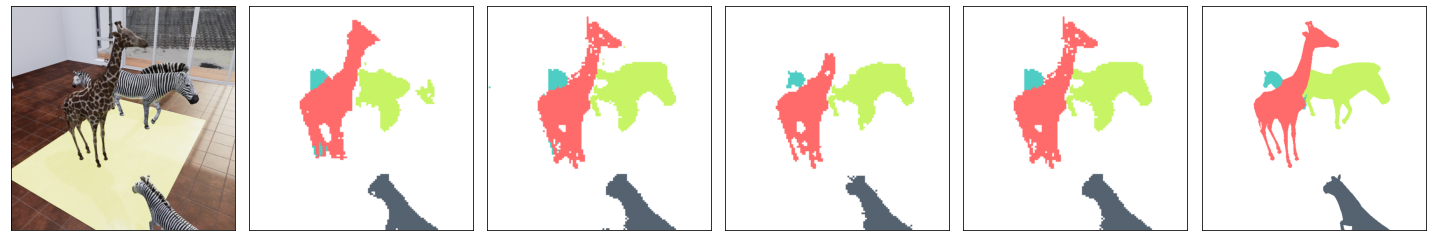

  5%|▌         | 1/20 [00:08<02:41,  8.52s/it]

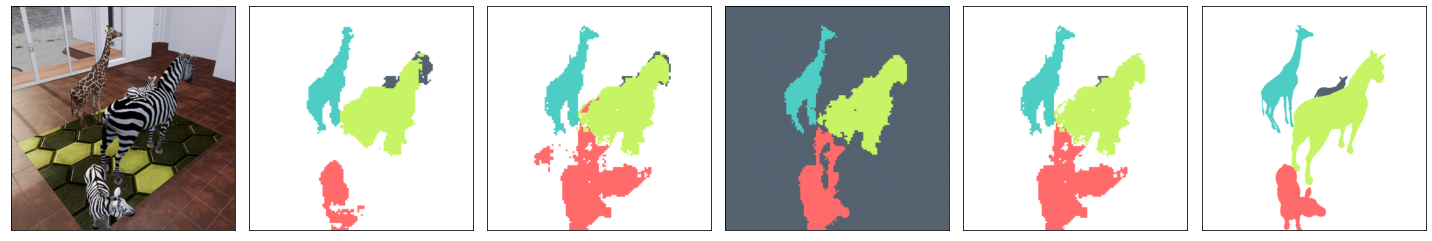

 10%|█         | 2/20 [00:16<02:31,  8.40s/it]

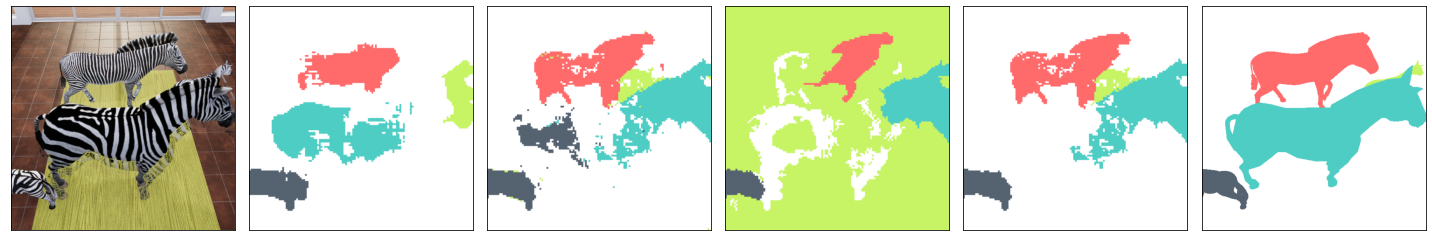

 15%|█▌        | 3/20 [00:25<02:25,  8.57s/it]

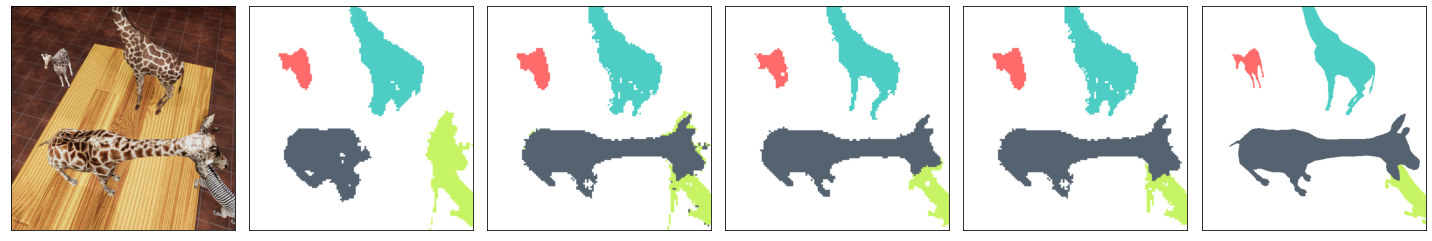

 20%|██        | 4/20 [00:34<02:16,  8.50s/it]

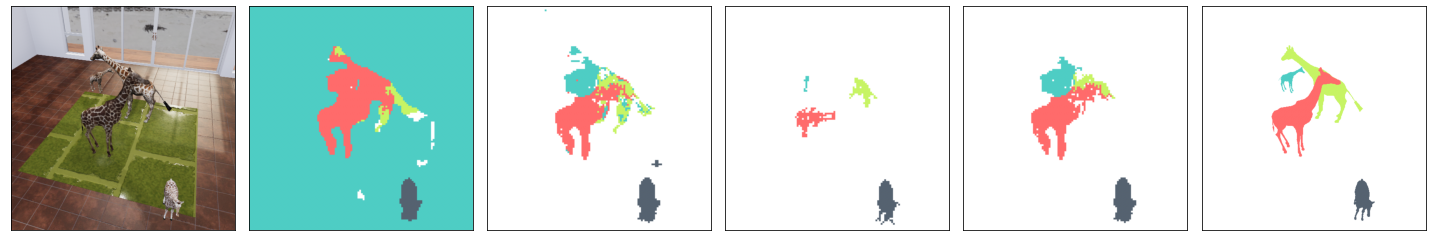

 25%|██▌       | 5/20 [00:42<02:05,  8.39s/it]

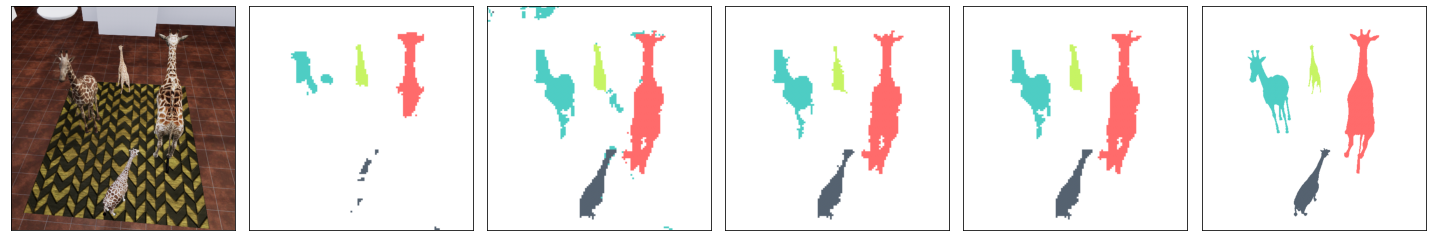

 30%|███       | 6/20 [00:50<01:57,  8.39s/it]

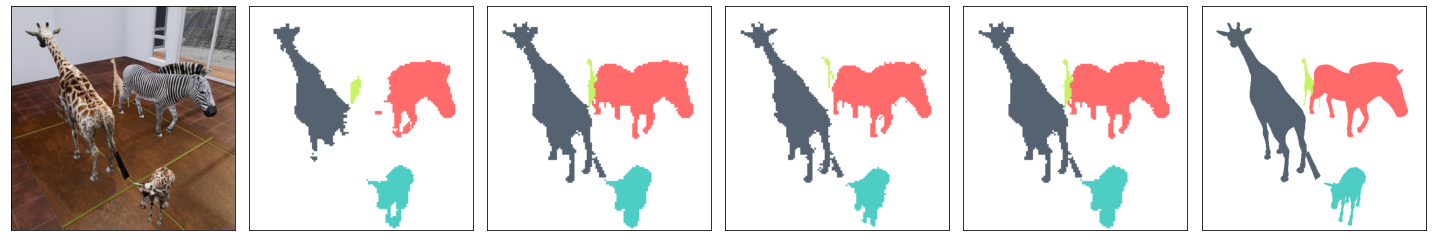

 35%|███▌      | 7/20 [00:58<01:48,  8.36s/it]

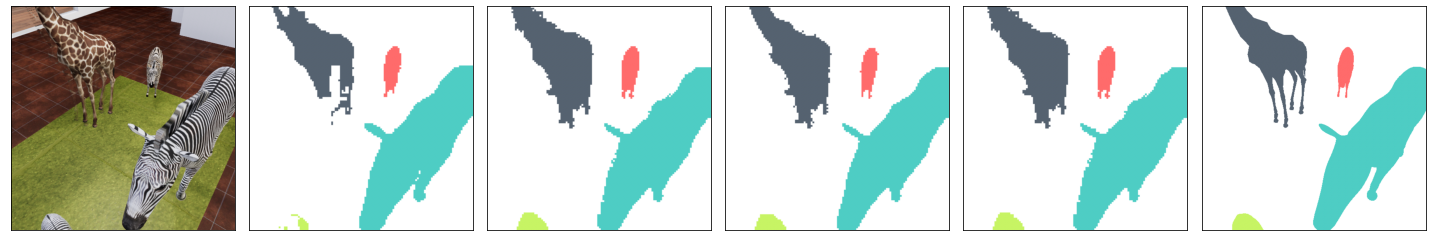

 40%|████      | 8/20 [01:07<01:40,  8.37s/it]

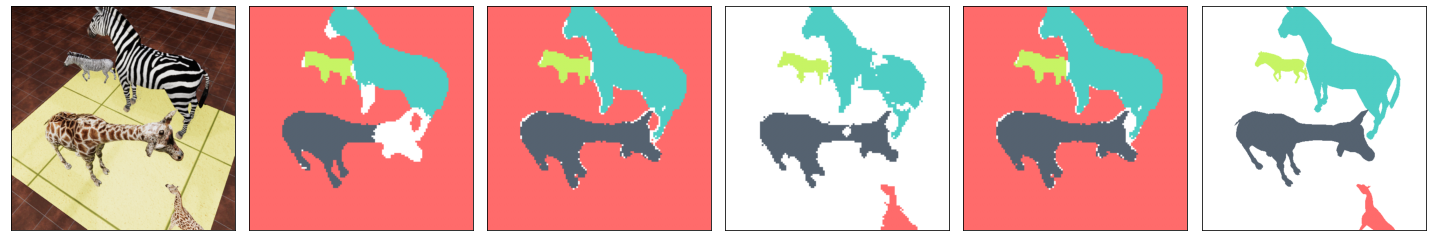

 45%|████▌     | 9/20 [01:15<01:31,  8.30s/it]

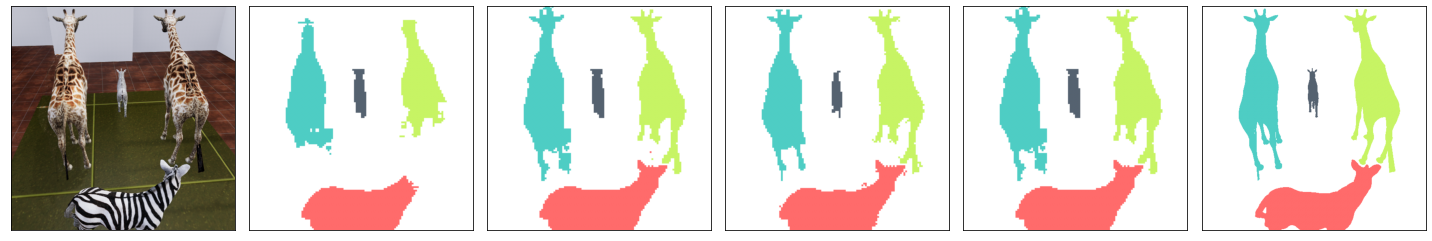

 50%|█████     | 10/20 [01:23<01:23,  8.35s/it]

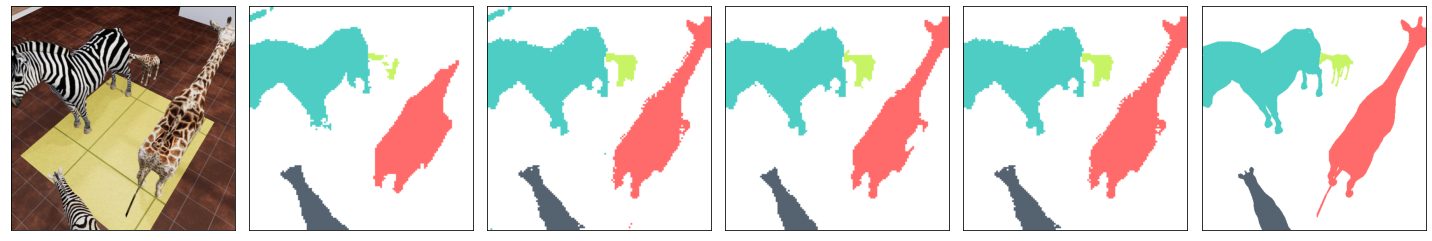

 55%|█████▌    | 11/20 [01:32<01:15,  8.37s/it]

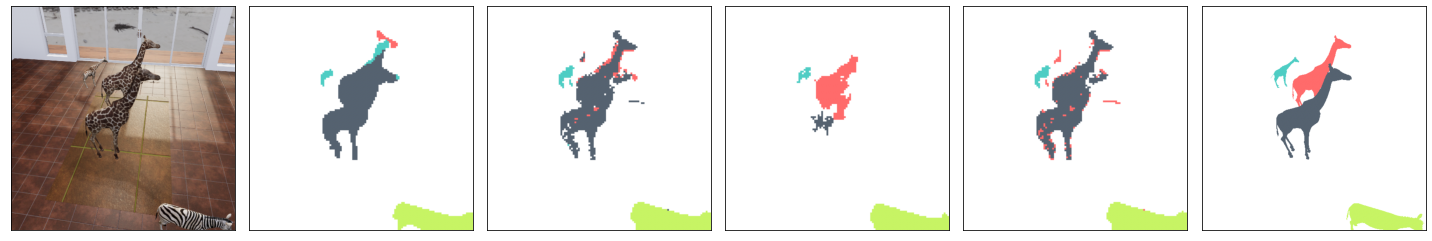

 60%|██████    | 12/20 [01:40<01:06,  8.36s/it]

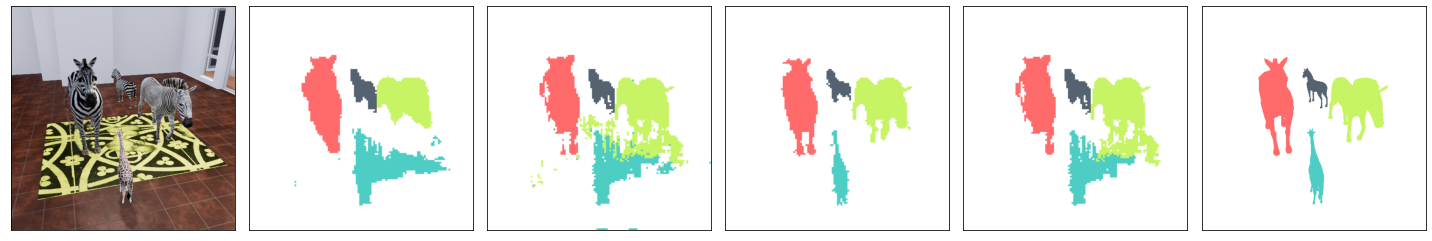

 65%|██████▌   | 13/20 [01:49<00:58,  8.39s/it]

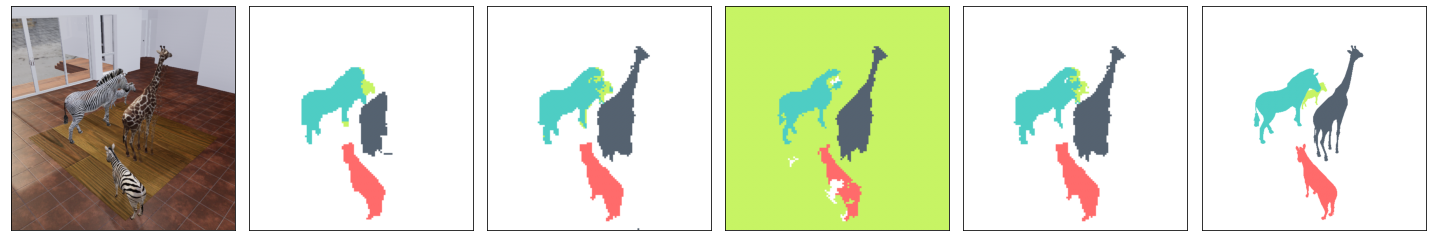

 70%|███████   | 14/20 [01:57<00:50,  8.37s/it]

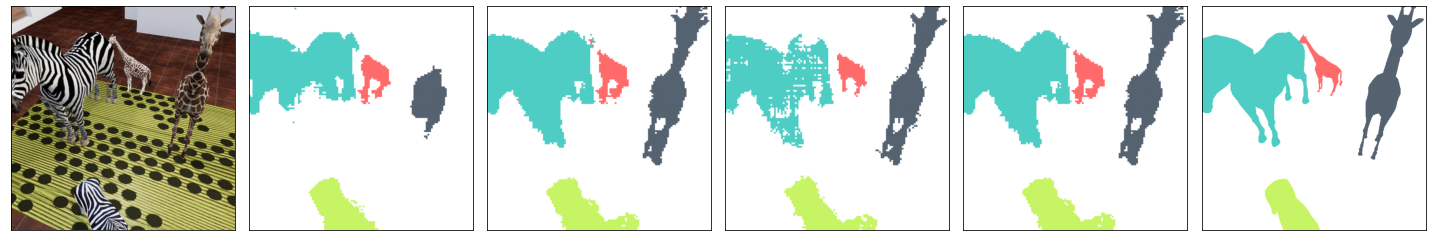

 75%|███████▌  | 15/20 [02:05<00:41,  8.36s/it]

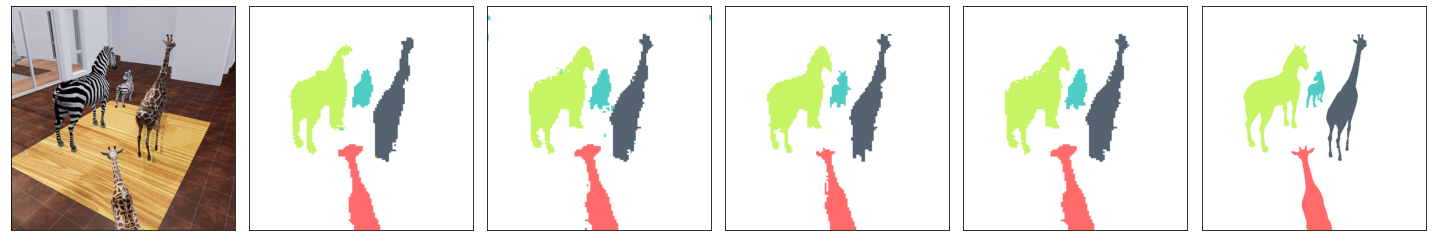

 80%|████████  | 16/20 [02:13<00:33,  8.33s/it]

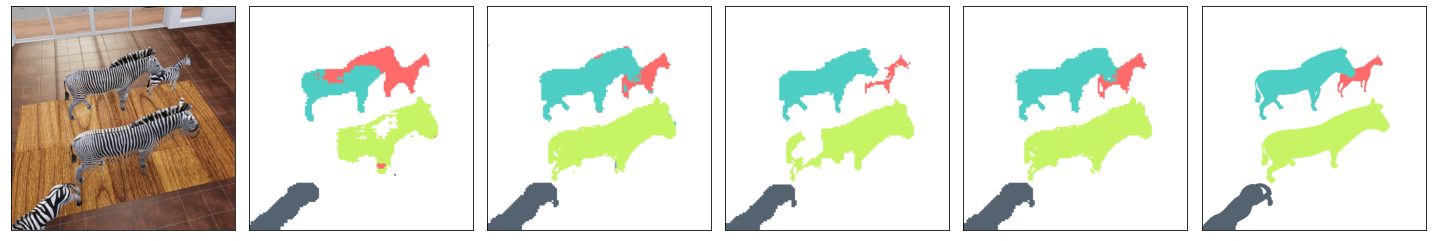

 85%|████████▌ | 17/20 [02:22<00:25,  8.37s/it]

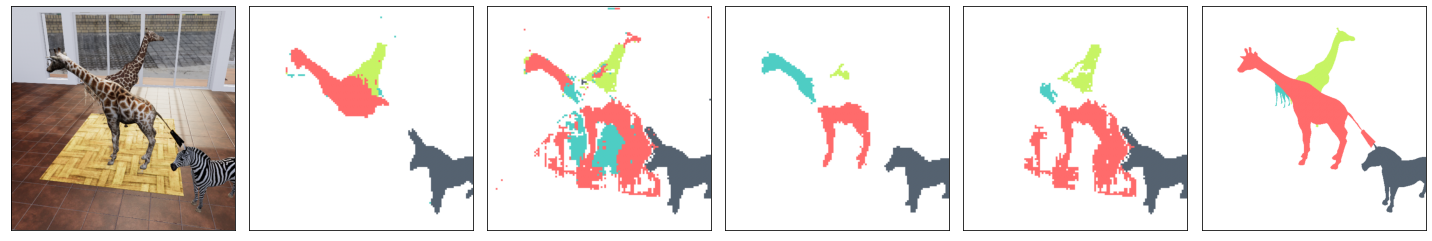

 90%|█████████ | 18/20 [02:30<00:16,  8.40s/it]

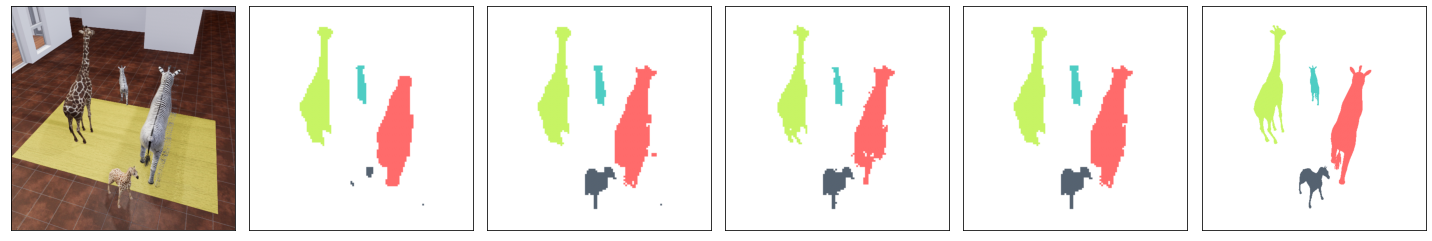

 95%|█████████▌| 19/20 [02:39<00:08,  8.44s/it]

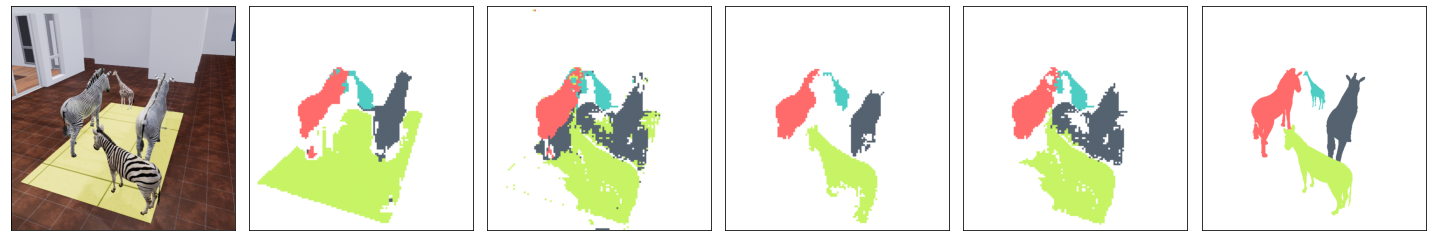

100%|██████████| 20/20 [02:47<00:00,  8.39s/it]


In [12]:
KP.num_iters = 30

import os
save_dir='/mnt/fs6/dbear/eccv_2022_results/figures/kp_prior'

for ex in tqdm(range(20)):
    filename = 'kp_compare_safari_ex' + str(ex) + '.svg'

    preds = compare_learned_to_random_init(
        val_dataset, ex, torch.load(saved_affinities[ex])['affinities'].cuda(),
        prior_model=kpnet,
        mask_model=act_net,
        competition_model=Comp, 
        propagation_model=KP,
        thing_init=True, 
        thresh=0.1, 
        resolution=12, 
        num_masks_h0=32,
        num_masks=32, 
        random_background=False,
        downsample=4,
        affinities_norm=rowmax_norm,
        do_plot=True,
        cmap=3,
        save_path=os.path.join(save_dir, filename)
    )

In [18]:
KP.num_iters = 30


# results_val = val_compare(
#     val_dataset, None, saved_affinities, affinities_model=None,
#     prior_model=kpnet,
#     mask_model=act_net,
#     competition_model=Comp, 
#     propagation_model=KP,
#     thing_init=True, 
#     thresh=0.1, 
#     resolution=12, 
#     num_masks_h0=32,
#     num_masks=32, 
#     random_background=False,
#     downsample=4,
#     affinities_norm=rowmax_norm
# )

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
## results on tdw val set with random or learned prior, Q = 144 (== resolution**2), 128x128)
# {k:v.mean() for k,v in results_val.items()}

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'learned_init': 0.6542568728024437,
 'prop_random_init': 0.48603543150986467,
 'prop_learned_init': 0.7199668869238451}

In [23]:
KP.num_iters = 40
def rowmax_norm(x):
    return x / x.max(-1, True)[0]

results_64x64 = val_compare(
    val_dataset, range(10), saved_affinities, affinities_model=None,
    prior_model=kpnet,
    mask_model=act_net,
    competition_model=Comp, 
    propagation_model=KP,
    thing_init=True, 
    thresh=0.1, 
    resolution=8, 
    num_masks_h0=32,
    num_masks=32, 
    random_background=False,
    downsample=8,
    affinities_norm=rowmax_norm
)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/10 [00:00<?, ?it/s]

downsample
affinities shape torch.Size([1, 4096, 4096]) tensor(0.2499, device='cuda:0') tensor(0., device='cuda:0')


 10%|█         | 1/10 [00:02<00:26,  2.91s/it]

0 {'learned_init': array([0.56009405]), 'prop_random_init': array([0.39880268]), 'prop_learned_init': array([0.57999321]), 'prop_random_init_ccs': array([0.57177319]), 'prop_learned_init_ccs': array([0.62479812]), 'prop_random_init_masked_ccs': array([0.5493913]), 'prop_learned_init_masked_ccs': array([0.60373008])}
downsample
affinities shape torch.Size([1, 4096, 4096]) tensor(0.2500, device='cuda:0') tensor(0., device='cuda:0')


 20%|██        | 2/10 [00:05<00:22,  2.87s/it]

1 {'learned_init': array([0.69310417]), 'prop_random_init': array([0.68323311]), 'prop_learned_init': array([0.84260056]), 'prop_random_init_ccs': array([0.59929462]), 'prop_learned_init_ccs': array([0.60029386]), 'prop_random_init_masked_ccs': array([0.74322919]), 'prop_learned_init_masked_ccs': array([0.74677185])}
downsample
affinities shape torch.Size([1, 4096, 4096]) tensor(0.2499, device='cuda:0') tensor(0., device='cuda:0')


 30%|███       | 3/10 [00:14<00:38,  5.53s/it]

2 {'learned_init': array([0.69700183]), 'prop_random_init': array([0.51462287]), 'prop_learned_init': array([0.72489077]), 'prop_random_init_ccs': array([0.74922639]), 'prop_learned_init_ccs': array([0.73751286]), 'prop_random_init_masked_ccs': array([0.70407395]), 'prop_learned_init_masked_ccs': array([0.70453796])}
downsample
affinities shape torch.Size([1, 4096, 4096]) tensor(0.2500, device='cuda:0') tensor(0., device='cuda:0')


 40%|████      | 4/10 [00:17<00:26,  4.47s/it]

3 {'learned_init': array([0.64201152]), 'prop_random_init': array([0.38968202]), 'prop_learned_init': array([0.66266377]), 'prop_random_init_ccs': array([0.66309102]), 'prop_learned_init_ccs': array([0.67668028]), 'prop_random_init_masked_ccs': array([0.61747797]), 'prop_learned_init_masked_ccs': array([0.64125777])}
downsample
affinities shape torch.Size([1, 4096, 4096]) tensor(0.2175, device='cuda:0') tensor(0., device='cuda:0')


 50%|█████     | 5/10 [00:20<00:19,  3.89s/it]

4 {'learned_init': array([0.66574409]), 'prop_random_init': array([0.51341179]), 'prop_learned_init': array([0.6780042]), 'prop_random_init_ccs': array([0.51729172]), 'prop_learned_init_ccs': array([0.50713927]), 'prop_random_init_masked_ccs': array([0.53860165]), 'prop_learned_init_masked_ccs': array([0.51988026])}
downsample
affinities shape torch.Size([1, 4096, 4096]) tensor(0.2500, device='cuda:0') tensor(0., device='cuda:0')


 60%|██████    | 6/10 [00:22<00:14,  3.50s/it]

5 {'learned_init': array([0.61246332]), 'prop_random_init': array([0.59267268]), 'prop_learned_init': array([0.76574017]), 'prop_random_init_ccs': array([0.80436186]), 'prop_learned_init_ccs': array([0.76470917]), 'prop_random_init_masked_ccs': array([0.61137544]), 'prop_learned_init_masked_ccs': array([0.59046393])}
downsample
affinities shape torch.Size([1, 4096, 4096]) tensor(0.2465, device='cuda:0') tensor(0., device='cuda:0')


 70%|███████   | 7/10 [00:25<00:09,  3.30s/it]

6 {'learned_init': array([0.510674]), 'prop_random_init': array([0.40970581]), 'prop_learned_init': array([0.52673197]), 'prop_random_init_ccs': array([0.4441195]), 'prop_learned_init_ccs': array([0.52852546]), 'prop_random_init_masked_ccs': array([0.44516241]), 'prop_learned_init_masked_ccs': array([0.54048654])}
downsample
affinities shape torch.Size([1, 4096, 4096]) tensor(0.2493, device='cuda:0') tensor(0., device='cuda:0')


 80%|████████  | 8/10 [00:33<00:09,  4.77s/it]

7 {'learned_init': array([0.69033713]), 'prop_random_init': array([0.38818823]), 'prop_learned_init': array([0.66030937]), 'prop_random_init_ccs': array([0.68406311]), 'prop_learned_init_ccs': array([0.669231]), 'prop_random_init_masked_ccs': array([0.69452191]), 'prop_learned_init_masked_ccs': array([0.69863958])}
downsample
affinities shape torch.Size([1, 4096, 4096]) tensor(0.2500, device='cuda:0') tensor(0., device='cuda:0')


 90%|█████████ | 9/10 [00:36<00:04,  4.18s/it]

8 {'learned_init': array([0.59658369]), 'prop_random_init': array([0.28452301]), 'prop_learned_init': array([0.55866411]), 'prop_random_init_ccs': array([0.60532577]), 'prop_learned_init_ccs': array([0.56430925]), 'prop_random_init_masked_ccs': array([0.62966451]), 'prop_learned_init_masked_ccs': array([0.59324164])}
downsample
affinities shape torch.Size([1, 4096, 4096]) tensor(0.2500, device='cuda:0') tensor(0., device='cuda:0')


100%|██████████| 10/10 [00:39<00:00,  3.95s/it]

9 {'learned_init': array([0.65968587]), 'prop_random_init': array([0.60865176]), 'prop_learned_init': array([0.75872248]), 'prop_random_init_ccs': array([0.77418122]), 'prop_learned_init_ccs': array([0.77766138]), 'prop_random_init_masked_ccs': array([0.7223324]), 'prop_learned_init_masked_ccs': array([0.71497914])}


In [25]:
# results on tdw val set with random or learned prior, Q = 64 (== resolution**2), 64x64)
{k:v.mean() for k,v in results_64x64.items()}

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'learned_init': 0.6327699662496646,
 'prop_random_init': 0.4783493979659397,
 'prop_learned_init': 0.6758320606003204,
 'prop_random_init_ccs': 0.6412728401655234,
 'prop_learned_init_ccs': 0.645086065058907,
 'prop_random_init_masked_ccs': 0.6255830732691416,
 'prop_learned_init_masked_ccs': 0.635398873562614}

In [52]:
# KP.num_iters = 30
# def rowmax_norm(x):
#     return x / x.max(-1, True)[0]

# results_128x128 = val_compare(
#     val_dataset, None, saved_affinities, affinities_model=None,
#     prior_model=kpnet,
#     mask_model=act_net,
#     competition_model=Comp, 
#     propagation_model=KP,
#     thing_init=True, 
#     thresh=0.1, 
#     resolution=12, 
#     num_masks_h0=32,
#     num_masks=32, 
#     random_background=False,
#     downsample=4,
#     min_area=10,
#     affinities_norm=rowmax_norm
# )

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


  0%|          | 1/500 [00:06<57:07,  6.87s/it]

0 {'learned_init': array([0.55209828]), 'prop_random_init': array([0.33478838]), 'prop_learned_init': array([0.61070254]), 'prop_random_init_ccs': array([0.62998961]), 'prop_learned_init_ccs': array([0.61776562])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


  0%|          | 2/500 [00:13<57:08,  6.88s/it]

1 {'learned_init': array([0.70525583]), 'prop_random_init': array([0.75284997]), 'prop_learned_init': array([0.87692604]), 'prop_random_init_ccs': array([0.88510674]), 'prop_learned_init_ccs': array([0.87692604])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


  1%|          | 3/500 [00:20<56:51,  6.86s/it]

2 {'learned_init': array([0.71136567]), 'prop_random_init': array([0.47749433]), 'prop_learned_init': array([0.75939357]), 'prop_random_init_ccs': array([0.82747313]), 'prop_learned_init_ccs': array([0.76209372])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


  1%|          | 4/500 [00:27<56:59,  6.89s/it]

3 {'learned_init': array([0.69082101]), 'prop_random_init': array([0.36863966]), 'prop_learned_init': array([0.7198271]), 'prop_random_init_ccs': array([0.77441035]), 'prop_learned_init_ccs': array([0.722481])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9996, device='cuda:0') tensor(0., device='cuda:0')


  1%|          | 5/500 [00:34<56:56,  6.90s/it]

4 {'learned_init': array([0.67768082]), 'prop_random_init': array([0.36028008]), 'prop_learned_init': array([0.6929803]), 'prop_random_init_ccs': array([0.72573093]), 'prop_learned_init_ccs': array([0.6941468])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


  1%|          | 6/500 [00:41<56:50,  6.90s/it]

5 {'learned_init': array([0.62818073]), 'prop_random_init': array([0.56536881]), 'prop_learned_init': array([0.80873416]), 'prop_random_init_ccs': array([0.83439995]), 'prop_learned_init_ccs': array([0.79290131])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9992, device='cuda:0') tensor(0., device='cuda:0')


  1%|▏         | 7/500 [00:48<56:54,  6.93s/it]

6 {'learned_init': array([0.42813581]), 'prop_random_init': array([0.27204385]), 'prop_learned_init': array([0.53120444]), 'prop_random_init_ccs': array([0.41719429]), 'prop_learned_init_ccs': array([0.53157761])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


  2%|▏         | 8/500 [00:55<56:51,  6.93s/it]

7 {'learned_init': array([0.64062946]), 'prop_random_init': array([0.44855715]), 'prop_learned_init': array([0.6989885]), 'prop_random_init_ccs': array([0.73775893]), 'prop_learned_init_ccs': array([0.69970324])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


  2%|▏         | 9/500 [01:02<56:44,  6.93s/it]

8 {'learned_init': array([0.59559994]), 'prop_random_init': array([0.37315644]), 'prop_learned_init': array([0.5715858]), 'prop_random_init_ccs': array([0.64216577]), 'prop_learned_init_ccs': array([0.57551445])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


  2%|▏         | 10/500 [01:09<56:39,  6.94s/it]

9 {'learned_init': array([0.66298531]), 'prop_random_init': array([0.59639981]), 'prop_learned_init': array([0.79147716]), 'prop_random_init_ccs': array([0.83277166]), 'prop_learned_init_ccs': array([0.79801911])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


  2%|▏         | 11/500 [01:16<56:52,  6.98s/it]

10 {'learned_init': array([0.59399357]), 'prop_random_init': array([0.68812697]), 'prop_learned_init': array([0.85058032]), 'prop_random_init_ccs': array([0.8647664]), 'prop_learned_init_ccs': array([0.85222922])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


  2%|▏         | 12/500 [01:23<56:48,  6.98s/it]

11 {'learned_init': array([0.6788582]), 'prop_random_init': array([0.37074213]), 'prop_learned_init': array([0.76575039]), 'prop_random_init_ccs': array([0.64232994]), 'prop_learned_init_ccs': array([0.76588094])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9989, device='cuda:0') tensor(0., device='cuda:0')


  3%|▎         | 13/500 [01:30<56:46,  6.99s/it]

12 {'learned_init': array([0.55530431]), 'prop_random_init': array([0.30834574]), 'prop_learned_init': array([0.60365071]), 'prop_random_init_ccs': array([0.36989474]), 'prop_learned_init_ccs': array([0.6065793])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


  3%|▎         | 14/500 [01:37<56:50,  7.02s/it]

13 {'learned_init': array([0.6276612]), 'prop_random_init': array([0.70043945]), 'prop_learned_init': array([0.89688879]), 'prop_random_init_ccs': array([0.8931374]), 'prop_learned_init_ccs': array([0.89968996])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


  3%|▎         | 15/500 [01:44<56:37,  7.01s/it]

14 {'learned_init': array([0.55380561]), 'prop_random_init': array([0.3862634]), 'prop_learned_init': array([0.70121455]), 'prop_random_init_ccs': array([0.75225243]), 'prop_learned_init_ccs': array([0.71102501])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


  3%|▎         | 16/500 [01:51<56:48,  7.04s/it]

15 {'learned_init': array([0.7667997]), 'prop_random_init': array([0.51276231]), 'prop_learned_init': array([0.7690414]), 'prop_random_init_ccs': array([0.83008699]), 'prop_learned_init_ccs': array([0.77221045])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9999, device='cuda:0') tensor(0., device='cuda:0')


  3%|▎         | 17/500 [01:58<56:56,  7.07s/it]

16 {'learned_init': array([0.61261905]), 'prop_random_init': array([0.52346898]), 'prop_learned_init': array([0.61790917]), 'prop_random_init_ccs': array([0.62356235]), 'prop_learned_init_ccs': array([0.61330158])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


  4%|▎         | 18/500 [02:05<56:32,  7.04s/it]

17 {'learned_init': array([0.64818463]), 'prop_random_init': array([0.42113394]), 'prop_learned_init': array([0.64939716]), 'prop_random_init_ccs': array([0.68028789]), 'prop_learned_init_ccs': array([0.65097016])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


  4%|▍         | 19/500 [02:12<56:38,  7.06s/it]

18 {'learned_init': array([0.8218005]), 'prop_random_init': array([0.67743456]), 'prop_learned_init': array([0.85124429]), 'prop_random_init_ccs': array([0.87612452]), 'prop_learned_init_ccs': array([0.85159484])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9824, device='cuda:0') tensor(0., device='cuda:0')


  4%|▍         | 20/500 [02:19<56:49,  7.10s/it]

19 {'learned_init': array([0.55478627]), 'prop_random_init': array([0.55998244]), 'prop_learned_init': array([0.7699333]), 'prop_random_init_ccs': array([0.80852267]), 'prop_learned_init_ccs': array([0.75353317])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


  4%|▍         | 22/500 [02:36<1:01:55,  7.77s/it]

21 {'learned_init': array([0.67560542]), 'prop_random_init': array([0.48501498]), 'prop_learned_init': array([0.7216581]), 'prop_random_init_ccs': array([0.75542162]), 'prop_learned_init_ccs': array([0.7280764])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9998, device='cuda:0') tensor(0., device='cuda:0')


  5%|▍         | 23/500 [02:43<1:00:02,  7.55s/it]

22 {'learned_init': array([0.80876018]), 'prop_random_init': array([0.74522942]), 'prop_learned_init': array([0.85402398]), 'prop_random_init_ccs': array([0.85571879]), 'prop_learned_init_ccs': array([0.85402398])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


  5%|▍         | 24/500 [02:52<1:04:36,  8.14s/it]

23 {'learned_init': array([0.7394495]), 'prop_random_init': array([0.65320235]), 'prop_learned_init': array([0.82348772]), 'prop_random_init_ccs': array([0.86405641]), 'prop_learned_init_ccs': array([0.82787484])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9999, device='cuda:0') tensor(0., device='cuda:0')


  5%|▌         | 25/500 [02:59<1:02:00,  7.83s/it]

24 {'learned_init': array([0.70887519]), 'prop_random_init': array([0.65266152]), 'prop_learned_init': array([0.90130676]), 'prop_random_init_ccs': array([0.89974628]), 'prop_learned_init_ccs': array([0.90138137])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9990, device='cuda:0') tensor(0., device='cuda:0')


  5%|▌         | 26/500 [03:06<59:56,  7.59s/it]  

25 {'learned_init': array([0.71774105]), 'prop_random_init': array([0.41672239]), 'prop_learned_init': array([0.73190217]), 'prop_random_init_ccs': array([0.7313751]), 'prop_learned_init_ccs': array([0.80247664])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9988, device='cuda:0') tensor(0., device='cuda:0')


  5%|▌         | 27/500 [03:13<58:22,  7.41s/it]

26 {'learned_init': array([0.80890207]), 'prop_random_init': array([0.74682888]), 'prop_learned_init': array([0.89478822]), 'prop_random_init_ccs': array([0.91058141]), 'prop_learned_init_ccs': array([0.89478822])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


  6%|▌         | 28/500 [03:20<57:19,  7.29s/it]

27 {'learned_init': array([0.80921872]), 'prop_random_init': array([0.54416621]), 'prop_learned_init': array([0.7634389]), 'prop_random_init_ccs': array([0.84366712]), 'prop_learned_init_ccs': array([0.77797157])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9936, device='cuda:0') tensor(0., device='cuda:0')


  6%|▌         | 29/500 [03:28<56:45,  7.23s/it]

28 {'learned_init': array([0.65709817]), 'prop_random_init': array([0.69812647]), 'prop_learned_init': array([0.91424531]), 'prop_random_init_ccs': array([0.91724439]), 'prop_learned_init_ccs': array([0.90736204])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


  6%|▌         | 30/500 [03:35<56:32,  7.22s/it]

29 {'learned_init': array([0.79178728]), 'prop_random_init': array([0.70589747]), 'prop_learned_init': array([0.82657602]), 'prop_random_init_ccs': array([0.83764911]), 'prop_learned_init_ccs': array([0.8265126])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9995, device='cuda:0') tensor(0., device='cuda:0')


  6%|▌         | 31/500 [03:45<1:04:11,  8.21s/it]

30 {'learned_init': array([0.81612971]), 'prop_random_init': array([0.70255937]), 'prop_learned_init': array([0.86042593]), 'prop_random_init_ccs': array([0.83262379]), 'prop_learned_init_ccs': array([0.81523748])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


  6%|▋         | 32/500 [03:57<1:11:36,  9.18s/it]

31 {'learned_init': array([0.44769103]), 'prop_random_init': array([0.18256224]), 'prop_learned_init': array([0.43157949]), 'prop_random_init_ccs': array([0.50265]), 'prop_learned_init_ccs': array([0.5566615])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


  7%|▋         | 33/500 [04:06<1:11:20,  9.16s/it]

32 {'learned_init': array([0.61201561]), 'prop_random_init': array([0.58062412]), 'prop_learned_init': array([0.72398744]), 'prop_random_init_ccs': array([0.76149854]), 'prop_learned_init_ccs': array([0.72398744])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


  7%|▋         | 34/500 [04:17<1:14:55,  9.65s/it]

33 {'learned_init': array([0.67812957]), 'prop_random_init': array([0.33907445]), 'prop_learned_init': array([0.68060426]), 'prop_random_init_ccs': array([0.67505236]), 'prop_learned_init_ccs': array([0.68199769])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9978, device='cuda:0') tensor(0., device='cuda:0')


  7%|▋         | 35/500 [04:27<1:17:00,  9.94s/it]

34 {'learned_init': array([0.70486773]), 'prop_random_init': array([0.81274513]), 'prop_learned_init': array([0.92392462]), 'prop_random_init_ccs': array([0.94353217]), 'prop_learned_init_ccs': array([0.92406126])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


  7%|▋         | 36/500 [04:37<1:16:31,  9.90s/it]

35 {'learned_init': array([0.61290389]), 'prop_random_init': array([0.68984881]), 'prop_learned_init': array([0.86332335]), 'prop_random_init_ccs': array([0.89171769]), 'prop_learned_init_ccs': array([0.86543816])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


  7%|▋         | 37/500 [04:47<1:16:01,  9.85s/it]

36 {'learned_init': array([0.80775265]), 'prop_random_init': array([0.51135989]), 'prop_learned_init': array([0.81617083]), 'prop_random_init_ccs': array([0.78147369]), 'prop_learned_init_ccs': array([0.8181757])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


  8%|▊         | 38/500 [04:55<1:13:02,  9.49s/it]

37 {'learned_init': array([0.70060834]), 'prop_random_init': array([0.46456382]), 'prop_learned_init': array([0.67629775]), 'prop_random_init_ccs': array([0.73952515]), 'prop_learned_init_ccs': array([0.71217522])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9874, device='cuda:0') tensor(0., device='cuda:0')


  8%|▊         | 39/500 [05:04<1:11:15,  9.27s/it]

38 {'learned_init': array([0.59315026]), 'prop_random_init': array([0.42590948]), 'prop_learned_init': array([0.6900494]), 'prop_random_init_ccs': array([0.5850823]), 'prop_learned_init_ccs': array([0.68464419])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


  8%|▊         | 40/500 [05:14<1:11:36,  9.34s/it]

39 {'learned_init': array([0.69976083]), 'prop_random_init': array([0.49321833]), 'prop_learned_init': array([0.74690822]), 'prop_random_init_ccs': array([0.75919241]), 'prop_learned_init_ccs': array([0.7166307])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9772, device='cuda:0') tensor(0., device='cuda:0')


  8%|▊         | 41/500 [05:23<1:10:23,  9.20s/it]

40 {'learned_init': array([0.50569881]), 'prop_random_init': array([0.57605642]), 'prop_learned_init': array([0.6006272]), 'prop_random_init_ccs': array([0.61603672]), 'prop_learned_init_ccs': array([0.60171656])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


  8%|▊         | 42/500 [05:32<1:09:47,  9.14s/it]

41 {'learned_init': array([0.67161494]), 'prop_random_init': array([0.39552658]), 'prop_learned_init': array([0.69712231]), 'prop_random_init_ccs': array([0.74259903]), 'prop_learned_init_ccs': array([0.69712231])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


  9%|▊         | 43/500 [05:40<1:08:55,  9.05s/it]

42 {'learned_init': array([0.65773359]), 'prop_random_init': array([0.36434708]), 'prop_learned_init': array([0.62204114]), 'prop_random_init_ccs': array([0.6187058]), 'prop_learned_init_ccs': array([0.62287294])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9930, device='cuda:0') tensor(0., device='cuda:0')


  9%|▉         | 44/500 [05:50<1:09:36,  9.16s/it]

43 {'learned_init': array([0.56079739]), 'prop_random_init': array([0.42995991]), 'prop_learned_init': array([0.56945161]), 'prop_random_init_ccs': array([0.5546226]), 'prop_learned_init_ccs': array([0.57057294])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


  9%|▉         | 45/500 [05:59<1:09:24,  9.15s/it]

44 {'learned_init': array([0.35509015]), 'prop_random_init': array([0.58085927]), 'prop_learned_init': array([0.61241626]), 'prop_random_init_ccs': array([0.64485463]), 'prop_learned_init_ccs': array([0.61332581])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


  9%|▉         | 46/500 [06:09<1:10:30,  9.32s/it]

45 {'learned_init': array([0.8244772]), 'prop_random_init': array([0.58584329]), 'prop_learned_init': array([0.81233762]), 'prop_random_init_ccs': array([0.90531428]), 'prop_learned_init_ccs': array([0.81425278])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9325, device='cuda:0') tensor(3.5173e-43, device='cuda:0')


  9%|▉         | 47/500 [06:18<1:09:38,  9.22s/it]

46 {'learned_init': array([0.64592209]), 'prop_random_init': array([0.62702371]), 'prop_learned_init': array([0.6689362]), 'prop_random_init_ccs': array([0.75911585]), 'prop_learned_init_ccs': array([0.77929902])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 10%|▉         | 48/500 [06:27<1:09:29,  9.22s/it]

47 {'learned_init': array([0.5864112]), 'prop_random_init': array([0.45984355]), 'prop_learned_init': array([0.80858358]), 'prop_random_init_ccs': array([0.59388971]), 'prop_learned_init_ccs': array([0.80986867])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9999, device='cuda:0') tensor(0., device='cuda:0')


 10%|▉         | 49/500 [06:35<1:07:22,  8.96s/it]

48 {'learned_init': array([0.74357478]), 'prop_random_init': array([0.60827416]), 'prop_learned_init': array([0.74706827]), 'prop_random_init_ccs': array([0.79359859]), 'prop_learned_init_ccs': array([0.74950512])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 10%|█         | 50/500 [06:44<1:06:57,  8.93s/it]

49 {'learned_init': array([0.73160429]), 'prop_random_init': array([0.45775861]), 'prop_learned_init': array([0.79729606]), 'prop_random_init_ccs': array([0.79007463]), 'prop_learned_init_ccs': array([0.80080992])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9996, device='cuda:0') tensor(0., device='cuda:0')


 10%|█         | 51/500 [06:52<1:05:26,  8.75s/it]

50 {'learned_init': array([0.64038543]), 'prop_random_init': array([0.54441907]), 'prop_learned_init': array([0.71362694]), 'prop_random_init_ccs': array([0.78918169]), 'prop_learned_init_ccs': array([0.72430347])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 10%|█         | 52/500 [07:01<1:04:28,  8.64s/it]

51 {'learned_init': array([0.6775944]), 'prop_random_init': array([0.46365797]), 'prop_learned_init': array([0.66231551]), 'prop_random_init_ccs': array([0.68504616]), 'prop_learned_init_ccs': array([0.66496857])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 11%|█         | 53/500 [07:10<1:05:14,  8.76s/it]

52 {'learned_init': array([0.64265577]), 'prop_random_init': array([0.30443343]), 'prop_learned_init': array([0.65313116]), 'prop_random_init_ccs': array([0.66083661]), 'prop_learned_init_ccs': array([0.65771964])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 11%|█         | 54/500 [07:19<1:05:39,  8.83s/it]

53 {'learned_init': array([0.71449775]), 'prop_random_init': array([0.52681663]), 'prop_learned_init': array([0.77928746]), 'prop_random_init_ccs': array([0.82057059]), 'prop_learned_init_ccs': array([0.78169115])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 11%|█         | 55/500 [07:28<1:05:34,  8.84s/it]

54 {'learned_init': array([0.53377903]), 'prop_random_init': array([0.21674219]), 'prop_learned_init': array([0.7371145]), 'prop_random_init_ccs': array([0.45288626]), 'prop_learned_init_ccs': array([0.7343083])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 11%|█         | 56/500 [07:38<1:09:09,  9.35s/it]

55 {'learned_init': array([0.67263471]), 'prop_random_init': array([0.33371575]), 'prop_learned_init': array([0.66322967]), 'prop_random_init_ccs': array([0.67158717]), 'prop_learned_init_ccs': array([0.62180778])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9517, device='cuda:0') tensor(0., device='cuda:0')


 11%|█▏        | 57/500 [07:47<1:08:06,  9.22s/it]

56 {'learned_init': array([0.53119025]), 'prop_random_init': array([0.41517719]), 'prop_learned_init': array([0.57573676]), 'prop_random_init_ccs': array([0.63416497]), 'prop_learned_init_ccs': array([0.57823682])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 12%|█▏        | 58/500 [07:56<1:07:26,  9.16s/it]

57 {'learned_init': array([0.69173905]), 'prop_random_init': array([0.56428611]), 'prop_learned_init': array([0.69251943]), 'prop_random_init_ccs': array([0.74711953]), 'prop_learned_init_ccs': array([0.69251943])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 12%|█▏        | 59/500 [08:06<1:07:51,  9.23s/it]

58 {'learned_init': array([0.69425347]), 'prop_random_init': array([0.42033341]), 'prop_learned_init': array([0.67341639]), 'prop_random_init_ccs': array([0.74611603]), 'prop_learned_init_ccs': array([0.6746617])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 12%|█▏        | 60/500 [08:14<1:06:05,  9.01s/it]

59 {'learned_init': array([0.78492206]), 'prop_random_init': array([0.38579503]), 'prop_learned_init': array([0.75244412]), 'prop_random_init_ccs': array([0.55649625]), 'prop_learned_init_ccs': array([0.75898719])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9999, device='cuda:0') tensor(0., device='cuda:0')


 12%|█▏        | 61/500 [08:22<1:04:41,  8.84s/it]

60 {'learned_init': array([0.55125893]), 'prop_random_init': array([0.45534259]), 'prop_learned_init': array([0.53195051]), 'prop_random_init_ccs': array([0.81507638]), 'prop_learned_init_ccs': array([0.54886983])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 12%|█▏        | 62/500 [08:31<1:03:20,  8.68s/it]

61 {'learned_init': array([0.52092195]), 'prop_random_init': array([0.53137214]), 'prop_learned_init': array([0.87050314]), 'prop_random_init_ccs': array([0.80152871]), 'prop_learned_init_ccs': array([0.87117039])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 13%|█▎        | 63/500 [08:39<1:03:12,  8.68s/it]

62 {'learned_init': array([0.69758499]), 'prop_random_init': array([0.36851678]), 'prop_learned_init': array([0.68436154]), 'prop_random_init_ccs': array([0.5760505]), 'prop_learned_init_ccs': array([0.69017565])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.8320, device='cuda:0') tensor(0., device='cuda:0')


 13%|█▎        | 64/500 [08:48<1:02:52,  8.65s/it]

63 {'learned_init': array([0.78160106]), 'prop_random_init': array([0.50628069]), 'prop_learned_init': array([0.68373528]), 'prop_random_init_ccs': array([0.71436018]), 'prop_learned_init_ccs': array([0.68452588])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 13%|█▎        | 65/500 [08:56<1:02:04,  8.56s/it]

64 {'learned_init': array([0.60179367]), 'prop_random_init': array([0.57483868]), 'prop_learned_init': array([0.79224922]), 'prop_random_init_ccs': array([0.84433518]), 'prop_learned_init_ccs': array([0.79224922])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 13%|█▎        | 66/500 [09:05<1:01:13,  8.46s/it]

65 {'learned_init': array([0.68876876]), 'prop_random_init': array([0.34014939]), 'prop_learned_init': array([0.62754928]), 'prop_random_init_ccs': array([0.75984608]), 'prop_learned_init_ccs': array([0.65429941])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 13%|█▎        | 67/500 [09:13<1:00:56,  8.44s/it]

66 {'learned_init': array([0.53378748]), 'prop_random_init': array([0.36945607]), 'prop_learned_init': array([0.66132441]), 'prop_random_init_ccs': array([0.66598565]), 'prop_learned_init_ccs': array([0.66132441])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 14%|█▎        | 68/500 [09:22<1:01:19,  8.52s/it]

67 {'learned_init': array([0.59232901]), 'prop_random_init': array([0.3871576]), 'prop_learned_init': array([0.6393627]), 'prop_random_init_ccs': array([0.63705623]), 'prop_learned_init_ccs': array([0.6402261])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 14%|█▍        | 69/500 [09:30<1:00:52,  8.48s/it]

68 {'learned_init': array([0.64725041]), 'prop_random_init': array([0.69735201]), 'prop_learned_init': array([0.84842478]), 'prop_random_init_ccs': array([0.75404121]), 'prop_learned_init_ccs': array([0.74572666])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9999, device='cuda:0') tensor(0., device='cuda:0')


 14%|█▍        | 70/500 [09:39<1:02:45,  8.76s/it]

69 {'learned_init': array([0.52804203]), 'prop_random_init': array([0.62458486]), 'prop_learned_init': array([0.78899872]), 'prop_random_init_ccs': array([0.84458144]), 'prop_learned_init_ccs': array([0.80347082])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 14%|█▍        | 71/500 [09:49<1:04:51,  9.07s/it]

70 {'learned_init': array([0.46717801]), 'prop_random_init': array([0.65581482]), 'prop_learned_init': array([0.62107293]), 'prop_random_init_ccs': array([0.86969423]), 'prop_learned_init_ccs': array([0.66362505])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 14%|█▍        | 72/500 [09:59<1:06:02,  9.26s/it]

71 {'learned_init': array([0.44887606]), 'prop_random_init': array([0.64935675]), 'prop_learned_init': array([0.705029]), 'prop_random_init_ccs': array([0.70198316]), 'prop_learned_init_ccs': array([0.69489144])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 15%|█▍        | 73/500 [10:08<1:04:48,  9.11s/it]

72 {'learned_init': array([0.73882225]), 'prop_random_init': array([0.50392167]), 'prop_learned_init': array([0.78589155]), 'prop_random_init_ccs': array([0.70210671]), 'prop_learned_init_ccs': array([0.78701517])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 15%|█▍        | 74/500 [10:17<1:05:10,  9.18s/it]

73 {'learned_init': array([0.78715351]), 'prop_random_init': array([0.4949907]), 'prop_learned_init': array([0.72465572]), 'prop_random_init_ccs': array([0.78041095]), 'prop_learned_init_ccs': array([0.75342629])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 15%|█▌        | 75/500 [10:26<1:05:20,  9.22s/it]

74 {'learned_init': array([0.697868]), 'prop_random_init': array([0.50094172]), 'prop_learned_init': array([0.82181154]), 'prop_random_init_ccs': array([0.76025944]), 'prop_learned_init_ccs': array([0.84319505])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 15%|█▌        | 76/500 [10:38<1:11:11, 10.08s/it]

75 {'learned_init': array([0.53196745]), 'prop_random_init': array([0.55508838]), 'prop_learned_init': array([0.75183506]), 'prop_random_init_ccs': array([0.78821015]), 'prop_learned_init_ccs': array([0.7510159])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 15%|█▌        | 77/500 [10:50<1:13:36, 10.44s/it]

76 {'learned_init': array([0.65782266]), 'prop_random_init': array([0.61104687]), 'prop_learned_init': array([0.85197034]), 'prop_random_init_ccs': array([0.83321248]), 'prop_learned_init_ccs': array([0.85419799])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 16%|█▌        | 78/500 [11:01<1:14:50, 10.64s/it]

77 {'learned_init': array([0.71864036]), 'prop_random_init': array([0.33431442]), 'prop_learned_init': array([0.67140074]), 'prop_random_init_ccs': array([0.75172366]), 'prop_learned_init_ccs': array([0.69024424])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 16%|█▌        | 79/500 [11:10<1:12:28, 10.33s/it]

78 {'learned_init': array([0.56805751]), 'prop_random_init': array([0.42213972]), 'prop_learned_init': array([0.74419075]), 'prop_random_init_ccs': array([0.78641023]), 'prop_learned_init_ccs': array([0.74437752])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9971, device='cuda:0') tensor(0., device='cuda:0')


 16%|█▌        | 80/500 [11:19<1:08:13,  9.75s/it]

79 {'learned_init': array([0.74300486]), 'prop_random_init': array([0.55291024]), 'prop_learned_init': array([0.76991493]), 'prop_random_init_ccs': array([0.69357899]), 'prop_learned_init_ccs': array([0.77006325])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 16%|█▌        | 81/500 [11:28<1:06:43,  9.55s/it]

80 {'learned_init': array([0.78154731]), 'prop_random_init': array([0.50634152]), 'prop_learned_init': array([0.81017897]), 'prop_random_init_ccs': array([0.81795761]), 'prop_learned_init_ccs': array([0.78302572])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 16%|█▋        | 82/500 [11:48<1:28:27, 12.70s/it]

81 {'learned_init': array([0.24466702]), 'prop_random_init': array([0.34352385]), 'prop_learned_init': array([0.53264388]), 'prop_random_init_ccs': array([0.4497605]), 'prop_learned_init_ccs': array([0.53869229])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9997, device='cuda:0') tensor(0., device='cuda:0')


 17%|█▋        | 83/500 [12:08<1:43:24, 14.88s/it]

82 {'learned_init': array([0.46107948]), 'prop_random_init': array([0.46402686]), 'prop_learned_init': array([0.64314464]), 'prop_random_init_ccs': array([0.73536477]), 'prop_learned_init_ccs': array([0.68579296])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 17%|█▋        | 84/500 [12:23<1:44:29, 15.07s/it]

83 {'learned_init': array([0.73450806]), 'prop_random_init': array([0.5541084]), 'prop_learned_init': array([0.73800211]), 'prop_random_init_ccs': array([0.77410404]), 'prop_learned_init_ccs': array([0.74022068])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 17%|█▋        | 85/500 [12:36<1:39:34, 14.40s/it]

84 {'learned_init': array([0.7557508]), 'prop_random_init': array([0.55834488]), 'prop_learned_init': array([0.88068916]), 'prop_random_init_ccs': array([0.90586215]), 'prop_learned_init_ccs': array([0.88203345])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 17%|█▋        | 86/500 [12:51<1:39:09, 14.37s/it]

85 {'learned_init': array([0.47987422]), 'prop_random_init': array([0.43661683]), 'prop_learned_init': array([0.60492514]), 'prop_random_init_ccs': array([0.68350684]), 'prop_learned_init_ccs': array([0.60482413])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 17%|█▋        | 87/500 [13:04<1:36:34, 14.03s/it]

86 {'learned_init': array([0.53088207]), 'prop_random_init': array([0.32699762]), 'prop_learned_init': array([0.59413853]), 'prop_random_init_ccs': array([0.57029878]), 'prop_learned_init_ccs': array([0.59500857])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9999, device='cuda:0') tensor(0., device='cuda:0')


 18%|█▊        | 88/500 [13:17<1:33:51, 13.67s/it]

87 {'learned_init': array([0.61875153]), 'prop_random_init': array([0.49297446]), 'prop_learned_init': array([0.67623567]), 'prop_random_init_ccs': array([0.70082293]), 'prop_learned_init_ccs': array([0.68661172])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 18%|█▊        | 89/500 [13:28<1:28:45, 12.96s/it]

88 {'learned_init': array([0.76208586]), 'prop_random_init': array([0.75359823]), 'prop_learned_init': array([0.91018568]), 'prop_random_init_ccs': array([0.92128173]), 'prop_learned_init_ccs': array([0.91005188])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 18%|█▊        | 90/500 [13:39<1:23:34, 12.23s/it]

89 {'learned_init': array([0.85921654]), 'prop_random_init': array([0.70188834]), 'prop_learned_init': array([0.8692721]), 'prop_random_init_ccs': array([0.88788073]), 'prop_learned_init_ccs': array([0.87076847])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 18%|█▊        | 91/500 [13:50<1:20:48, 11.85s/it]

90 {'learned_init': array([0.83797626]), 'prop_random_init': array([0.56148226]), 'prop_learned_init': array([0.78761669]), 'prop_random_init_ccs': array([0.82395402]), 'prop_learned_init_ccs': array([0.79572172])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9992, device='cuda:0') tensor(0., device='cuda:0')


 18%|█▊        | 92/500 [14:00<1:16:59, 11.32s/it]

91 {'learned_init': array([0.75891956]), 'prop_random_init': array([0.56410057]), 'prop_learned_init': array([0.79223994]), 'prop_random_init_ccs': array([0.819131]), 'prop_learned_init_ccs': array([0.79307466])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 19%|█▊        | 93/500 [14:10<1:15:14, 11.09s/it]

92 {'learned_init': array([0.73029298]), 'prop_random_init': array([0.60687062]), 'prop_learned_init': array([0.78603803]), 'prop_random_init_ccs': array([0.81229895]), 'prop_learned_init_ccs': array([0.78603803])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 19%|█▉        | 94/500 [14:21<1:14:12, 10.97s/it]

93 {'learned_init': array([0.73292084]), 'prop_random_init': array([0.44827517]), 'prop_learned_init': array([0.74522296]), 'prop_random_init_ccs': array([0.59053724]), 'prop_learned_init_ccs': array([0.757778])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 19%|█▉        | 95/500 [14:30<1:10:53, 10.50s/it]

94 {'learned_init': array([0.50709696]), 'prop_random_init': array([0.43498798]), 'prop_learned_init': array([0.56281019]), 'prop_random_init_ccs': array([0.50604493]), 'prop_learned_init_ccs': array([0.55347695])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9999, device='cuda:0') tensor(0., device='cuda:0')


 19%|█▉        | 96/500 [14:40<1:09:27, 10.31s/it]

95 {'learned_init': array([0.65839146]), 'prop_random_init': array([0.55399216]), 'prop_learned_init': array([0.70504331]), 'prop_random_init_ccs': array([0.70668169]), 'prop_learned_init_ccs': array([0.71566058])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9996, device='cuda:0') tensor(0., device='cuda:0')


 19%|█▉        | 97/500 [14:50<1:08:16, 10.17s/it]

96 {'learned_init': array([0.77750063]), 'prop_random_init': array([0.51922442]), 'prop_learned_init': array([0.82025994]), 'prop_random_init_ccs': array([0.86872795]), 'prop_learned_init_ccs': array([0.82238969])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9505, device='cuda:0') tensor(0., device='cuda:0')


 20%|█▉        | 98/500 [14:58<1:04:41,  9.66s/it]

97 {'learned_init': array([0.86012581]), 'prop_random_init': array([0.83503781]), 'prop_learned_init': array([0.89641432]), 'prop_random_init_ccs': array([0.90737608]), 'prop_learned_init_ccs': array([0.89641432])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 20%|█▉        | 99/500 [15:08<1:05:25,  9.79s/it]

98 {'learned_init': array([0.8585318]), 'prop_random_init': array([0.58811888]), 'prop_learned_init': array([0.83872032]), 'prop_random_init_ccs': array([0.81949253]), 'prop_learned_init_ccs': array([0.83891687])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9999, device='cuda:0') tensor(0., device='cuda:0')


 20%|██        | 100/500 [15:17<1:02:14,  9.34s/it]

99 {'learned_init': array([0.63286018]), 'prop_random_init': array([0.5196843]), 'prop_learned_init': array([0.87778275]), 'prop_random_init_ccs': array([0.84213413]), 'prop_learned_init_ccs': array([0.88121839])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9998, device='cuda:0') tensor(0., device='cuda:0')


 20%|██        | 101/500 [15:25<59:45,  8.98s/it]  

100 {'learned_init': array([0.74992034]), 'prop_random_init': array([0.46999487]), 'prop_learned_init': array([0.75944781]), 'prop_random_init_ccs': array([0.72000101]), 'prop_learned_init_ccs': array([0.75915502])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 20%|██        | 102/500 [15:33<58:34,  8.83s/it]

101 {'learned_init': array([0.62395266]), 'prop_random_init': array([0.58162915]), 'prop_learned_init': array([0.71374798]), 'prop_random_init_ccs': array([0.78861172]), 'prop_learned_init_ccs': array([0.76115587])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9997, device='cuda:0') tensor(0., device='cuda:0')


 21%|██        | 103/500 [15:42<57:57,  8.76s/it]

102 {'learned_init': array([0.12252155]), 'prop_random_init': array([0.07838232]), 'prop_learned_init': array([0.22159009]), 'prop_random_init_ccs': array([0.20226323]), 'prop_learned_init_ccs': array([0.28063286])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 21%|██        | 104/500 [15:51<57:55,  8.78s/it]

103 {'learned_init': array([0.61501852]), 'prop_random_init': array([0.4859364]), 'prop_learned_init': array([0.62540362]), 'prop_random_init_ccs': array([0.67411044]), 'prop_learned_init_ccs': array([0.62347022])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 21%|██        | 105/500 [15:59<56:55,  8.65s/it]

104 {'learned_init': array([0.49421031]), 'prop_random_init': array([0.55079562]), 'prop_learned_init': array([0.7772032]), 'prop_random_init_ccs': array([0.70756107]), 'prop_learned_init_ccs': array([0.71029772])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9951, device='cuda:0') tensor(0., device='cuda:0')


 21%|██        | 106/500 [16:07<54:55,  8.36s/it]

105 {'learned_init': array([0.78928224]), 'prop_random_init': array([0.71303467]), 'prop_learned_init': array([0.90082445]), 'prop_random_init_ccs': array([0.91513832]), 'prop_learned_init_ccs': array([0.90053513])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 21%|██▏       | 107/500 [16:16<55:19,  8.45s/it]

106 {'learned_init': array([0.6267308]), 'prop_random_init': array([0.51305738]), 'prop_learned_init': array([0.7529168]), 'prop_random_init_ccs': array([0.76450059]), 'prop_learned_init_ccs': array([0.75192645])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9980, device='cuda:0') tensor(0., device='cuda:0')


 22%|██▏       | 108/500 [16:25<57:01,  8.73s/it]

107 {'learned_init': array([0.78339763]), 'prop_random_init': array([0.7052838]), 'prop_learned_init': array([0.78908169]), 'prop_random_init_ccs': array([0.7993245]), 'prop_learned_init_ccs': array([0.78930553])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 22%|██▏       | 109/500 [16:34<57:52,  8.88s/it]

108 {'learned_init': array([0.63030514]), 'prop_random_init': array([0.36192851]), 'prop_learned_init': array([0.69128707]), 'prop_random_init_ccs': array([0.6245329]), 'prop_learned_init_ccs': array([0.69742984])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 22%|██▏       | 110/500 [16:43<57:14,  8.81s/it]

109 {'learned_init': array([0.82778025]), 'prop_random_init': array([0.71319339]), 'prop_learned_init': array([0.89783186]), 'prop_random_init_ccs': array([0.94160998]), 'prop_learned_init_ccs': array([0.90070691])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 22%|██▏       | 111/500 [16:51<55:54,  8.62s/it]

110 {'learned_init': array([0.80757874]), 'prop_random_init': array([0.53561292]), 'prop_learned_init': array([0.78978293]), 'prop_random_init_ccs': array([0.85396005]), 'prop_learned_init_ccs': array([0.80200894])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 22%|██▏       | 112/500 [17:00<56:22,  8.72s/it]

111 {'learned_init': array([0.70572564]), 'prop_random_init': array([0.52393252]), 'prop_learned_init': array([0.77579629]), 'prop_random_init_ccs': array([0.80140905]), 'prop_learned_init_ccs': array([0.77822782])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9968, device='cuda:0') tensor(0., device='cuda:0')


 23%|██▎       | 113/500 [17:08<55:55,  8.67s/it]

112 {'learned_init': array([0.54091285]), 'prop_random_init': array([0.57290249]), 'prop_learned_init': array([0.6612661]), 'prop_random_init_ccs': array([0.82211071]), 'prop_learned_init_ccs': array([0.66146488])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 23%|██▎       | 114/500 [17:17<55:59,  8.70s/it]

113 {'learned_init': array([0.72981378]), 'prop_random_init': array([0.58980758]), 'prop_learned_init': array([0.55980767]), 'prop_random_init_ccs': array([0.63104841]), 'prop_learned_init_ccs': array([0.54191016])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9999, device='cuda:0') tensor(0., device='cuda:0')


 23%|██▎       | 115/500 [17:26<55:46,  8.69s/it]

114 {'learned_init': array([0.4551832]), 'prop_random_init': array([0.35031795]), 'prop_learned_init': array([0.32512041]), 'prop_random_init_ccs': array([0.61607316]), 'prop_learned_init_ccs': array([0.32903856])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 23%|██▎       | 116/500 [17:34<55:10,  8.62s/it]

115 {'learned_init': array([0.72905453]), 'prop_random_init': array([0.65491012]), 'prop_learned_init': array([0.86450158]), 'prop_random_init_ccs': array([0.89953858]), 'prop_learned_init_ccs': array([0.86611067])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9652, device='cuda:0') tensor(5.3249e-44, device='cuda:0')


 23%|██▎       | 117/500 [17:43<55:56,  8.76s/it]

116 {'learned_init': array([0.32220705]), 'prop_random_init': array([0.26033076]), 'prop_learned_init': array([0.37669439]), 'prop_random_init_ccs': array([0.55561908]), 'prop_learned_init_ccs': array([0.39659631])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 24%|██▎       | 118/500 [17:53<56:39,  8.90s/it]

117 {'learned_init': array([0.5085832]), 'prop_random_init': array([0.65886224]), 'prop_learned_init': array([0.7037667]), 'prop_random_init_ccs': array([0.71903355]), 'prop_learned_init_ccs': array([0.70760154])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 24%|██▍       | 119/500 [18:01<55:44,  8.78s/it]

118 {'learned_init': array([0.64663619]), 'prop_random_init': array([0.5727935]), 'prop_learned_init': array([0.85313906]), 'prop_random_init_ccs': array([0.81078497]), 'prop_learned_init_ccs': array([0.79295561])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 24%|██▍       | 120/500 [18:10<54:47,  8.65s/it]

119 {'learned_init': array([0.45646141]), 'prop_random_init': array([0.41513199]), 'prop_learned_init': array([0.53661773]), 'prop_random_init_ccs': array([0.51749307]), 'prop_learned_init_ccs': array([0.53264736])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 24%|██▍       | 121/500 [18:18<54:24,  8.61s/it]

120 {'learned_init': array([0.65603765]), 'prop_random_init': array([0.54996767]), 'prop_learned_init': array([0.65936999]), 'prop_random_init_ccs': array([0.69252083]), 'prop_learned_init_ccs': array([0.65990917])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 24%|██▍       | 122/500 [18:26<52:57,  8.40s/it]

121 {'learned_init': array([0.88194782]), 'prop_random_init': array([0.6634009]), 'prop_learned_init': array([0.85123833]), 'prop_random_init_ccs': array([0.87691005]), 'prop_learned_init_ccs': array([0.856773])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 25%|██▍       | 123/500 [18:35<53:42,  8.55s/it]

122 {'learned_init': array([0.31582925]), 'prop_random_init': array([0.44982066]), 'prop_learned_init': array([0.59265998]), 'prop_random_init_ccs': array([0.54377393]), 'prop_learned_init_ccs': array([0.53071853])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 25%|██▍       | 124/500 [18:43<53:38,  8.56s/it]

123 {'learned_init': array([0.80607823]), 'prop_random_init': array([0.5859894]), 'prop_learned_init': array([0.79558617]), 'prop_random_init_ccs': array([0.83709492]), 'prop_learned_init_ccs': array([0.79558617])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 25%|██▌       | 125/500 [18:52<53:25,  8.55s/it]

124 {'learned_init': array([0.63694252]), 'prop_random_init': array([0.65251435]), 'prop_learned_init': array([0.83164814]), 'prop_random_init_ccs': array([0.85350966]), 'prop_learned_init_ccs': array([0.83485934])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 25%|██▌       | 126/500 [19:01<53:17,  8.55s/it]

125 {'learned_init': array([0.79043797]), 'prop_random_init': array([0.53436936]), 'prop_learned_init': array([0.79912151]), 'prop_random_init_ccs': array([0.76259122]), 'prop_learned_init_ccs': array([0.8049601])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 25%|██▌       | 127/500 [19:09<53:10,  8.55s/it]

126 {'learned_init': array([0.66490779]), 'prop_random_init': array([0.49292145]), 'prop_learned_init': array([0.64641769]), 'prop_random_init_ccs': array([0.7285022]), 'prop_learned_init_ccs': array([0.64726808])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9960, device='cuda:0') tensor(0., device='cuda:0')


 26%|██▌       | 128/500 [19:17<52:33,  8.48s/it]

127 {'learned_init': array([0.31699803]), 'prop_random_init': array([0.14289982]), 'prop_learned_init': array([0.61702208]), 'prop_random_init_ccs': array([0.3886735]), 'prop_learned_init_ccs': array([0.63147246])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 26%|██▌       | 129/500 [19:26<52:20,  8.47s/it]

128 {'learned_init': array([0.70294785]), 'prop_random_init': array([0.6157685]), 'prop_learned_init': array([0.7498697]), 'prop_random_init_ccs': array([0.69180988]), 'prop_learned_init_ccs': array([0.75874355])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 26%|██▌       | 130/500 [19:34<52:35,  8.53s/it]

129 {'learned_init': array([0.77104171]), 'prop_random_init': array([0.51575129]), 'prop_learned_init': array([0.7589276]), 'prop_random_init_ccs': array([0.77535627]), 'prop_learned_init_ccs': array([0.75951128])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9995, device='cuda:0') tensor(0., device='cuda:0')


 26%|██▌       | 131/500 [19:43<52:39,  8.56s/it]

130 {'learned_init': array([0.60501401]), 'prop_random_init': array([0.5164749]), 'prop_learned_init': array([0.59860039]), 'prop_random_init_ccs': array([0.71823888]), 'prop_learned_init_ccs': array([0.59860039])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9992, device='cuda:0') tensor(0., device='cuda:0')


 26%|██▋       | 132/500 [19:51<51:48,  8.45s/it]

131 {'learned_init': array([0.89738925]), 'prop_random_init': array([0.76669526]), 'prop_learned_init': array([0.87906247]), 'prop_random_init_ccs': array([0.90029399]), 'prop_learned_init_ccs': array([0.88004307])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9931, device='cuda:0') tensor(0., device='cuda:0')


 27%|██▋       | 133/500 [20:00<52:32,  8.59s/it]

132 {'learned_init': array([0.77330089]), 'prop_random_init': array([0.5158845]), 'prop_learned_init': array([0.75657782]), 'prop_random_init_ccs': array([0.74160343]), 'prop_learned_init_ccs': array([0.75841123])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 27%|██▋       | 134/500 [20:10<53:43,  8.81s/it]

133 {'learned_init': array([0.4662556]), 'prop_random_init': array([0.32653262]), 'prop_learned_init': array([0.55508613]), 'prop_random_init_ccs': array([0.52258369]), 'prop_learned_init_ccs': array([0.54286274])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 27%|██▋       | 135/500 [20:18<53:05,  8.73s/it]

134 {'learned_init': array([0.79988743]), 'prop_random_init': array([0.68666758]), 'prop_learned_init': array([0.85752273]), 'prop_random_init_ccs': array([0.86389348]), 'prop_learned_init_ccs': array([0.85739884])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 27%|██▋       | 136/500 [20:26<52:18,  8.62s/it]

135 {'learned_init': array([0.58693594]), 'prop_random_init': array([0.62734924]), 'prop_learned_init': array([0.77065387]), 'prop_random_init_ccs': array([0.7555774]), 'prop_learned_init_ccs': array([0.7738712])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9954, device='cuda:0') tensor(0., device='cuda:0')


 27%|██▋       | 137/500 [20:35<51:19,  8.48s/it]

136 {'learned_init': array([0.83364689]), 'prop_random_init': array([0.73013988]), 'prop_learned_init': array([0.86283591]), 'prop_random_init_ccs': array([0.88635933]), 'prop_learned_init_ccs': array([0.86398226])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9987, device='cuda:0') tensor(0., device='cuda:0')


 28%|██▊       | 138/500 [20:43<51:06,  8.47s/it]

137 {'learned_init': array([0.87590441]), 'prop_random_init': array([0.57340758]), 'prop_learned_init': array([0.87261371]), 'prop_random_init_ccs': array([0.88876042]), 'prop_learned_init_ccs': array([0.87261371])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 28%|██▊       | 139/500 [20:51<50:44,  8.43s/it]

138 {'learned_init': array([0.78485143]), 'prop_random_init': array([0.72909293]), 'prop_learned_init': array([0.83817309]), 'prop_random_init_ccs': array([0.86205135]), 'prop_learned_init_ccs': array([0.83777352])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 28%|██▊       | 140/500 [21:01<52:04,  8.68s/it]

139 {'learned_init': array([0.75848833]), 'prop_random_init': array([0.35307769]), 'prop_learned_init': array([0.60124976]), 'prop_random_init_ccs': array([0.44704795]), 'prop_learned_init_ccs': array([0.60254591])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 28%|██▊       | 141/500 [21:09<51:43,  8.64s/it]

140 {'learned_init': array([0.43073278]), 'prop_random_init': array([0.36469535]), 'prop_learned_init': array([0.3923137]), 'prop_random_init_ccs': array([0.39089894]), 'prop_learned_init_ccs': array([0.38928779])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 28%|██▊       | 142/500 [21:17<50:35,  8.48s/it]

141 {'learned_init': array([0.45500115]), 'prop_random_init': array([0.29377284]), 'prop_learned_init': array([0.65739807]), 'prop_random_init_ccs': array([0.58738001]), 'prop_learned_init_ccs': array([0.65947463])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 29%|██▊       | 143/500 [21:26<50:36,  8.50s/it]

142 {'learned_init': array([0.74132627]), 'prop_random_init': array([0.39500051]), 'prop_learned_init': array([0.74148396]), 'prop_random_init_ccs': array([0.72086834]), 'prop_learned_init_ccs': array([0.74845391])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 29%|██▉       | 144/500 [21:34<49:47,  8.39s/it]

143 {'learned_init': array([0.85594842]), 'prop_random_init': array([0.57304128]), 'prop_learned_init': array([0.84400868]), 'prop_random_init_ccs': array([0.89319138]), 'prop_learned_init_ccs': array([0.85338446])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 29%|██▉       | 145/500 [21:43<50:45,  8.58s/it]

144 {'learned_init': array([0.58723584]), 'prop_random_init': array([0.21270854]), 'prop_learned_init': array([0.63509561]), 'prop_random_init_ccs': array([0.72974933]), 'prop_learned_init_ccs': array([0.61052836])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 29%|██▉       | 146/500 [21:52<50:38,  8.58s/it]

145 {'learned_init': array([0.57953719]), 'prop_random_init': array([0.47183659]), 'prop_learned_init': array([0.64462943]), 'prop_random_init_ccs': array([0.59102008]), 'prop_learned_init_ccs': array([0.64772629])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9911, device='cuda:0') tensor(0., device='cuda:0')


 29%|██▉       | 147/500 [22:00<50:00,  8.50s/it]

146 {'learned_init': array([0.44344469]), 'prop_random_init': array([0.6581478]), 'prop_learned_init': array([0.70617451]), 'prop_random_init_ccs': array([0.70724466]), 'prop_learned_init_ccs': array([0.70600717])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 30%|██▉       | 148/500 [22:08<49:23,  8.42s/it]

147 {'learned_init': array([0.65987772]), 'prop_random_init': array([0.52933164]), 'prop_learned_init': array([0.72184487]), 'prop_random_init_ccs': array([0.71604395]), 'prop_learned_init_ccs': array([0.71213596])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9998, device='cuda:0') tensor(0., device='cuda:0')


 30%|██▉       | 149/500 [22:16<49:07,  8.40s/it]

148 {'learned_init': array([0.66616645]), 'prop_random_init': array([0.52180511]), 'prop_learned_init': array([0.81854285]), 'prop_random_init_ccs': array([0.8535998]), 'prop_learned_init_ccs': array([0.82078636])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9997, device='cuda:0') tensor(0., device='cuda:0')


 30%|███       | 150/500 [22:25<49:35,  8.50s/it]

149 {'learned_init': array([0.76168752]), 'prop_random_init': array([0.50886976]), 'prop_learned_init': array([0.79405791]), 'prop_random_init_ccs': array([0.8569856]), 'prop_learned_init_ccs': array([0.79405791])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 30%|███       | 151/500 [22:34<50:16,  8.64s/it]

150 {'learned_init': array([0.81748538]), 'prop_random_init': array([0.25236236]), 'prop_learned_init': array([0.76118851]), 'prop_random_init_ccs': array([0.83322597]), 'prop_learned_init_ccs': array([0.76480848])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 30%|███       | 152/500 [22:43<50:26,  8.70s/it]

151 {'learned_init': array([0.7209824]), 'prop_random_init': array([0.500106]), 'prop_learned_init': array([0.7555782]), 'prop_random_init_ccs': array([0.77137293]), 'prop_learned_init_ccs': array([0.76050322])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 31%|███       | 153/500 [22:52<50:09,  8.67s/it]

152 {'learned_init': array([0.575492]), 'prop_random_init': array([0.41242267]), 'prop_learned_init': array([0.56414834]), 'prop_random_init_ccs': array([0.80717091]), 'prop_learned_init_ccs': array([0.56837521])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 31%|███       | 154/500 [23:01<51:14,  8.88s/it]

153 {'learned_init': array([0.59340966]), 'prop_random_init': array([0.41102609]), 'prop_learned_init': array([0.58221513]), 'prop_random_init_ccs': array([0.80502263]), 'prop_learned_init_ccs': array([0.59744392])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 31%|███       | 155/500 [23:10<50:59,  8.87s/it]

154 {'learned_init': array([0.85518855]), 'prop_random_init': array([0.73894066]), 'prop_learned_init': array([0.88696787]), 'prop_random_init_ccs': array([0.91063368]), 'prop_learned_init_ccs': array([0.88840304])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 31%|███       | 156/500 [23:19<51:23,  8.97s/it]

155 {'learned_init': array([0.71873108]), 'prop_random_init': array([0.47287907]), 'prop_learned_init': array([0.68248185]), 'prop_random_init_ccs': array([0.7483345]), 'prop_learned_init_ccs': array([0.69399715])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 31%|███▏      | 157/500 [23:28<51:06,  8.94s/it]

156 {'learned_init': array([0.77436928]), 'prop_random_init': array([0.80038104]), 'prop_learned_init': array([0.85438701]), 'prop_random_init_ccs': array([0.88333857]), 'prop_learned_init_ccs': array([0.8565371])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 32%|███▏      | 158/500 [23:36<49:19,  8.65s/it]

157 {'learned_init': array([0.75384847]), 'prop_random_init': array([0.3399995]), 'prop_learned_init': array([0.79623508]), 'prop_random_init_ccs': array([0.79141966]), 'prop_learned_init_ccs': array([0.80042467])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 32%|███▏      | 159/500 [23:44<48:49,  8.59s/it]

158 {'learned_init': array([0.55828702]), 'prop_random_init': array([0.4020981]), 'prop_learned_init': array([0.6385612]), 'prop_random_init_ccs': array([0.76509614]), 'prop_learned_init_ccs': array([0.63920125])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9998, device='cuda:0') tensor(0., device='cuda:0')


 32%|███▏      | 160/500 [23:52<46:56,  8.28s/it]

159 {'learned_init': array([0.50333702]), 'prop_random_init': array([0.22614941]), 'prop_learned_init': array([0.47770731]), 'prop_random_init_ccs': array([0.34326517]), 'prop_learned_init_ccs': array([0.46358613])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 32%|███▏      | 161/500 [24:00<45:59,  8.14s/it]

160 {'learned_init': array([0.61438856]), 'prop_random_init': array([0.63139769]), 'prop_learned_init': array([0.59754333]), 'prop_random_init_ccs': array([0.78963836]), 'prop_learned_init_ccs': array([0.59842481])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9988, device='cuda:0') tensor(0., device='cuda:0')


 32%|███▏      | 162/500 [24:09<47:11,  8.38s/it]

161 {'learned_init': array([0.80431618]), 'prop_random_init': array([0.65872312]), 'prop_learned_init': array([0.91480549]), 'prop_random_init_ccs': array([0.88990355]), 'prop_learned_init_ccs': array([0.91511282])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 33%|███▎      | 163/500 [24:18<49:16,  8.77s/it]

162 {'learned_init': array([0.26868674]), 'prop_random_init': array([0.10386082]), 'prop_learned_init': array([0.2953078]), 'prop_random_init_ccs': array([0.25298469]), 'prop_learned_init_ccs': array([0.33985473])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 33%|███▎      | 164/500 [24:27<49:11,  8.78s/it]

163 {'learned_init': array([0.59745516]), 'prop_random_init': array([0.43798833]), 'prop_learned_init': array([0.75736673]), 'prop_random_init_ccs': array([0.80654562]), 'prop_learned_init_ccs': array([0.75791259])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 33%|███▎      | 165/500 [24:36<48:29,  8.68s/it]

164 {'learned_init': array([0.8112174]), 'prop_random_init': array([0.65689092]), 'prop_learned_init': array([0.86104567]), 'prop_random_init_ccs': array([0.87301058]), 'prop_learned_init_ccs': array([0.85894689])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 33%|███▎      | 166/500 [24:45<48:42,  8.75s/it]

165 {'learned_init': array([0.76058999]), 'prop_random_init': array([0.54890853]), 'prop_learned_init': array([0.84160472]), 'prop_random_init_ccs': array([0.66295867]), 'prop_learned_init_ccs': array([0.84569776])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 33%|███▎      | 167/500 [24:54<48:56,  8.82s/it]

166 {'learned_init': array([0.61272387]), 'prop_random_init': array([0.30425583]), 'prop_learned_init': array([0.72407269]), 'prop_random_init_ccs': array([0.56865919]), 'prop_learned_init_ccs': array([0.72598624])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 34%|███▎      | 168/500 [25:02<48:30,  8.77s/it]

167 {'learned_init': array([0.64902215]), 'prop_random_init': array([0.3942371]), 'prop_learned_init': array([0.72287551]), 'prop_random_init_ccs': array([0.6829389]), 'prop_learned_init_ccs': array([0.73463241])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 34%|███▍      | 169/500 [25:11<48:05,  8.72s/it]

168 {'learned_init': array([0.67061642]), 'prop_random_init': array([0.74952876]), 'prop_learned_init': array([0.91675065]), 'prop_random_init_ccs': array([0.92028654]), 'prop_learned_init_ccs': array([0.91710498])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 34%|███▍      | 170/500 [25:19<47:26,  8.62s/it]

169 {'learned_init': array([0.69514349]), 'prop_random_init': array([0.53560417]), 'prop_learned_init': array([0.82065417]), 'prop_random_init_ccs': array([0.73628491]), 'prop_learned_init_ccs': array([0.71302762])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 34%|███▍      | 171/500 [25:27<46:23,  8.46s/it]

170 {'learned_init': array([0.76088396]), 'prop_random_init': array([0.52793897]), 'prop_learned_init': array([0.72493185]), 'prop_random_init_ccs': array([0.75669095]), 'prop_learned_init_ccs': array([0.72493185])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 34%|███▍      | 172/500 [25:36<46:13,  8.45s/it]

171 {'learned_init': array([0.62127136]), 'prop_random_init': array([0.65937835]), 'prop_learned_init': array([0.85726751]), 'prop_random_init_ccs': array([0.89050882]), 'prop_learned_init_ccs': array([0.85806222])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 35%|███▍      | 173/500 [25:44<46:02,  8.45s/it]

172 {'learned_init': array([0.67953046]), 'prop_random_init': array([0.49845695]), 'prop_learned_init': array([0.82912372]), 'prop_random_init_ccs': array([0.86421072]), 'prop_learned_init_ccs': array([0.82912372])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 35%|███▍      | 174/500 [25:52<45:29,  8.37s/it]

173 {'learned_init': array([0.57491549]), 'prop_random_init': array([0.75995158]), 'prop_learned_init': array([0.83169523]), 'prop_random_init_ccs': array([0.82311448]), 'prop_learned_init_ccs': array([0.83688462])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9999, device='cuda:0') tensor(0., device='cuda:0')


 35%|███▌      | 175/500 [26:00<45:02,  8.32s/it]

174 {'learned_init': array([0.78140131]), 'prop_random_init': array([0.66114819]), 'prop_learned_init': array([0.88817254]), 'prop_random_init_ccs': array([0.93009573]), 'prop_learned_init_ccs': array([0.89909332])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 35%|███▌      | 176/500 [26:09<44:55,  8.32s/it]

175 {'learned_init': array([0.61838539]), 'prop_random_init': array([0.40176333]), 'prop_learned_init': array([0.56671022]), 'prop_random_init_ccs': array([0.67318276]), 'prop_learned_init_ccs': array([0.56333677])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 35%|███▌      | 177/500 [26:17<44:54,  8.34s/it]

176 {'learned_init': array([0.83052169]), 'prop_random_init': array([0.4704943]), 'prop_learned_init': array([0.82615604]), 'prop_random_init_ccs': array([0.85059667]), 'prop_learned_init_ccs': array([0.82696737])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9984, device='cuda:0') tensor(0., device='cuda:0')


 36%|███▌      | 178/500 [26:26<45:02,  8.39s/it]

177 {'learned_init': array([0.78903215]), 'prop_random_init': array([0.59908531]), 'prop_learned_init': array([0.87456067]), 'prop_random_init_ccs': array([0.89859605]), 'prop_learned_init_ccs': array([0.87739173])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9994, device='cuda:0') tensor(0., device='cuda:0')


 36%|███▌      | 179/500 [26:34<45:29,  8.50s/it]

178 {'learned_init': array([0.52129835]), 'prop_random_init': array([0.41915548]), 'prop_learned_init': array([0.6574678]), 'prop_random_init_ccs': array([0.73088004]), 'prop_learned_init_ccs': array([0.66942407])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 36%|███▌      | 180/500 [26:44<46:12,  8.66s/it]

179 {'learned_init': array([0.384085]), 'prop_random_init': array([0.39165209]), 'prop_learned_init': array([0.46499668]), 'prop_random_init_ccs': array([0.46891309]), 'prop_learned_init_ccs': array([0.46548036])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 36%|███▌      | 181/500 [26:52<45:16,  8.51s/it]

180 {'learned_init': array([0.66738632]), 'prop_random_init': array([0.33343911]), 'prop_learned_init': array([0.76860955]), 'prop_random_init_ccs': array([0.81046735]), 'prop_learned_init_ccs': array([0.7705453])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 36%|███▋      | 182/500 [27:00<44:17,  8.36s/it]

181 {'learned_init': array([0.73167652]), 'prop_random_init': array([0.52863016]), 'prop_learned_init': array([0.81136851]), 'prop_random_init_ccs': array([0.77160317]), 'prop_learned_init_ccs': array([0.71133709])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 37%|███▋      | 183/500 [27:08<43:28,  8.23s/it]

182 {'learned_init': array([0.62682795]), 'prop_random_init': array([0.47167962]), 'prop_learned_init': array([0.82596262]), 'prop_random_init_ccs': array([0.79935797]), 'prop_learned_init_ccs': array([0.83083609])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9988, device='cuda:0') tensor(0., device='cuda:0')


 37%|███▋      | 184/500 [27:16<43:44,  8.31s/it]

183 {'learned_init': array([0.70641547]), 'prop_random_init': array([0.40963178]), 'prop_learned_init': array([0.68156748]), 'prop_random_init_ccs': array([0.73769131]), 'prop_learned_init_ccs': array([0.68418956])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9035, device='cuda:0') tensor(0., device='cuda:0')


 37%|███▋      | 185/500 [27:24<43:24,  8.27s/it]

184 {'learned_init': array([0.41584978]), 'prop_random_init': array([0.70545595]), 'prop_learned_init': array([0.85131931]), 'prop_random_init_ccs': array([0.88502429]), 'prop_learned_init_ccs': array([0.85702531])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 37%|███▋      | 186/500 [27:33<43:53,  8.39s/it]

185 {'learned_init': array([0.57486366]), 'prop_random_init': array([0.41818636]), 'prop_learned_init': array([0.45010909]), 'prop_random_init_ccs': array([0.79478802]), 'prop_learned_init_ccs': array([0.45167743])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9999, device='cuda:0') tensor(0., device='cuda:0')


 37%|███▋      | 187/500 [27:42<45:05,  8.64s/it]

186 {'learned_init': array([0.86463133]), 'prop_random_init': array([0.76287523]), 'prop_learned_init': array([0.86278157]), 'prop_random_init_ccs': array([0.91519654]), 'prop_learned_init_ccs': array([0.86712962])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 38%|███▊      | 188/500 [27:50<44:17,  8.52s/it]

187 {'learned_init': array([0.77422722]), 'prop_random_init': array([0.42275627]), 'prop_learned_init': array([0.75564307]), 'prop_random_init_ccs': array([0.71953505]), 'prop_learned_init_ccs': array([0.75796357])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9997, device='cuda:0') tensor(0., device='cuda:0')


 38%|███▊      | 189/500 [27:59<44:26,  8.57s/it]

188 {'learned_init': array([0.78860804]), 'prop_random_init': array([0.67491669]), 'prop_learned_init': array([0.8191793]), 'prop_random_init_ccs': array([0.83181921]), 'prop_learned_init_ccs': array([0.8191793])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 38%|███▊      | 190/500 [28:08<44:14,  8.56s/it]

189 {'learned_init': array([0.63124453]), 'prop_random_init': array([0.62151458]), 'prop_learned_init': array([0.68555901]), 'prop_random_init_ccs': array([0.67788976]), 'prop_learned_init_ccs': array([0.69143686])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9989, device='cuda:0') tensor(0., device='cuda:0')


 38%|███▊      | 191/500 [28:16<44:12,  8.58s/it]

190 {'learned_init': array([0.866164]), 'prop_random_init': array([0.81346056]), 'prop_learned_init': array([0.88320519]), 'prop_random_init_ccs': array([0.89818537]), 'prop_learned_init_ccs': array([0.88784185])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.8866, device='cuda:0') tensor(0., device='cuda:0')


 38%|███▊      | 192/500 [28:25<44:11,  8.61s/it]

191 {'learned_init': array([0.83219375]), 'prop_random_init': array([0.45776822]), 'prop_learned_init': array([0.82931586]), 'prop_random_init_ccs': array([0.70778515]), 'prop_learned_init_ccs': array([0.82969451])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 39%|███▊      | 193/500 [28:34<44:21,  8.67s/it]

192 {'learned_init': array([0.35652607]), 'prop_random_init': array([0.39449082]), 'prop_learned_init': array([0.6545727]), 'prop_random_init_ccs': array([0.67872731]), 'prop_learned_init_ccs': array([0.68000171])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 39%|███▉      | 194/500 [28:42<43:55,  8.61s/it]

193 {'learned_init': array([0.62419137]), 'prop_random_init': array([0.53322955]), 'prop_learned_init': array([0.65629211]), 'prop_random_init_ccs': array([0.75766969]), 'prop_learned_init_ccs': array([0.59270531])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9994, device='cuda:0') tensor(0., device='cuda:0')


 39%|███▉      | 195/500 [28:50<43:07,  8.48s/it]

194 {'learned_init': array([0.64382777]), 'prop_random_init': array([0.54915006]), 'prop_learned_init': array([0.66860465]), 'prop_random_init_ccs': array([0.66642832]), 'prop_learned_init_ccs': array([0.6347026])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 39%|███▉      | 196/500 [28:59<43:41,  8.62s/it]

195 {'learned_init': array([0.71600673]), 'prop_random_init': array([0.70603053]), 'prop_learned_init': array([0.84931104]), 'prop_random_init_ccs': array([0.86842126]), 'prop_learned_init_ccs': array([0.85041064])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 39%|███▉      | 197/500 [29:08<43:00,  8.52s/it]

196 {'learned_init': array([0.67915066]), 'prop_random_init': array([0.56973905]), 'prop_learned_init': array([0.8178685]), 'prop_random_init_ccs': array([0.90422334]), 'prop_learned_init_ccs': array([0.84426273])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 40%|███▉      | 198/500 [29:17<44:05,  8.76s/it]

197 {'learned_init': array([0.69728272]), 'prop_random_init': array([0.32128448]), 'prop_learned_init': array([0.66211826]), 'prop_random_init_ccs': array([0.79817653]), 'prop_learned_init_ccs': array([0.6903795])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 40%|███▉      | 199/500 [29:26<43:53,  8.75s/it]

198 {'learned_init': array([0.68432197]), 'prop_random_init': array([0.71626539]), 'prop_learned_init': array([0.87221928]), 'prop_random_init_ccs': array([0.89553703]), 'prop_learned_init_ccs': array([0.87239422])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 40%|████      | 200/500 [29:35<43:49,  8.77s/it]

199 {'learned_init': array([0.66537857]), 'prop_random_init': array([0.48709206]), 'prop_learned_init': array([0.65349283]), 'prop_random_init_ccs': array([0.69229271]), 'prop_learned_init_ccs': array([0.65376515])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 40%|████      | 201/500 [29:43<43:04,  8.64s/it]

200 {'learned_init': array([0.80848359]), 'prop_random_init': array([0.38914539]), 'prop_learned_init': array([0.77752741]), 'prop_random_init_ccs': array([0.80697022]), 'prop_learned_init_ccs': array([0.7953026])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 40%|████      | 202/500 [29:51<42:42,  8.60s/it]

201 {'learned_init': array([0.84953816]), 'prop_random_init': array([0.66879362]), 'prop_learned_init': array([0.82206893]), 'prop_random_init_ccs': array([0.87849247]), 'prop_learned_init_ccs': array([0.82635432])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9858, device='cuda:0') tensor(0., device='cuda:0')


 41%|████      | 203/500 [30:00<42:27,  8.58s/it]

202 {'learned_init': array([0.2844796]), 'prop_random_init': array([0.60336919]), 'prop_learned_init': array([0.51877014]), 'prop_random_init_ccs': array([0.63791649]), 'prop_learned_init_ccs': array([0.53823838])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 41%|████      | 204/500 [30:08<41:54,  8.49s/it]

203 {'learned_init': array([0.73012907]), 'prop_random_init': array([0.74794141]), 'prop_learned_init': array([0.89294944]), 'prop_random_init_ccs': array([0.88399474]), 'prop_learned_init_ccs': array([0.84484522])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 41%|████      | 205/500 [30:17<42:03,  8.55s/it]

204 {'learned_init': array([0.56441643]), 'prop_random_init': array([0.54103871]), 'prop_learned_init': array([0.77639627]), 'prop_random_init_ccs': array([0.78085425]), 'prop_learned_init_ccs': array([0.77679964])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9980, device='cuda:0') tensor(0., device='cuda:0')


 41%|████      | 206/500 [30:25<41:39,  8.50s/it]

205 {'learned_init': array([0.73021884]), 'prop_random_init': array([0.48357473]), 'prop_learned_init': array([0.69175658]), 'prop_random_init_ccs': array([0.69432134]), 'prop_learned_init_ccs': array([0.69193154])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 41%|████▏     | 207/500 [30:34<42:29,  8.70s/it]

206 {'learned_init': array([0.685314]), 'prop_random_init': array([0.52160026]), 'prop_learned_init': array([0.83070531]), 'prop_random_init_ccs': array([0.89739484]), 'prop_learned_init_ccs': array([0.83886123])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 42%|████▏     | 208/500 [30:44<43:36,  8.96s/it]

207 {'learned_init': array([0.74128583]), 'prop_random_init': array([0.45926149]), 'prop_learned_init': array([0.84196338]), 'prop_random_init_ccs': array([0.76240035]), 'prop_learned_init_ccs': array([0.84196338])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9998, device='cuda:0') tensor(0., device='cuda:0')


 42%|████▏     | 209/500 [30:52<42:30,  8.77s/it]

208 {'learned_init': array([0.57038485]), 'prop_random_init': array([0.26482243]), 'prop_learned_init': array([0.51512625]), 'prop_random_init_ccs': array([0.53683464]), 'prop_learned_init_ccs': array([0.5171997])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 42%|████▏     | 210/500 [31:01<42:48,  8.86s/it]

209 {'learned_init': array([0.70434416]), 'prop_random_init': array([0.71601073]), 'prop_learned_init': array([0.86251153]), 'prop_random_init_ccs': array([0.88167112]), 'prop_learned_init_ccs': array([0.86256936])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 42%|████▏     | 211/500 [31:10<42:37,  8.85s/it]

210 {'learned_init': array([0.72597024]), 'prop_random_init': array([0.49946024]), 'prop_learned_init': array([0.80803265]), 'prop_random_init_ccs': array([0.79964727]), 'prop_learned_init_ccs': array([0.78893104])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 42%|████▏     | 212/500 [31:19<42:31,  8.86s/it]

211 {'learned_init': array([0.42423167]), 'prop_random_init': array([0.46475779]), 'prop_learned_init': array([0.665623]), 'prop_random_init_ccs': array([0.57090772]), 'prop_learned_init_ccs': array([0.71573965])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 43%|████▎     | 213/500 [31:28<42:28,  8.88s/it]

212 {'learned_init': array([0.39598907]), 'prop_random_init': array([0.32584898]), 'prop_learned_init': array([0.49471193]), 'prop_random_init_ccs': array([0.57298337]), 'prop_learned_init_ccs': array([0.50341032])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9998, device='cuda:0') tensor(0., device='cuda:0')


 43%|████▎     | 214/500 [31:37<42:05,  8.83s/it]

213 {'learned_init': array([0.64429066]), 'prop_random_init': array([0.51060052]), 'prop_learned_init': array([0.70542756]), 'prop_random_init_ccs': array([0.67320705]), 'prop_learned_init_ccs': array([0.66084221])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 43%|████▎     | 215/500 [31:45<41:32,  8.75s/it]

214 {'learned_init': array([0.61349146]), 'prop_random_init': array([0.48121686]), 'prop_learned_init': array([0.71366943]), 'prop_random_init_ccs': array([0.78475536]), 'prop_learned_init_ccs': array([0.71735376])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 43%|████▎     | 216/500 [31:54<41:31,  8.77s/it]

215 {'learned_init': array([0.52086984]), 'prop_random_init': array([0.36118703]), 'prop_learned_init': array([0.61488802]), 'prop_random_init_ccs': array([0.5208278]), 'prop_learned_init_ccs': array([0.61488416])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9986, device='cuda:0') tensor(0., device='cuda:0')


 43%|████▎     | 217/500 [32:02<40:20,  8.55s/it]

216 {'learned_init': array([0.7038478]), 'prop_random_init': array([0.62546538]), 'prop_learned_init': array([0.71350606]), 'prop_random_init_ccs': array([0.7358285]), 'prop_learned_init_ccs': array([0.7173733])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 44%|████▎     | 218/500 [32:12<41:44,  8.88s/it]

217 {'learned_init': array([0.64858033]), 'prop_random_init': array([0.42372915]), 'prop_learned_init': array([0.77222991]), 'prop_random_init_ccs': array([0.72647764]), 'prop_learned_init_ccs': array([0.77216849])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 44%|████▍     | 219/500 [32:21<41:33,  8.87s/it]

218 {'learned_init': array([0.73113698]), 'prop_random_init': array([0.42744628]), 'prop_learned_init': array([0.70547129]), 'prop_random_init_ccs': array([0.72404881]), 'prop_learned_init_ccs': array([0.70547129])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 44%|████▍     | 220/500 [32:29<40:08,  8.60s/it]

219 {'learned_init': array([0.38787703]), 'prop_random_init': array([0.52066862]), 'prop_learned_init': array([0.61327389]), 'prop_random_init_ccs': array([0.83331404]), 'prop_learned_init_ccs': array([0.61338459])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 44%|████▍     | 221/500 [32:37<40:06,  8.63s/it]

220 {'learned_init': array([0.25201982]), 'prop_random_init': array([0.21892471]), 'prop_learned_init': array([0.38511149]), 'prop_random_init_ccs': array([0.35270469]), 'prop_learned_init_ccs': array([0.39036745])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 44%|████▍     | 222/500 [32:45<39:12,  8.46s/it]

221 {'learned_init': array([0.6103118]), 'prop_random_init': array([0.68880861]), 'prop_learned_init': array([0.91791646]), 'prop_random_init_ccs': array([0.71301867]), 'prop_learned_init_ccs': array([0.92450041])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 45%|████▍     | 223/500 [32:55<40:01,  8.67s/it]

222 {'learned_init': array([0.82214577]), 'prop_random_init': array([0.4366987]), 'prop_learned_init': array([0.7978093]), 'prop_random_init_ccs': array([0.86058386]), 'prop_learned_init_ccs': array([0.8040664])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 45%|████▍     | 224/500 [33:03<39:40,  8.62s/it]

223 {'learned_init': array([0.58468343]), 'prop_random_init': array([0.58594868]), 'prop_learned_init': array([0.629638]), 'prop_random_init_ccs': array([0.81147857]), 'prop_learned_init_ccs': array([0.78280485])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 45%|████▌     | 225/500 [33:12<39:38,  8.65s/it]

224 {'learned_init': array([0.72437687]), 'prop_random_init': array([0.37335234]), 'prop_learned_init': array([0.81134899]), 'prop_random_init_ccs': array([0.61595143]), 'prop_learned_init_ccs': array([0.81135543])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 45%|████▌     | 226/500 [33:21<40:08,  8.79s/it]

225 {'learned_init': array([0.61578616]), 'prop_random_init': array([0.24039095]), 'prop_learned_init': array([0.77614553]), 'prop_random_init_ccs': array([0.84178089]), 'prop_learned_init_ccs': array([0.77701508])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9999, device='cuda:0') tensor(0., device='cuda:0')


 45%|████▌     | 227/500 [33:30<39:58,  8.78s/it]

226 {'learned_init': array([0.75535679]), 'prop_random_init': array([0.51273897]), 'prop_learned_init': array([0.75152469]), 'prop_random_init_ccs': array([0.69626827]), 'prop_learned_init_ccs': array([0.76472725])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 46%|████▌     | 228/500 [33:38<39:23,  8.69s/it]

227 {'learned_init': array([0.31942025]), 'prop_random_init': array([0.5030274]), 'prop_learned_init': array([0.64249897]), 'prop_random_init_ccs': array([0.57787431]), 'prop_learned_init_ccs': array([0.7339154])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 46%|████▌     | 229/500 [33:47<39:09,  8.67s/it]

228 {'learned_init': array([0.66038941]), 'prop_random_init': array([0.52448265]), 'prop_learned_init': array([0.75096919]), 'prop_random_init_ccs': array([0.78905703]), 'prop_learned_init_ccs': array([0.76111452])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 46%|████▌     | 230/500 [33:56<40:05,  8.91s/it]

229 {'learned_init': array([0.63938051]), 'prop_random_init': array([0.4879172]), 'prop_learned_init': array([0.81734049]), 'prop_random_init_ccs': array([0.83803314]), 'prop_learned_init_ccs': array([0.81734049])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 46%|████▌     | 231/500 [34:06<40:29,  9.03s/it]

230 {'learned_init': array([0.69621433]), 'prop_random_init': array([0.59418609]), 'prop_learned_init': array([0.86902435]), 'prop_random_init_ccs': array([0.77415365]), 'prop_learned_init_ccs': array([0.8692777])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9865, device='cuda:0') tensor(0., device='cuda:0')


 46%|████▋     | 232/500 [34:15<40:16,  9.02s/it]

231 {'learned_init': array([0.76552197]), 'prop_random_init': array([0.65032782]), 'prop_learned_init': array([0.87281582]), 'prop_random_init_ccs': array([0.89516714]), 'prop_learned_init_ccs': array([0.87527318])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 47%|████▋     | 233/500 [34:23<39:46,  8.94s/it]

232 {'learned_init': array([0.71809757]), 'prop_random_init': array([0.52539996]), 'prop_learned_init': array([0.70062649]), 'prop_random_init_ccs': array([0.80642672]), 'prop_learned_init_ccs': array([0.70171212])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9965, device='cuda:0') tensor(0., device='cuda:0')


 47%|████▋     | 234/500 [34:32<38:52,  8.77s/it]

233 {'learned_init': array([0.71092506]), 'prop_random_init': array([0.39738471]), 'prop_learned_init': array([0.68752484]), 'prop_random_init_ccs': array([0.80282402]), 'prop_learned_init_ccs': array([0.73739642])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9909, device='cuda:0') tensor(0., device='cuda:0')


 47%|████▋     | 235/500 [34:41<39:18,  8.90s/it]

234 {'learned_init': array([0.53915326]), 'prop_random_init': array([0.54844229]), 'prop_learned_init': array([0.75240491]), 'prop_random_init_ccs': array([0.67265008]), 'prop_learned_init_ccs': array([0.68782211])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9999, device='cuda:0') tensor(0., device='cuda:0')


 47%|████▋     | 236/500 [34:50<39:01,  8.87s/it]

235 {'learned_init': array([0.62907391]), 'prop_random_init': array([0.55448539]), 'prop_learned_init': array([0.74639255]), 'prop_random_init_ccs': array([0.78270122]), 'prop_learned_init_ccs': array([0.79411849])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 47%|████▋     | 237/500 [34:58<38:25,  8.77s/it]

236 {'learned_init': array([0.75354713]), 'prop_random_init': array([0.36310804]), 'prop_learned_init': array([0.80062389]), 'prop_random_init_ccs': array([0.6947799]), 'prop_learned_init_ccs': array([0.80248892])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 48%|████▊     | 238/500 [35:07<37:59,  8.70s/it]

237 {'learned_init': array([0.36001979]), 'prop_random_init': array([0.40234379]), 'prop_learned_init': array([0.51610537]), 'prop_random_init_ccs': array([0.62481238]), 'prop_learned_init_ccs': array([0.51726265])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 48%|████▊     | 239/500 [35:16<38:18,  8.81s/it]

238 {'learned_init': array([0.66275466]), 'prop_random_init': array([0.56357749]), 'prop_learned_init': array([0.69312675]), 'prop_random_init_ccs': array([0.70107606]), 'prop_learned_init_ccs': array([0.69878789])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 48%|████▊     | 240/500 [35:25<38:45,  8.94s/it]

239 {'learned_init': array([0.59855023]), 'prop_random_init': array([0.479879]), 'prop_learned_init': array([0.69857991]), 'prop_random_init_ccs': array([0.65425274]), 'prop_learned_init_ccs': array([0.64136191])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 48%|████▊     | 241/500 [35:33<37:48,  8.76s/it]

240 {'learned_init': array([0.73029972]), 'prop_random_init': array([0.66922975]), 'prop_learned_init': array([0.68664579]), 'prop_random_init_ccs': array([0.78900199]), 'prop_learned_init_ccs': array([0.66024131])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 48%|████▊     | 242/500 [35:43<38:59,  9.07s/it]

241 {'learned_init': array([0.66479956]), 'prop_random_init': array([0.55813704]), 'prop_learned_init': array([0.78166997]), 'prop_random_init_ccs': array([0.801714]), 'prop_learned_init_ccs': array([0.78311314])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 49%|████▊     | 243/500 [35:52<38:12,  8.92s/it]

242 {'learned_init': array([0.46313597]), 'prop_random_init': array([0.33234169]), 'prop_learned_init': array([0.67610426]), 'prop_random_init_ccs': array([0.76926814]), 'prop_learned_init_ccs': array([0.75195281])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 49%|████▉     | 244/500 [36:00<37:45,  8.85s/it]

243 {'learned_init': array([0.51095977]), 'prop_random_init': array([0.86455133]), 'prop_learned_init': array([0.92832987]), 'prop_random_init_ccs': array([0.9330743]), 'prop_learned_init_ccs': array([0.92832987])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 49%|████▉     | 245/500 [36:10<38:02,  8.95s/it]

244 {'learned_init': array([0.75411674]), 'prop_random_init': array([0.53469414]), 'prop_learned_init': array([0.85475923]), 'prop_random_init_ccs': array([0.78859518]), 'prop_learned_init_ccs': array([0.75964759])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 49%|████▉     | 246/500 [36:18<37:44,  8.92s/it]

245 {'learned_init': array([0.30442715]), 'prop_random_init': array([0.32919305]), 'prop_learned_init': array([0.46683152]), 'prop_random_init_ccs': array([0.46054173]), 'prop_learned_init_ccs': array([0.46278185])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 49%|████▉     | 247/500 [36:27<36:38,  8.69s/it]

246 {'learned_init': array([0.77428909]), 'prop_random_init': array([0.56723028]), 'prop_learned_init': array([0.5907263]), 'prop_random_init_ccs': array([0.59404729]), 'prop_learned_init_ccs': array([0.59088141])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 50%|████▉     | 248/500 [36:35<36:34,  8.71s/it]

247 {'learned_init': array([0.76708251]), 'prop_random_init': array([0.58013828]), 'prop_learned_init': array([0.84711565]), 'prop_random_init_ccs': array([0.87642266]), 'prop_learned_init_ccs': array([0.85219456])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9981, device='cuda:0') tensor(0., device='cuda:0')


 50%|████▉     | 249/500 [36:44<36:10,  8.65s/it]

248 {'learned_init': array([0.63440049]), 'prop_random_init': array([0.67312601]), 'prop_learned_init': array([0.79205802]), 'prop_random_init_ccs': array([0.7725953]), 'prop_learned_init_ccs': array([0.79776325])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9989, device='cuda:0') tensor(0., device='cuda:0')


 50%|█████     | 250/500 [36:52<35:41,  8.57s/it]

249 {'learned_init': array([0.7238249]), 'prop_random_init': array([0.40390625]), 'prop_learned_init': array([0.78043519]), 'prop_random_init_ccs': array([0.72387149]), 'prop_learned_init_ccs': array([0.78043519])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 50%|█████     | 251/500 [37:01<36:11,  8.72s/it]

250 {'learned_init': array([0.60048724]), 'prop_random_init': array([0.4549432]), 'prop_learned_init': array([0.80473788]), 'prop_random_init_ccs': array([0.79076736]), 'prop_learned_init_ccs': array([0.80473788])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 50%|█████     | 252/500 [37:10<35:37,  8.62s/it]

251 {'learned_init': array([0.81637962]), 'prop_random_init': array([0.33181664]), 'prop_learned_init': array([0.7607587]), 'prop_random_init_ccs': array([0.82694571]), 'prop_learned_init_ccs': array([0.70614479])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 51%|█████     | 253/500 [37:19<36:02,  8.76s/it]

252 {'learned_init': array([0.539648]), 'prop_random_init': array([0.31280904]), 'prop_learned_init': array([0.63552523]), 'prop_random_init_ccs': array([0.63087607]), 'prop_learned_init_ccs': array([0.65013089])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 51%|█████     | 254/500 [37:28<36:14,  8.84s/it]

253 {'learned_init': array([0.72202709]), 'prop_random_init': array([0.36806523]), 'prop_learned_init': array([0.65550679]), 'prop_random_init_ccs': array([0.57829872]), 'prop_learned_init_ccs': array([0.65946928])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 51%|█████     | 255/500 [37:37<36:22,  8.91s/it]

254 {'learned_init': array([0.4657132]), 'prop_random_init': array([0.59161746]), 'prop_learned_init': array([0.69538391]), 'prop_random_init_ccs': array([0.89653528]), 'prop_learned_init_ccs': array([0.69538391])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9998, device='cuda:0') tensor(0., device='cuda:0')


 51%|█████     | 256/500 [37:46<36:05,  8.87s/it]

255 {'learned_init': array([0.80143566]), 'prop_random_init': array([0.58635036]), 'prop_learned_init': array([0.81787921]), 'prop_random_init_ccs': array([0.81979579]), 'prop_learned_init_ccs': array([0.8064575])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 51%|█████▏    | 257/500 [37:55<36:04,  8.91s/it]

256 {'learned_init': array([0.79649943]), 'prop_random_init': array([0.5002632]), 'prop_learned_init': array([0.77965383]), 'prop_random_init_ccs': array([0.81639805]), 'prop_learned_init_ccs': array([0.77986078])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 52%|█████▏    | 258/500 [38:03<35:25,  8.78s/it]

257 {'learned_init': array([0.59696375]), 'prop_random_init': array([0.55399432]), 'prop_learned_init': array([0.73831293]), 'prop_random_init_ccs': array([0.68970656]), 'prop_learned_init_ccs': array([0.75927037])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 52%|█████▏    | 259/500 [38:12<35:01,  8.72s/it]

258 {'learned_init': array([0.62048784]), 'prop_random_init': array([0.60321903]), 'prop_learned_init': array([0.82127641]), 'prop_random_init_ccs': array([0.81960907]), 'prop_learned_init_ccs': array([0.8312373])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 52%|█████▏    | 260/500 [38:20<34:33,  8.64s/it]

259 {'learned_init': array([0.67207817]), 'prop_random_init': array([0.63432599]), 'prop_learned_init': array([0.90090138]), 'prop_random_init_ccs': array([0.89117236]), 'prop_learned_init_ccs': array([0.90090138])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 52%|█████▏    | 261/500 [38:29<34:55,  8.77s/it]

260 {'learned_init': array([0.83403438]), 'prop_random_init': array([0.54221566]), 'prop_learned_init': array([0.86564881]), 'prop_random_init_ccs': array([0.83737139]), 'prop_learned_init_ccs': array([0.86573924])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 52%|█████▏    | 262/500 [38:38<34:36,  8.73s/it]

261 {'learned_init': array([0.68229298]), 'prop_random_init': array([0.34372122]), 'prop_learned_init': array([0.71353905]), 'prop_random_init_ccs': array([0.63183413]), 'prop_learned_init_ccs': array([0.74143457])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 53%|█████▎    | 263/500 [38:47<34:47,  8.81s/it]

262 {'learned_init': array([0.79236567]), 'prop_random_init': array([0.61032507]), 'prop_learned_init': array([0.90733285]), 'prop_random_init_ccs': array([0.91828354]), 'prop_learned_init_ccs': array([0.90733285])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9999, device='cuda:0') tensor(0., device='cuda:0')


 53%|█████▎    | 264/500 [38:56<34:42,  8.82s/it]

263 {'learned_init': array([0.84814489]), 'prop_random_init': array([0.78570934]), 'prop_learned_init': array([0.89503956]), 'prop_random_init_ccs': array([0.91872579]), 'prop_learned_init_ccs': array([0.89531485])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 53%|█████▎    | 265/500 [39:04<33:57,  8.67s/it]

264 {'learned_init': array([0.66805493]), 'prop_random_init': array([0.41126868]), 'prop_learned_init': array([0.56069564]), 'prop_random_init_ccs': array([0.73676261]), 'prop_learned_init_ccs': array([0.65305325])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 53%|█████▎    | 266/500 [39:13<34:26,  8.83s/it]

265 {'learned_init': array([0.64725853]), 'prop_random_init': array([0.34665294]), 'prop_learned_init': array([0.73974529]), 'prop_random_init_ccs': array([0.68632604]), 'prop_learned_init_ccs': array([0.74212213])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 53%|█████▎    | 267/500 [39:23<34:48,  8.96s/it]

266 {'learned_init': array([0.46694127]), 'prop_random_init': array([0.47845998]), 'prop_learned_init': array([0.65482658]), 'prop_random_init_ccs': array([0.67855555]), 'prop_learned_init_ccs': array([0.65561517])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 54%|█████▎    | 268/500 [39:32<35:28,  9.18s/it]

267 {'learned_init': array([0.7470741]), 'prop_random_init': array([0.38392139]), 'prop_learned_init': array([0.73199737]), 'prop_random_init_ccs': array([0.6749331]), 'prop_learned_init_ccs': array([0.74026658])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 54%|█████▍    | 269/500 [39:42<35:38,  9.26s/it]

268 {'learned_init': array([0.77900629]), 'prop_random_init': array([0.55556324]), 'prop_learned_init': array([0.77920339]), 'prop_random_init_ccs': array([0.81387621]), 'prop_learned_init_ccs': array([0.74990225])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 54%|█████▍    | 270/500 [39:51<35:23,  9.23s/it]

269 {'learned_init': array([0.65491882]), 'prop_random_init': array([0.44611805]), 'prop_learned_init': array([0.63507042]), 'prop_random_init_ccs': array([0.72756319]), 'prop_learned_init_ccs': array([0.62565231])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 54%|█████▍    | 271/500 [40:00<35:10,  9.22s/it]

270 {'learned_init': array([0.58773356]), 'prop_random_init': array([0.239881]), 'prop_learned_init': array([0.54637951]), 'prop_random_init_ccs': array([0.60370141]), 'prop_learned_init_ccs': array([0.54862153])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9999, device='cuda:0') tensor(0., device='cuda:0')


 54%|█████▍    | 272/500 [40:08<33:46,  8.89s/it]

271 {'learned_init': array([0.6685551]), 'prop_random_init': array([0.78870751]), 'prop_learned_init': array([0.89577924]), 'prop_random_init_ccs': array([0.89435652]), 'prop_learned_init_ccs': array([0.89577924])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 55%|█████▍    | 273/500 [40:16<33:01,  8.73s/it]

272 {'learned_init': array([0.53624623]), 'prop_random_init': array([0.60054427]), 'prop_learned_init': array([0.66002453]), 'prop_random_init_ccs': array([0.8692082]), 'prop_learned_init_ccs': array([0.65529764])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 55%|█████▍    | 274/500 [40:25<32:53,  8.73s/it]

273 {'learned_init': array([0.58963064]), 'prop_random_init': array([0.55254253]), 'prop_learned_init': array([0.67836511]), 'prop_random_init_ccs': array([0.57110894]), 'prop_learned_init_ccs': array([0.67908908])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 55%|█████▌    | 275/500 [40:34<32:25,  8.65s/it]

274 {'learned_init': array([0.80775276]), 'prop_random_init': array([0.5345958]), 'prop_learned_init': array([0.74940888]), 'prop_random_init_ccs': array([0.69999666]), 'prop_learned_init_ccs': array([0.75939709])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 55%|█████▌    | 276/500 [40:52<43:03, 11.54s/it]

275 {'learned_init': array([0.86109395]), 'prop_random_init': array([0.62471346]), 'prop_learned_init': array([0.85455172]), 'prop_random_init_ccs': array([0.89946601]), 'prop_learned_init_ccs': array([0.85935889])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 55%|█████▌    | 277/500 [41:01<39:35, 10.65s/it]

276 {'learned_init': array([0.5115737]), 'prop_random_init': array([0.20921588]), 'prop_learned_init': array([0.71863633]), 'prop_random_init_ccs': array([0.76125942]), 'prop_learned_init_ccs': array([0.72556844])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9860, device='cuda:0') tensor(0., device='cuda:0')


 56%|█████▌    | 278/500 [41:08<36:19,  9.82s/it]

277 {'learned_init': array([0.51603428]), 'prop_random_init': array([0.50195023]), 'prop_learned_init': array([0.62763121]), 'prop_random_init_ccs': array([0.63765885]), 'prop_learned_init_ccs': array([0.5485834])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 56%|█████▌    | 279/500 [41:18<35:50,  9.73s/it]

278 {'learned_init': array([0.62535061]), 'prop_random_init': array([0.6773456]), 'prop_learned_init': array([0.78098504]), 'prop_random_init_ccs': array([0.83714935]), 'prop_learned_init_ccs': array([0.78829961])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 56%|█████▌    | 280/500 [41:26<34:05,  9.30s/it]

279 {'learned_init': array([0.57128545]), 'prop_random_init': array([0.70786718]), 'prop_learned_init': array([0.88312121]), 'prop_random_init_ccs': array([0.90073363]), 'prop_learned_init_ccs': array([0.88312121])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 56%|█████▌    | 281/500 [41:35<33:21,  9.14s/it]

280 {'learned_init': array([0.63827443]), 'prop_random_init': array([0.47500099]), 'prop_learned_init': array([0.6382199]), 'prop_random_init_ccs': array([0.6633214]), 'prop_learned_init_ccs': array([0.63928907])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 56%|█████▋    | 282/500 [41:45<33:50,  9.31s/it]

281 {'learned_init': array([0.77924135]), 'prop_random_init': array([0.49350716]), 'prop_learned_init': array([0.77491952]), 'prop_random_init_ccs': array([0.7444957]), 'prop_learned_init_ccs': array([0.76675504])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 57%|█████▋    | 283/500 [41:54<33:13,  9.19s/it]

282 {'learned_init': array([0.85450772]), 'prop_random_init': array([0.85080105]), 'prop_learned_init': array([0.882842]), 'prop_random_init_ccs': array([0.86407373]), 'prop_learned_init_ccs': array([0.88335917])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 57%|█████▋    | 284/500 [42:03<33:28,  9.30s/it]

283 {'learned_init': array([0.53375583]), 'prop_random_init': array([0.53793361]), 'prop_learned_init': array([0.59105951]), 'prop_random_init_ccs': array([0.73681325]), 'prop_learned_init_ccs': array([0.61096422])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9964, device='cuda:0') tensor(0., device='cuda:0')


 57%|█████▋    | 285/500 [42:12<32:52,  9.17s/it]

284 {'learned_init': array([0.5385496]), 'prop_random_init': array([0.66010763]), 'prop_learned_init': array([0.62233118]), 'prop_random_init_ccs': array([0.90733741]), 'prop_learned_init_ccs': array([0.62769774])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 57%|█████▋    | 286/500 [42:21<32:16,  9.05s/it]

285 {'learned_init': array([0.81536847]), 'prop_random_init': array([0.6326175]), 'prop_learned_init': array([0.86142592]), 'prop_random_init_ccs': array([0.88539207]), 'prop_learned_init_ccs': array([0.86186628])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 57%|█████▋    | 287/500 [42:29<31:11,  8.78s/it]

286 {'learned_init': array([0.76596473]), 'prop_random_init': array([0.46332754]), 'prop_learned_init': array([0.72880508]), 'prop_random_init_ccs': array([0.85908094]), 'prop_learned_init_ccs': array([0.76710731])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 58%|█████▊    | 288/500 [42:39<31:57,  9.04s/it]

287 {'learned_init': array([0.70364902]), 'prop_random_init': array([0.59792773]), 'prop_learned_init': array([0.90090926]), 'prop_random_init_ccs': array([0.90808269]), 'prop_learned_init_ccs': array([0.90841982])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 58%|█████▊    | 289/500 [42:47<31:26,  8.94s/it]

288 {'learned_init': array([0.56375829]), 'prop_random_init': array([0.4988452]), 'prop_learned_init': array([0.54013612]), 'prop_random_init_ccs': array([0.54781892]), 'prop_learned_init_ccs': array([0.56503965])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9842, device='cuda:0') tensor(0., device='cuda:0')


 58%|█████▊    | 290/500 [42:56<31:22,  8.97s/it]

289 {'learned_init': array([0.63750541]), 'prop_random_init': array([0.58019317]), 'prop_learned_init': array([0.65831206]), 'prop_random_init_ccs': array([0.64069566]), 'prop_learned_init_ccs': array([0.73729924])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9999, device='cuda:0') tensor(0., device='cuda:0')


 58%|█████▊    | 291/500 [43:05<31:05,  8.93s/it]

290 {'learned_init': array([0.79259413]), 'prop_random_init': array([0.45264538]), 'prop_learned_init': array([0.77800365]), 'prop_random_init_ccs': array([0.79368465]), 'prop_learned_init_ccs': array([0.78049752])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 58%|█████▊    | 292/500 [43:15<31:34,  9.11s/it]

291 {'learned_init': array([0.6204342]), 'prop_random_init': array([0.45708426]), 'prop_learned_init': array([0.62343375]), 'prop_random_init_ccs': array([0.65321936]), 'prop_learned_init_ccs': array([0.62343407])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 59%|█████▊    | 293/500 [43:24<31:32,  9.14s/it]

292 {'learned_init': array([0.6727564]), 'prop_random_init': array([0.37957275]), 'prop_learned_init': array([0.67710606]), 'prop_random_init_ccs': array([0.6603402]), 'prop_learned_init_ccs': array([0.68571333])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 59%|█████▉    | 294/500 [43:34<31:59,  9.32s/it]

293 {'learned_init': array([0.63534082]), 'prop_random_init': array([0.66637328]), 'prop_learned_init': array([0.85530946]), 'prop_random_init_ccs': array([0.89280805]), 'prop_learned_init_ccs': array([0.8600799])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 59%|█████▉    | 295/500 [43:44<32:44,  9.58s/it]

294 {'learned_init': array([0.7852692]), 'prop_random_init': array([0.47642747]), 'prop_learned_init': array([0.77097122]), 'prop_random_init_ccs': array([0.84169477]), 'prop_learned_init_ccs': array([0.7757535])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9250, device='cuda:0') tensor(0., device='cuda:0')


 59%|█████▉    | 296/500 [43:53<31:37,  9.30s/it]

295 {'learned_init': array([0.20366327]), 'prop_random_init': array([0.23017955]), 'prop_learned_init': array([0.48332038]), 'prop_random_init_ccs': array([0.43110278]), 'prop_learned_init_ccs': array([0.52931999])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 59%|█████▉    | 297/500 [44:01<30:54,  9.13s/it]

296 {'learned_init': array([0.76884812]), 'prop_random_init': array([0.48836893]), 'prop_learned_init': array([0.795476]), 'prop_random_init_ccs': array([0.80822685]), 'prop_learned_init_ccs': array([0.80385539])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 60%|█████▉    | 298/500 [44:11<31:32,  9.37s/it]

297 {'learned_init': array([0.64757124]), 'prop_random_init': array([0.52986524]), 'prop_learned_init': array([0.77690129]), 'prop_random_init_ccs': array([0.72384211]), 'prop_learned_init_ccs': array([0.78379188])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 60%|█████▉    | 299/500 [44:21<31:25,  9.38s/it]

298 {'learned_init': array([0.7548196]), 'prop_random_init': array([0.77161676]), 'prop_learned_init': array([0.92266291]), 'prop_random_init_ccs': array([0.92606154]), 'prop_learned_init_ccs': array([0.92266291])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 60%|██████    | 300/500 [44:30<31:21,  9.41s/it]

299 {'learned_init': array([0.89320378]), 'prop_random_init': array([0.50034287]), 'prop_learned_init': array([0.86651018]), 'prop_random_init_ccs': array([0.90552545]), 'prop_learned_init_ccs': array([0.86728518])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 60%|██████    | 301/500 [44:39<31:03,  9.36s/it]

300 {'learned_init': array([0.8430042]), 'prop_random_init': array([0.66484614]), 'prop_learned_init': array([0.89809059]), 'prop_random_init_ccs': array([0.91587302]), 'prop_learned_init_ccs': array([0.89903554])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 60%|██████    | 302/500 [44:49<31:19,  9.49s/it]

301 {'learned_init': array([0.7679041]), 'prop_random_init': array([0.33260452]), 'prop_learned_init': array([0.74589531]), 'prop_random_init_ccs': array([0.79748066]), 'prop_learned_init_ccs': array([0.73910393])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 61%|██████    | 303/500 [45:01<33:59, 10.35s/it]

302 {'learned_init': array([0.57043211]), 'prop_random_init': array([0.47440585]), 'prop_learned_init': array([0.56392841]), 'prop_random_init_ccs': array([0.60173357]), 'prop_learned_init_ccs': array([0.56422448])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 61%|██████    | 304/500 [45:14<35:31, 10.88s/it]

303 {'learned_init': array([0.86221465]), 'prop_random_init': array([0.69423024]), 'prop_learned_init': array([0.87812565]), 'prop_random_init_ccs': array([0.90473703]), 'prop_learned_init_ccs': array([0.87850659])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9993, device='cuda:0') tensor(0., device='cuda:0')


 61%|██████    | 305/500 [45:22<33:10, 10.21s/it]

304 {'learned_init': array([0.91482036]), 'prop_random_init': array([0.69030263]), 'prop_learned_init': array([0.90097901]), 'prop_random_init_ccs': array([0.93073443]), 'prop_learned_init_ccs': array([0.90097901])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 61%|██████    | 306/500 [45:31<32:00,  9.90s/it]

305 {'learned_init': array([0.57928262]), 'prop_random_init': array([0.43387315]), 'prop_learned_init': array([0.63156733]), 'prop_random_init_ccs': array([0.66285983]), 'prop_learned_init_ccs': array([0.64786117])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 61%|██████▏   | 307/500 [45:40<30:48,  9.58s/it]

306 {'learned_init': array([0.41760189]), 'prop_random_init': array([0.12590372]), 'prop_learned_init': array([0.41564136]), 'prop_random_init_ccs': array([0.32531081]), 'prop_learned_init_ccs': array([0.46396835])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 62%|██████▏   | 308/500 [45:52<32:38, 10.20s/it]

307 {'learned_init': array([0.74532032]), 'prop_random_init': array([0.40002817]), 'prop_learned_init': array([0.73890926]), 'prop_random_init_ccs': array([0.63991407]), 'prop_learned_init_ccs': array([0.74779956])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 62%|██████▏   | 309/500 [46:05<35:21, 11.11s/it]

308 {'learned_init': array([0.57175642]), 'prop_random_init': array([0.5559941]), 'prop_learned_init': array([0.74853702]), 'prop_random_init_ccs': array([0.54671242]), 'prop_learned_init_ccs': array([0.60548019])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 62%|██████▏   | 310/500 [46:17<35:35, 11.24s/it]

309 {'learned_init': array([0.60421238]), 'prop_random_init': array([0.40404259]), 'prop_learned_init': array([0.69301777]), 'prop_random_init_ccs': array([0.68564824]), 'prop_learned_init_ccs': array([0.69316196])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 62%|██████▏   | 311/500 [46:28<35:36, 11.30s/it]

310 {'learned_init': array([0.81677675]), 'prop_random_init': array([0.70108388]), 'prop_learned_init': array([0.89629504]), 'prop_random_init_ccs': array([0.9160004]), 'prop_learned_init_ccs': array([0.89780429])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 62%|██████▏   | 312/500 [46:40<36:24, 11.62s/it]

311 {'learned_init': array([0.66754559]), 'prop_random_init': array([0.47610223]), 'prop_learned_init': array([0.81107649]), 'prop_random_init_ccs': array([0.68334307]), 'prop_learned_init_ccs': array([0.71968319])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 63%|██████▎   | 313/500 [46:53<36:50, 11.82s/it]

312 {'learned_init': array([0.86855055]), 'prop_random_init': array([0.59131812]), 'prop_learned_init': array([0.8513716]), 'prop_random_init_ccs': array([0.88183145]), 'prop_learned_init_ccs': array([0.86213702])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9981, device='cuda:0') tensor(0., device='cuda:0')


 63%|██████▎   | 314/500 [47:05<36:35, 11.80s/it]

313 {'learned_init': array([0.76625696]), 'prop_random_init': array([0.81516694]), 'prop_learned_init': array([0.9220099]), 'prop_random_init_ccs': array([0.93347456]), 'prop_learned_init_ccs': array([0.9220099])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9951, device='cuda:0') tensor(0., device='cuda:0')


 63%|██████▎   | 315/500 [47:17<37:05, 12.03s/it]

314 {'learned_init': array([0.67467242]), 'prop_random_init': array([0.49529515]), 'prop_learned_init': array([0.65806861]), 'prop_random_init_ccs': array([0.64805135]), 'prop_learned_init_ccs': array([0.65913334])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 63%|██████▎   | 316/500 [47:31<38:49, 12.66s/it]

315 {'learned_init': array([0.83053242]), 'prop_random_init': array([0.48535122]), 'prop_learned_init': array([0.79668346]), 'prop_random_init_ccs': array([0.80744211]), 'prop_learned_init_ccs': array([0.80584155])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 63%|██████▎   | 317/500 [47:43<37:47, 12.39s/it]

316 {'learned_init': array([0.54048046]), 'prop_random_init': array([0.30061492]), 'prop_learned_init': array([0.52457125]), 'prop_random_init_ccs': array([0.69155993]), 'prop_learned_init_ccs': array([0.52611493])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9919, device='cuda:0') tensor(0., device='cuda:0')


 64%|██████▎   | 318/500 [47:52<34:11, 11.27s/it]

317 {'learned_init': array([0.72700191]), 'prop_random_init': array([0.43744139]), 'prop_learned_init': array([0.69828567]), 'prop_random_init_ccs': array([0.66036865]), 'prop_learned_init_ccs': array([0.69791292])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 64%|██████▍   | 319/500 [48:00<31:48, 10.54s/it]

318 {'learned_init': array([0.66691907]), 'prop_random_init': array([0.60958845]), 'prop_learned_init': array([0.72001883]), 'prop_random_init_ccs': array([0.89018542]), 'prop_learned_init_ccs': array([0.72849609])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 64%|██████▍   | 320/500 [48:10<30:52, 10.29s/it]

319 {'learned_init': array([0.65571464]), 'prop_random_init': array([0.52282926]), 'prop_learned_init': array([0.73856926]), 'prop_random_init_ccs': array([0.76855548]), 'prop_learned_init_ccs': array([0.73978359])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 64%|██████▍   | 321/500 [48:19<29:48,  9.99s/it]

320 {'learned_init': array([0.55721728]), 'prop_random_init': array([0.37006598]), 'prop_learned_init': array([0.64891781]), 'prop_random_init_ccs': array([0.62567614]), 'prop_learned_init_ccs': array([0.64131424])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9975, device='cuda:0') tensor(0., device='cuda:0')


 64%|██████▍   | 322/500 [48:29<28:50,  9.72s/it]

321 {'learned_init': array([0.66618682]), 'prop_random_init': array([0.65265542]), 'prop_learned_init': array([0.82711828]), 'prop_random_init_ccs': array([0.83266962]), 'prop_learned_init_ccs': array([0.83139731])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 65%|██████▍   | 323/500 [48:37<27:23,  9.28s/it]

322 {'learned_init': array([0.61649452]), 'prop_random_init': array([0.48373454]), 'prop_learned_init': array([0.6779325]), 'prop_random_init_ccs': array([0.5729094]), 'prop_learned_init_ccs': array([0.67701929])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 65%|██████▍   | 324/500 [48:45<26:10,  8.92s/it]

323 {'learned_init': array([0.55047948]), 'prop_random_init': array([0.22933925]), 'prop_learned_init': array([0.64282348]), 'prop_random_init_ccs': array([0.64444647]), 'prop_learned_init_ccs': array([0.6441635])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 65%|██████▌   | 325/500 [48:54<25:46,  8.84s/it]

324 {'learned_init': array([0.48690189]), 'prop_random_init': array([0.56145022]), 'prop_learned_init': array([0.81510853]), 'prop_random_init_ccs': array([0.90325224]), 'prop_learned_init_ccs': array([0.82055892])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9718, device='cuda:0') tensor(0., device='cuda:0')


 65%|██████▌   | 326/500 [49:02<25:02,  8.64s/it]

325 {'learned_init': array([0.64598631]), 'prop_random_init': array([0.5860856]), 'prop_learned_init': array([0.63512746]), 'prop_random_init_ccs': array([0.61288439]), 'prop_learned_init_ccs': array([0.63541183])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 65%|██████▌   | 327/500 [49:10<24:45,  8.59s/it]

326 {'learned_init': array([0.56420204]), 'prop_random_init': array([0.39013367]), 'prop_learned_init': array([0.61758918]), 'prop_random_init_ccs': array([0.57282543]), 'prop_learned_init_ccs': array([0.63418546])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 66%|██████▌   | 328/500 [49:18<24:01,  8.38s/it]

327 {'learned_init': array([0.63267222]), 'prop_random_init': array([0.36332771]), 'prop_learned_init': array([0.62491988]), 'prop_random_init_ccs': array([0.5893087]), 'prop_learned_init_ccs': array([0.62491988])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9998, device='cuda:0') tensor(0., device='cuda:0')


 66%|██████▌   | 329/500 [49:28<25:00,  8.77s/it]

328 {'learned_init': array([0.85042985]), 'prop_random_init': array([0.53237283]), 'prop_learned_init': array([0.83578654]), 'prop_random_init_ccs': array([0.87736686]), 'prop_learned_init_ccs': array([0.83952673])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 66%|██████▌   | 330/500 [49:37<25:24,  8.97s/it]

329 {'learned_init': array([0.83419588]), 'prop_random_init': array([0.74730524]), 'prop_learned_init': array([0.88447653]), 'prop_random_init_ccs': array([0.89813811]), 'prop_learned_init_ccs': array([0.88447653])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 66%|██████▌   | 331/500 [49:47<25:37,  9.10s/it]

330 {'learned_init': array([0.69524916]), 'prop_random_init': array([0.35153583]), 'prop_learned_init': array([0.74786384]), 'prop_random_init_ccs': array([0.66867705]), 'prop_learned_init_ccs': array([0.70401002])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 66%|██████▋   | 332/500 [49:56<25:43,  9.19s/it]

331 {'learned_init': array([0.69774862]), 'prop_random_init': array([0.42495026]), 'prop_learned_init': array([0.76233275]), 'prop_random_init_ccs': array([0.71460348]), 'prop_learned_init_ccs': array([0.75359187])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 67%|██████▋   | 333/500 [50:06<26:05,  9.38s/it]

332 {'learned_init': array([0.66340744]), 'prop_random_init': array([0.56460143]), 'prop_learned_init': array([0.80398904]), 'prop_random_init_ccs': array([0.76136711]), 'prop_learned_init_ccs': array([0.72752957])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 67%|██████▋   | 334/500 [50:15<25:39,  9.28s/it]

333 {'learned_init': array([0.61402159]), 'prop_random_init': array([0.58321569]), 'prop_learned_init': array([0.6327809]), 'prop_random_init_ccs': array([0.7484444]), 'prop_learned_init_ccs': array([0.63278104])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 67%|██████▋   | 335/500 [50:25<25:50,  9.40s/it]

334 {'learned_init': array([0.71532196]), 'prop_random_init': array([0.74412856]), 'prop_learned_init': array([0.88004335]), 'prop_random_init_ccs': array([0.89269378]), 'prop_learned_init_ccs': array([0.88100411])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 67%|██████▋   | 336/500 [50:35<26:54,  9.84s/it]

335 {'learned_init': array([0.70957449]), 'prop_random_init': array([0.37779266]), 'prop_learned_init': array([0.77560881]), 'prop_random_init_ccs': array([0.7191373]), 'prop_learned_init_ccs': array([0.72008204])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9997, device='cuda:0') tensor(0., device='cuda:0')


 67%|██████▋   | 337/500 [50:46<27:20, 10.06s/it]

336 {'learned_init': array([0.58801003]), 'prop_random_init': array([0.40519687]), 'prop_learned_init': array([0.76152487]), 'prop_random_init_ccs': array([0.80187078]), 'prop_learned_init_ccs': array([0.76296373])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 68%|██████▊   | 338/500 [50:56<27:09, 10.06s/it]

337 {'learned_init': array([0.49784707]), 'prop_random_init': array([0.39173543]), 'prop_learned_init': array([0.50621366]), 'prop_random_init_ccs': array([0.63556657]), 'prop_learned_init_ccs': array([0.50261709])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 68%|██████▊   | 339/500 [51:06<26:59, 10.06s/it]

338 {'learned_init': array([0.56086479]), 'prop_random_init': array([0.613524]), 'prop_learned_init': array([0.82584839]), 'prop_random_init_ccs': array([0.85979766]), 'prop_learned_init_ccs': array([0.8288607])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 68%|██████▊   | 340/500 [51:16<26:59, 10.12s/it]

339 {'learned_init': array([0.51142354]), 'prop_random_init': array([0.27149152]), 'prop_learned_init': array([0.5713015]), 'prop_random_init_ccs': array([0.60754481]), 'prop_learned_init_ccs': array([0.5713015])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9983, device='cuda:0') tensor(0., device='cuda:0')


 68%|██████▊   | 341/500 [51:26<26:15,  9.91s/it]

340 {'learned_init': array([0.77444551]), 'prop_random_init': array([0.63357111]), 'prop_learned_init': array([0.85989525]), 'prop_random_init_ccs': array([0.81513516]), 'prop_learned_init_ccs': array([0.85989525])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 68%|██████▊   | 342/500 [51:35<25:51,  9.82s/it]

341 {'learned_init': array([0.51506718]), 'prop_random_init': array([0.52123386]), 'prop_learned_init': array([0.64894541]), 'prop_random_init_ccs': array([0.67573413]), 'prop_learned_init_ccs': array([0.55837514])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 69%|██████▊   | 343/500 [51:45<25:27,  9.73s/it]

342 {'learned_init': array([0.7154112]), 'prop_random_init': array([0.41179066]), 'prop_learned_init': array([0.69788114]), 'prop_random_init_ccs': array([0.75360246]), 'prop_learned_init_ccs': array([0.69788114])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 69%|██████▉   | 344/500 [51:54<24:26,  9.40s/it]

343 {'learned_init': array([0.4548062]), 'prop_random_init': array([0.4914882]), 'prop_learned_init': array([0.74573015]), 'prop_random_init_ccs': array([0.85825342]), 'prop_learned_init_ccs': array([0.76074877])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 69%|██████▉   | 345/500 [52:03<24:20,  9.42s/it]

344 {'learned_init': array([0.62228749]), 'prop_random_init': array([0.3776885]), 'prop_learned_init': array([0.62313326]), 'prop_random_init_ccs': array([0.67749629]), 'prop_learned_init_ccs': array([0.63369576])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9972, device='cuda:0') tensor(0., device='cuda:0')


 69%|██████▉   | 346/500 [52:12<23:41,  9.23s/it]

345 {'learned_init': array([0.28456297]), 'prop_random_init': array([0.53827879]), 'prop_learned_init': array([0.69718728]), 'prop_random_init_ccs': array([0.78524619]), 'prop_learned_init_ccs': array([0.70332644])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9988, device='cuda:0') tensor(0., device='cuda:0')


 69%|██████▉   | 347/500 [52:20<23:07,  9.07s/it]

346 {'learned_init': array([0.63300823]), 'prop_random_init': array([0.69546525]), 'prop_learned_init': array([0.84538744]), 'prop_random_init_ccs': array([0.88021672]), 'prop_learned_init_ccs': array([0.84597007])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 70%|██████▉   | 348/500 [52:30<23:12,  9.16s/it]

347 {'learned_init': array([0.47055247]), 'prop_random_init': array([0.44915311]), 'prop_learned_init': array([0.61739457]), 'prop_random_init_ccs': array([0.49047103]), 'prop_learned_init_ccs': array([0.62314486])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 70%|██████▉   | 349/500 [52:39<23:06,  9.18s/it]

348 {'learned_init': array([0.75363249]), 'prop_random_init': array([0.54284077]), 'prop_learned_init': array([0.73006539]), 'prop_random_init_ccs': array([0.80290705]), 'prop_learned_init_ccs': array([0.75103039])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 70%|███████   | 350/500 [52:48<22:56,  9.18s/it]

349 {'learned_init': array([0.75946572]), 'prop_random_init': array([0.4892565]), 'prop_learned_init': array([0.70163547]), 'prop_random_init_ccs': array([0.73458157]), 'prop_learned_init_ccs': array([0.71224261])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9998, device='cuda:0') tensor(0., device='cuda:0')


 70%|███████   | 351/500 [52:57<22:49,  9.19s/it]

350 {'learned_init': array([0.78977284]), 'prop_random_init': array([0.65181779]), 'prop_learned_init': array([0.90189183]), 'prop_random_init_ccs': array([0.90289254]), 'prop_learned_init_ccs': array([0.90231475])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 70%|███████   | 352/500 [53:07<22:51,  9.27s/it]

351 {'learned_init': array([0.6078432]), 'prop_random_init': array([0.10060874]), 'prop_learned_init': array([0.55140176]), 'prop_random_init_ccs': array([0.46185944]), 'prop_learned_init_ccs': array([0.56217772])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 71%|███████   | 353/500 [53:16<22:43,  9.27s/it]

352 {'learned_init': array([0.65744266]), 'prop_random_init': array([0.45146813]), 'prop_learned_init': array([0.64243909]), 'prop_random_init_ccs': array([0.68205986]), 'prop_learned_init_ccs': array([0.64270164])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 71%|███████   | 354/500 [53:26<22:46,  9.36s/it]

353 {'learned_init': array([0.73753604]), 'prop_random_init': array([0.7800114]), 'prop_learned_init': array([0.85893202]), 'prop_random_init_ccs': array([0.85744086]), 'prop_learned_init_ccs': array([0.86548868])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 71%|███████   | 355/500 [53:35<22:23,  9.26s/it]

354 {'learned_init': array([0.6300155]), 'prop_random_init': array([0.46153673]), 'prop_learned_init': array([0.86973009]), 'prop_random_init_ccs': array([0.80709395]), 'prop_learned_init_ccs': array([0.87087372])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 71%|███████   | 356/500 [53:44<22:22,  9.32s/it]

355 {'learned_init': array([0.56238092]), 'prop_random_init': array([0.43818799]), 'prop_learned_init': array([0.56145132]), 'prop_random_init_ccs': array([0.6439539]), 'prop_learned_init_ccs': array([0.5635071])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 71%|███████▏  | 357/500 [53:54<22:25,  9.41s/it]

356 {'learned_init': array([0.93384133]), 'prop_random_init': array([0.74540609]), 'prop_learned_init': array([0.92188503]), 'prop_random_init_ccs': array([0.93644559]), 'prop_learned_init_ccs': array([0.92331213])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 72%|███████▏  | 358/500 [54:03<21:52,  9.25s/it]

357 {'learned_init': array([0.85975353]), 'prop_random_init': array([0.70455404]), 'prop_learned_init': array([0.87428258]), 'prop_random_init_ccs': array([0.85347424]), 'prop_learned_init_ccs': array([0.83468896])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 72%|███████▏  | 359/500 [54:12<21:42,  9.24s/it]

358 {'learned_init': array([0.63198687]), 'prop_random_init': array([0.35812012]), 'prop_learned_init': array([0.63699703]), 'prop_random_init_ccs': array([0.64660543]), 'prop_learned_init_ccs': array([0.65382467])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 72%|███████▏  | 360/500 [54:25<24:23, 10.45s/it]

359 {'learned_init': array([0.73124677]), 'prop_random_init': array([0.55698897]), 'prop_learned_init': array([0.75313439]), 'prop_random_init_ccs': array([0.69861305]), 'prop_learned_init_ccs': array([0.7141251])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 72%|███████▏  | 361/500 [54:46<31:03, 13.40s/it]

360 {'learned_init': array([0.80499752]), 'prop_random_init': array([0.47804757]), 'prop_learned_init': array([0.76488735]), 'prop_random_init_ccs': array([0.84658542]), 'prop_learned_init_ccs': array([0.7838213])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 72%|███████▏  | 362/500 [55:10<38:45, 16.85s/it]

361 {'learned_init': array([0.8317197]), 'prop_random_init': array([0.45266243]), 'prop_learned_init': array([0.78661041]), 'prop_random_init_ccs': array([0.8556426]), 'prop_learned_init_ccs': array([0.79896475])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 73%|███████▎  | 363/500 [55:26<37:46, 16.55s/it]

362 {'learned_init': array([0.79232681]), 'prop_random_init': array([0.49160429]), 'prop_learned_init': array([0.80337879]), 'prop_random_init_ccs': array([0.79621118]), 'prop_learned_init_ccs': array([0.82643878])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 73%|███████▎  | 364/500 [55:43<37:19, 16.47s/it]

363 {'learned_init': array([0.53346109]), 'prop_random_init': array([0.53715711]), 'prop_learned_init': array([0.74514348]), 'prop_random_init_ccs': array([0.60283059]), 'prop_learned_init_ccs': array([0.7440118])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9936, device='cuda:0') tensor(0., device='cuda:0')


 73%|███████▎  | 365/500 [56:00<37:52, 16.83s/it]

364 {'learned_init': array([0.57217218]), 'prop_random_init': array([0.33825862]), 'prop_learned_init': array([0.55395551]), 'prop_random_init_ccs': array([0.72348808]), 'prop_learned_init_ccs': array([0.56008531])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 73%|███████▎  | 366/500 [56:14<35:44, 16.00s/it]

365 {'learned_init': array([0.70117641]), 'prop_random_init': array([0.43824708]), 'prop_learned_init': array([0.70382431]), 'prop_random_init_ccs': array([0.7512311]), 'prop_learned_init_ccs': array([0.71730544])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 73%|███████▎  | 367/500 [56:27<33:26, 15.09s/it]

366 {'learned_init': array([0.64372135]), 'prop_random_init': array([0.53177966]), 'prop_learned_init': array([0.63477556]), 'prop_random_init_ccs': array([0.66829037]), 'prop_learned_init_ccs': array([0.63596333])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 74%|███████▎  | 368/500 [56:40<31:49, 14.47s/it]

367 {'learned_init': array([0.53545051]), 'prop_random_init': array([0.4336324]), 'prop_learned_init': array([0.67647811]), 'prop_random_init_ccs': array([0.64719206]), 'prop_learned_init_ccs': array([0.68010656])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 74%|███████▍  | 369/500 [56:52<30:05, 13.78s/it]

368 {'learned_init': array([0.67942739]), 'prop_random_init': array([0.58227139]), 'prop_learned_init': array([0.68063412]), 'prop_random_init_ccs': array([0.78132471]), 'prop_learned_init_ccs': array([0.62214405])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 74%|███████▍  | 370/500 [57:04<28:27, 13.14s/it]

369 {'learned_init': array([0.65815811]), 'prop_random_init': array([0.47552372]), 'prop_learned_init': array([0.65306642]), 'prop_random_init_ccs': array([0.70349041]), 'prop_learned_init_ccs': array([0.65455823])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9958, device='cuda:0') tensor(0., device='cuda:0')


 74%|███████▍  | 371/500 [57:15<26:50, 12.49s/it]

370 {'learned_init': array([0.60506351]), 'prop_random_init': array([0.53578065]), 'prop_learned_init': array([0.74808227]), 'prop_random_init_ccs': array([0.52952472]), 'prop_learned_init_ccs': array([0.6684228])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 74%|███████▍  | 372/500 [57:26<25:44, 12.07s/it]

371 {'learned_init': array([0.57493123]), 'prop_random_init': array([0.49602434]), 'prop_learned_init': array([0.72581138]), 'prop_random_init_ccs': array([0.66157168]), 'prop_learned_init_ccs': array([0.7295932])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 75%|███████▍  | 373/500 [57:37<24:50, 11.73s/it]

372 {'learned_init': array([0.60234943]), 'prop_random_init': array([0.61900688]), 'prop_learned_init': array([0.75805616]), 'prop_random_init_ccs': array([0.74363168]), 'prop_learned_init_ccs': array([0.75885521])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9877, device='cuda:0') tensor(0., device='cuda:0')


 75%|███████▍  | 374/500 [57:48<23:48, 11.34s/it]

373 {'learned_init': array([0.71749753]), 'prop_random_init': array([0.49215228]), 'prop_learned_init': array([0.72155602]), 'prop_random_init_ccs': array([0.67604113]), 'prop_learned_init_ccs': array([0.72185933])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 75%|███████▌  | 375/500 [57:58<22:51, 10.97s/it]

374 {'learned_init': array([0.62762446]), 'prop_random_init': array([0.32234278]), 'prop_learned_init': array([0.81365842]), 'prop_random_init_ccs': array([0.8568777]), 'prop_learned_init_ccs': array([0.81365842])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 75%|███████▌  | 376/500 [58:08<22:00, 10.65s/it]

375 {'learned_init': array([0.57576188]), 'prop_random_init': array([0.48256559]), 'prop_learned_init': array([0.71611577]), 'prop_random_init_ccs': array([0.7267597]), 'prop_learned_init_ccs': array([0.71832712])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 75%|███████▌  | 377/500 [58:18<21:31, 10.50s/it]

376 {'learned_init': array([0.63016037]), 'prop_random_init': array([0.2776514]), 'prop_learned_init': array([0.60447391]), 'prop_random_init_ccs': array([0.5566571]), 'prop_learned_init_ccs': array([0.67831116])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 76%|███████▌  | 378/500 [58:28<21:03, 10.36s/it]

377 {'learned_init': array([0.69331056]), 'prop_random_init': array([0.45001485]), 'prop_learned_init': array([0.74986044]), 'prop_random_init_ccs': array([0.74443899]), 'prop_learned_init_ccs': array([0.76632197])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 76%|███████▌  | 379/500 [58:38<20:47, 10.31s/it]

378 {'learned_init': array([0.77792497]), 'prop_random_init': array([0.33685295]), 'prop_learned_init': array([0.73197518]), 'prop_random_init_ccs': array([0.82562719]), 'prop_learned_init_ccs': array([0.74286504])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9999, device='cuda:0') tensor(0., device='cuda:0')


 76%|███████▌  | 380/500 [58:47<20:06, 10.05s/it]

379 {'learned_init': array([0.54113303]), 'prop_random_init': array([0.51600315]), 'prop_learned_init': array([0.74125727]), 'prop_random_init_ccs': array([0.76321666]), 'prop_learned_init_ccs': array([0.74125727])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 76%|███████▌  | 381/500 [58:57<19:35,  9.88s/it]

380 {'learned_init': array([0.86053644]), 'prop_random_init': array([0.61940452]), 'prop_learned_init': array([0.85542846]), 'prop_random_init_ccs': array([0.89632384]), 'prop_learned_init_ccs': array([0.85559843])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9909, device='cuda:0') tensor(0., device='cuda:0')


 76%|███████▋  | 382/500 [59:06<18:53,  9.60s/it]

381 {'learned_init': array([0.7897255]), 'prop_random_init': array([0.57830855]), 'prop_learned_init': array([0.78170967]), 'prop_random_init_ccs': array([0.82906049]), 'prop_learned_init_ccs': array([0.78170967])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 77%|███████▋  | 383/500 [59:15<18:30,  9.49s/it]

382 {'learned_init': array([0.62910599]), 'prop_random_init': array([0.47472438]), 'prop_learned_init': array([0.75161793]), 'prop_random_init_ccs': array([0.80136724]), 'prop_learned_init_ccs': array([0.76314797])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 77%|███████▋  | 384/500 [59:24<18:06,  9.37s/it]

383 {'learned_init': array([0.51800176]), 'prop_random_init': array([0.42151349]), 'prop_learned_init': array([0.58812289]), 'prop_random_init_ccs': array([0.6724535]), 'prop_learned_init_ccs': array([0.59784696])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 77%|███████▋  | 385/500 [59:33<17:36,  9.19s/it]

384 {'learned_init': array([0.47711388]), 'prop_random_init': array([0.40406111]), 'prop_learned_init': array([0.52114425]), 'prop_random_init_ccs': array([0.48063858]), 'prop_learned_init_ccs': array([0.50294175])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 77%|███████▋  | 386/500 [59:42<17:33,  9.24s/it]

385 {'learned_init': array([0.45778675]), 'prop_random_init': array([0.38042717]), 'prop_learned_init': array([0.59762711]), 'prop_random_init_ccs': array([0.62974011]), 'prop_learned_init_ccs': array([0.60804595])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 77%|███████▋  | 387/500 [59:53<18:04,  9.60s/it]

386 {'learned_init': array([0.81488712]), 'prop_random_init': array([0.36309984]), 'prop_learned_init': array([0.81444463]), 'prop_random_init_ccs': array([0.83879253]), 'prop_learned_init_ccs': array([0.81444463])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 78%|███████▊  | 388/500 [1:00:02<17:34,  9.42s/it]

387 {'learned_init': array([0.58107703]), 'prop_random_init': array([0.51792341]), 'prop_learned_init': array([0.65263852]), 'prop_random_init_ccs': array([0.59355579]), 'prop_learned_init_ccs': array([0.58758372])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 78%|███████▊  | 389/500 [1:00:11<17:32,  9.48s/it]

388 {'learned_init': array([0.59660289]), 'prop_random_init': array([0.55760482]), 'prop_learned_init': array([0.75609887]), 'prop_random_init_ccs': array([0.73476921]), 'prop_learned_init_ccs': array([0.69484808])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 78%|███████▊  | 390/500 [1:00:21<17:18,  9.44s/it]

389 {'learned_init': array([0.67294805]), 'prop_random_init': array([0.4456817]), 'prop_learned_init': array([0.6643961]), 'prop_random_init_ccs': array([0.74665238]), 'prop_learned_init_ccs': array([0.6643961])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 78%|███████▊  | 391/500 [1:00:30<16:55,  9.32s/it]

390 {'learned_init': array([0.82370426]), 'prop_random_init': array([0.25589963]), 'prop_learned_init': array([0.7877562]), 'prop_random_init_ccs': array([0.82221007]), 'prop_learned_init_ccs': array([0.78869377])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 78%|███████▊  | 392/500 [1:00:39<16:55,  9.40s/it]

391 {'learned_init': array([0.3949336]), 'prop_random_init': array([0.21436095]), 'prop_learned_init': array([0.52605242]), 'prop_random_init_ccs': array([0.6136017]), 'prop_learned_init_ccs': array([0.58995368])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 79%|███████▊  | 393/500 [1:00:49<16:41,  9.36s/it]

392 {'learned_init': array([0.46684313]), 'prop_random_init': array([0.42209003]), 'prop_learned_init': array([0.75282735]), 'prop_random_init_ccs': array([0.68078684]), 'prop_learned_init_ccs': array([0.6862442])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9998, device='cuda:0') tensor(0., device='cuda:0')


 79%|███████▉  | 394/500 [1:00:57<15:59,  9.05s/it]

393 {'learned_init': array([0.73251209]), 'prop_random_init': array([0.48657888]), 'prop_learned_init': array([0.81078641]), 'prop_random_init_ccs': array([0.67676242]), 'prop_learned_init_ccs': array([0.73065531])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 79%|███████▉  | 395/500 [1:01:06<15:37,  8.93s/it]

394 {'learned_init': array([0.80701071]), 'prop_random_init': array([0.57380813]), 'prop_learned_init': array([0.84006986]), 'prop_random_init_ccs': array([0.85761957]), 'prop_learned_init_ccs': array([0.84006986])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9932, device='cuda:0') tensor(0., device='cuda:0')


 79%|███████▉  | 396/500 [1:01:14<15:17,  8.83s/it]

395 {'learned_init': array([0.77249495]), 'prop_random_init': array([0.24429887]), 'prop_learned_init': array([0.73665659]), 'prop_random_init_ccs': array([0.81671325]), 'prop_learned_init_ccs': array([0.73665659])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 79%|███████▉  | 397/500 [1:01:23<15:13,  8.87s/it]

396 {'learned_init': array([0.61602665]), 'prop_random_init': array([0.40327756]), 'prop_learned_init': array([0.62921476]), 'prop_random_init_ccs': array([0.64873136]), 'prop_learned_init_ccs': array([0.63041085])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 80%|███████▉  | 398/500 [1:01:32<15:05,  8.88s/it]

397 {'learned_init': array([0.76947616]), 'prop_random_init': array([0.34258333]), 'prop_learned_init': array([0.74799077]), 'prop_random_init_ccs': array([0.7400733]), 'prop_learned_init_ccs': array([0.75204432])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 80%|███████▉  | 399/500 [1:01:41<14:49,  8.81s/it]

398 {'learned_init': array([0.51926069]), 'prop_random_init': array([0.24068095]), 'prop_learned_init': array([0.49512544]), 'prop_random_init_ccs': array([0.51014094]), 'prop_learned_init_ccs': array([0.49558374])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9503, device='cuda:0') tensor(0., device='cuda:0')


 80%|████████  | 400/500 [1:01:49<14:36,  8.76s/it]

399 {'learned_init': array([0.70144183]), 'prop_random_init': array([0.52876108]), 'prop_learned_init': array([0.80818439]), 'prop_random_init_ccs': array([0.87904826]), 'prop_learned_init_ccs': array([0.81767894])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 80%|████████  | 401/500 [1:01:58<14:33,  8.83s/it]

400 {'learned_init': array([0.6157518]), 'prop_random_init': array([0.36393741]), 'prop_learned_init': array([0.63781263]), 'prop_random_init_ccs': array([0.66772982]), 'prop_learned_init_ccs': array([0.63245904])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9991, device='cuda:0') tensor(0., device='cuda:0')


 80%|████████  | 402/500 [1:02:06<14:03,  8.60s/it]

401 {'learned_init': array([0.64471825]), 'prop_random_init': array([0.42422296]), 'prop_learned_init': array([0.64303926]), 'prop_random_init_ccs': array([0.8216605]), 'prop_learned_init_ccs': array([0.64303926])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 81%|████████  | 403/500 [1:02:15<14:07,  8.73s/it]

402 {'learned_init': array([0.8210333]), 'prop_random_init': array([0.57714707]), 'prop_learned_init': array([0.76630464]), 'prop_random_init_ccs': array([0.79067867]), 'prop_learned_init_ccs': array([0.76902106])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 81%|████████  | 404/500 [1:02:24<14:09,  8.84s/it]

403 {'learned_init': array([0.58064915]), 'prop_random_init': array([0.36937391]), 'prop_learned_init': array([0.58742265]), 'prop_random_init_ccs': array([0.63321412]), 'prop_learned_init_ccs': array([0.75960208])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 81%|████████  | 405/500 [1:02:34<14:10,  8.96s/it]

404 {'learned_init': array([0.48503321]), 'prop_random_init': array([0.49859802]), 'prop_learned_init': array([0.70994512]), 'prop_random_init_ccs': array([0.75750306]), 'prop_learned_init_ccs': array([0.7092682])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 81%|████████  | 406/500 [1:02:43<14:11,  9.06s/it]

405 {'learned_init': array([0.75493006]), 'prop_random_init': array([0.47953821]), 'prop_learned_init': array([0.76824813]), 'prop_random_init_ccs': array([0.83972658]), 'prop_learned_init_ccs': array([0.7730554])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 81%|████████▏ | 407/500 [1:02:52<13:52,  8.95s/it]

406 {'learned_init': array([0.58893304]), 'prop_random_init': array([0.49431388]), 'prop_learned_init': array([0.60799848]), 'prop_random_init_ccs': array([0.74269173]), 'prop_learned_init_ccs': array([0.58280938])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 82%|████████▏ | 408/500 [1:03:00<13:38,  8.90s/it]

407 {'learned_init': array([0.59665039]), 'prop_random_init': array([0.24757994]), 'prop_learned_init': array([0.53856914]), 'prop_random_init_ccs': array([0.62192783]), 'prop_learned_init_ccs': array([0.55665627])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 82%|████████▏ | 409/500 [1:03:09<13:26,  8.86s/it]

408 {'learned_init': array([0.64143061]), 'prop_random_init': array([0.55166622]), 'prop_learned_init': array([0.64183682]), 'prop_random_init_ccs': array([0.77620594]), 'prop_learned_init_ccs': array([0.64183682])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 82%|████████▏ | 410/500 [1:03:18<13:09,  8.77s/it]

409 {'learned_init': array([0.65673177]), 'prop_random_init': array([0.4167961]), 'prop_learned_init': array([0.6056358]), 'prop_random_init_ccs': array([0.57635688]), 'prop_learned_init_ccs': array([0.61858173])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 82%|████████▏ | 411/500 [1:03:26<12:40,  8.54s/it]

410 {'learned_init': array([0.79565074]), 'prop_random_init': array([0.67060317]), 'prop_learned_init': array([0.90651065]), 'prop_random_init_ccs': array([0.93561878]), 'prop_learned_init_ccs': array([0.90651065])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9988, device='cuda:0') tensor(0., device='cuda:0')


 82%|████████▏ | 412/500 [1:03:34<12:35,  8.59s/it]

411 {'learned_init': array([0.59396956]), 'prop_random_init': array([0.47687133]), 'prop_learned_init': array([0.60134933]), 'prop_random_init_ccs': array([0.85123853]), 'prop_learned_init_ccs': array([0.60268077])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 83%|████████▎ | 413/500 [1:03:43<12:23,  8.55s/it]

412 {'learned_init': array([0.69921914]), 'prop_random_init': array([0.48866845]), 'prop_learned_init': array([0.73607938]), 'prop_random_init_ccs': array([0.77962181]), 'prop_learned_init_ccs': array([0.70087929])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 83%|████████▎ | 414/500 [1:03:52<12:23,  8.65s/it]

413 {'learned_init': array([0.61238156]), 'prop_random_init': array([0.41030176]), 'prop_learned_init': array([0.6810245]), 'prop_random_init_ccs': array([0.67352466]), 'prop_learned_init_ccs': array([0.70587125])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 83%|████████▎ | 415/500 [1:04:02<12:45,  9.00s/it]

414 {'learned_init': array([0.52168504]), 'prop_random_init': array([0.36629053]), 'prop_learned_init': array([0.69689146]), 'prop_random_init_ccs': array([0.70950099]), 'prop_learned_init_ccs': array([0.69824369])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9986, device='cuda:0') tensor(0., device='cuda:0')


 83%|████████▎ | 416/500 [1:04:10<12:24,  8.86s/it]

415 {'learned_init': array([0.87472045]), 'prop_random_init': array([0.29404818]), 'prop_learned_init': array([0.90806141]), 'prop_random_init_ccs': array([0.93652815]), 'prop_learned_init_ccs': array([0.90806141])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 83%|████████▎ | 417/500 [1:04:19<12:06,  8.75s/it]

416 {'learned_init': array([0.69934292]), 'prop_random_init': array([0.38500754]), 'prop_learned_init': array([0.64745089]), 'prop_random_init_ccs': array([0.70994034]), 'prop_learned_init_ccs': array([0.67251225])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 84%|████████▎ | 418/500 [1:04:27<11:45,  8.60s/it]

417 {'learned_init': array([0.7403038]), 'prop_random_init': array([0.18737009]), 'prop_learned_init': array([0.7246663]), 'prop_random_init_ccs': array([0.68956688]), 'prop_learned_init_ccs': array([0.74329669])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 84%|████████▍ | 419/500 [1:04:36<11:38,  8.62s/it]

418 {'learned_init': array([0.58947522]), 'prop_random_init': array([0.38798821]), 'prop_learned_init': array([0.64212804]), 'prop_random_init_ccs': array([0.51352034]), 'prop_learned_init_ccs': array([0.57545287])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 84%|████████▍ | 420/500 [1:04:47<12:30,  9.39s/it]

419 {'learned_init': array([0.84988107]), 'prop_random_init': array([0.69018917]), 'prop_learned_init': array([0.87692308]), 'prop_random_init_ccs': array([0.90349169]), 'prop_learned_init_ccs': array([0.87776279])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 84%|████████▍ | 421/500 [1:04:56<12:20,  9.37s/it]

420 {'learned_init': array([0.56915749]), 'prop_random_init': array([0.13363325]), 'prop_learned_init': array([0.58789417]), 'prop_random_init_ccs': array([0.51070949]), 'prop_learned_init_ccs': array([0.59199376])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 84%|████████▍ | 422/500 [1:05:05<12:02,  9.27s/it]

421 {'learned_init': array([0.69427849]), 'prop_random_init': array([0.46465631]), 'prop_learned_init': array([0.67956112]), 'prop_random_init_ccs': array([0.63740581]), 'prop_learned_init_ccs': array([0.67138333])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 85%|████████▍ | 423/500 [1:05:14<11:49,  9.21s/it]

422 {'learned_init': array([0.66555623]), 'prop_random_init': array([0.46261655]), 'prop_learned_init': array([0.80567282]), 'prop_random_init_ccs': array([0.77052668]), 'prop_learned_init_ccs': array([0.76137038])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 85%|████████▍ | 424/500 [1:05:23<11:20,  8.95s/it]

423 {'learned_init': array([0.43195742]), 'prop_random_init': array([0.25084581]), 'prop_learned_init': array([0.38703253]), 'prop_random_init_ccs': array([0.62650701]), 'prop_learned_init_ccs': array([0.38703715])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9999, device='cuda:0') tensor(0., device='cuda:0')


 85%|████████▌ | 425/500 [1:05:32<11:11,  8.96s/it]

424 {'learned_init': array([0.44010699]), 'prop_random_init': array([0.36686846]), 'prop_learned_init': array([0.65632128]), 'prop_random_init_ccs': array([0.70844501]), 'prop_learned_init_ccs': array([0.62166368])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 85%|████████▌ | 426/500 [1:05:40<11:01,  8.93s/it]

425 {'learned_init': array([0.5524476]), 'prop_random_init': array([0.58315588]), 'prop_learned_init': array([0.79561612]), 'prop_random_init_ccs': array([0.83242965]), 'prop_learned_init_ccs': array([0.79882941])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9955, device='cuda:0') tensor(0., device='cuda:0')


 85%|████████▌ | 427/500 [1:05:49<10:51,  8.93s/it]

426 {'learned_init': array([0.65939382]), 'prop_random_init': array([0.3964854]), 'prop_learned_init': array([0.6591291]), 'prop_random_init_ccs': array([0.66664306]), 'prop_learned_init_ccs': array([0.6591291])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9999, device='cuda:0') tensor(0., device='cuda:0')


 86%|████████▌ | 428/500 [1:05:58<10:37,  8.85s/it]

427 {'learned_init': array([0.55561991]), 'prop_random_init': array([0.51250548]), 'prop_learned_init': array([0.7870447]), 'prop_random_init_ccs': array([0.7546218]), 'prop_learned_init_ccs': array([0.76363046])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 86%|████████▌ | 429/500 [1:06:07<10:22,  8.76s/it]

428 {'learned_init': array([0.54015744]), 'prop_random_init': array([0.22463874]), 'prop_learned_init': array([0.45218802]), 'prop_random_init_ccs': array([0.66788977]), 'prop_learned_init_ccs': array([0.51486924])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 86%|████████▌ | 430/500 [1:06:17<10:43,  9.19s/it]

429 {'learned_init': array([0.47081017]), 'prop_random_init': array([0.41829826]), 'prop_learned_init': array([0.5650645]), 'prop_random_init_ccs': array([0.48663291]), 'prop_learned_init_ccs': array([0.5185534])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 86%|████████▌ | 431/500 [1:06:27<10:49,  9.41s/it]

430 {'learned_init': array([0.82489587]), 'prop_random_init': array([0.53202923]), 'prop_learned_init': array([0.80323455]), 'prop_random_init_ccs': array([0.84593263]), 'prop_learned_init_ccs': array([0.80468555])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 86%|████████▋ | 432/500 [1:06:35<10:19,  9.11s/it]

431 {'learned_init': array([0.43767321]), 'prop_random_init': array([0.32068198]), 'prop_learned_init': array([0.52448697]), 'prop_random_init_ccs': array([0.73551686]), 'prop_learned_init_ccs': array([0.55137227])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 87%|████████▋ | 433/500 [1:06:43<09:54,  8.87s/it]

432 {'learned_init': array([0.65642248]), 'prop_random_init': array([0.47038857]), 'prop_learned_init': array([0.67505143]), 'prop_random_init_ccs': array([0.7649338]), 'prop_learned_init_ccs': array([0.69129472])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 87%|████████▋ | 434/500 [1:06:52<09:44,  8.86s/it]

433 {'learned_init': array([0.57654371]), 'prop_random_init': array([0.17449181]), 'prop_learned_init': array([0.56243549]), 'prop_random_init_ccs': array([0.53152743]), 'prop_learned_init_ccs': array([0.56243549])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 87%|████████▋ | 435/500 [1:07:02<09:53,  9.14s/it]

434 {'learned_init': array([0.74910268]), 'prop_random_init': array([0.41322527]), 'prop_learned_init': array([0.7340499]), 'prop_random_init_ccs': array([0.76738364]), 'prop_learned_init_ccs': array([0.73458573])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9935, device='cuda:0') tensor(0., device='cuda:0')


 87%|████████▋ | 436/500 [1:07:11<09:33,  8.97s/it]

435 {'learned_init': array([0.56174313]), 'prop_random_init': array([0.5212722]), 'prop_learned_init': array([0.70736677]), 'prop_random_init_ccs': array([0.77470075]), 'prop_learned_init_ccs': array([0.71834183])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 87%|████████▋ | 437/500 [1:07:20<09:28,  9.03s/it]

436 {'learned_init': array([0.80614923]), 'prop_random_init': array([0.44806157]), 'prop_learned_init': array([0.65437071]), 'prop_random_init_ccs': array([0.85492685]), 'prop_learned_init_ccs': array([0.69993795])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9987, device='cuda:0') tensor(0., device='cuda:0')


 88%|████████▊ | 438/500 [1:07:28<09:11,  8.90s/it]

437 {'learned_init': array([0.84790656]), 'prop_random_init': array([0.67775225]), 'prop_learned_init': array([0.89231847]), 'prop_random_init_ccs': array([0.89371622]), 'prop_learned_init_ccs': array([0.89513408])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 88%|████████▊ | 439/500 [1:07:37<08:57,  8.81s/it]

438 {'learned_init': array([0.74708408]), 'prop_random_init': array([0.70631788]), 'prop_learned_init': array([0.76484509]), 'prop_random_init_ccs': array([0.77375356]), 'prop_learned_init_ccs': array([0.76557843])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 88%|████████▊ | 440/500 [1:07:46<08:56,  8.95s/it]

439 {'learned_init': array([0.72290503]), 'prop_random_init': array([0.33301749]), 'prop_learned_init': array([0.72285933]), 'prop_random_init_ccs': array([0.77242373]), 'prop_learned_init_ccs': array([0.72532558])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 88%|████████▊ | 441/500 [1:07:55<08:43,  8.87s/it]

440 {'learned_init': array([0.79528244]), 'prop_random_init': array([0.6255572]), 'prop_learned_init': array([0.78418792]), 'prop_random_init_ccs': array([0.82552028]), 'prop_learned_init_ccs': array([0.78753635])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 88%|████████▊ | 442/500 [1:08:04<08:34,  8.86s/it]

441 {'learned_init': array([0.62436987]), 'prop_random_init': array([0.22639095]), 'prop_learned_init': array([0.48940052]), 'prop_random_init_ccs': array([0.52033889]), 'prop_learned_init_ccs': array([0.62637359])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 89%|████████▊ | 443/500 [1:08:12<08:13,  8.66s/it]

442 {'learned_init': array([0.57558656]), 'prop_random_init': array([0.24196919]), 'prop_learned_init': array([0.6325071]), 'prop_random_init_ccs': array([0.50075335]), 'prop_learned_init_ccs': array([0.63414992])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 89%|████████▉ | 444/500 [1:08:21<08:09,  8.75s/it]

443 {'learned_init': array([0.63022057]), 'prop_random_init': array([0.2968596]), 'prop_learned_init': array([0.69479927]), 'prop_random_init_ccs': array([0.7304849]), 'prop_learned_init_ccs': array([0.6965711])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 89%|████████▉ | 445/500 [1:08:30<08:12,  8.96s/it]

444 {'learned_init': array([0.55900219]), 'prop_random_init': array([0.34120447]), 'prop_learned_init': array([0.59641635]), 'prop_random_init_ccs': array([0.5680395]), 'prop_learned_init_ccs': array([0.59898232])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9943, device='cuda:0') tensor(0., device='cuda:0')


 89%|████████▉ | 446/500 [1:08:39<07:53,  8.77s/it]

445 {'learned_init': array([0.51834787]), 'prop_random_init': array([0.51450728]), 'prop_learned_init': array([0.72698275]), 'prop_random_init_ccs': array([0.83530219]), 'prop_learned_init_ccs': array([0.74878381])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 89%|████████▉ | 447/500 [1:08:48<07:49,  8.85s/it]

446 {'learned_init': array([0.48452012]), 'prop_random_init': array([0.4738933]), 'prop_learned_init': array([0.68598326]), 'prop_random_init_ccs': array([0.62638029]), 'prop_learned_init_ccs': array([0.68598326])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 90%|████████▉ | 448/500 [1:08:57<07:45,  8.96s/it]

447 {'learned_init': array([0.82060258]), 'prop_random_init': array([0.49496436]), 'prop_learned_init': array([0.82179046]), 'prop_random_init_ccs': array([0.85232443]), 'prop_learned_init_ccs': array([0.82840376])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 90%|████████▉ | 449/500 [1:09:07<07:46,  9.15s/it]

448 {'learned_init': array([0.53703385]), 'prop_random_init': array([0.35968145]), 'prop_learned_init': array([0.51907784]), 'prop_random_init_ccs': array([0.6705511]), 'prop_learned_init_ccs': array([0.52041729])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 90%|█████████ | 450/500 [1:09:16<07:48,  9.37s/it]

449 {'learned_init': array([0.63312309]), 'prop_random_init': array([0.43462256]), 'prop_learned_init': array([0.72355616]), 'prop_random_init_ccs': array([0.76661161]), 'prop_learned_init_ccs': array([0.72355616])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9986, device='cuda:0') tensor(0., device='cuda:0')


 90%|█████████ | 451/500 [1:09:25<07:33,  9.26s/it]

450 {'learned_init': array([0.78901035]), 'prop_random_init': array([0.59408709]), 'prop_learned_init': array([0.76059792]), 'prop_random_init_ccs': array([0.78573801]), 'prop_learned_init_ccs': array([0.76088724])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 90%|█████████ | 452/500 [1:09:35<07:22,  9.22s/it]

451 {'learned_init': array([0.4544603]), 'prop_random_init': array([0.31845583]), 'prop_learned_init': array([0.53987672]), 'prop_random_init_ccs': array([0.6587971]), 'prop_learned_init_ccs': array([0.54023886])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 91%|█████████ | 453/500 [1:09:43<07:07,  9.10s/it]

452 {'learned_init': array([0.84028195]), 'prop_random_init': array([0.58875229]), 'prop_learned_init': array([0.83174279]), 'prop_random_init_ccs': array([0.89364704]), 'prop_learned_init_ccs': array([0.84127225])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 91%|█████████ | 454/500 [1:09:52<06:56,  9.06s/it]

453 {'learned_init': array([0.75913273]), 'prop_random_init': array([0.29343407]), 'prop_learned_init': array([0.69415107]), 'prop_random_init_ccs': array([0.7562887]), 'prop_learned_init_ccs': array([0.69570783])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9665, device='cuda:0') tensor(0., device='cuda:0')


 91%|█████████ | 455/500 [1:10:01<06:45,  9.01s/it]

454 {'learned_init': array([0.33750219]), 'prop_random_init': array([0.27035967]), 'prop_learned_init': array([0.4135142]), 'prop_random_init_ccs': array([0.43324108]), 'prop_learned_init_ccs': array([0.41972669])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9997, device='cuda:0') tensor(0., device='cuda:0')


 91%|█████████ | 456/500 [1:10:10<06:34,  8.96s/it]

455 {'learned_init': array([0.73873165]), 'prop_random_init': array([0.61108092]), 'prop_learned_init': array([0.85292161]), 'prop_random_init_ccs': array([0.89244485]), 'prop_learned_init_ccs': array([0.85395677])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 91%|█████████▏| 457/500 [1:10:18<06:18,  8.81s/it]

456 {'learned_init': array([0.47272084]), 'prop_random_init': array([0.27350575]), 'prop_learned_init': array([0.57621999]), 'prop_random_init_ccs': array([0.64463344]), 'prop_learned_init_ccs': array([0.57621999])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 92%|█████████▏| 458/500 [1:10:28<06:23,  9.12s/it]

457 {'learned_init': array([0.43534994]), 'prop_random_init': array([0.33317482]), 'prop_learned_init': array([0.45645987]), 'prop_random_init_ccs': array([0.48326008]), 'prop_learned_init_ccs': array([0.45662043])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 92%|█████████▏| 459/500 [1:10:38<06:16,  9.19s/it]

458 {'learned_init': array([0.6821184]), 'prop_random_init': array([0.40468052]), 'prop_learned_init': array([0.67432503]), 'prop_random_init_ccs': array([0.728054]), 'prop_learned_init_ccs': array([0.67864667])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 92%|█████████▏| 460/500 [1:10:47<06:08,  9.20s/it]

459 {'learned_init': array([0.76328067]), 'prop_random_init': array([0.49404927]), 'prop_learned_init': array([0.78307803]), 'prop_random_init_ccs': array([0.77292967]), 'prop_learned_init_ccs': array([0.75454073])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9985, device='cuda:0') tensor(0., device='cuda:0')


 92%|█████████▏| 461/500 [1:10:56<05:52,  9.05s/it]

460 {'learned_init': array([0.75881529]), 'prop_random_init': array([0.54991474]), 'prop_learned_init': array([0.83306572]), 'prop_random_init_ccs': array([0.81931964]), 'prop_learned_init_ccs': array([0.83306572])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 92%|█████████▏| 462/500 [1:11:04<05:39,  8.95s/it]

461 {'learned_init': array([0.85156314]), 'prop_random_init': array([0.34914282]), 'prop_learned_init': array([0.81289884]), 'prop_random_init_ccs': array([0.88109036]), 'prop_learned_init_ccs': array([0.81824113])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 93%|█████████▎| 463/500 [1:11:13<05:33,  9.01s/it]

462 {'learned_init': array([0.79047475]), 'prop_random_init': array([0.79291495]), 'prop_learned_init': array([0.88113495]), 'prop_random_init_ccs': array([0.89330486]), 'prop_learned_init_ccs': array([0.88113495])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 93%|█████████▎| 464/500 [1:11:22<05:22,  8.95s/it]

463 {'learned_init': array([0.53311048]), 'prop_random_init': array([0.25530259]), 'prop_learned_init': array([0.5275143]), 'prop_random_init_ccs': array([0.63885173]), 'prop_learned_init_ccs': array([0.64737566])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 93%|█████████▎| 465/500 [1:11:31<05:12,  8.93s/it]

464 {'learned_init': array([0.76815569]), 'prop_random_init': array([0.49052266]), 'prop_learned_init': array([0.79270743]), 'prop_random_init_ccs': array([0.81942938]), 'prop_learned_init_ccs': array([0.79442342])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 93%|█████████▎| 466/500 [1:11:40<05:05,  8.97s/it]

465 {'learned_init': array([0.70634526]), 'prop_random_init': array([0.58728477]), 'prop_learned_init': array([0.81493537]), 'prop_random_init_ccs': array([0.92356782]), 'prop_learned_init_ccs': array([0.89874046])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 93%|█████████▎| 467/500 [1:11:49<04:49,  8.77s/it]

466 {'learned_init': array([0.63540521]), 'prop_random_init': array([0.4989089]), 'prop_learned_init': array([0.64216765]), 'prop_random_init_ccs': array([0.72841452]), 'prop_learned_init_ccs': array([0.73791376])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 94%|█████████▎| 468/500 [1:11:57<04:36,  8.63s/it]

467 {'learned_init': array([0.65646223]), 'prop_random_init': array([0.46012838]), 'prop_learned_init': array([0.61442108]), 'prop_random_init_ccs': array([0.55910924]), 'prop_learned_init_ccs': array([0.55574897])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9996, device='cuda:0') tensor(0., device='cuda:0')


 94%|█████████▍| 469/500 [1:12:06<04:29,  8.71s/it]

468 {'learned_init': array([0.71984453]), 'prop_random_init': array([0.47149949]), 'prop_learned_init': array([0.74266089]), 'prop_random_init_ccs': array([0.78190881]), 'prop_learned_init_ccs': array([0.76561519])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 94%|█████████▍| 470/500 [1:12:15<04:26,  8.90s/it]

469 {'learned_init': array([0.53107505]), 'prop_random_init': array([0.53768225]), 'prop_learned_init': array([0.84567438]), 'prop_random_init_ccs': array([0.87636413]), 'prop_learned_init_ccs': array([0.84599824])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 94%|█████████▍| 471/500 [1:12:24<04:18,  8.90s/it]

470 {'learned_init': array([0.73236349]), 'prop_random_init': array([0.48912501]), 'prop_learned_init': array([0.72009312]), 'prop_random_init_ccs': array([0.78934629]), 'prop_learned_init_ccs': array([0.72089474])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 94%|█████████▍| 472/500 [1:12:33<04:10,  8.95s/it]

471 {'learned_init': array([0.49904606]), 'prop_random_init': array([0.34812329]), 'prop_learned_init': array([0.54045007]), 'prop_random_init_ccs': array([0.54123452]), 'prop_learned_init_ccs': array([0.57601898])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 95%|█████████▍| 473/500 [1:12:42<04:02,  8.99s/it]

472 {'learned_init': array([0.65098676]), 'prop_random_init': array([0.36683568]), 'prop_learned_init': array([0.75972164]), 'prop_random_init_ccs': array([0.70295694]), 'prop_learned_init_ccs': array([0.63162429])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9888, device='cuda:0') tensor(0., device='cuda:0')


 95%|█████████▍| 474/500 [1:12:52<04:00,  9.26s/it]

473 {'learned_init': array([0.64940309]), 'prop_random_init': array([0.36784441]), 'prop_learned_init': array([0.61495764]), 'prop_random_init_ccs': array([0.62482828]), 'prop_learned_init_ccs': array([0.61548718])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9999, device='cuda:0') tensor(0., device='cuda:0')


 95%|█████████▌| 475/500 [1:13:01<03:49,  9.18s/it]

474 {'learned_init': array([0.75773907]), 'prop_random_init': array([0.52479275]), 'prop_learned_init': array([0.77532795]), 'prop_random_init_ccs': array([0.79406355]), 'prop_learned_init_ccs': array([0.74688047])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9801, device='cuda:0') tensor(0., device='cuda:0')


 95%|█████████▌| 476/500 [1:13:10<03:42,  9.27s/it]

475 {'learned_init': array([0.50280921]), 'prop_random_init': array([0.36271998]), 'prop_learned_init': array([0.5181021]), 'prop_random_init_ccs': array([0.60846666]), 'prop_learned_init_ccs': array([0.62204023])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 95%|█████████▌| 477/500 [1:13:20<03:32,  9.24s/it]

476 {'learned_init': array([0.31063685]), 'prop_random_init': array([0.37050564]), 'prop_learned_init': array([0.42073662]), 'prop_random_init_ccs': array([0.41655819]), 'prop_learned_init_ccs': array([0.50290004])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 96%|█████████▌| 478/500 [1:13:30<03:28,  9.46s/it]

477 {'learned_init': array([0.69165535]), 'prop_random_init': array([0.48873128]), 'prop_learned_init': array([0.7090493]), 'prop_random_init_ccs': array([0.73358387]), 'prop_learned_init_ccs': array([0.71334111])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9940, device='cuda:0') tensor(0., device='cuda:0')


 96%|█████████▌| 479/500 [1:13:40<03:22,  9.63s/it]

478 {'learned_init': array([0.5225052]), 'prop_random_init': array([0.2746682]), 'prop_learned_init': array([0.62087054]), 'prop_random_init_ccs': array([0.7957184]), 'prop_learned_init_ccs': array([0.80230176])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 96%|█████████▌| 480/500 [1:13:49<03:13,  9.69s/it]

479 {'learned_init': array([0.57650324]), 'prop_random_init': array([0.42604619]), 'prop_learned_init': array([0.70400254]), 'prop_random_init_ccs': array([0.65989202]), 'prop_learned_init_ccs': array([0.67406773])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 96%|█████████▌| 481/500 [1:13:59<03:00,  9.51s/it]

480 {'learned_init': array([0.47014655]), 'prop_random_init': array([0.35483734]), 'prop_learned_init': array([0.62518775]), 'prop_random_init_ccs': array([0.60995521]), 'prop_learned_init_ccs': array([0.62518775])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 96%|█████████▋| 482/500 [1:14:08<02:50,  9.49s/it]

481 {'learned_init': array([0.79604615]), 'prop_random_init': array([0.40430759]), 'prop_learned_init': array([0.75433713]), 'prop_random_init_ccs': array([0.80707498]), 'prop_learned_init_ccs': array([0.75601833])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9997, device='cuda:0') tensor(0., device='cuda:0')


 97%|█████████▋| 483/500 [1:14:18<02:43,  9.64s/it]

482 {'learned_init': array([0.49487657]), 'prop_random_init': array([0.45451194]), 'prop_learned_init': array([0.66850189]), 'prop_random_init_ccs': array([0.63726696]), 'prop_learned_init_ccs': array([0.64545348])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 97%|█████████▋| 484/500 [1:14:28<02:36,  9.78s/it]

483 {'learned_init': array([0.69146178]), 'prop_random_init': array([0.29942485]), 'prop_learned_init': array([0.67217488]), 'prop_random_init_ccs': array([0.713091]), 'prop_learned_init_ccs': array([0.68265516])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 97%|█████████▋| 485/500 [1:14:40<02:34, 10.31s/it]

484 {'learned_init': array([0.60498352]), 'prop_random_init': array([0.25811202]), 'prop_learned_init': array([0.57911347]), 'prop_random_init_ccs': array([0.57059223]), 'prop_learned_init_ccs': array([0.60132578])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9477, device='cuda:0') tensor(0., device='cuda:0')


 97%|█████████▋| 486/500 [1:14:49<02:20, 10.04s/it]

485 {'learned_init': array([0.64614272]), 'prop_random_init': array([0.46827009]), 'prop_learned_init': array([0.76084336]), 'prop_random_init_ccs': array([0.82933696]), 'prop_learned_init_ccs': array([0.76254598])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 97%|█████████▋| 487/500 [1:14:59<02:08,  9.89s/it]

486 {'learned_init': array([0.69344821]), 'prop_random_init': array([0.23960948]), 'prop_learned_init': array([0.69235526]), 'prop_random_init_ccs': array([0.55003634]), 'prop_learned_init_ccs': array([0.69401354])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9999, device='cuda:0') tensor(0., device='cuda:0')


 98%|█████████▊| 488/500 [1:15:08<01:55,  9.66s/it]

487 {'learned_init': array([0.78768722]), 'prop_random_init': array([0.61464729]), 'prop_learned_init': array([0.82305761]), 'prop_random_init_ccs': array([0.88366522]), 'prop_learned_init_ccs': array([0.82570434])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 98%|█████████▊| 489/500 [1:15:17<01:45,  9.61s/it]

488 {'learned_init': array([0.81176752]), 'prop_random_init': array([0.70015917]), 'prop_learned_init': array([0.79699334]), 'prop_random_init_ccs': array([0.81139384]), 'prop_learned_init_ccs': array([0.79699334])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 98%|█████████▊| 490/500 [1:15:27<01:37,  9.76s/it]

489 {'learned_init': array([0.73584499]), 'prop_random_init': array([0.4116717]), 'prop_learned_init': array([0.71446155]), 'prop_random_init_ccs': array([0.76555334]), 'prop_learned_init_ccs': array([0.72013482])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 98%|█████████▊| 491/500 [1:15:37<01:27,  9.71s/it]

490 {'learned_init': array([0.84224151]), 'prop_random_init': array([0.57014263]), 'prop_learned_init': array([0.82475971]), 'prop_random_init_ccs': array([0.91595063]), 'prop_learned_init_ccs': array([0.84841332])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 98%|█████████▊| 492/500 [1:15:46<01:17,  9.65s/it]

491 {'learned_init': array([0.5448876]), 'prop_random_init': array([0.24240953]), 'prop_learned_init': array([0.40363131]), 'prop_random_init_ccs': array([0.55863361]), 'prop_learned_init_ccs': array([0.53257911])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 99%|█████████▊| 493/500 [1:15:56<01:08,  9.75s/it]

492 {'learned_init': array([0.73569883]), 'prop_random_init': array([0.26468269]), 'prop_learned_init': array([0.74252254]), 'prop_random_init_ccs': array([0.75036968]), 'prop_learned_init_ccs': array([0.7303839])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 99%|█████████▉| 494/500 [1:16:06<00:58,  9.68s/it]

493 {'learned_init': array([0.67314163]), 'prop_random_init': array([0.62680757]), 'prop_learned_init': array([0.81979333]), 'prop_random_init_ccs': array([0.75249679]), 'prop_learned_init_ccs': array([0.82140179])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 99%|█████████▉| 495/500 [1:16:16<00:48,  9.78s/it]

494 {'learned_init': array([0.78862792]), 'prop_random_init': array([0.49354295]), 'prop_learned_init': array([0.8259051]), 'prop_random_init_ccs': array([0.78030097]), 'prop_learned_init_ccs': array([0.83452266])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 99%|█████████▉| 496/500 [1:16:26<00:39,  9.89s/it]

495 {'learned_init': array([0.68708363]), 'prop_random_init': array([0.20510524]), 'prop_learned_init': array([0.62936317]), 'prop_random_init_ccs': array([0.72442536]), 'prop_learned_init_ccs': array([0.64977092])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 99%|█████████▉| 497/500 [1:16:36<00:29,  9.85s/it]

496 {'learned_init': array([0.439947]), 'prop_random_init': array([0.33791002]), 'prop_learned_init': array([0.75879471]), 'prop_random_init_ccs': array([0.78715701]), 'prop_learned_init_ccs': array([0.76362999])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


100%|█████████▉| 498/500 [1:16:45<00:19,  9.61s/it]

497 {'learned_init': array([0.83443612]), 'prop_random_init': array([0.49608806]), 'prop_learned_init': array([0.79257035]), 'prop_random_init_ccs': array([0.86113352]), 'prop_learned_init_ccs': array([0.79821994])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


100%|█████████▉| 499/500 [1:16:55<00:09,  9.74s/it]

498 {'learned_init': array([0.5601248]), 'prop_random_init': array([0.41150835]), 'prop_learned_init': array([0.57557915]), 'prop_random_init_ccs': array([0.70598581]), 'prop_learned_init_ccs': array([0.57257641])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


100%|██████████| 500/500 [1:17:05<00:00,  9.25s/it]

499 {'learned_init': array([0.505811]), 'prop_random_init': array([0.31360973]), 'prop_learned_init': array([0.60402869]), 'prop_random_init_ccs': array([0.61451967]), 'prop_learned_init_ccs': array([0.67477211])}


In [53]:
# results on tdw val set with random or learned prior, Q = 64 (== resolution**2), 128x128)
{k:v.mean() for k,v in results_128x128.items()}

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'learned_init': 0.6537615982848716,
 'prop_random_init': 0.48956804521866487,
 'prop_learned_init': 0.7215739399596921,
 'prop_random_init_ccs': 0.7404729163981951,
 'prop_learned_init_ccs': 0.724532680699434}

In [95]:
KP.num_iters = 30
def rowmax_norm(x):
    return x / x.max(-1, True)[0]

results_128x128 = val_compare(
    val_dataset, range(10), saved_affinities, affinities_model=None,
    prior_model=kpnet,
    mask_model=act_net,
    competition_model=Comp, 
    propagation_model=KP,
    thing_init=True, 
    thresh=0.05, 
    resolution=12, 
    num_masks_h0=32,
    num_masks=32, 
    random_background=False,
    downsample=4,
    min_area=10,
    affinities_norm=rowmax_norm
)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/10 [00:00<?, ?it/s]

affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 10%|█         | 1/10 [00:07<01:07,  7.49s/it]

0 {'learned_init': array([0.57984543]), 'prop_random_init': array([0.38977857]), 'prop_learned_init': array([0.61692944]), 'prop_random_init_ccs': array([0.64043739]), 'prop_learned_init_ccs': array([0.6271324])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 20%|██        | 2/10 [00:14<00:58,  7.27s/it]

1 {'learned_init': array([0.81837004]), 'prop_random_init': array([0.71875942]), 'prop_learned_init': array([0.86150185]), 'prop_random_init_ccs': array([0.88006606]), 'prop_learned_init_ccs': array([0.86150185])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 30%|███       | 3/10 [00:22<00:51,  7.40s/it]

2 {'learned_init': array([0.71421953]), 'prop_random_init': array([0.41043047]), 'prop_learned_init': array([0.73428294]), 'prop_random_init_ccs': array([0.81828578]), 'prop_learned_init_ccs': array([0.74055013])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 40%|████      | 4/10 [00:29<00:44,  7.38s/it]

3 {'learned_init': array([0.64132454]), 'prop_random_init': array([0.36442437]), 'prop_learned_init': array([0.67249279]), 'prop_random_init_ccs': array([0.72613518]), 'prop_learned_init_ccs': array([0.67574483])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9996, device='cuda:0') tensor(0., device='cuda:0')


 50%|█████     | 5/10 [00:36<00:37,  7.41s/it]

4 {'learned_init': array([0.65587442]), 'prop_random_init': array([0.52917238]), 'prop_learned_init': array([0.66858567]), 'prop_random_init_ccs': array([0.73412363]), 'prop_learned_init_ccs': array([0.66912323])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 60%|██████    | 6/10 [00:44<00:29,  7.36s/it]

5 {'learned_init': array([0.76082805]), 'prop_random_init': array([0.55856425]), 'prop_learned_init': array([0.78470629]), 'prop_random_init_ccs': array([0.83161259]), 'prop_learned_init_ccs': array([0.77346331])}
affinities shape torch.Size([1, 16384, 16384]) tensor(0.9992, device='cuda:0') tensor(0., device='cuda:0')


 70%|███████   | 7/10 [00:51<00:22,  7.36s/it]

6 {'learned_init': array([0.49365582]), 'prop_random_init': array([0.29759057]), 'prop_learned_init': array([0.51430404]), 'prop_random_init_ccs': array([0.43478587]), 'prop_learned_init_ccs': array([0.51435421])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1.0000, device='cuda:0') tensor(0., device='cuda:0')


 80%|████████  | 8/10 [00:59<00:14,  7.38s/it]

7 {'learned_init': array([0.59612104]), 'prop_random_init': array([0.4468837]), 'prop_learned_init': array([0.66253065]), 'prop_random_init_ccs': array([0.73883965]), 'prop_learned_init_ccs': array([0.6645259])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


 90%|█████████ | 9/10 [01:06<00:07,  7.38s/it]

8 {'learned_init': array([0.56700584]), 'prop_random_init': array([0.40095603]), 'prop_learned_init': array([0.53448949]), 'prop_random_init_ccs': array([0.64394838]), 'prop_learned_init_ccs': array([0.53807751])}
affinities shape torch.Size([1, 16384, 16384]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')


100%|██████████| 10/10 [01:13<00:00,  7.38s/it]

9 {'learned_init': array([0.65131059]), 'prop_random_init': array([0.58109961]), 'prop_learned_init': array([0.74761293]), 'prop_random_init_ccs': array([0.83378504]), 'prop_learned_init_ccs': array([0.77029701])}


In [96]:
# results on tdw safari set with random or learned prior, Q = 64 (== resolution**2), 128x128)
{k:v.mean() for k,v in results_128x128.items()}

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'learned_init': 0.6478555291891098,
 'prop_random_init': 0.4697659356286749,
 'prop_learned_init': 0.679743609453241,
 'prop_random_init_ccs': 0.7282019567269649,
 'prop_learned_init_ccs': 0.6834770383934179}

In [6]:
# tdw_dataset = raft_datasets.TdwFlowDataset(
# #     root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
# #     root='/mnt/fs5/dbear/tdw_datasets/primitives_large_v1/',
#     root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
# #     dataset_names=['model_split_4'],    
#     dataset_names=['model_split_%d' % split for split in range(4)],
#     split='validation',
#     filepattern="*",
# #     test_filepattern="0*[0-4]",
#     test_filepattern="*9",
#     min_start_frame=5,
#     max_start_frame=5,
#     scale_to_pixels=True,
#     get_gt_flow=True,
# )
# print(len(tdw_dataset))
# print(tdw_dataset.is_test)

500
True


In [6]:
# import time 

# def viz_raft_prediction(model, dataset, ex=0, iters=[1,12,24], thingness=False, 
#                         centroid=False, thresh=None, time_it=False):
#     dataset.is_test = False
#     if ex is None:
#         ex = np.random.randint(0, len(dataset))
#     try:
#         img1, img2, gt, _ = dataset[ex]
#     except:
#         img1, img2 = dataset[ex][:2]
#         gt = None
#     preds = []
#     if not isinstance(iters, list):
#         iters = [iters]
#     for it in iters:
#         s = time.time()
#         _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=it, test_mode=True)
#         e = time.time()
#         if time_it:
#             print("%0.3f seconds for %d iters" % (e - s, it)) 
#         if thingness:
#             pred = torch.sigmoid(pred)[0,0].detach().cpu().numpy()
#             if thresh is not None:
#                 pred = (pred > thresh)
#         elif centroid:
#             pass
#         else:
#             if thresh is None:
#                 pred = flow_viz.flow_to_image(tensor_to_arr(pred))
#             else:
#                 pred = pred.square().sum(-3, True).sqrt()[0,0].detach().cpu().numpy()
#                 pred = (pred > thresh)
#         preds.append(pred)
#     if gt is not None:
#         _flow_gt = flow_viz.flow_to_image(tensor_to_arr(gt))

#     fig, axes = plt.subplots(
#         1,1 + len(iters) + int(gt is not None), figsize=(4 + 4*int(gt is not None) + 4*len(iters),4))
#     axes[0].imshow(img1.permute(1, 2, 0).numpy() / 255.)
#     for i in range(len(iters)):
#         axes[1+i].imshow(preds[i])
#     if gt is not None:
#         axes[-1].imshow(_flow_gt)
    
#     titles = ['img1'] + ['pred @ %d iters' % it for it in iters] + (['gt'] if gt is not None else [])
    
#     for i, ax in enumerate(axes):
#         ax.set_title(titles[i], fontsize=18)
#         ax.set_xticks([])
#         ax.set_yticks([])
#     plt.tight_layout()
#     plt.show()  

# # def viz_h0_prediction(thingness_model, centroid_model, dataset, ex=0, iters=[1,6,12], thresh=None):
# #     pass



In [7]:
import bootraft
import dorsalventral.models.segmentation.competition as competition

kpnet = bootraft.KpPrior(
    net, act_net, normalize_coordinates=True, randomize_background=True, resolution=6, 
    thingness_thresh=0.1, norm_p=2.0
).cuda()
# comp = competition.Competition(num_masks=32, num_competition_rounds=3, compete_thresh=0.2).cuda()

In [8]:
val_dataset = raft_datasets.TdwAffinityDataset(training=False, mean=None, std=None,
                                          raft_ckpt=None, 
                                          single_supervision=False,
#                                           test_splits="4",
#                                           test_filepattern="0*[0-4]",
                                          full_supervision=True,
                                          is_test=True)
print(len(val_dataset))

500


In [14]:
import dorsalventral.trainval.segmentation_metrics as metrics
from tqdm import tqdm

def get_h0_segments(image, prior_model, mask_model, competition_model, iters=24, thresh=None, downsample=1):
    _thresh = prior_model.thingness_thresh
    if thresh is not None:
        prior_model.thingness_thresh = thresh
    h = prior_model(image[None].cuda(), image[None].cuda(), test_mode=True)
    _, thing = mask_model(image.cuda()[None], image.cuda()[None], iters=iters, test_mode=True)
    m = (torch.sigmoid(thing) > prior_model.thingness_thresh)[:,0,...,None].float()
    h = h.permute(0,2,3,1)
    h = torch.cat([1-m, h*m], -1)
    
    if downsample is not None:
        H,W = h.shape[-3:-1]
        resize = transforms.Resize([H//downsample, W//downsample])
        h = resize(h.permute(0,3,1,2)).permute(0,2,3,1)
        thing = resize(thing)
    
    masks = competition_model(h)[0]
    
    ## postprocess masks for visualization
    labels = torch.unique(masks.argmax(-1))
    masks = (labels.view(1,1,1,-1) == masks.argmax(-1)[...,None]).float()    
    areas = masks.sum(dim=(1,2))[0]
    k_inds = torch.argsort(areas, descending=True)
    masks = masks[0].permute(2,0,1)[k_inds,:,:].permute(1,2,0)[None]
    
    prior_model.thingness_thresh = _thresh
    
    return (h, masks, thing)

def viz_h0_segments(dataset, ex, prior_model, mask_model, competition_model, iters=12, 
                    thresh=None, downsample=None, do_plot=True):
    img, gt, _ = dataset[ex]
    h0, masks, things = get_h0_segments(img, prior_model, mask_model, competition_model, iters=iters, 
                                thresh=thresh, downsample=downsample)
    
    if do_plot:
        
        fig, axes = plt.subplots(1,5,figsize=(16,4))
        titles = ['image', 'things', 'h0 (plateaus)', 'pred masks', 'gt masks']
        cmaps = [None, 'inferno', 'YlGnBu', 'twilight', 'viridis']
        plots = {
            0: tensor_to_arr(img / 255.),
            1: tensor_to_arr(h0.argmax(-1) != 0),
            2: tensor_to_arr(h0.argmax(-1)),
            3: tensor_to_arr(masks.argmax(-1)),
            4: tensor_to_arr(gt[None])
        }
        for i, ax in enumerate(axes):
            p = plots[i]
            if i == 3:
                ax.imshow(p, cmap=cmaps[i], vmax=masks.shape[-1]+1)
            else:
                ax.imshow(p, cmap=cmaps[i])
            ax.set_title(titles[i], fontsize=18)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.tight_layout()
        plt.show()    
        
    return (masks.argmax(-1), gt[None])

def get_iou(pred, gt):
    M = metrics.SegmentationMetrics(
        gt_objects=gt.to(torch.int32),
        pred_objects=pred.to(torch.int32).cpu(),
        size=list(gt.shape[-2:])
    )
    M.compute_matched_IoUs(exclude_gt_ids=[0])
    return (M.mean_ious, M.best_ious)

def get_ious(dataset, examples, *args, **kwargs):
    
    if examples is None:
        examples = range(len(dataset))
    elif isinstance(examples, int):
        examples = [examples]
    
    best_ious, mean_ious = [], []
    for ex in tqdm(examples):
        pred, gt = viz_h0_segments(dataset, ex, do_plot=False, *args, **kwargs)
        M = metrics.SegmentationMetrics(
            gt_objects=gt.to(torch.int32),
            pred_objects=pred.to(torch.int32).cpu()
        )
        M.compute_matched_IoUs(exclude_gt_ids=[0])
        best_ious.append(M.best_ious)
#         print(ex, best_ious[ex])
        mean_ious.append(M.mean_ious)

    mean_ious = np.array(mean_ious)
    grand_mean = np.nanmean(mean_ious)
    return (grand_mean, mean_ious, best_ious)

def compare_learned_to_random_init(dataset, ex, 
                                   affinities,
                                   prior_model,
                                   mask_model,
                                   competition_model,
                                   propagation_model,
                                   downsample=8,
                                   thresh=0.05,
                                   iters=24,
                                   resolution=16,
                                   num_masks_h0=32,
                                   num_masks=128,
                                   thing_init=True,
                                   random_background=False
                                  ):
    
    ## get the h0_masks and gt
    img, gt, _ = dataset[ex]
    gt = gt[None]
    prior_model.resolution = resolution
    competition_model.num_masks = num_masks_h0
    h0, h0_masks, things = get_h0_segments(img, prior_model, mask_model, competition_model,
                                           thresh=thresh, iters=iters, downsample=downsample)
    competition_model.num_masks = num_masks
    
    if thresh is not None:
        things_mask = (torch.sigmoid(things) > thresh).float()
    else:
        things_mask = torch.sigmoid(things)
    
    Q = resolution ** 2
    
    h0_rand = torch.randn([1,1,h0.shape[1], h0.shape[2], Q]).float().softmax(-1).cuda()
    
    h_list, _ = KP(h0_rand, 
                ad.softmax_max_norm(affinities[None]), 
                (things_mask[:,None] if thing_init else None))
    preds_random_init = Comp(h_list[-1][:,0])[0]
    
    
    if random_background:
        bg, fg = h0.split([1,Q], dim=-1)
        h0 = (1 - bg) * fg + bg * h0_rand[:,0]

    h_list, _ = KP(h0[:,None],
                ad.softmax_max_norm(affinities[None]),
                (things_mask[:,None] if thing_init else None))
    preds_learned_init = Comp(h_list[-1][:,0])[0]
    
    def _get_ccs(masks):
        return cc.reorder_int_labels(
            cc.label_connected_component(masks.argmax(-1)[0], min_area=10)
        )[None]
    
    results = {
        'learned_init': get_iou(h0_masks.argmax(-1), gt)[0],
        'prop_random_init': get_iou(preds_random_init.argmax(-1), gt)[0],
        'prop_learned_init': get_iou(preds_learned_init.argmax(-1), gt)[0],
        'prop_random_init_masked': get_iou(torch.cat(
            [1-things_mask[:,0,...,None], preds_random_init], -1).argmax(-1), gt)[0],
        'prop_learned_init_masked': get_iou(torch.cat(
            [1-things_mask[:,0,...,None], preds_learned_init], -1).argmax(-1), gt)[0], 
        'prop_random_init_ccs': get_iou(
            _get_ccs(preds_random_init), gt)[0],
        'prop_learned_init_ccs': get_iou(
            _get_ccs(preds_learned_init), gt)[0],
        'prop_random_init_masked_ccs': get_iou(
            _get_ccs(torch.cat([1-things_mask[:,0,...,None], preds_random_init], -1)), gt)[0],
        'prop_learned_init_masked_ccs': get_iou(
            _get_ccs(torch.cat([1-things_mask[:,0,...,None], preds_learned_init], -1)), gt)[0],

    }

    
    return results

def val_compare(dataset, examples, affinities_files, *args, **kwargs):
    if examples is None:
        examples = range(len(dataset))
        assert len(examples) == len(affinities_files), (len(affinities_files))
    elif isinstance(examples, int):
        examples = [examples]
        
    results = []
    for ex in tqdm(examples):
        aff_file = affinities_files[ex]
        affinities = torch.load(aff_file)['affinities'].cuda()
        res = compare_learned_to_random_init(dataset, ex, affinities, *args, **kwargs)
        results.append(res)
        print(ex, res)
        
    agg_results = {k:np.zeros((len(results))) for k in results[0].keys()}
    for i,res in enumerate(results):
        for k in res.keys():
            agg_results[k][i] = res[k]
            
    return agg_results

                
# h0, preds = get_h0_segments(val_dataset[3][0], kpnet, act_net, comp)
# print(h0.shape, preds.shape)    
ex = 5
# pred, gt = viz_h0_segments(val_dataset, ex, kpnet, act_net, comp, thresh=0.05, downsample=8, iters=24)
# print(gt.shape)
# get_ious(val_dataset, range(3), kpnet, act_net, comp)



In [10]:
## load some affinities
import glob
# aff_path = '/mnt/fs6/honglinc/save_data/save_tdw_affinities'
aff_path = '/mnt/fs6/honglinc/save_data/tdw_raft_64_affinities'

saved_affinities = sorted(glob.glob(aff_path + '/*'))
print(len(saved_affinities))

500


In [11]:
def downsample_affinities(affs, size, downsample_factor=2):
    affs = affs.view(1, size[0]*size[1], size[0], size[1])
    ds = downsample_factor
    N = size[0]*size[1]
    N_out = N // (ds**2)
    affs = F.avg_pool2d(affs, kernel_size=[ds,ds], stride=ds)
    affs = affs.view(1,size[0],size[1],-1).permute(0,3,1,2)
    affs = F.avg_pool2d(affs, kernel_size=[ds,ds], stride=ds)
    affs = affs.view(1,N_out,N_out).transpose(1,2)
    return affs



In [37]:
ex = 5
# data = torch.load(os.path.join(aff_path, saved_affinities[ex]))
data = torch.load(saved_affinities[ex])
affinities = data['affinities'].cuda()

In [38]:
affinities.shape

torch.Size([1, 4096, 4096])

In [12]:
import dorsalventral.models.trainable_propagation as propagation
import dorsalventral.models.segmentation.competition as competition
import dorsalventral.models.attention_decoder as ad

KP = propagation.MultiStepPropagation(
    num_iters=40, 
    excite=True, 
    inhibit=True, 
    project=True, 
    meta=False,
    meta_every=4,
    norm_p=2.0,
    adj_thresh=0.5,
    valid_thresh=None,
    normalization_mode='adjacent',
    stop_gradient=True
).cuda()

Comp = competition.Competition(num_masks=32, num_competition_rounds=3).cuda()


In [83]:
# res = compare_learned_to_random_init(
#     val_dataset, ex, affinities, kpnet, act_net, Comp, KP
# )

# results = val_compare(
#     val_dataset, None, saved_affinities, kpnet, act_net, Comp, KP,
#     thing_init=True, thresh=0.05, resolution=16
# )

  0%|                                                                                                                                                                                              | 0/500 [00:00<?, ?it/s]

activated sum at it=0 tensor(811., device='cuda:0')
activated sum at it=0 tensor(811., device='cuda:0')


  0%|▎                                                                                                                                                                                     | 1/500 [00:05<46:30,  5.59s/it]

0 {'learned_init': array([0.54773302]), 'prop_random_init': array([0.39800208]), 'prop_learned_init': array([0.60473385]), 'prop_random_init_masked': array([0.58853408]), 'prop_learned_init_masked': array([0.61535333])}
activated sum at it=0 tensor(1201., device='cuda:0')
activated sum at it=0 tensor(1201., device='cuda:0')


  0%|▋                                                                                                                                                                                     | 2/500 [00:11<46:02,  5.55s/it]

1 {'learned_init': array([0.80928091]), 'prop_random_init': array([0.67761592]), 'prop_learned_init': array([0.73086613]), 'prop_random_init_masked': array([0.78239769]), 'prop_learned_init_masked': array([0.82342734])}
activated sum at it=0 tensor(764., device='cuda:0')
activated sum at it=0 tensor(764., device='cuda:0')


  1%|█                                                                                                                                                                                     | 3/500 [00:17<48:05,  5.81s/it]

2 {'learned_init': array([0.70068695]), 'prop_random_init': array([0.41359805]), 'prop_learned_init': array([0.62436424]), 'prop_random_init_masked': array([0.65861507]), 'prop_learned_init_masked': array([0.69626373])}
activated sum at it=0 tensor(679., device='cuda:0')
activated sum at it=0 tensor(679., device='cuda:0')


  1%|█▍                                                                                                                                                                                    | 4/500 [00:22<47:51,  5.79s/it]

3 {'learned_init': array([0.59419991]), 'prop_random_init': array([0.35732335]), 'prop_learned_init': array([0.60898067]), 'prop_random_init_masked': array([0.52032416]), 'prop_learned_init_masked': array([0.61414436])}
activated sum at it=0 tensor(1545., device='cuda:0')
activated sum at it=0 tensor(1545., device='cuda:0')


  1%|█▊                                                                                                                                                                                    | 5/500 [00:28<47:46,  5.79s/it]

4 {'learned_init': array([0.63435359]), 'prop_random_init': array([0.47744682]), 'prop_learned_init': array([0.60969699]), 'prop_random_init_masked': array([0.61782918]), 'prop_learned_init_masked': array([0.6645653])}
activated sum at it=0 tensor(893., device='cuda:0')
activated sum at it=0 tensor(893., device='cuda:0')


  1%|██▏                                                                                                                                                                                   | 6/500 [00:34<47:34,  5.78s/it]

5 {'learned_init': array([0.74712087]), 'prop_random_init': array([0.50349102]), 'prop_learned_init': array([0.71583808]), 'prop_random_init_masked': array([0.70935772]), 'prop_learned_init_masked': array([0.74431431])}
activated sum at it=0 tensor(790., device='cuda:0')
activated sum at it=0 tensor(790., device='cuda:0')


  1%|██▌                                                                                                                                                                                   | 7/500 [00:40<47:17,  5.76s/it]

6 {'learned_init': array([0.4262846]), 'prop_random_init': array([0.3642183]), 'prop_learned_init': array([0.47783949]), 'prop_random_init_masked': array([0.44985043]), 'prop_learned_init_masked': array([0.52149404])}
activated sum at it=0 tensor(622., device='cuda:0')
activated sum at it=0 tensor(622., device='cuda:0')


  2%|██▉                                                                                                                                                                                   | 8/500 [00:45<46:50,  5.71s/it]

7 {'learned_init': array([0.67550624]), 'prop_random_init': array([0.3215162]), 'prop_learned_init': array([0.56835618]), 'prop_random_init_masked': array([0.57823343]), 'prop_learned_init_masked': array([0.66009974])}
activated sum at it=0 tensor(506., device='cuda:0')
activated sum at it=0 tensor(506., device='cuda:0')


  2%|███▎                                                                                                                                                                                  | 9/500 [00:51<46:25,  5.67s/it]

8 {'learned_init': array([0.56359266]), 'prop_random_init': array([0.3456089]), 'prop_learned_init': array([0.49292075]), 'prop_random_init_masked': array([0.56582884]), 'prop_learned_init_masked': array([0.56613582])}
activated sum at it=0 tensor(959., device='cuda:0')
activated sum at it=0 tensor(959., device='cuda:0')


  2%|███▌                                                                                                                                                                                 | 10/500 [00:57<46:35,  5.70s/it]

9 {'learned_init': array([0.60845111]), 'prop_random_init': array([0.54696743]), 'prop_learned_init': array([0.76652291]), 'prop_random_init_masked': array([0.59687498]), 'prop_learned_init_masked': array([0.71617202])}
activated sum at it=0 tensor(1210., device='cuda:0')
activated sum at it=0 tensor(1210., device='cuda:0')


  2%|███▉                                                                                                                                                                                 | 11/500 [01:03<47:08,  5.78s/it]

10 {'learned_init': array([0.60360232]), 'prop_random_init': array([0.73394312]), 'prop_learned_init': array([0.81766742]), 'prop_random_init_masked': array([0.66212009]), 'prop_learned_init_masked': array([0.64526626])}
activated sum at it=0 tensor(808., device='cuda:0')
activated sum at it=0 tensor(808., device='cuda:0')


  2%|████▎                                                                                                                                                                                | 12/500 [01:09<47:08,  5.80s/it]

11 {'learned_init': array([0.67440558]), 'prop_random_init': array([0.5349751]), 'prop_learned_init': array([0.70271467]), 'prop_random_init_masked': array([0.72522699]), 'prop_learned_init_masked': array([0.74072744])}
activated sum at it=0 tensor(747., device='cuda:0')
activated sum at it=0 tensor(747., device='cuda:0')


  3%|████▋                                                                                                                                                                                | 13/500 [01:15<47:53,  5.90s/it]

12 {'learned_init': array([0.57471886]), 'prop_random_init': array([0.35642607]), 'prop_learned_init': array([0.49617472]), 'prop_random_init_masked': array([0.53028195]), 'prop_learned_init_masked': array([0.52311797])}
activated sum at it=0 tensor(2347., device='cuda:0')
activated sum at it=0 tensor(2347., device='cuda:0')


  3%|█████                                                                                                                                                                                | 14/500 [01:21<48:11,  5.95s/it]

13 {'learned_init': array([0.7151197]), 'prop_random_init': array([0.72900917]), 'prop_learned_init': array([0.85915908]), 'prop_random_init_masked': array([0.82050619]), 'prop_learned_init_masked': array([0.85259247])}
activated sum at it=0 tensor(940., device='cuda:0')
activated sum at it=0 tensor(940., device='cuda:0')


  3%|█████▍                                                                                                                                                                               | 15/500 [01:26<46:51,  5.80s/it]

14 {'learned_init': array([0.64711399]), 'prop_random_init': array([0.34588924]), 'prop_learned_init': array([0.62473157]), 'prop_random_init_masked': array([0.54734145]), 'prop_learned_init_masked': array([0.65572315])}
activated sum at it=0 tensor(906., device='cuda:0')
activated sum at it=0 tensor(906., device='cuda:0')


  3%|█████▊                                                                                                                                                                               | 16/500 [01:32<46:47,  5.80s/it]

15 {'learned_init': array([0.6926247]), 'prop_random_init': array([0.5323705]), 'prop_learned_init': array([0.6964017]), 'prop_random_init_masked': array([0.72716981]), 'prop_learned_init_masked': array([0.74952972])}
activated sum at it=0 tensor(1078., device='cuda:0')
activated sum at it=0 tensor(1078., device='cuda:0')


  3%|██████▏                                                                                                                                                                              | 17/500 [01:38<47:00,  5.84s/it]

16 {'learned_init': array([0.60557618]), 'prop_random_init': array([0.4921674]), 'prop_learned_init': array([0.57987742]), 'prop_random_init_masked': array([0.61093928]), 'prop_learned_init_masked': array([0.60046421])}
activated sum at it=0 tensor(714., device='cuda:0')
activated sum at it=0 tensor(714., device='cuda:0')


  4%|██████▌                                                                                                                                                                              | 18/500 [01:44<48:04,  5.98s/it]

17 {'learned_init': array([0.63080328]), 'prop_random_init': array([0.43886008]), 'prop_learned_init': array([0.60580289]), 'prop_random_init_masked': array([0.61887781]), 'prop_learned_init_masked': array([0.63915904])}
activated sum at it=0 tensor(1040., device='cuda:0')
activated sum at it=0 tensor(1040., device='cuda:0')


  4%|██████▉                                                                                                                                                                              | 19/500 [01:50<48:24,  6.04s/it]

18 {'learned_init': array([0.80404617]), 'prop_random_init': array([0.63538762]), 'prop_learned_init': array([0.8088983]), 'prop_random_init_masked': array([0.8243366]), 'prop_learned_init_masked': array([0.83721302])}
activated sum at it=0 tensor(2436., device='cuda:0')
activated sum at it=0 tensor(2436., device='cuda:0')


  4%|███████▏                                                                                                                                                                             | 20/500 [01:57<48:47,  6.10s/it]

19 {'learned_init': array([0.53082658]), 'prop_random_init': array([0.54287817]), 'prop_learned_init': array([0.71279057]), 'prop_random_init_masked': array([0.54654208]), 'prop_learned_init_masked': array([0.66574859])}
activated sum at it=0 tensor(795., device='cuda:0')
activated sum at it=0 tensor(795., device='cuda:0')


  4%|███████▌                                                                                                                                                                             | 21/500 [02:02<47:50,  5.99s/it]

20 {'learned_init': array([0.83038452]), 'prop_random_init': array([0.58581728]), 'prop_learned_init': array([0.81248257]), 'prop_random_init_masked': array([0.82385501]), 'prop_learned_init_masked': array([0.82620557])}
activated sum at it=0 tensor(1925., device='cuda:0')
activated sum at it=0 tensor(1925., device='cuda:0')


  4%|███████▉                                                                                                                                                                             | 22/500 [02:08<46:37,  5.85s/it]

21 {'learned_init': array([0.67867716]), 'prop_random_init': array([0.49084772]), 'prop_learned_init': array([0.66752607]), 'prop_random_init_masked': array([0.62069618]), 'prop_learned_init_masked': array([0.71094649])}
activated sum at it=0 tensor(1611., device='cuda:0')
activated sum at it=0 tensor(1611., device='cuda:0')


  5%|████████▎                                                                                                                                                                            | 23/500 [02:14<47:06,  5.92s/it]

22 {'learned_init': array([0.81858231]), 'prop_random_init': array([0.69379938]), 'prop_learned_init': array([0.81450474]), 'prop_random_init_masked': array([0.78823863]), 'prop_learned_init_masked': array([0.83161472])}
activated sum at it=0 tensor(1468., device='cuda:0')
activated sum at it=0 tensor(1468., device='cuda:0')


  5%|████████▋                                                                                                                                                                            | 24/500 [02:20<47:54,  6.04s/it]

23 {'learned_init': array([0.60132931]), 'prop_random_init': array([0.63883496]), 'prop_learned_init': array([0.75813755]), 'prop_random_init_masked': array([0.70052852]), 'prop_learned_init_masked': array([0.77970619])}
activated sum at it=0 tensor(1517., device='cuda:0')
activated sum at it=0 tensor(1517., device='cuda:0')


  5%|█████████                                                                                                                                                                            | 25/500 [02:27<49:16,  6.22s/it]

24 {'learned_init': array([0.71753676]), 'prop_random_init': array([0.68208503]), 'prop_learned_init': array([0.79001008]), 'prop_random_init_masked': array([0.82362227]), 'prop_learned_init_masked': array([0.86410798])}
activated sum at it=0 tensor(1013., device='cuda:0')
activated sum at it=0 tensor(1013., device='cuda:0')


  5%|█████████▍                                                                                                                                                                           | 26/500 [02:33<49:36,  6.28s/it]

25 {'learned_init': array([0.58989636]), 'prop_random_init': array([0.52592422]), 'prop_learned_init': array([0.75983086]), 'prop_random_init_masked': array([0.74306104]), 'prop_learned_init_masked': array([0.8278023])}
activated sum at it=0 tensor(2110., device='cuda:0')
activated sum at it=0 tensor(2110., device='cuda:0')


  5%|█████████▊                                                                                                                                                                           | 27/500 [02:39<49:04,  6.23s/it]

26 {'learned_init': array([0.84091352]), 'prop_random_init': array([0.64254095]), 'prop_learned_init': array([0.82713467]), 'prop_random_init_masked': array([0.75973561]), 'prop_learned_init_masked': array([0.84860648])}
activated sum at it=0 tensor(632., device='cuda:0')
activated sum at it=0 tensor(632., device='cuda:0')


  6%|██████████▏                                                                                                                                                                          | 28/500 [02:46<48:43,  6.19s/it]

27 {'learned_init': array([0.78269079]), 'prop_random_init': array([0.48522219]), 'prop_learned_init': array([0.68673237]), 'prop_random_init_masked': array([0.74123114]), 'prop_learned_init_masked': array([0.77969094])}
activated sum at it=0 tensor(2864., device='cuda:0')
activated sum at it=0 tensor(2864., device='cuda:0')


  6%|██████████▍                                                                                                                                                                          | 29/500 [02:51<46:40,  5.95s/it]

28 {'learned_init': array([0.65570947]), 'prop_random_init': array([0.75819989]), 'prop_learned_init': array([0.86629973]), 'prop_random_init_masked': array([0.82136116]), 'prop_learned_init_masked': array([0.88365459])}
activated sum at it=0 tensor(1771., device='cuda:0')
activated sum at it=0 tensor(1771., device='cuda:0')


  6%|██████████▊                                                                                                                                                                          | 30/500 [02:56<45:29,  5.81s/it]

29 {'learned_init': array([0.78641015]), 'prop_random_init': array([0.70955899]), 'prop_learned_init': array([0.77198443]), 'prop_random_init_masked': array([0.81282061]), 'prop_learned_init_masked': array([0.80842966])}
activated sum at it=0 tensor(1832., device='cuda:0')
activated sum at it=0 tensor(1832., device='cuda:0')


  6%|███████████▏                                                                                                                                                                         | 31/500 [03:02<44:59,  5.76s/it]

30 {'learned_init': array([0.78453703]), 'prop_random_init': array([0.62206853]), 'prop_learned_init': array([0.72631712]), 'prop_random_init_masked': array([0.7487737]), 'prop_learned_init_masked': array([0.79408243])}
activated sum at it=0 tensor(630., device='cuda:0')
activated sum at it=0 tensor(630., device='cuda:0')


  6%|███████████▌                                                                                                                                                                         | 32/500 [03:08<45:55,  5.89s/it]

31 {'learned_init': array([0.39293497]), 'prop_random_init': array([0.15509538]), 'prop_learned_init': array([0.34982189]), 'prop_random_init_masked': array([0.24129944]), 'prop_learned_init_masked': array([0.472508])}
activated sum at it=0 tensor(1202., device='cuda:0')
activated sum at it=0 tensor(1202., device='cuda:0')


  7%|███████████▉                                                                                                                                                                         | 33/500 [03:15<46:59,  6.04s/it]

32 {'learned_init': array([0.67185535]), 'prop_random_init': array([0.56156383]), 'prop_learned_init': array([0.67475541]), 'prop_random_init_masked': array([0.68076607]), 'prop_learned_init_masked': array([0.70565058])}
activated sum at it=0 tensor(710., device='cuda:0')
activated sum at it=0 tensor(710., device='cuda:0')


  7%|████████████▎                                                                                                                                                                        | 34/500 [03:21<47:36,  6.13s/it]

33 {'learned_init': array([0.61449296]), 'prop_random_init': array([0.39737157]), 'prop_learned_init': array([0.63461519]), 'prop_random_init_masked': array([0.59456582]), 'prop_learned_init_masked': array([0.66101935])}
activated sum at it=0 tensor(1820., device='cuda:0')
activated sum at it=0 tensor(1820., device='cuda:0')


  7%|████████████▋                                                                                                                                                                        | 35/500 [03:27<46:18,  5.97s/it]

34 {'learned_init': array([0.74512586]), 'prop_random_init': array([0.77028203]), 'prop_learned_init': array([0.8716104]), 'prop_random_init_masked': array([0.88207481]), 'prop_learned_init_masked': array([0.88915062])}
activated sum at it=0 tensor(1583., device='cuda:0')
activated sum at it=0 tensor(1583., device='cuda:0')


  7%|█████████████                                                                                                                                                                        | 36/500 [03:33<47:28,  6.14s/it]

35 {'learned_init': array([0.77995889]), 'prop_random_init': array([0.71176724]), 'prop_learned_init': array([0.80846804]), 'prop_random_init_masked': array([0.84165505]), 'prop_learned_init_masked': array([0.85443532])}
activated sum at it=0 tensor(829., device='cuda:0')
activated sum at it=0 tensor(829., device='cuda:0')


  7%|█████████████▍                                                                                                                                                                       | 37/500 [03:39<47:06,  6.10s/it]

36 {'learned_init': array([0.77689752]), 'prop_random_init': array([0.4868266]), 'prop_learned_init': array([0.75705932]), 'prop_random_init_masked': array([0.7230951]), 'prop_learned_init_masked': array([0.77319524])}
activated sum at it=0 tensor(911., device='cuda:0')
activated sum at it=0 tensor(911., device='cuda:0')


  8%|█████████████▊                                                                                                                                                                       | 38/500 [03:45<46:30,  6.04s/it]

37 {'learned_init': array([0.6605293]), 'prop_random_init': array([0.4334931]), 'prop_learned_init': array([0.62756222]), 'prop_random_init_masked': array([0.6486147]), 'prop_learned_init_masked': array([0.68647304])}
activated sum at it=0 tensor(1717., device='cuda:0')
activated sum at it=0 tensor(1717., device='cuda:0')


  8%|██████████████                                                                                                                                                                       | 39/500 [03:51<46:06,  6.00s/it]

38 {'learned_init': array([0.56892275]), 'prop_random_init': array([0.5205222]), 'prop_learned_init': array([0.66212771]), 'prop_random_init_masked': array([0.47098916]), 'prop_learned_init_masked': array([0.52852877])}
activated sum at it=0 tensor(1043., device='cuda:0')
activated sum at it=0 tensor(1043., device='cuda:0')


  8%|██████████████▍                                                                                                                                                                      | 40/500 [03:57<46:13,  6.03s/it]

39 {'learned_init': array([0.67004305]), 'prop_random_init': array([0.42784396]), 'prop_learned_init': array([0.63809061]), 'prop_random_init_masked': array([0.62869065]), 'prop_learned_init_masked': array([0.70089893])}
activated sum at it=0 tensor(2281., device='cuda:0')
activated sum at it=0 tensor(2281., device='cuda:0')


  8%|██████████████▊                                                                                                                                                                      | 41/500 [04:04<47:28,  6.21s/it]

40 {'learned_init': array([0.48805047]), 'prop_random_init': array([0.63701619]), 'prop_learned_init': array([0.70526829]), 'prop_random_init_masked': array([0.69292515]), 'prop_learned_init_masked': array([0.70954563])}
activated sum at it=0 tensor(759., device='cuda:0')
activated sum at it=0 tensor(759., device='cuda:0')


  8%|███████████████▏                                                                                                                                                                     | 42/500 [04:10<47:09,  6.18s/it]

41 {'learned_init': array([0.60482236]), 'prop_random_init': array([0.36704751]), 'prop_learned_init': array([0.59772143]), 'prop_random_init_masked': array([0.585911]), 'prop_learned_init_masked': array([0.62146113])}
activated sum at it=0 tensor(586., device='cuda:0')
activated sum at it=0 tensor(586., device='cuda:0')


  9%|███████████████▌                                                                                                                                                                     | 43/500 [04:16<46:23,  6.09s/it]

42 {'learned_init': array([0.6077558]), 'prop_random_init': array([0.43051756]), 'prop_learned_init': array([0.58823353]), 'prop_random_init_masked': array([0.63460067]), 'prop_learned_init_masked': array([0.60194801])}
activated sum at it=0 tensor(2117., device='cuda:0')
activated sum at it=0 tensor(2117., device='cuda:0')


  9%|███████████████▉                                                                                                                                                                     | 44/500 [04:22<46:45,  6.15s/it]

43 {'learned_init': array([0.62793158]), 'prop_random_init': array([0.55815827]), 'prop_learned_init': array([0.63486056]), 'prop_random_init_masked': array([0.64567735]), 'prop_learned_init_masked': array([0.6486769])}
activated sum at it=0 tensor(2335., device='cuda:0')
activated sum at it=0 tensor(2335., device='cuda:0')


  9%|████████████████▎                                                                                                                                                                    | 45/500 [04:29<47:52,  6.31s/it]

44 {'learned_init': array([0.3535064]), 'prop_random_init': array([0.4801812]), 'prop_learned_init': array([0.61408204]), 'prop_random_init_masked': array([0.51295495]), 'prop_learned_init_masked': array([0.60897945])}
activated sum at it=0 tensor(912., device='cuda:0')
activated sum at it=0 tensor(912., device='cuda:0')


  9%|████████████████▋                                                                                                                                                                    | 46/500 [04:34<46:32,  6.15s/it]

45 {'learned_init': array([0.79727823]), 'prop_random_init': array([0.56744167]), 'prop_learned_init': array([0.73840301]), 'prop_random_init_masked': array([0.80530436]), 'prop_learned_init_masked': array([0.79225342])}
activated sum at it=0 tensor(1975., device='cuda:0')
activated sum at it=0 tensor(1975., device='cuda:0')


  9%|█████████████████                                                                                                                                                                    | 47/500 [04:40<44:34,  5.90s/it]

46 {'learned_init': array([0.60229052]), 'prop_random_init': array([0.55911475]), 'prop_learned_init': array([0.76109177]), 'prop_random_init_masked': array([0.64911848]), 'prop_learned_init_masked': array([0.77784389])}
activated sum at it=0 tensor(1880., device='cuda:0')
activated sum at it=0 tensor(1880., device='cuda:0')


 10%|█████████████████▍                                                                                                                                                                   | 48/500 [04:46<45:30,  6.04s/it]

47 {'learned_init': array([0.59046818]), 'prop_random_init': array([0.48051197]), 'prop_learned_init': array([0.63069856]), 'prop_random_init_masked': array([0.60479453]), 'prop_learned_init_masked': array([0.63049584])}
activated sum at it=0 tensor(1159., device='cuda:0')
activated sum at it=0 tensor(1159., device='cuda:0')


 10%|█████████████████▋                                                                                                                                                                   | 49/500 [04:52<45:01,  5.99s/it]

48 {'learned_init': array([0.6189229]), 'prop_random_init': array([0.59735942]), 'prop_learned_init': array([0.71344239]), 'prop_random_init_masked': array([0.70415168]), 'prop_learned_init_masked': array([0.7301922])}
activated sum at it=0 tensor(1490., device='cuda:0')
activated sum at it=0 tensor(1490., device='cuda:0')


 10%|██████████████████                                                                                                                                                                   | 50/500 [04:59<46:15,  6.17s/it]

49 {'learned_init': array([0.63027719]), 'prop_random_init': array([0.51673777]), 'prop_learned_init': array([0.53709294]), 'prop_random_init_masked': array([0.63620754]), 'prop_learned_init_masked': array([0.54810143])}
activated sum at it=0 tensor(1976., device='cuda:0')
activated sum at it=0 tensor(1976., device='cuda:0')


 10%|██████████████████▍                                                                                                                                                                  | 51/500 [05:05<46:30,  6.22s/it]

50 {'learned_init': array([0.39921176]), 'prop_random_init': array([0.53657957]), 'prop_learned_init': array([0.64569273]), 'prop_random_init_masked': array([0.58774978]), 'prop_learned_init_masked': array([0.6907951])}
activated sum at it=0 tensor(1143., device='cuda:0')
activated sum at it=0 tensor(1143., device='cuda:0')


 10%|██████████████████▊                                                                                                                                                                  | 52/500 [05:10<43:26,  5.82s/it]

51 {'learned_init': array([0.64166209]), 'prop_random_init': array([0.44889398]), 'prop_learned_init': array([0.62680585]), 'prop_random_init_masked': array([0.62752792]), 'prop_learned_init_masked': array([0.67054045])}
activated sum at it=0 tensor(423., device='cuda:0')
activated sum at it=0 tensor(423., device='cuda:0')


 11%|███████████████████▏                                                                                                                                                                 | 53/500 [05:14<39:02,  5.24s/it]

52 {'learned_init': array([0.61005085]), 'prop_random_init': array([0.25569329]), 'prop_learned_init': array([0.45563623]), 'prop_random_init_masked': array([0.57811558]), 'prop_learned_init_masked': array([0.50447684])}
activated sum at it=0 tensor(1321., device='cuda:0')
activated sum at it=0 tensor(1321., device='cuda:0')


 11%|███████████████████▌                                                                                                                                                                 | 54/500 [05:18<35:50,  4.82s/it]

53 {'learned_init': array([0.61667676]), 'prop_random_init': array([0.48302815]), 'prop_learned_init': array([0.67108281]), 'prop_random_init_masked': array([0.68894532]), 'prop_learned_init_masked': array([0.70908417])}
activated sum at it=0 tensor(934., device='cuda:0')
activated sum at it=0 tensor(934., device='cuda:0')


 11%|███████████████████▉                                                                                                                                                                 | 55/500 [05:21<33:07,  4.47s/it]

54 {'learned_init': array([0.44050806]), 'prop_random_init': array([0.35082671]), 'prop_learned_init': array([0.47770776]), 'prop_random_init_masked': array([0.49797524]), 'prop_learned_init_masked': array([0.54987096])}
activated sum at it=0 tensor(412., device='cuda:0')
activated sum at it=0 tensor(412., device='cuda:0')


 11%|████████████████████▎                                                                                                                                                                | 56/500 [05:26<34:04,  4.60s/it]

55 {'learned_init': array([0.58716192]), 'prop_random_init': array([0.24113622]), 'prop_learned_init': array([0.54871565]), 'prop_random_init_masked': array([0.55230943]), 'prop_learned_init_masked': array([0.621052])}
activated sum at it=0 tensor(3113., device='cuda:0')
activated sum at it=0 tensor(3113., device='cuda:0')


 11%|████████████████████▋                                                                                                                                                                | 57/500 [05:31<33:46,  4.58s/it]

56 {'learned_init': array([0.50888579]), 'prop_random_init': array([0.56707216]), 'prop_learned_init': array([0.59555394]), 'prop_random_init_masked': array([0.57629479]), 'prop_learned_init_masked': array([0.5969593])}
activated sum at it=0 tensor(967., device='cuda:0')
activated sum at it=0 tensor(967., device='cuda:0')


 12%|████████████████████▉                                                                                                                                                                | 58/500 [05:35<33:36,  4.56s/it]

57 {'learned_init': array([0.69150542]), 'prop_random_init': array([0.4621753]), 'prop_learned_init': array([0.64217949]), 'prop_random_init_masked': array([0.67885894]), 'prop_learned_init_masked': array([0.68328099])}
activated sum at it=0 tensor(634., device='cuda:0')
activated sum at it=0 tensor(634., device='cuda:0')


 12%|█████████████████████▎                                                                                                                                                               | 59/500 [05:39<33:00,  4.49s/it]

58 {'learned_init': array([0.65109281]), 'prop_random_init': array([0.41565266]), 'prop_learned_init': array([0.58407112]), 'prop_random_init_masked': array([0.63966082]), 'prop_learned_init_masked': array([0.63831531])}
activated sum at it=0 tensor(876., device='cuda:0')
activated sum at it=0 tensor(876., device='cuda:0')


 12%|█████████████████████▋                                                                                                                                                               | 60/500 [05:44<32:56,  4.49s/it]

59 {'learned_init': array([0.74415873]), 'prop_random_init': array([0.31748156]), 'prop_learned_init': array([0.70432594]), 'prop_random_init_masked': array([0.54498911]), 'prop_learned_init_masked': array([0.77066146])}
activated sum at it=0 tensor(491., device='cuda:0')
activated sum at it=0 tensor(491., device='cuda:0')


 12%|██████████████████████                                                                                                                                                               | 61/500 [05:48<32:43,  4.47s/it]

60 {'learned_init': array([0.56029215]), 'prop_random_init': array([0.45242037]), 'prop_learned_init': array([0.68687906]), 'prop_random_init_masked': array([0.5623101]), 'prop_learned_init_masked': array([0.51497452])}
activated sum at it=0 tensor(1850., device='cuda:0')
activated sum at it=0 tensor(1850., device='cuda:0')


 12%|██████████████████████▍                                                                                                                                                              | 62/500 [05:53<33:10,  4.55s/it]

61 {'learned_init': array([0.77401111]), 'prop_random_init': array([0.56827688]), 'prop_learned_init': array([0.79867393]), 'prop_random_init_masked': array([0.64173839]), 'prop_learned_init_masked': array([0.80146475])}
activated sum at it=0 tensor(967., device='cuda:0')
activated sum at it=0 tensor(967., device='cuda:0')


 13%|██████████████████████▊                                                                                                                                                              | 63/500 [05:57<32:35,  4.48s/it]

62 {'learned_init': array([0.71005309]), 'prop_random_init': array([0.38453515]), 'prop_learned_init': array([0.65428726]), 'prop_random_init_masked': array([0.61646593]), 'prop_learned_init_masked': array([0.74122788])}
activated sum at it=0 tensor(411., device='cuda:0')
activated sum at it=0 tensor(411., device='cuda:0')


 13%|███████████████████████▏                                                                                                                                                             | 64/500 [06:03<34:06,  4.69s/it]

63 {'learned_init': array([0.7301361]), 'prop_random_init': array([0.57511038]), 'prop_learned_init': array([0.66932517]), 'prop_random_init_masked': array([0.71469867]), 'prop_learned_init_masked': array([0.68960126])}
activated sum at it=0 tensor(752., device='cuda:0')
activated sum at it=0 tensor(752., device='cuda:0')


 13%|███████████████████████▌                                                                                                                                                             | 65/500 [06:08<35:26,  4.89s/it]

64 {'learned_init': array([0.56056676]), 'prop_random_init': array([0.5432573]), 'prop_learned_init': array([0.71106181]), 'prop_random_init_masked': array([0.76164138]), 'prop_learned_init_masked': array([0.79164871])}
activated sum at it=0 tensor(481., device='cuda:0')
activated sum at it=0 tensor(481., device='cuda:0')


 13%|███████████████████████▉                                                                                                                                                             | 66/500 [06:14<36:54,  5.10s/it]

65 {'learned_init': array([0.63635264]), 'prop_random_init': array([0.32550761]), 'prop_learned_init': array([0.55989447]), 'prop_random_init_masked': array([0.61374898]), 'prop_learned_init_masked': array([0.6278692])}
activated sum at it=0 tensor(723., device='cuda:0')
activated sum at it=0 tensor(723., device='cuda:0')


 13%|████████████████████████▎                                                                                                                                                            | 67/500 [06:19<37:58,  5.26s/it]

66 {'learned_init': array([0.51999283]), 'prop_random_init': array([0.38899262]), 'prop_learned_init': array([0.49230476]), 'prop_random_init_masked': array([0.58542999]), 'prop_learned_init_masked': array([0.61069217])}
activated sum at it=0 tensor(1180., device='cuda:0')
activated sum at it=0 tensor(1180., device='cuda:0')


 14%|████████████████████████▌                                                                                                                                                            | 68/500 [06:25<39:04,  5.43s/it]

67 {'learned_init': array([0.63338264]), 'prop_random_init': array([0.48686631]), 'prop_learned_init': array([0.56525526]), 'prop_random_init_masked': array([0.59154225]), 'prop_learned_init_masked': array([0.60609702])}
activated sum at it=0 tensor(1218., device='cuda:0')
activated sum at it=0 tensor(1218., device='cuda:0')


 14%|████████████████████████▉                                                                                                                                                            | 69/500 [06:31<39:54,  5.56s/it]

68 {'learned_init': array([0.6798946]), 'prop_random_init': array([0.69499977]), 'prop_learned_init': array([0.80827709]), 'prop_random_init_masked': array([0.78908591]), 'prop_learned_init_masked': array([0.80554678])}
activated sum at it=0 tensor(1418., device='cuda:0')
activated sum at it=0 tensor(1418., device='cuda:0')


 14%|█████████████████████████▎                                                                                                                                                           | 70/500 [06:36<39:24,  5.50s/it]

69 {'learned_init': array([0.59963089]), 'prop_random_init': array([0.61075604]), 'prop_learned_init': array([0.75914216]), 'prop_random_init_masked': array([0.6969236]), 'prop_learned_init_masked': array([0.73160279])}
activated sum at it=0 tensor(1237., device='cuda:0')
activated sum at it=0 tensor(1237., device='cuda:0')


 14%|█████████████████████████▋                                                                                                                                                           | 71/500 [06:42<39:01,  5.46s/it]

70 {'learned_init': array([0.44902675]), 'prop_random_init': array([0.65406779]), 'prop_learned_init': array([0.82363303]), 'prop_random_init_masked': array([0.57703429]), 'prop_learned_init_masked': array([0.63312471])}
activated sum at it=0 tensor(2756., device='cuda:0')
activated sum at it=0 tensor(2756., device='cuda:0')


 14%|██████████████████████████                                                                                                                                                           | 72/500 [06:47<39:47,  5.58s/it]

71 {'learned_init': array([0.4752468]), 'prop_random_init': array([0.67553348]), 'prop_learned_init': array([0.68780043]), 'prop_random_init_masked': array([0.68979642]), 'prop_learned_init_masked': array([0.68621125])}
activated sum at it=0 tensor(919., device='cuda:0')
activated sum at it=0 tensor(919., device='cuda:0')


 15%|██████████████████████████▍                                                                                                                                                          | 73/500 [06:53<39:28,  5.55s/it]

72 {'learned_init': array([0.7211595]), 'prop_random_init': array([0.59637775]), 'prop_learned_init': array([0.74077232]), 'prop_random_init_masked': array([0.70900255]), 'prop_learned_init_masked': array([0.72016618])}
activated sum at it=0 tensor(793., device='cuda:0')
activated sum at it=0 tensor(793., device='cuda:0')


 15%|██████████████████████████▊                                                                                                                                                          | 74/500 [06:58<38:58,  5.49s/it]

73 {'learned_init': array([0.74741554]), 'prop_random_init': array([0.45225942]), 'prop_learned_init': array([0.73242667]), 'prop_random_init_masked': array([0.72906163]), 'prop_learned_init_masked': array([0.77269346])}
activated sum at it=0 tensor(1235., device='cuda:0')
activated sum at it=0 tensor(1235., device='cuda:0')


 15%|███████████████████████████▏                                                                                                                                                         | 75/500 [07:04<39:05,  5.52s/it]

74 {'learned_init': array([0.6528231]), 'prop_random_init': array([0.59627013]), 'prop_learned_init': array([0.74789786]), 'prop_random_init_masked': array([0.79315034]), 'prop_learned_init_masked': array([0.79212618])}
activated sum at it=0 tensor(2347., device='cuda:0')
activated sum at it=0 tensor(2347., device='cuda:0')


 15%|███████████████████████████▌                                                                                                                                                         | 76/500 [07:09<38:29,  5.45s/it]

75 {'learned_init': array([0.60318307]), 'prop_random_init': array([0.50620755]), 'prop_learned_init': array([0.69090654]), 'prop_random_init_masked': array([0.58207251]), 'prop_learned_init_masked': array([0.70196843])}
activated sum at it=0 tensor(1333., device='cuda:0')
activated sum at it=0 tensor(1333., device='cuda:0')


 15%|███████████████████████████▊                                                                                                                                                         | 77/500 [07:14<38:06,  5.40s/it]

76 {'learned_init': array([0.7188523]), 'prop_random_init': array([0.60869229]), 'prop_learned_init': array([0.83900145]), 'prop_random_init_masked': array([0.71035533]), 'prop_learned_init_masked': array([0.80238265])}
activated sum at it=0 tensor(521., device='cuda:0')
activated sum at it=0 tensor(521., device='cuda:0')


 16%|████████████████████████████▏                                                                                                                                                        | 78/500 [07:20<38:24,  5.46s/it]

77 {'learned_init': array([0.66565622]), 'prop_random_init': array([0.29890692]), 'prop_learned_init': array([0.58020093]), 'prop_random_init_masked': array([0.57070645]), 'prop_learned_init_masked': array([0.6534714])}
activated sum at it=0 tensor(717., device='cuda:0')
activated sum at it=0 tensor(717., device='cuda:0')


 16%|████████████████████████████▌                                                                                                                                                        | 79/500 [07:25<38:13,  5.45s/it]

78 {'learned_init': array([0.59177162]), 'prop_random_init': array([0.45190504]), 'prop_learned_init': array([0.68451567]), 'prop_random_init_masked': array([0.64988954]), 'prop_learned_init_masked': array([0.73334722])}
activated sum at it=0 tensor(1548., device='cuda:0')
activated sum at it=0 tensor(1548., device='cuda:0')


 16%|████████████████████████████▉                                                                                                                                                        | 80/500 [07:31<37:36,  5.37s/it]

79 {'learned_init': array([0.74100119]), 'prop_random_init': array([0.54000857]), 'prop_learned_init': array([0.70775439]), 'prop_random_init_masked': array([0.65438534]), 'prop_learned_init_masked': array([0.73989101])}
activated sum at it=0 tensor(989., device='cuda:0')
activated sum at it=0 tensor(989., device='cuda:0')


 16%|█████████████████████████████▎                                                                                                                                                       | 81/500 [07:36<37:31,  5.37s/it]

80 {'learned_init': array([0.76152488]), 'prop_random_init': array([0.54361221]), 'prop_learned_init': array([0.74108902]), 'prop_random_init_masked': array([0.73227813]), 'prop_learned_init_masked': array([0.79553273])}
activated sum at it=0 tensor(1681., device='cuda:0')
activated sum at it=0 tensor(1681., device='cuda:0')


 16%|█████████████████████████████▋                                                                                                                                                       | 82/500 [07:41<37:26,  5.37s/it]

81 {'learned_init': array([0.3623068]), 'prop_random_init': array([0.38450127]), 'prop_learned_init': array([0.32249568]), 'prop_random_init_masked': array([0.39709543]), 'prop_learned_init_masked': array([0.29736983])}
activated sum at it=0 tensor(1587., device='cuda:0')
activated sum at it=0 tensor(1587., device='cuda:0')


 17%|██████████████████████████████                                                                                                                                                       | 83/500 [07:47<37:27,  5.39s/it]

82 {'learned_init': array([0.41508249]), 'prop_random_init': array([0.43839372]), 'prop_learned_init': array([0.47680367]), 'prop_random_init_masked': array([0.46244609]), 'prop_learned_init_masked': array([0.48292382])}
activated sum at it=0 tensor(888., device='cuda:0')
activated sum at it=0 tensor(888., device='cuda:0')


 17%|██████████████████████████████▍                                                                                                                                                      | 84/500 [07:52<37:14,  5.37s/it]

83 {'learned_init': array([0.74160348]), 'prop_random_init': array([0.47248401]), 'prop_learned_init': array([0.71368977]), 'prop_random_init_masked': array([0.70846601]), 'prop_learned_init_masked': array([0.74471428])}
activated sum at it=0 tensor(1077., device='cuda:0')
activated sum at it=0 tensor(1077., device='cuda:0')


 17%|██████████████████████████████▊                                                                                                                                                      | 85/500 [07:57<36:22,  5.26s/it]

84 {'learned_init': array([0.65174372]), 'prop_random_init': array([0.58753063]), 'prop_learned_init': array([0.75427365]), 'prop_random_init_masked': array([0.75554776]), 'prop_learned_init_masked': array([0.80011821])}
activated sum at it=0 tensor(1377., device='cuda:0')
activated sum at it=0 tensor(1377., device='cuda:0')


 17%|███████████████████████████████▏                                                                                                                                                     | 86/500 [08:03<37:20,  5.41s/it]

85 {'learned_init': array([0.54231921]), 'prop_random_init': array([0.45424335]), 'prop_learned_init': array([0.51857139]), 'prop_random_init_masked': array([0.53647402]), 'prop_learned_init_masked': array([0.53809613])}
activated sum at it=0 tensor(641., device='cuda:0')
activated sum at it=0 tensor(641., device='cuda:0')


 17%|███████████████████████████████▍                                                                                                                                                     | 87/500 [08:09<37:36,  5.46s/it]

86 {'learned_init': array([0.53859355]), 'prop_random_init': array([0.34858515]), 'prop_learned_init': array([0.52858438]), 'prop_random_init_masked': array([0.52833466]), 'prop_learned_init_masked': array([0.58458304])}
activated sum at it=0 tensor(1375., device='cuda:0')
activated sum at it=0 tensor(1375., device='cuda:0')


 18%|███████████████████████████████▊                                                                                                                                                     | 88/500 [08:13<36:31,  5.32s/it]

87 {'learned_init': array([0.49305099]), 'prop_random_init': array([0.43179673]), 'prop_learned_init': array([0.62962895]), 'prop_random_init_masked': array([0.5638724]), 'prop_learned_init_masked': array([0.64277403])}
activated sum at it=0 tensor(2332., device='cuda:0')
activated sum at it=0 tensor(2332., device='cuda:0')


 18%|████████████████████████████████▏                                                                                                                                                    | 89/500 [08:19<36:23,  5.31s/it]

88 {'learned_init': array([0.72914788]), 'prop_random_init': array([0.58864541]), 'prop_learned_init': array([0.86603385]), 'prop_random_init_masked': array([0.6392425]), 'prop_learned_init_masked': array([0.88026974])}
activated sum at it=0 tensor(1904., device='cuda:0')
activated sum at it=0 tensor(1904., device='cuda:0')


 18%|████████████████████████████████▌                                                                                                                                                    | 90/500 [08:24<36:53,  5.40s/it]

89 {'learned_init': array([0.73463489]), 'prop_random_init': array([0.74813479]), 'prop_learned_init': array([0.84818794]), 'prop_random_init_masked': array([0.85304168]), 'prop_learned_init_masked': array([0.87104413])}
activated sum at it=0 tensor(1625., device='cuda:0')
activated sum at it=0 tensor(1625., device='cuda:0')


 18%|████████████████████████████████▉                                                                                                                                                    | 91/500 [08:30<38:10,  5.60s/it]

90 {'learned_init': array([0.76376486]), 'prop_random_init': array([0.55611484]), 'prop_learned_init': array([0.69286291]), 'prop_random_init_masked': array([0.70477195]), 'prop_learned_init_masked': array([0.71796168])}
activated sum at it=0 tensor(1461., device='cuda:0')
activated sum at it=0 tensor(1461., device='cuda:0')


 18%|█████████████████████████████████▎                                                                                                                                                   | 92/500 [08:36<37:57,  5.58s/it]

91 {'learned_init': array([0.73469024]), 'prop_random_init': array([0.59991196]), 'prop_learned_init': array([0.73295873]), 'prop_random_init_masked': array([0.7462976]), 'prop_learned_init_masked': array([0.78884383])}
activated sum at it=0 tensor(1949., device='cuda:0')
activated sum at it=0 tensor(1949., device='cuda:0')


 19%|█████████████████████████████████▋                                                                                                                                                   | 93/500 [08:42<37:46,  5.57s/it]

92 {'learned_init': array([0.64594693]), 'prop_random_init': array([0.5525412]), 'prop_learned_init': array([0.71189302]), 'prop_random_init_masked': array([0.60468539]), 'prop_learned_init_masked': array([0.71213816])}
activated sum at it=0 tensor(798., device='cuda:0')
activated sum at it=0 tensor(798., device='cuda:0')


 19%|██████████████████████████████████                                                                                                                                                   | 94/500 [08:47<36:51,  5.45s/it]

93 {'learned_init': array([0.71933059]), 'prop_random_init': array([0.48619335]), 'prop_learned_init': array([0.73849814]), 'prop_random_init_masked': array([0.65468812]), 'prop_learned_init_masked': array([0.76052351])}
activated sum at it=0 tensor(1730., device='cuda:0')
activated sum at it=0 tensor(1730., device='cuda:0')


 19%|██████████████████████████████████▍                                                                                                                                                  | 95/500 [08:52<36:43,  5.44s/it]

94 {'learned_init': array([0.45495632]), 'prop_random_init': array([0.55611688]), 'prop_learned_init': array([0.62844592]), 'prop_random_init_masked': array([0.59647561]), 'prop_learned_init_masked': array([0.63183413])}
activated sum at it=0 tensor(1306., device='cuda:0')
activated sum at it=0 tensor(1306., device='cuda:0')


 19%|██████████████████████████████████▊                                                                                                                                                  | 96/500 [08:58<36:38,  5.44s/it]

95 {'learned_init': array([0.56693297]), 'prop_random_init': array([0.65429674]), 'prop_learned_init': array([0.81830351]), 'prop_random_init_masked': array([0.66389339]), 'prop_learned_init_masked': array([0.66199739])}
activated sum at it=0 tensor(1073., device='cuda:0')
activated sum at it=0 tensor(1073., device='cuda:0')


 19%|███████████████████████████████████                                                                                                                                                  | 97/500 [09:03<36:36,  5.45s/it]

96 {'learned_init': array([0.82405709]), 'prop_random_init': array([0.53447523]), 'prop_learned_init': array([0.75134146]), 'prop_random_init_masked': array([0.75848477]), 'prop_learned_init_masked': array([0.80032432])}
activated sum at it=0 tensor(2002., device='cuda:0')
activated sum at it=0 tensor(2002., device='cuda:0')


 20%|███████████████████████████████████▍                                                                                                                                                 | 98/500 [09:09<36:37,  5.47s/it]

97 {'learned_init': array([0.84801638]), 'prop_random_init': array([0.83508253]), 'prop_learned_init': array([0.86801015]), 'prop_random_init_masked': array([0.86592206]), 'prop_learned_init_masked': array([0.87405919])}
activated sum at it=0 tensor(1327., device='cuda:0')
activated sum at it=0 tensor(1327., device='cuda:0')


 20%|███████████████████████████████████▊                                                                                                                                                 | 99/500 [09:14<36:37,  5.48s/it]

98 {'learned_init': array([0.82555467]), 'prop_random_init': array([0.6654337]), 'prop_learned_init': array([0.80848674]), 'prop_random_init_masked': array([0.78467038]), 'prop_learned_init_masked': array([0.82030324])}
activated sum at it=0 tensor(1575., device='cuda:0')
activated sum at it=0 tensor(1575., device='cuda:0')


 20%|████████████████████████████████████                                                                                                                                                | 100/500 [09:19<35:46,  5.37s/it]

99 {'learned_init': array([0.68237688]), 'prop_random_init': array([0.60867521]), 'prop_learned_init': array([0.84067559]), 'prop_random_init_masked': array([0.79760066]), 'prop_learned_init_masked': array([0.874502])}
activated sum at it=0 tensor(989., device='cuda:0')
activated sum at it=0 tensor(989., device='cuda:0')


 20%|████████████████████████████████████▎                                                                                                                                               | 101/500 [09:25<35:50,  5.39s/it]

100 {'learned_init': array([0.72820291]), 'prop_random_init': array([0.59960391]), 'prop_learned_init': array([0.74419358]), 'prop_random_init_masked': array([0.7301682]), 'prop_learned_init_masked': array([0.76759222])}
activated sum at it=0 tensor(1735., device='cuda:0')
activated sum at it=0 tensor(1735., device='cuda:0')


 20%|████████████████████████████████████▋                                                                                                                                               | 102/500 [09:30<36:21,  5.48s/it]

101 {'learned_init': array([0.55185671]), 'prop_random_init': array([0.60547388]), 'prop_learned_init': array([0.74500305]), 'prop_random_init_masked': array([0.64994463]), 'prop_learned_init_masked': array([0.76140696])}
activated sum at it=0 tensor(341., device='cuda:0')
activated sum at it=0 tensor(341., device='cuda:0')


 21%|█████████████████████████████████████                                                                                                                                               | 103/500 [09:36<36:04,  5.45s/it]

102 {'learned_init': array([0.22594103]), 'prop_random_init': array([0.09776328]), 'prop_learned_init': array([0.21043163]), 'prop_random_init_masked': array([0.21405388]), 'prop_learned_init_masked': array([0.22388337])}
activated sum at it=0 tensor(844., device='cuda:0')
activated sum at it=0 tensor(844., device='cuda:0')


 21%|█████████████████████████████████████▍                                                                                                                                              | 104/500 [09:41<35:32,  5.39s/it]

103 {'learned_init': array([0.62078203]), 'prop_random_init': array([0.42352208]), 'prop_learned_init': array([0.58733356]), 'prop_random_init_masked': array([0.58771199]), 'prop_learned_init_masked': array([0.64274979])}
activated sum at it=0 tensor(1500., device='cuda:0')
activated sum at it=0 tensor(1500., device='cuda:0')


 21%|█████████████████████████████████████▊                                                                                                                                              | 105/500 [09:46<35:41,  5.42s/it]

104 {'learned_init': array([0.52231359]), 'prop_random_init': array([0.55092651]), 'prop_learned_init': array([0.65905267]), 'prop_random_init_masked': array([0.64699542]), 'prop_learned_init_masked': array([0.67043113])}
activated sum at it=0 tensor(1344., device='cuda:0')
activated sum at it=0 tensor(1344., device='cuda:0')


 21%|██████████████████████████████████████▏                                                                                                                                             | 106/500 [09:52<35:11,  5.36s/it]

105 {'learned_init': array([0.78724982]), 'prop_random_init': array([0.7683089]), 'prop_learned_init': array([0.75778927]), 'prop_random_init_masked': array([0.87630196]), 'prop_learned_init_masked': array([0.87216117])}
activated sum at it=0 tensor(1773., device='cuda:0')
activated sum at it=0 tensor(1773., device='cuda:0')


 21%|██████████████████████████████████████▌                                                                                                                                             | 107/500 [09:57<35:32,  5.43s/it]

106 {'learned_init': array([0.61489029]), 'prop_random_init': array([0.50830543]), 'prop_learned_init': array([0.61218364]), 'prop_random_init_masked': array([0.58836265]), 'prop_learned_init_masked': array([0.66132447])}
activated sum at it=0 tensor(2366., device='cuda:0')
activated sum at it=0 tensor(2366., device='cuda:0')


 22%|██████████████████████████████████████▉                                                                                                                                             | 108/500 [10:03<36:44,  5.62s/it]

107 {'learned_init': array([0.75536647]), 'prop_random_init': array([0.67182191]), 'prop_learned_init': array([0.75781887]), 'prop_random_init_masked': array([0.7416316]), 'prop_learned_init_masked': array([0.76592962])}
activated sum at it=0 tensor(694., device='cuda:0')
activated sum at it=0 tensor(694., device='cuda:0')


 22%|███████████████████████████████████████▏                                                                                                                                            | 109/500 [10:09<37:00,  5.68s/it]

108 {'learned_init': array([0.63279723]), 'prop_random_init': array([0.40326359]), 'prop_learned_init': array([0.63665496]), 'prop_random_init_masked': array([0.65256862]), 'prop_learned_init_masked': array([0.66436632])}
activated sum at it=0 tensor(1287., device='cuda:0')
activated sum at it=0 tensor(1287., device='cuda:0')


 22%|███████████████████████████████████████▌                                                                                                                                            | 110/500 [10:14<35:52,  5.52s/it]

109 {'learned_init': array([0.8762898]), 'prop_random_init': array([0.7074373]), 'prop_learned_init': array([0.86717995]), 'prop_random_init_masked': array([0.89878621]), 'prop_learned_init_masked': array([0.87902808])}
activated sum at it=0 tensor(992., device='cuda:0')
activated sum at it=0 tensor(992., device='cuda:0')


 22%|███████████████████████████████████████▉                                                                                                                                            | 111/500 [10:20<36:53,  5.69s/it]

110 {'learned_init': array([0.77883662]), 'prop_random_init': array([0.57724037]), 'prop_learned_init': array([0.73080841]), 'prop_random_init_masked': array([0.78535877]), 'prop_learned_init_masked': array([0.76600146])}
activated sum at it=0 tensor(1134., device='cuda:0')
activated sum at it=0 tensor(1134., device='cuda:0')


 22%|████████████████████████████████████████▎                                                                                                                                           | 112/500 [10:26<36:38,  5.67s/it]

111 {'learned_init': array([0.62876861]), 'prop_random_init': array([0.52777004]), 'prop_learned_init': array([0.68017408]), 'prop_random_init_masked': array([0.68115806]), 'prop_learned_init_masked': array([0.73338335])}
activated sum at it=0 tensor(1561., device='cuda:0')
activated sum at it=0 tensor(1561., device='cuda:0')


 23%|████████████████████████████████████████▋                                                                                                                                           | 113/500 [10:31<36:01,  5.59s/it]

112 {'learned_init': array([0.56573988]), 'prop_random_init': array([0.57293652]), 'prop_learned_init': array([0.5943463]), 'prop_random_init_masked': array([0.65685355]), 'prop_learned_init_masked': array([0.61156172])}
activated sum at it=0 tensor(2014., device='cuda:0')
activated sum at it=0 tensor(2014., device='cuda:0')


 23%|█████████████████████████████████████████                                                                                                                                           | 114/500 [10:37<35:29,  5.52s/it]

113 {'learned_init': array([0.70729923]), 'prop_random_init': array([0.68481262]), 'prop_learned_init': array([0.78096855]), 'prop_random_init_masked': array([0.73005354]), 'prop_learned_init_masked': array([0.78962841])}
activated sum at it=0 tensor(676., device='cuda:0')
activated sum at it=0 tensor(676., device='cuda:0')


 23%|█████████████████████████████████████████▍                                                                                                                                          | 115/500 [10:42<34:45,  5.42s/it]

114 {'learned_init': array([0.55233489]), 'prop_random_init': array([0.39628151]), 'prop_learned_init': array([0.48243761]), 'prop_random_init_masked': array([0.46325908]), 'prop_learned_init_masked': array([0.43147344])}
activated sum at it=0 tensor(1622., device='cuda:0')
activated sum at it=0 tensor(1622., device='cuda:0')


 23%|█████████████████████████████████████████▊                                                                                                                                          | 116/500 [10:47<34:43,  5.43s/it]

115 {'learned_init': array([0.79859507]), 'prop_random_init': array([0.53130396]), 'prop_learned_init': array([0.80221774]), 'prop_random_init_masked': array([0.68678685]), 'prop_learned_init_masked': array([0.78990436])}
activated sum at it=0 tensor(1897., device='cuda:0')
activated sum at it=0 tensor(1897., device='cuda:0')


 23%|██████████████████████████████████████████                                                                                                                                          | 117/500 [10:53<34:52,  5.46s/it]

116 {'learned_init': array([0.26384989]), 'prop_random_init': array([0.26063642]), 'prop_learned_init': array([0.33297038]), 'prop_random_init_masked': array([0.36488698]), 'prop_learned_init_masked': array([0.35234298])}
activated sum at it=0 tensor(1406., device='cuda:0')
activated sum at it=0 tensor(1406., device='cuda:0')


 24%|██████████████████████████████████████████▍                                                                                                                                         | 118/500 [10:58<35:02,  5.50s/it]

117 {'learned_init': array([0.63095364]), 'prop_random_init': array([0.64445854]), 'prop_learned_init': array([0.67095109]), 'prop_random_init_masked': array([0.68171959]), 'prop_learned_init_masked': array([0.68124046])}
activated sum at it=0 tensor(1078., device='cuda:0')
activated sum at it=0 tensor(1078., device='cuda:0')


 24%|██████████████████████████████████████████▊                                                                                                                                         | 119/500 [11:04<34:05,  5.37s/it]

118 {'learned_init': array([0.77996556]), 'prop_random_init': array([0.55605364]), 'prop_learned_init': array([0.64813105]), 'prop_random_init_masked': array([0.74005251]), 'prop_learned_init_masked': array([0.83649635])}
activated sum at it=0 tensor(1630., device='cuda:0')
activated sum at it=0 tensor(1630., device='cuda:0')


 24%|███████████████████████████████████████████▏                                                                                                                                        | 120/500 [11:09<34:20,  5.42s/it]

119 {'learned_init': array([0.45313669]), 'prop_random_init': array([0.4916411]), 'prop_learned_init': array([0.55560055]), 'prop_random_init_masked': array([0.55968444]), 'prop_learned_init_masked': array([0.55349527])}
activated sum at it=0 tensor(1029., device='cuda:0')
activated sum at it=0 tensor(1029., device='cuda:0')


 24%|███████████████████████████████████████████▌                                                                                                                                        | 121/500 [11:15<34:23,  5.44s/it]

120 {'learned_init': array([0.6478969]), 'prop_random_init': array([0.53867914]), 'prop_learned_init': array([0.64150079]), 'prop_random_init_masked': array([0.65624204]), 'prop_learned_init_masked': array([0.65808702])}
activated sum at it=0 tensor(1092., device='cuda:0')
activated sum at it=0 tensor(1092., device='cuda:0')


 24%|███████████████████████████████████████████▉                                                                                                                                        | 122/500 [11:20<34:19,  5.45s/it]

121 {'learned_init': array([0.85477325]), 'prop_random_init': array([0.63367805]), 'prop_learned_init': array([0.78501756]), 'prop_random_init_masked': array([0.82071872]), 'prop_learned_init_masked': array([0.85020816])}
activated sum at it=0 tensor(1812., device='cuda:0')
activated sum at it=0 tensor(1812., device='cuda:0')


 25%|████████████████████████████████████████████▎                                                                                                                                       | 123/500 [11:26<34:33,  5.50s/it]

122 {'learned_init': array([0.26857076]), 'prop_random_init': array([0.34172315]), 'prop_learned_init': array([0.42734776]), 'prop_random_init_masked': array([0.38063751]), 'prop_learned_init_masked': array([0.40711425])}
activated sum at it=0 tensor(1054., device='cuda:0')
activated sum at it=0 tensor(1054., device='cuda:0')


 25%|████████████████████████████████████████████▋                                                                                                                                       | 124/500 [11:31<34:05,  5.44s/it]

123 {'learned_init': array([0.76826176]), 'prop_random_init': array([0.54790405]), 'prop_learned_init': array([0.74559171]), 'prop_random_init_masked': array([0.73575637]), 'prop_learned_init_masked': array([0.77735886])}
activated sum at it=0 tensor(1494., device='cuda:0')
activated sum at it=0 tensor(1494., device='cuda:0')


 25%|█████████████████████████████████████████████                                                                                                                                       | 125/500 [11:36<34:05,  5.46s/it]

124 {'learned_init': array([0.68128412]), 'prop_random_init': array([0.65448436]), 'prop_learned_init': array([0.82258536]), 'prop_random_init_masked': array([0.81386815]), 'prop_learned_init_masked': array([0.83953413])}
activated sum at it=0 tensor(984., device='cuda:0')
activated sum at it=0 tensor(984., device='cuda:0')


 25%|█████████████████████████████████████████████▎                                                                                                                                      | 126/500 [11:42<34:01,  5.46s/it]

125 {'learned_init': array([0.7351398]), 'prop_random_init': array([0.49575405]), 'prop_learned_init': array([0.63510257]), 'prop_random_init_masked': array([0.73019737]), 'prop_learned_init_masked': array([0.75609532])}
activated sum at it=0 tensor(1741., device='cuda:0')
activated sum at it=0 tensor(1741., device='cuda:0')


 25%|█████████████████████████████████████████████▋                                                                                                                                      | 127/500 [11:48<35:03,  5.64s/it]

126 {'learned_init': array([0.63890621]), 'prop_random_init': array([0.53146445]), 'prop_learned_init': array([0.64301705]), 'prop_random_init_masked': array([0.63363314]), 'prop_learned_init_masked': array([0.66164199])}
activated sum at it=0 tensor(357., device='cuda:0')
activated sum at it=0 tensor(357., device='cuda:0')


 26%|██████████████████████████████████████████████                                                                                                                                      | 128/500 [11:53<34:10,  5.51s/it]

127 {'learned_init': array([0.33501743]), 'prop_random_init': array([0.25583978]), 'prop_learned_init': array([0.43419343]), 'prop_random_init_masked': array([0.36541793]), 'prop_learned_init_masked': array([0.41209432])}
activated sum at it=0 tensor(2250., device='cuda:0')
activated sum at it=0 tensor(2250., device='cuda:0')


 26%|██████████████████████████████████████████████▍                                                                                                                                     | 129/500 [11:59<34:09,  5.52s/it]

128 {'learned_init': array([0.60900438]), 'prop_random_init': array([0.67460711]), 'prop_learned_init': array([0.73076501]), 'prop_random_init_masked': array([0.75136867]), 'prop_learned_init_masked': array([0.73832173])}
activated sum at it=0 tensor(1590., device='cuda:0')
activated sum at it=0 tensor(1590., device='cuda:0')


 26%|██████████████████████████████████████████████▊                                                                                                                                     | 130/500 [12:04<34:14,  5.55s/it]

129 {'learned_init': array([0.71270008]), 'prop_random_init': array([0.56176457]), 'prop_learned_init': array([0.62629536]), 'prop_random_init_masked': array([0.67409223]), 'prop_learned_init_masked': array([0.71783275])}
activated sum at it=0 tensor(751., device='cuda:0')
activated sum at it=0 tensor(751., device='cuda:0')


 26%|███████████████████████████████████████████████▏                                                                                                                                    | 131/500 [12:10<33:46,  5.49s/it]

130 {'learned_init': array([0.58564957]), 'prop_random_init': array([0.53936773]), 'prop_learned_init': array([0.68347007]), 'prop_random_init_masked': array([0.61297429]), 'prop_learned_init_masked': array([0.61166417])}
activated sum at it=0 tensor(2234., device='cuda:0')
activated sum at it=0 tensor(2234., device='cuda:0')


 26%|███████████████████████████████████████████████▌                                                                                                                                    | 132/500 [12:15<33:05,  5.40s/it]

131 {'learned_init': array([0.86128998]), 'prop_random_init': array([0.74464239]), 'prop_learned_init': array([0.85829312]), 'prop_random_init_masked': array([0.85757985]), 'prop_learned_init_masked': array([0.88311005])}
activated sum at it=0 tensor(919., device='cuda:0')
activated sum at it=0 tensor(919., device='cuda:0')


 27%|███████████████████████████████████████████████▉                                                                                                                                    | 133/500 [12:20<32:47,  5.36s/it]

132 {'learned_init': array([0.69338572]), 'prop_random_init': array([0.50522528]), 'prop_learned_init': array([0.63852747]), 'prop_random_init_masked': array([0.74731219]), 'prop_learned_init_masked': array([0.72669679])}
activated sum at it=0 tensor(763., device='cuda:0')
activated sum at it=0 tensor(763., device='cuda:0')


 27%|████████████████████████████████████████████████▏                                                                                                                                   | 134/500 [12:25<32:30,  5.33s/it]

133 {'learned_init': array([0.43278959]), 'prop_random_init': array([0.29613156]), 'prop_learned_init': array([0.48493118]), 'prop_random_init_masked': array([0.45188726]), 'prop_learned_init_masked': array([0.51011023])}
activated sum at it=0 tensor(1812., device='cuda:0')
activated sum at it=0 tensor(1812., device='cuda:0')


 27%|████████████████████████████████████████████████▌                                                                                                                                   | 135/500 [12:31<32:00,  5.26s/it]

134 {'learned_init': array([0.78756135]), 'prop_random_init': array([0.69947923]), 'prop_learned_init': array([0.52756464]), 'prop_random_init_masked': array([0.8353319]), 'prop_learned_init_masked': array([0.53821901])}
activated sum at it=0 tensor(1085., device='cuda:0')
activated sum at it=0 tensor(1085., device='cuda:0')


 27%|████████████████████████████████████████████████▉                                                                                                                                   | 136/500 [12:36<31:55,  5.26s/it]

135 {'learned_init': array([0.6006166]), 'prop_random_init': array([0.57834035]), 'prop_learned_init': array([0.73835944]), 'prop_random_init_masked': array([0.73370282]), 'prop_learned_init_masked': array([0.73664491])}
activated sum at it=0 tensor(1023., device='cuda:0')
activated sum at it=0 tensor(1023., device='cuda:0')


 27%|█████████████████████████████████████████████████▎                                                                                                                                  | 137/500 [12:41<31:44,  5.25s/it]

136 {'learned_init': array([0.8189141]), 'prop_random_init': array([0.54203062]), 'prop_learned_init': array([0.78344071]), 'prop_random_init_masked': array([0.80523999]), 'prop_learned_init_masked': array([0.80298208])}
activated sum at it=0 tensor(1605., device='cuda:0')
activated sum at it=0 tensor(1605., device='cuda:0')


 28%|█████████████████████████████████████████████████▋                                                                                                                                  | 138/500 [12:46<31:44,  5.26s/it]

137 {'learned_init': array([0.85220295]), 'prop_random_init': array([0.54947813]), 'prop_learned_init': array([0.82969706]), 'prop_random_init_masked': array([0.68624156]), 'prop_learned_init_masked': array([0.84848405])}
activated sum at it=0 tensor(1389., device='cuda:0')
activated sum at it=0 tensor(1389., device='cuda:0')


 28%|██████████████████████████████████████████████████                                                                                                                                  | 139/500 [12:52<32:35,  5.42s/it]

138 {'learned_init': array([0.79816657]), 'prop_random_init': array([0.76997027]), 'prop_learned_init': array([0.7966619]), 'prop_random_init_masked': array([0.83125296]), 'prop_learned_init_masked': array([0.8165153])}
activated sum at it=0 tensor(987., device='cuda:0')
activated sum at it=0 tensor(987., device='cuda:0')


 28%|██████████████████████████████████████████████████▍                                                                                                                                 | 140/500 [12:58<32:44,  5.46s/it]

139 {'learned_init': array([0.73500852]), 'prop_random_init': array([0.53298297]), 'prop_learned_init': array([0.40689915]), 'prop_random_init_masked': array([0.5829007]), 'prop_learned_init_masked': array([0.41012324])}
activated sum at it=0 tensor(1910., device='cuda:0')
activated sum at it=0 tensor(1910., device='cuda:0')


 28%|██████████████████████████████████████████████████▊                                                                                                                                 | 141/500 [13:03<32:51,  5.49s/it]

140 {'learned_init': array([0.4370128]), 'prop_random_init': array([0.45316071]), 'prop_learned_init': array([0.42613113]), 'prop_random_init_masked': array([0.48292379]), 'prop_learned_init_masked': array([0.42384921])}
activated sum at it=0 tensor(375., device='cuda:0')
activated sum at it=0 tensor(375., device='cuda:0')


 28%|███████████████████████████████████████████████████                                                                                                                                 | 142/500 [13:08<32:25,  5.43s/it]

141 {'learned_init': array([0.45937157]), 'prop_random_init': array([0.40580572]), 'prop_learned_init': array([0.66530873]), 'prop_random_init_masked': array([0.45269586]), 'prop_learned_init_masked': array([0.51219899])}
activated sum at it=0 tensor(1132., device='cuda:0')
activated sum at it=0 tensor(1132., device='cuda:0')


 29%|███████████████████████████████████████████████████▍                                                                                                                                | 143/500 [13:14<31:42,  5.33s/it]

142 {'learned_init': array([0.72475292]), 'prop_random_init': array([0.41341973]), 'prop_learned_init': array([0.58798674]), 'prop_random_init_masked': array([0.66450886]), 'prop_learned_init_masked': array([0.71836711])}
activated sum at it=0 tensor(1374., device='cuda:0')
activated sum at it=0 tensor(1374., device='cuda:0')


 29%|███████████████████████████████████████████████████▊                                                                                                                                | 144/500 [13:19<31:25,  5.30s/it]

143 {'learned_init': array([0.83121103]), 'prop_random_init': array([0.5283213]), 'prop_learned_init': array([0.6913593]), 'prop_random_init_masked': array([0.78433113]), 'prop_learned_init_masked': array([0.83880906])}
activated sum at it=0 tensor(453., device='cuda:0')
activated sum at it=0 tensor(453., device='cuda:0')


 29%|████████████████████████████████████████████████████▏                                                                                                                               | 145/500 [13:24<31:09,  5.27s/it]

144 {'learned_init': array([0.62171736]), 'prop_random_init': array([0.28193974]), 'prop_learned_init': array([0.50428071]), 'prop_random_init_masked': array([0.50043163]), 'prop_learned_init_masked': array([0.55516554])}
activated sum at it=0 tensor(1424., device='cuda:0')
activated sum at it=0 tensor(1424., device='cuda:0')


 29%|████████████████████████████████████████████████████▌                                                                                                                               | 146/500 [13:30<32:10,  5.45s/it]

145 {'learned_init': array([0.60102565]), 'prop_random_init': array([0.48334417]), 'prop_learned_init': array([0.60224107]), 'prop_random_init_masked': array([0.58959817]), 'prop_learned_init_masked': array([0.63083572])}
activated sum at it=0 tensor(1675., device='cuda:0')
activated sum at it=0 tensor(1675., device='cuda:0')


 29%|████████████████████████████████████████████████████▉                                                                                                                               | 147/500 [13:35<32:04,  5.45s/it]

146 {'learned_init': array([0.43547099]), 'prop_random_init': array([0.68577053]), 'prop_learned_init': array([0.68613894]), 'prop_random_init_masked': array([0.53597936]), 'prop_learned_init_masked': array([0.5159453])}
activated sum at it=0 tensor(1411., device='cuda:0')
activated sum at it=0 tensor(1411., device='cuda:0')


 30%|█████████████████████████████████████████████████████▎                                                                                                                              | 148/500 [13:41<32:16,  5.50s/it]

147 {'learned_init': array([0.7448587]), 'prop_random_init': array([0.52984921]), 'prop_learned_init': array([0.624113]), 'prop_random_init_masked': array([0.71187918]), 'prop_learned_init_masked': array([0.66925107])}
activated sum at it=0 tensor(2866., device='cuda:0')
activated sum at it=0 tensor(2866., device='cuda:0')


 30%|█████████████████████████████████████████████████████▋                                                                                                                              | 149/500 [13:47<32:57,  5.63s/it]

148 {'learned_init': array([0.50897292]), 'prop_random_init': array([0.62745159]), 'prop_learned_init': array([0.66768772]), 'prop_random_init_masked': array([0.67528026]), 'prop_learned_init_masked': array([0.67466673])}
activated sum at it=0 tensor(862., device='cuda:0')
activated sum at it=0 tensor(862., device='cuda:0')


 30%|██████████████████████████████████████████████████████                                                                                                                              | 150/500 [13:52<32:28,  5.57s/it]

149 {'learned_init': array([0.71216547]), 'prop_random_init': array([0.50967111]), 'prop_learned_init': array([0.73884496]), 'prop_random_init_masked': array([0.74095802]), 'prop_learned_init_masked': array([0.78678645])}
activated sum at it=0 tensor(519., device='cuda:0')
activated sum at it=0 tensor(519., device='cuda:0')


 30%|██████████████████████████████████████████████████████▎                                                                                                                             | 151/500 [13:58<32:10,  5.53s/it]

150 {'learned_init': array([0.77121966]), 'prop_random_init': array([0.37274517]), 'prop_learned_init': array([0.74416514]), 'prop_random_init_masked': array([0.72122051]), 'prop_learned_init_masked': array([0.77459227])}
activated sum at it=0 tensor(1032., device='cuda:0')
activated sum at it=0 tensor(1032., device='cuda:0')


 30%|██████████████████████████████████████████████████████▋                                                                                                                             | 152/500 [14:03<31:50,  5.49s/it]

151 {'learned_init': array([0.72023758]), 'prop_random_init': array([0.57496632]), 'prop_learned_init': array([0.71824225]), 'prop_random_init_masked': array([0.74392585]), 'prop_learned_init_masked': array([0.75353955])}
activated sum at it=0 tensor(1509., device='cuda:0')
activated sum at it=0 tensor(1509., device='cuda:0')


 31%|███████████████████████████████████████████████████████                                                                                                                             | 153/500 [14:08<31:18,  5.41s/it]

152 {'learned_init': array([0.7186369]), 'prop_random_init': array([0.43407416]), 'prop_learned_init': array([0.65646977]), 'prop_random_init_masked': array([0.5417496]), 'prop_learned_init_masked': array([0.72780319])}
activated sum at it=0 tensor(1710., device='cuda:0')
activated sum at it=0 tensor(1710., device='cuda:0')


 31%|███████████████████████████████████████████████████████▍                                                                                                                            | 154/500 [14:14<31:22,  5.44s/it]

153 {'learned_init': array([0.58188191]), 'prop_random_init': array([0.38906063]), 'prop_learned_init': array([0.41035282]), 'prop_random_init_masked': array([0.49553447]), 'prop_learned_init_masked': array([0.4337353])}
activated sum at it=0 tensor(2503., device='cuda:0')
activated sum at it=0 tensor(2503., device='cuda:0')


 31%|███████████████████████████████████████████████████████▊                                                                                                                            | 155/500 [14:19<31:12,  5.43s/it]

154 {'learned_init': array([0.80922674]), 'prop_random_init': array([0.75845665]), 'prop_learned_init': array([0.829037]), 'prop_random_init_masked': array([0.82427321]), 'prop_learned_init_masked': array([0.85181035])}
activated sum at it=0 tensor(658., device='cuda:0')
activated sum at it=0 tensor(658., device='cuda:0')


 31%|████████████████████████████████████████████████████████▏                                                                                                                           | 156/500 [14:24<30:20,  5.29s/it]

155 {'learned_init': array([0.69347445]), 'prop_random_init': array([0.39458214]), 'prop_learned_init': array([0.58157517]), 'prop_random_init_masked': array([0.61393733]), 'prop_learned_init_masked': array([0.6830644])}
activated sum at it=0 tensor(2367., device='cuda:0')
activated sum at it=0 tensor(2367., device='cuda:0')


 31%|████████████████████████████████████████████████████████▌                                                                                                                           | 157/500 [14:29<30:09,  5.27s/it]

156 {'learned_init': array([0.73791659]), 'prop_random_init': array([0.73908583]), 'prop_learned_init': array([0.79988567]), 'prop_random_init_masked': array([0.83301349]), 'prop_learned_init_masked': array([0.81220436])}
activated sum at it=0 tensor(473., device='cuda:0')
activated sum at it=0 tensor(473., device='cuda:0')


 32%|████████████████████████████████████████████████████████▉                                                                                                                           | 158/500 [14:34<29:32,  5.18s/it]

157 {'learned_init': array([0.76513453]), 'prop_random_init': array([0.41786324]), 'prop_learned_init': array([0.69176321]), 'prop_random_init_masked': array([0.75304985]), 'prop_learned_init_masked': array([0.77465412])}
activated sum at it=0 tensor(676., device='cuda:0')
activated sum at it=0 tensor(676., device='cuda:0')


 32%|█████████████████████████████████████████████████████████▏                                                                                                                          | 159/500 [14:40<30:00,  5.28s/it]

158 {'learned_init': array([0.60965586]), 'prop_random_init': array([0.46547946]), 'prop_learned_init': array([0.49169532]), 'prop_random_init_masked': array([0.67125397]), 'prop_learned_init_masked': array([0.53861277])}
activated sum at it=0 tensor(1246., device='cuda:0')
activated sum at it=0 tensor(1246., device='cuda:0')


 32%|█████████████████████████████████████████████████████████▌                                                                                                                          | 160/500 [14:45<28:48,  5.08s/it]

159 {'learned_init': array([0.59217801]), 'prop_random_init': array([0.18536931]), 'prop_learned_init': array([0.3039639]), 'prop_random_init_masked': array([0.25405171]), 'prop_learned_init_masked': array([0.31452197])}
activated sum at it=0 tensor(990., device='cuda:0')
activated sum at it=0 tensor(990., device='cuda:0')


 32%|█████████████████████████████████████████████████████████▉                                                                                                                          | 161/500 [14:50<28:45,  5.09s/it]

160 {'learned_init': array([0.60117024]), 'prop_random_init': array([0.5197874]), 'prop_learned_init': array([0.7396322]), 'prop_random_init_masked': array([0.540329]), 'prop_learned_init_masked': array([0.59901889])}
activated sum at it=0 tensor(1752., device='cuda:0')
activated sum at it=0 tensor(1752., device='cuda:0')


 32%|██████████████████████████████████████████████████████████▎                                                                                                                         | 162/500 [14:55<29:07,  5.17s/it]

161 {'learned_init': array([0.87629972]), 'prop_random_init': array([0.69712851]), 'prop_learned_init': array([0.88518898]), 'prop_random_init_masked': array([0.85688637]), 'prop_learned_init_masked': array([0.89549975])}
activated sum at it=0 tensor(433., device='cuda:0')
activated sum at it=0 tensor(433., device='cuda:0')


 33%|██████████████████████████████████████████████████████████▋                                                                                                                         | 163/500 [15:00<29:08,  5.19s/it]

162 {'learned_init': array([0.25325497]), 'prop_random_init': array([0.11730212]), 'prop_learned_init': array([0.29196677]), 'prop_random_init_masked': array([0.31305061]), 'prop_learned_init_masked': array([0.34298086])}
activated sum at it=0 tensor(677., device='cuda:0')
activated sum at it=0 tensor(677., device='cuda:0')


 33%|███████████████████████████████████████████████████████████                                                                                                                         | 164/500 [15:06<29:17,  5.23s/it]

163 {'learned_init': array([0.77894273]), 'prop_random_init': array([0.50286081]), 'prop_learned_init': array([0.73576738]), 'prop_random_init_masked': array([0.78504992]), 'prop_learned_init_masked': array([0.78871873])}
activated sum at it=0 tensor(1613., device='cuda:0')
activated sum at it=0 tensor(1613., device='cuda:0')


 33%|███████████████████████████████████████████████████████████▍                                                                                                                        | 165/500 [15:11<29:36,  5.30s/it]

164 {'learned_init': array([0.85944583]), 'prop_random_init': array([0.60405266]), 'prop_learned_init': array([0.81455944]), 'prop_random_init_masked': array([0.72577162]), 'prop_learned_init_masked': array([0.84393877])}
activated sum at it=0 tensor(1064., device='cuda:0')
activated sum at it=0 tensor(1064., device='cuda:0')


 33%|███████████████████████████████████████████████████████████▊                                                                                                                        | 166/500 [15:16<29:01,  5.22s/it]

165 {'learned_init': array([0.67772305]), 'prop_random_init': array([0.34451026]), 'prop_learned_init': array([0.7943369]), 'prop_random_init_masked': array([0.47135326]), 'prop_learned_init_masked': array([0.80451386])}
activated sum at it=0 tensor(788., device='cuda:0')
activated sum at it=0 tensor(788., device='cuda:0')


 33%|████████████████████████████████████████████████████████████                                                                                                                        | 167/500 [15:22<29:23,  5.30s/it]

166 {'learned_init': array([0.45237135]), 'prop_random_init': array([0.3189468]), 'prop_learned_init': array([0.52883944]), 'prop_random_init_masked': array([0.54855245]), 'prop_learned_init_masked': array([0.59812181])}
activated sum at it=0 tensor(656., device='cuda:0')
activated sum at it=0 tensor(656., device='cuda:0')


 34%|████████████████████████████████████████████████████████████▍                                                                                                                       | 168/500 [15:27<28:52,  5.22s/it]

167 {'learned_init': array([0.59962404]), 'prop_random_init': array([0.42336182]), 'prop_learned_init': array([0.54265896]), 'prop_random_init_masked': array([0.6762012]), 'prop_learned_init_masked': array([0.68735848])}
activated sum at it=0 tensor(2086., device='cuda:0')
activated sum at it=0 tensor(2086., device='cuda:0')


 34%|████████████████████████████████████████████████████████████▊                                                                                                                       | 169/500 [15:32<28:54,  5.24s/it]

168 {'learned_init': array([0.75214968]), 'prop_random_init': array([0.79747379]), 'prop_learned_init': array([0.86867247]), 'prop_random_init_masked': array([0.87286433]), 'prop_learned_init_masked': array([0.87606287])}
activated sum at it=0 tensor(730., device='cuda:0')
activated sum at it=0 tensor(730., device='cuda:0')


 34%|█████████████████████████████████████████████████████████████▏                                                                                                                      | 170/500 [15:37<29:18,  5.33s/it]

169 {'learned_init': array([0.6449832]), 'prop_random_init': array([0.52749619]), 'prop_learned_init': array([0.70421088]), 'prop_random_init_masked': array([0.8149358]), 'prop_learned_init_masked': array([0.77725536])}
activated sum at it=0 tensor(1117., device='cuda:0')
activated sum at it=0 tensor(1117., device='cuda:0')


 34%|█████████████████████████████████████████████████████████████▌                                                                                                                      | 171/500 [15:43<30:14,  5.52s/it]

170 {'learned_init': array([0.70947893]), 'prop_random_init': array([0.54234341]), 'prop_learned_init': array([0.67409715]), 'prop_random_init_masked': array([0.71291454]), 'prop_learned_init_masked': array([0.73843332])}
activated sum at it=0 tensor(1219., device='cuda:0')
activated sum at it=0 tensor(1219., device='cuda:0')


 34%|█████████████████████████████████████████████████████████████▉                                                                                                                      | 172/500 [15:49<30:00,  5.49s/it]

171 {'learned_init': array([0.73601524]), 'prop_random_init': array([0.7263853]), 'prop_learned_init': array([0.80984393]), 'prop_random_init_masked': array([0.82555272]), 'prop_learned_init_masked': array([0.84634738])}
activated sum at it=0 tensor(644., device='cuda:0')
activated sum at it=0 tensor(644., device='cuda:0')


 35%|██████████████████████████████████████████████████████████████▎                                                                                                                     | 173/500 [15:54<29:15,  5.37s/it]

172 {'learned_init': array([0.78999235]), 'prop_random_init': array([0.4955278]), 'prop_learned_init': array([0.71349743]), 'prop_random_init_masked': array([0.77428567]), 'prop_learned_init_masked': array([0.80907927])}
activated sum at it=0 tensor(1750., device='cuda:0')
activated sum at it=0 tensor(1750., device='cuda:0')


 35%|██████████████████████████████████████████████████████████████▋                                                                                                                     | 174/500 [15:59<29:15,  5.38s/it]

173 {'learned_init': array([0.6255255]), 'prop_random_init': array([0.72343285]), 'prop_learned_init': array([0.8414014]), 'prop_random_init_masked': array([0.81662652]), 'prop_learned_init_masked': array([0.87763755])}
activated sum at it=0 tensor(876., device='cuda:0')
activated sum at it=0 tensor(876., device='cuda:0')


 35%|██████████████████████████████████████████████████████████████▉                                                                                                                     | 175/500 [16:05<29:07,  5.38s/it]

174 {'learned_init': array([0.8732293]), 'prop_random_init': array([0.65391275]), 'prop_learned_init': array([0.82042609]), 'prop_random_init_masked': array([0.87019569]), 'prop_learned_init_masked': array([0.87461531])}
activated sum at it=0 tensor(2991., device='cuda:0')
activated sum at it=0 tensor(2991., device='cuda:0')


 35%|███████████████████████████████████████████████████████████████▎                                                                                                                    | 176/500 [16:10<29:06,  5.39s/it]

175 {'learned_init': array([0.50503776]), 'prop_random_init': array([0.57079165]), 'prop_learned_init': array([0.44249063]), 'prop_random_init_masked': array([0.59183]), 'prop_learned_init_masked': array([0.46675747])}
activated sum at it=0 tensor(640., device='cuda:0')
activated sum at it=0 tensor(640., device='cuda:0')


 35%|███████████████████████████████████████████████████████████████▋                                                                                                                    | 177/500 [16:16<29:44,  5.52s/it]

176 {'learned_init': array([0.7948308]), 'prop_random_init': array([0.49659142]), 'prop_learned_init': array([0.65346666]), 'prop_random_init_masked': array([0.77868529]), 'prop_learned_init_masked': array([0.79185523])}
activated sum at it=0 tensor(1044., device='cuda:0')
activated sum at it=0 tensor(1044., device='cuda:0')


 36%|████████████████████████████████████████████████████████████████                                                                                                                    | 178/500 [16:21<28:18,  5.27s/it]

177 {'learned_init': array([0.77134089]), 'prop_random_init': array([0.50413067]), 'prop_learned_init': array([0.79592149]), 'prop_random_init_masked': array([0.64065156]), 'prop_learned_init_masked': array([0.83513823])}
activated sum at it=0 tensor(464., device='cuda:0')
activated sum at it=0 tensor(464., device='cuda:0')


 36%|████████████████████████████████████████████████████████████████▍                                                                                                                   | 179/500 [16:25<27:19,  5.11s/it]

178 {'learned_init': array([0.49096454]), 'prop_random_init': array([0.37319713]), 'prop_learned_init': array([0.50144723]), 'prop_random_init_masked': array([0.43152417]), 'prop_learned_init_masked': array([0.4466336])}
activated sum at it=0 tensor(1414., device='cuda:0')
activated sum at it=0 tensor(1414., device='cuda:0')


 36%|████████████████████████████████████████████████████████████████▊                                                                                                                   | 180/500 [16:31<27:38,  5.18s/it]

179 {'learned_init': array([0.39920463]), 'prop_random_init': array([0.42515748]), 'prop_learned_init': array([0.45902779]), 'prop_random_init_masked': array([0.46911115]), 'prop_learned_init_masked': array([0.46900966])}
activated sum at it=0 tensor(435., device='cuda:0')
activated sum at it=0 tensor(435., device='cuda:0')


 36%|█████████████████████████████████████████████████████████████████▏                                                                                                                  | 181/500 [16:35<26:47,  5.04s/it]

180 {'learned_init': array([0.65436746]), 'prop_random_init': array([0.38177159]), 'prop_learned_init': array([0.71323991]), 'prop_random_init_masked': array([0.63124768]), 'prop_learned_init_masked': array([0.65385266])}
activated sum at it=0 tensor(917., device='cuda:0')
activated sum at it=0 tensor(917., device='cuda:0')


 36%|█████████████████████████████████████████████████████████████████▌                                                                                                                  | 182/500 [16:40<26:20,  4.97s/it]

181 {'learned_init': array([0.81312003]), 'prop_random_init': array([0.59128033]), 'prop_learned_init': array([0.75118363]), 'prop_random_init_masked': array([0.8268706]), 'prop_learned_init_masked': array([0.80437789])}
activated sum at it=0 tensor(866., device='cuda:0')
activated sum at it=0 tensor(866., device='cuda:0')


 37%|█████████████████████████████████████████████████████████████████▉                                                                                                                  | 183/500 [16:46<26:53,  5.09s/it]

182 {'learned_init': array([0.62369519]), 'prop_random_init': array([0.46573455]), 'prop_learned_init': array([0.79466738]), 'prop_random_init_masked': array([0.68867725]), 'prop_learned_init_masked': array([0.73260435])}
activated sum at it=0 tensor(749., device='cuda:0')
activated sum at it=0 tensor(749., device='cuda:0')


 37%|██████████████████████████████████████████████████████████████████▏                                                                                                                 | 184/500 [16:51<27:36,  5.24s/it]

183 {'learned_init': array([0.67106785]), 'prop_random_init': array([0.47141047]), 'prop_learned_init': array([0.56977253]), 'prop_random_init_masked': array([0.60170629]), 'prop_learned_init_masked': array([0.66251823])}
activated sum at it=0 tensor(3038., device='cuda:0')
activated sum at it=0 tensor(3038., device='cuda:0')


 37%|██████████████████████████████████████████████████████████████████▌                                                                                                                 | 185/500 [16:57<28:23,  5.41s/it]

184 {'learned_init': array([0.43811754]), 'prop_random_init': array([0.72805983]), 'prop_learned_init': array([0.82760676]), 'prop_random_init_masked': array([0.7394585]), 'prop_learned_init_masked': array([0.78449422])}
activated sum at it=0 tensor(434., device='cuda:0')
activated sum at it=0 tensor(434., device='cuda:0')


 37%|██████████████████████████████████████████████████████████████████▉                                                                                                                 | 186/500 [17:03<29:04,  5.56s/it]

185 {'learned_init': array([0.5313868]), 'prop_random_init': array([0.4238742]), 'prop_learned_init': array([0.69544992]), 'prop_random_init_masked': array([0.5243574]), 'prop_learned_init_masked': array([0.53834003])}
activated sum at it=0 tensor(2536., device='cuda:0')
activated sum at it=0 tensor(2536., device='cuda:0')


 37%|███████████████████████████████████████████████████████████████████▎                                                                                                                | 187/500 [17:09<30:12,  5.79s/it]

186 {'learned_init': array([0.87806202]), 'prop_random_init': array([0.83131459]), 'prop_learned_init': array([0.89330181]), 'prop_random_init_masked': array([0.87039739]), 'prop_learned_init_masked': array([0.88951041])}
activated sum at it=0 tensor(668., device='cuda:0')
activated sum at it=0 tensor(668., device='cuda:0')


 38%|███████████████████████████████████████████████████████████████████▋                                                                                                                | 188/500 [17:15<29:46,  5.73s/it]

187 {'learned_init': array([0.75533162]), 'prop_random_init': array([0.41605618]), 'prop_learned_init': array([0.65937084]), 'prop_random_init_masked': array([0.66380268]), 'prop_learned_init_masked': array([0.74524301])}
activated sum at it=0 tensor(1420., device='cuda:0')
activated sum at it=0 tensor(1420., device='cuda:0')


 38%|████████████████████████████████████████████████████████████████████                                                                                                                | 189/500 [17:21<29:44,  5.74s/it]

188 {'learned_init': array([0.82562691]), 'prop_random_init': array([0.73137651]), 'prop_learned_init': array([0.82580502]), 'prop_random_init_masked': array([0.86642656]), 'prop_learned_init_masked': array([0.86325859])}
activated sum at it=0 tensor(1104., device='cuda:0')
activated sum at it=0 tensor(1104., device='cuda:0')


 38%|████████████████████████████████████████████████████████████████████▍                                                                                                               | 190/500 [17:26<29:15,  5.66s/it]

189 {'learned_init': array([0.603089]), 'prop_random_init': array([0.54332458]), 'prop_learned_init': array([0.66121934]), 'prop_random_init_masked': array([0.64325427]), 'prop_learned_init_masked': array([0.68468685])}
activated sum at it=0 tensor(2098., device='cuda:0')
activated sum at it=0 tensor(2098., device='cuda:0')


 38%|████████████████████████████████████████████████████████████████████▊                                                                                                               | 191/500 [17:32<28:54,  5.61s/it]

190 {'learned_init': array([0.84578513]), 'prop_random_init': array([0.78052557]), 'prop_learned_init': array([0.80003066]), 'prop_random_init_masked': array([0.82220455]), 'prop_learned_init_masked': array([0.81183824])}
activated sum at it=0 tensor(744., device='cuda:0')
activated sum at it=0 tensor(744., device='cuda:0')


 38%|█████████████████████████████████████████████████████████████████████                                                                                                               | 192/500 [17:37<27:58,  5.45s/it]

191 {'learned_init': array([0.82427768]), 'prop_random_init': array([0.53866352]), 'prop_learned_init': array([0.81292162]), 'prop_random_init_masked': array([0.79645848]), 'prop_learned_init_masked': array([0.81566068])}
activated sum at it=0 tensor(486., device='cuda:0')
activated sum at it=0 tensor(486., device='cuda:0')


 39%|█████████████████████████████████████████████████████████████████████▍                                                                                                              | 193/500 [17:42<28:05,  5.49s/it]

192 {'learned_init': array([0.47082648]), 'prop_random_init': array([0.30349203]), 'prop_learned_init': array([0.54415893]), 'prop_random_init_masked': array([0.52277017]), 'prop_learned_init_masked': array([0.54395648])}
activated sum at it=0 tensor(1671., device='cuda:0')
activated sum at it=0 tensor(1671., device='cuda:0')


 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                              | 194/500 [17:48<27:51,  5.46s/it]

193 {'learned_init': array([0.54179176]), 'prop_random_init': array([0.45267311]), 'prop_learned_init': array([0.61758642]), 'prop_random_init_masked': array([0.54287362]), 'prop_learned_init_masked': array([0.635745])}
activated sum at it=0 tensor(778., device='cuda:0')
activated sum at it=0 tensor(778., device='cuda:0')


 39%|██████████████████████████████████████████████████████████████████████▏                                                                                                             | 195/500 [17:53<27:17,  5.37s/it]

194 {'learned_init': array([0.65297869]), 'prop_random_init': array([0.43912964]), 'prop_learned_init': array([0.62369374]), 'prop_random_init_masked': array([0.65422626]), 'prop_learned_init_masked': array([0.65932041])}
activated sum at it=0 tensor(1183., device='cuda:0')
activated sum at it=0 tensor(1183., device='cuda:0')


 39%|██████████████████████████████████████████████████████████████████████▌                                                                                                             | 196/500 [17:58<27:18,  5.39s/it]

195 {'learned_init': array([0.65761443]), 'prop_random_init': array([0.66217543]), 'prop_learned_init': array([0.8186795]), 'prop_random_init_masked': array([0.82541928]), 'prop_learned_init_masked': array([0.8402314])}
activated sum at it=0 tensor(2342., device='cuda:0')
activated sum at it=0 tensor(2342., device='cuda:0')


 39%|██████████████████████████████████████████████████████████████████████▉                                                                                                             | 197/500 [18:04<27:22,  5.42s/it]

196 {'learned_init': array([0.69248132]), 'prop_random_init': array([0.80533488]), 'prop_learned_init': array([0.86838789]), 'prop_random_init_masked': array([0.86365332]), 'prop_learned_init_masked': array([0.85814825])}
activated sum at it=0 tensor(438., device='cuda:0')
activated sum at it=0 tensor(438., device='cuda:0')


 40%|███████████████████████████████████████████████████████████████████████▎                                                                                                            | 198/500 [18:09<27:39,  5.49s/it]

197 {'learned_init': array([0.650291]), 'prop_random_init': array([0.30150036]), 'prop_learned_init': array([0.45996194]), 'prop_random_init_masked': array([0.65200742]), 'prop_learned_init_masked': array([0.62831918])}
activated sum at it=0 tensor(2100., device='cuda:0')
activated sum at it=0 tensor(2100., device='cuda:0')


 40%|███████████████████████████████████████████████████████████████████████▋                                                                                                            | 199/500 [18:15<27:17,  5.44s/it]

198 {'learned_init': array([0.51345935]), 'prop_random_init': array([0.67265568]), 'prop_learned_init': array([0.8072997]), 'prop_random_init_masked': array([0.7718913]), 'prop_learned_init_masked': array([0.80492358])}
activated sum at it=0 tensor(680., device='cuda:0')
activated sum at it=0 tensor(680., device='cuda:0')


 40%|████████████████████████████████████████████████████████████████████████                                                                                                            | 200/500 [18:20<27:12,  5.44s/it]

199 {'learned_init': array([0.64978439]), 'prop_random_init': array([0.48416952]), 'prop_learned_init': array([0.60076066]), 'prop_random_init_masked': array([0.64594819]), 'prop_learned_init_masked': array([0.64288366])}
activated sum at it=0 tensor(460., device='cuda:0')
activated sum at it=0 tensor(460., device='cuda:0')


 40%|████████████████████████████████████████████████████████████████████████▎                                                                                                           | 201/500 [18:25<26:46,  5.37s/it]

200 {'learned_init': array([0.74698021]), 'prop_random_init': array([0.37204792]), 'prop_learned_init': array([0.6395035]), 'prop_random_init_masked': array([0.74304688]), 'prop_learned_init_masked': array([0.78475899])}
activated sum at it=0 tensor(1967., device='cuda:0')
activated sum at it=0 tensor(1967., device='cuda:0')


 40%|████████████████████████████████████████████████████████████████████████▋                                                                                                           | 202/500 [18:31<26:39,  5.37s/it]

201 {'learned_init': array([0.78112057]), 'prop_random_init': array([0.69052216]), 'prop_learned_init': array([0.79772852]), 'prop_random_init_masked': array([0.76807601]), 'prop_learned_init_masked': array([0.82868125])}
activated sum at it=0 tensor(2740., device='cuda:0')
activated sum at it=0 tensor(2740., device='cuda:0')


 41%|█████████████████████████████████████████████████████████████████████████                                                                                                           | 203/500 [18:36<26:28,  5.35s/it]

202 {'learned_init': array([0.37726712]), 'prop_random_init': array([0.60752458]), 'prop_learned_init': array([0.64767723]), 'prop_random_init_masked': array([0.53969804]), 'prop_learned_init_masked': array([0.51375093])}
activated sum at it=0 tensor(2385., device='cuda:0')
activated sum at it=0 tensor(2385., device='cuda:0')


 41%|█████████████████████████████████████████████████████████████████████████▍                                                                                                          | 204/500 [18:41<26:33,  5.38s/it]

203 {'learned_init': array([0.6974646]), 'prop_random_init': array([0.81768497]), 'prop_learned_init': array([0.87414857]), 'prop_random_init_masked': array([0.89504075]), 'prop_learned_init_masked': array([0.8850803])}
activated sum at it=0 tensor(2130., device='cuda:0')
activated sum at it=0 tensor(2130., device='cuda:0')


 41%|█████████████████████████████████████████████████████████████████████████▊                                                                                                          | 205/500 [18:47<26:15,  5.34s/it]

204 {'learned_init': array([0.75536322]), 'prop_random_init': array([0.5680872]), 'prop_learned_init': array([0.81509411]), 'prop_random_init_masked': array([0.64091508]), 'prop_learned_init_masked': array([0.81635086])}
activated sum at it=0 tensor(1136., device='cuda:0')
activated sum at it=0 tensor(1136., device='cuda:0')


 41%|██████████████████████████████████████████████████████████████████████████▏                                                                                                         | 206/500 [18:52<26:09,  5.34s/it]

205 {'learned_init': array([0.70163198]), 'prop_random_init': array([0.45212456]), 'prop_learned_init': array([0.61008488]), 'prop_random_init_masked': array([0.60981174]), 'prop_learned_init_masked': array([0.62886496])}
activated sum at it=0 tensor(978., device='cuda:0')
activated sum at it=0 tensor(978., device='cuda:0')


 41%|██████████████████████████████████████████████████████████████████████████▌                                                                                                         | 207/500 [18:57<26:09,  5.36s/it]

206 {'learned_init': array([0.80041955]), 'prop_random_init': array([0.54633003]), 'prop_learned_init': array([0.78187999]), 'prop_random_init_masked': array([0.76266985]), 'prop_learned_init_masked': array([0.81585866])}
activated sum at it=0 tensor(877., device='cuda:0')
activated sum at it=0 tensor(877., device='cuda:0')


 42%|██████████████████████████████████████████████████████████████████████████▉                                                                                                         | 208/500 [19:03<26:04,  5.36s/it]

207 {'learned_init': array([0.79837719]), 'prop_random_init': array([0.48566309]), 'prop_learned_init': array([0.77478044]), 'prop_random_init_masked': array([0.76379842]), 'prop_learned_init_masked': array([0.80785613])}
activated sum at it=0 tensor(489., device='cuda:0')
activated sum at it=0 tensor(489., device='cuda:0')


 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                        | 209/500 [19:08<26:11,  5.40s/it]

208 {'learned_init': array([0.51590048]), 'prop_random_init': array([0.2605419]), 'prop_learned_init': array([0.21575635]), 'prop_random_init_masked': array([0.43849891]), 'prop_learned_init_masked': array([0.52207348])}
activated sum at it=0 tensor(1069., device='cuda:0')
activated sum at it=0 tensor(1069., device='cuda:0')


 42%|███████████████████████████████████████████████████████████████████████████▌                                                                                                        | 210/500 [19:14<26:46,  5.54s/it]

209 {'learned_init': array([0.73072818]), 'prop_random_init': array([0.6075516]), 'prop_learned_init': array([0.78917238]), 'prop_random_init_masked': array([0.788702]), 'prop_learned_init_masked': array([0.81304473])}
activated sum at it=0 tensor(985., device='cuda:0')
activated sum at it=0 tensor(985., device='cuda:0')


 42%|███████████████████████████████████████████████████████████████████████████▉                                                                                                        | 211/500 [19:20<26:40,  5.54s/it]

210 {'learned_init': array([0.72484523]), 'prop_random_init': array([0.55461474]), 'prop_learned_init': array([0.74163137]), 'prop_random_init_masked': array([0.74686614]), 'prop_learned_init_masked': array([0.77375555])}
activated sum at it=0 tensor(769., device='cuda:0')
activated sum at it=0 tensor(769., device='cuda:0')


 42%|████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 212/500 [19:25<26:25,  5.50s/it]

211 {'learned_init': array([0.54014187]), 'prop_random_init': array([0.46211176]), 'prop_learned_init': array([0.68851195]), 'prop_random_init_masked': array([0.59933301]), 'prop_learned_init_masked': array([0.6444796])}
activated sum at it=0 tensor(1617., device='cuda:0')
activated sum at it=0 tensor(1617., device='cuda:0')


 43%|████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 213/500 [19:30<26:04,  5.45s/it]

212 {'learned_init': array([0.35432251]), 'prop_random_init': array([0.35655026]), 'prop_learned_init': array([0.49244849]), 'prop_random_init_masked': array([0.30684244]), 'prop_learned_init_masked': array([0.38285963])}
activated sum at it=0 tensor(619., device='cuda:0')
activated sum at it=0 tensor(619., device='cuda:0')


 43%|█████████████████████████████████████████████████████████████████████████████                                                                                                       | 214/500 [19:36<25:49,  5.42s/it]

213 {'learned_init': array([0.65677132]), 'prop_random_init': array([0.45322408]), 'prop_learned_init': array([0.63943869]), 'prop_random_init_masked': array([0.62630869]), 'prop_learned_init_masked': array([0.68752962])}
activated sum at it=0 tensor(1066., device='cuda:0')
activated sum at it=0 tensor(1066., device='cuda:0')


 43%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 215/500 [19:41<25:52,  5.45s/it]

214 {'learned_init': array([0.58430798]), 'prop_random_init': array([0.48162661]), 'prop_learned_init': array([0.58515831]), 'prop_random_init_masked': array([0.62301891]), 'prop_learned_init_masked': array([0.64526767])}
activated sum at it=0 tensor(851., device='cuda:0')
activated sum at it=0 tensor(851., device='cuda:0')


 43%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 216/500 [19:47<25:50,  5.46s/it]

215 {'learned_init': array([0.49932994]), 'prop_random_init': array([0.47901352]), 'prop_learned_init': array([0.59248897]), 'prop_random_init_masked': array([0.60380274]), 'prop_learned_init_masked': array([0.59486081])}
activated sum at it=0 tensor(611., device='cuda:0')
activated sum at it=0 tensor(611., device='cuda:0')


 43%|██████████████████████████████████████████████████████████████████████████████                                                                                                      | 217/500 [19:52<25:34,  5.42s/it]

216 {'learned_init': array([0.7050015]), 'prop_random_init': array([0.66434096]), 'prop_learned_init': array([0.73837774]), 'prop_random_init_masked': array([0.72051841]), 'prop_learned_init_masked': array([0.71468303])}
activated sum at it=0 tensor(607., device='cuda:0')
activated sum at it=0 tensor(607., device='cuda:0')


 44%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 218/500 [19:58<25:32,  5.43s/it]

217 {'learned_init': array([0.62441294]), 'prop_random_init': array([0.4870629]), 'prop_learned_init': array([0.68330873]), 'prop_random_init_masked': array([0.66748241]), 'prop_learned_init_masked': array([0.71714708])}
activated sum at it=0 tensor(1521., device='cuda:0')
activated sum at it=0 tensor(1521., device='cuda:0')


 44%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 219/500 [20:03<25:04,  5.35s/it]

218 {'learned_init': array([0.71220822]), 'prop_random_init': array([0.48210018]), 'prop_learned_init': array([0.62461023]), 'prop_random_init_masked': array([0.68444889]), 'prop_learned_init_masked': array([0.70487735])}
activated sum at it=0 tensor(1799., device='cuda:0')
activated sum at it=0 tensor(1799., device='cuda:0')


 44%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 220/500 [20:08<25:10,  5.40s/it]

219 {'learned_init': array([0.52385592]), 'prop_random_init': array([0.63127831]), 'prop_learned_init': array([0.83710053]), 'prop_random_init_masked': array([0.74351449]), 'prop_learned_init_masked': array([0.77287698])}
activated sum at it=0 tensor(528., device='cuda:0')
activated sum at it=0 tensor(528., device='cuda:0')


 44%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 221/500 [20:14<25:42,  5.53s/it]

220 {'learned_init': array([0.29347106]), 'prop_random_init': array([0.22744839]), 'prop_learned_init': array([0.33511143]), 'prop_random_init_masked': array([0.28697897]), 'prop_learned_init_masked': array([0.28995159])}
activated sum at it=0 tensor(1399., device='cuda:0')
activated sum at it=0 tensor(1399., device='cuda:0')


 44%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 222/500 [20:19<24:45,  5.34s/it]

221 {'learned_init': array([0.72354768]), 'prop_random_init': array([0.8191611]), 'prop_learned_init': array([0.89863261]), 'prop_random_init_masked': array([0.81782494]), 'prop_learned_init_masked': array([0.82631312])}
activated sum at it=0 tensor(420., device='cuda:0')
activated sum at it=0 tensor(420., device='cuda:0')


 45%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 223/500 [20:25<25:06,  5.44s/it]

222 {'learned_init': array([0.76673599]), 'prop_random_init': array([0.39898142]), 'prop_learned_init': array([0.54065295]), 'prop_random_init_masked': array([0.73772448]), 'prop_learned_init_masked': array([0.75483912])}
activated sum at it=0 tensor(1826., device='cuda:0')
activated sum at it=0 tensor(1826., device='cuda:0')


 45%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 224/500 [20:30<25:03,  5.45s/it]

223 {'learned_init': array([0.56879769]), 'prop_random_init': array([0.43559499]), 'prop_learned_init': array([0.60101215]), 'prop_random_init_masked': array([0.52874455]), 'prop_learned_init_masked': array([0.63214462])}
activated sum at it=0 tensor(765., device='cuda:0')
activated sum at it=0 tensor(765., device='cuda:0')


 45%|█████████████████████████████████████████████████████████████████████████████████                                                                                                   | 225/500 [20:36<24:58,  5.45s/it]

224 {'learned_init': array([0.76090033]), 'prop_random_init': array([0.50350698]), 'prop_learned_init': array([0.69147862]), 'prop_random_init_masked': array([0.74529138]), 'prop_learned_init_masked': array([0.75902943])}
activated sum at it=0 tensor(282., device='cuda:0')
activated sum at it=0 tensor(282., device='cuda:0')


 45%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 226/500 [20:41<24:50,  5.44s/it]

225 {'learned_init': array([0.62044188]), 'prop_random_init': array([0.28968306]), 'prop_learned_init': array([0.52919906]), 'prop_random_init_masked': array([0.70936997]), 'prop_learned_init_masked': array([0.69630329])}
activated sum at it=0 tensor(927., device='cuda:0')
activated sum at it=0 tensor(927., device='cuda:0')


 45%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 227/500 [20:46<24:21,  5.35s/it]

226 {'learned_init': array([0.69191899]), 'prop_random_init': array([0.436347]), 'prop_learned_init': array([0.67560907]), 'prop_random_init_masked': array([0.60045112]), 'prop_learned_init_masked': array([0.73347172])}
activated sum at it=0 tensor(2062., device='cuda:0')
activated sum at it=0 tensor(2062., device='cuda:0')


 46%|██████████████████████████████████████████████████████████████████████████████████                                                                                                  | 228/500 [20:52<24:23,  5.38s/it]

227 {'learned_init': array([0.39658955]), 'prop_random_init': array([0.57817101]), 'prop_learned_init': array([0.64922202]), 'prop_random_init_masked': array([0.50491492]), 'prop_learned_init_masked': array([0.54352844])}
activated sum at it=0 tensor(812., device='cuda:0')
activated sum at it=0 tensor(812., device='cuda:0')


 46%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 229/500 [20:57<24:22,  5.40s/it]

228 {'learned_init': array([0.59755332]), 'prop_random_init': array([0.49987857]), 'prop_learned_init': array([0.68240073]), 'prop_random_init_masked': array([0.70823316]), 'prop_learned_init_masked': array([0.7568609])}
activated sum at it=0 tensor(1163., device='cuda:0')
activated sum at it=0 tensor(1163., device='cuda:0')


 46%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 230/500 [21:02<24:24,  5.42s/it]

229 {'learned_init': array([0.65688199]), 'prop_random_init': array([0.53538265]), 'prop_learned_init': array([0.72283471]), 'prop_random_init_masked': array([0.73379751]), 'prop_learned_init_masked': array([0.76513737])}
activated sum at it=0 tensor(1044., device='cuda:0')
activated sum at it=0 tensor(1044., device='cuda:0')


 46%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 231/500 [21:08<24:13,  5.40s/it]

230 {'learned_init': array([0.71272459]), 'prop_random_init': array([0.60935627]), 'prop_learned_init': array([0.8141475]), 'prop_random_init_masked': array([0.8109291]), 'prop_learned_init_masked': array([0.83311999])}
activated sum at it=0 tensor(1721., device='cuda:0')
activated sum at it=0 tensor(1721., device='cuda:0')


 46%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 232/500 [21:13<24:11,  5.42s/it]

231 {'learned_init': array([0.58641996]), 'prop_random_init': array([0.6548218]), 'prop_learned_init': array([0.79694434]), 'prop_random_init_masked': array([0.82102868]), 'prop_learned_init_masked': array([0.84938961])}
activated sum at it=0 tensor(682., device='cuda:0')
activated sum at it=0 tensor(682., device='cuda:0')


 47%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 233/500 [21:19<24:30,  5.51s/it]

232 {'learned_init': array([0.66667849]), 'prop_random_init': array([0.38772498]), 'prop_learned_init': array([0.53729571]), 'prop_random_init_masked': array([0.67276993]), 'prop_learned_init_masked': array([0.67028727])}
activated sum at it=0 tensor(861., device='cuda:0')
activated sum at it=0 tensor(861., device='cuda:0')


 47%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 234/500 [21:25<24:34,  5.54s/it]

233 {'learned_init': array([0.56425785]), 'prop_random_init': array([0.43907928]), 'prop_learned_init': array([0.60168616]), 'prop_random_init_masked': array([0.70937241]), 'prop_learned_init_masked': array([0.64698395])}
activated sum at it=0 tensor(1492., device='cuda:0')
activated sum at it=0 tensor(1492., device='cuda:0')


 47%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 235/500 [21:30<24:14,  5.49s/it]

234 {'learned_init': array([0.64350829]), 'prop_random_init': array([0.43610466]), 'prop_learned_init': array([0.63297647]), 'prop_random_init_masked': array([0.50822257]), 'prop_learned_init_masked': array([0.65040784])}
activated sum at it=0 tensor(1641., device='cuda:0')
activated sum at it=0 tensor(1641., device='cuda:0')


 47%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 236/500 [21:35<23:51,  5.42s/it]

235 {'learned_init': array([0.73136603]), 'prop_random_init': array([0.61528694]), 'prop_learned_init': array([0.73050964]), 'prop_random_init_masked': array([0.74008181]), 'prop_learned_init_masked': array([0.73917752])}
activated sum at it=0 tensor(889., device='cuda:0')
activated sum at it=0 tensor(889., device='cuda:0')


 47%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 237/500 [21:41<23:39,  5.40s/it]

236 {'learned_init': array([0.70753025]), 'prop_random_init': array([0.44051135]), 'prop_learned_init': array([0.68849258]), 'prop_random_init_masked': array([0.72281508]), 'prop_learned_init_masked': array([0.75887562])}
activated sum at it=0 tensor(761., device='cuda:0')
activated sum at it=0 tensor(761., device='cuda:0')


 48%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 238/500 [21:46<23:59,  5.49s/it]

237 {'learned_init': array([0.53630253]), 'prop_random_init': array([0.44982876]), 'prop_learned_init': array([0.56158327]), 'prop_random_init_masked': array([0.53592813]), 'prop_learned_init_masked': array([0.52825853])}
activated sum at it=0 tensor(1162., device='cuda:0')
activated sum at it=0 tensor(1162., device='cuda:0')


 48%|██████████████████████████████████████████████████████████████████████████████████████                                                                                              | 239/500 [21:52<24:10,  5.56s/it]

238 {'learned_init': array([0.6585632]), 'prop_random_init': array([0.54386009]), 'prop_learned_init': array([0.65773526]), 'prop_random_init_masked': array([0.67326328]), 'prop_learned_init_masked': array([0.66952107])}
activated sum at it=0 tensor(909., device='cuda:0')
activated sum at it=0 tensor(909., device='cuda:0')


 48%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 240/500 [21:57<23:49,  5.50s/it]

239 {'learned_init': array([0.58582991]), 'prop_random_init': array([0.50652217]), 'prop_learned_init': array([0.64388318]), 'prop_random_init_masked': array([0.5542265]), 'prop_learned_init_masked': array([0.61454819])}
activated sum at it=0 tensor(1597., device='cuda:0')
activated sum at it=0 tensor(1597., device='cuda:0')


 48%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 241/500 [22:03<23:37,  5.47s/it]

240 {'learned_init': array([0.7456276]), 'prop_random_init': array([0.4595536]), 'prop_learned_init': array([0.57577782]), 'prop_random_init_masked': array([0.58021173]), 'prop_learned_init_masked': array([0.5906598])}
activated sum at it=0 tensor(1102., device='cuda:0')
activated sum at it=0 tensor(1102., device='cuda:0')


 48%|███████████████████████████████████████████████████████████████████████████████████████                                                                                             | 242/500 [22:08<23:42,  5.51s/it]

241 {'learned_init': array([0.69802098]), 'prop_random_init': array([0.54097746]), 'prop_learned_init': array([0.73006517]), 'prop_random_init_masked': array([0.74095712]), 'prop_learned_init_masked': array([0.74731359])}
activated sum at it=0 tensor(440., device='cuda:0')
activated sum at it=0 tensor(440., device='cuda:0')


 49%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 243/500 [22:14<23:13,  5.42s/it]

242 {'learned_init': array([0.41715723]), 'prop_random_init': array([0.4039275]), 'prop_learned_init': array([0.53723156]), 'prop_random_init_masked': array([0.49311925]), 'prop_learned_init_masked': array([0.46539833])}
activated sum at it=0 tensor(1068., device='cuda:0')
activated sum at it=0 tensor(1068., device='cuda:0')


 49%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 244/500 [22:19<23:05,  5.41s/it]

243 {'learned_init': array([0.52251645]), 'prop_random_init': array([0.67606508]), 'prop_learned_init': array([0.79572513]), 'prop_random_init_masked': array([0.52294793]), 'prop_learned_init_masked': array([0.55261446])}
activated sum at it=0 tensor(939., device='cuda:0')
activated sum at it=0 tensor(939., device='cuda:0')


 49%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 245/500 [22:25<23:15,  5.47s/it]

244 {'learned_init': array([0.67517824]), 'prop_random_init': array([0.54083315]), 'prop_learned_init': array([0.7682946]), 'prop_random_init_masked': array([0.77776451]), 'prop_learned_init_masked': array([0.81376836])}
activated sum at it=0 tensor(1083., device='cuda:0')
activated sum at it=0 tensor(1083., device='cuda:0')


 49%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 246/500 [22:31<23:57,  5.66s/it]

245 {'learned_init': array([0.381597]), 'prop_random_init': array([0.37361983]), 'prop_learned_init': array([0.48539376]), 'prop_random_init_masked': array([0.46340096]), 'prop_learned_init_masked': array([0.44921965])}
activated sum at it=0 tensor(1453., device='cuda:0')
activated sum at it=0 tensor(1453., device='cuda:0')


 49%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 247/500 [22:36<23:27,  5.56s/it]

246 {'learned_init': array([0.74069504]), 'prop_random_init': array([0.87203239]), 'prop_learned_init': array([0.89933829]), 'prop_random_init_masked': array([0.82811472]), 'prop_learned_init_masked': array([0.83347645])}
activated sum at it=0 tensor(1348., device='cuda:0')
activated sum at it=0 tensor(1348., device='cuda:0')


 50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 248/500 [22:42<23:30,  5.60s/it]

247 {'learned_init': array([0.75571989]), 'prop_random_init': array([0.54402303]), 'prop_learned_init': array([0.77248555]), 'prop_random_init_masked': array([0.76563095]), 'prop_learned_init_masked': array([0.78364635])}
activated sum at it=0 tensor(2069., device='cuda:0')
activated sum at it=0 tensor(2069., device='cuda:0')


 50%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 249/500 [22:48<23:41,  5.66s/it]

248 {'learned_init': array([0.6861219]), 'prop_random_init': array([0.68501505]), 'prop_learned_init': array([0.79239872]), 'prop_random_init_masked': array([0.71610924]), 'prop_learned_init_masked': array([0.79157488])}
activated sum at it=0 tensor(569., device='cuda:0')
activated sum at it=0 tensor(569., device='cuda:0')


 50%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 250/500 [22:53<23:09,  5.56s/it]

249 {'learned_init': array([0.68911545]), 'prop_random_init': array([0.47315687]), 'prop_learned_init': array([0.58140992]), 'prop_random_init_masked': array([0.75383183]), 'prop_learned_init_masked': array([0.76806724])}
activated sum at it=0 tensor(936., device='cuda:0')
activated sum at it=0 tensor(936., device='cuda:0')


 50%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 251/500 [22:58<22:50,  5.50s/it]

250 {'learned_init': array([0.71268017]), 'prop_random_init': array([0.45188783]), 'prop_learned_init': array([0.71585976]), 'prop_random_init_masked': array([0.74020558]), 'prop_learned_init_masked': array([0.75499822])}
activated sum at it=0 tensor(484., device='cuda:0')
activated sum at it=0 tensor(484., device='cuda:0')


 50%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 252/500 [23:04<22:27,  5.44s/it]

251 {'learned_init': array([0.78781843]), 'prop_random_init': array([0.39794613]), 'prop_learned_init': array([0.60607947]), 'prop_random_init_masked': array([0.76776679]), 'prop_learned_init_masked': array([0.72757255])}
activated sum at it=0 tensor(513., device='cuda:0')
activated sum at it=0 tensor(513., device='cuda:0')


 51%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 253/500 [23:09<22:36,  5.49s/it]

252 {'learned_init': array([0.55698584]), 'prop_random_init': array([0.14444724]), 'prop_learned_init': array([0.26997702]), 'prop_random_init_masked': array([0.25050216]), 'prop_learned_init_masked': array([0.32804797])}
activated sum at it=0 tensor(681., device='cuda:0')
activated sum at it=0 tensor(681., device='cuda:0')


 51%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 254/500 [23:15<22:36,  5.52s/it]

253 {'learned_init': array([0.57467515]), 'prop_random_init': array([0.5050121]), 'prop_learned_init': array([0.5290097]), 'prop_random_init_masked': array([0.66481298]), 'prop_learned_init_masked': array([0.54402034])}
activated sum at it=0 tensor(803., device='cuda:0')
activated sum at it=0 tensor(803., device='cuda:0')


 51%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 255/500 [23:20<22:32,  5.52s/it]

254 {'learned_init': array([0.80771247]), 'prop_random_init': array([0.54784484]), 'prop_learned_init': array([0.79442671]), 'prop_random_init_masked': array([0.77054076]), 'prop_learned_init_masked': array([0.80548172])}
activated sum at it=0 tensor(1485., device='cuda:0')
activated sum at it=0 tensor(1485., device='cuda:0')


 51%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 256/500 [23:26<22:38,  5.57s/it]

255 {'learned_init': array([0.67241516]), 'prop_random_init': array([0.63787392]), 'prop_learned_init': array([0.74493534]), 'prop_random_init_masked': array([0.75351807]), 'prop_learned_init_masked': array([0.77676272])}
activated sum at it=0 tensor(679., device='cuda:0')
activated sum at it=0 tensor(679., device='cuda:0')


 51%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 257/500 [23:31<22:29,  5.55s/it]

256 {'learned_init': array([0.78032802]), 'prop_random_init': array([0.45126125]), 'prop_learned_init': array([0.69409061]), 'prop_random_init_masked': array([0.72593541]), 'prop_learned_init_masked': array([0.76034562])}
activated sum at it=0 tensor(668., device='cuda:0')
activated sum at it=0 tensor(668., device='cuda:0')


 52%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 258/500 [23:37<22:40,  5.62s/it]

257 {'learned_init': array([0.63671827]), 'prop_random_init': array([0.33725994]), 'prop_learned_init': array([0.46895637]), 'prop_random_init_masked': array([0.48769317]), 'prop_learned_init_masked': array([0.5070387])}
activated sum at it=0 tensor(1465., device='cuda:0')
activated sum at it=0 tensor(1465., device='cuda:0')


 52%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 259/500 [23:43<22:13,  5.53s/it]

258 {'learned_init': array([0.60343416]), 'prop_random_init': array([0.58403224]), 'prop_learned_init': array([0.60788441]), 'prop_random_init_masked': array([0.6126003]), 'prop_learned_init_masked': array([0.61391546])}
activated sum at it=0 tensor(2261., device='cuda:0')
activated sum at it=0 tensor(2261., device='cuda:0')


 52%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 260/500 [23:48<22:20,  5.59s/it]

259 {'learned_init': array([0.75159101]), 'prop_random_init': array([0.74699949]), 'prop_learned_init': array([0.82649833]), 'prop_random_init_masked': array([0.84548077]), 'prop_learned_init_masked': array([0.82963675])}
activated sum at it=0 tensor(1505., device='cuda:0')
activated sum at it=0 tensor(1505., device='cuda:0')


 52%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 261/500 [23:54<22:27,  5.64s/it]

260 {'learned_init': array([0.85734561]), 'prop_random_init': array([0.64882364]), 'prop_learned_init': array([0.84471674]), 'prop_random_init_masked': array([0.84589532]), 'prop_learned_init_masked': array([0.85520999])}
activated sum at it=0 tensor(993., device='cuda:0')
activated sum at it=0 tensor(993., device='cuda:0')


 52%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 262/500 [24:00<22:23,  5.65s/it]

261 {'learned_init': array([0.61160889]), 'prop_random_init': array([0.44921145]), 'prop_learned_init': array([0.64266657]), 'prop_random_init_masked': array([0.6310405]), 'prop_learned_init_masked': array([0.67053754])}
activated sum at it=0 tensor(1486., device='cuda:0')
activated sum at it=0 tensor(1486., device='cuda:0')


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 263/500 [24:05<22:09,  5.61s/it]

262 {'learned_init': array([0.81029671]), 'prop_random_init': array([0.56861524]), 'prop_learned_init': array([0.84968708]), 'prop_random_init_masked': array([0.79252234]), 'prop_learned_init_masked': array([0.82928245])}
activated sum at it=0 tensor(1181., device='cuda:0')
activated sum at it=0 tensor(1181., device='cuda:0')


 53%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 264/500 [24:11<21:51,  5.56s/it]

263 {'learned_init': array([0.88035842]), 'prop_random_init': array([0.77698121]), 'prop_learned_init': array([0.86824989]), 'prop_random_init_masked': array([0.85232119]), 'prop_learned_init_masked': array([0.8784525])}
activated sum at it=0 tensor(1050., device='cuda:0')
activated sum at it=0 tensor(1050., device='cuda:0')


 53%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 265/500 [24:16<21:18,  5.44s/it]

264 {'learned_init': array([0.62891996]), 'prop_random_init': array([0.47081219]), 'prop_learned_init': array([0.68765335]), 'prop_random_init_masked': array([0.6173466]), 'prop_learned_init_masked': array([0.74465816])}
activated sum at it=0 tensor(512., device='cuda:0')
activated sum at it=0 tensor(512., device='cuda:0')


 53%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 266/500 [24:21<21:27,  5.50s/it]

265 {'learned_init': array([0.58832467]), 'prop_random_init': array([0.33090469]), 'prop_learned_init': array([0.56323314]), 'prop_random_init_masked': array([0.67346431]), 'prop_learned_init_masked': array([0.71085753])}
activated sum at it=0 tensor(834., device='cuda:0')
activated sum at it=0 tensor(834., device='cuda:0')


 53%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 267/500 [24:27<21:16,  5.48s/it]

266 {'learned_init': array([0.57484289]), 'prop_random_init': array([0.47117734]), 'prop_learned_init': array([0.58822132]), 'prop_random_init_masked': array([0.63062768]), 'prop_learned_init_masked': array([0.62492804])}
activated sum at it=0 tensor(417., device='cuda:0')
activated sum at it=0 tensor(417., device='cuda:0')


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 268/500 [24:32<20:38,  5.34s/it]

267 {'learned_init': array([0.54940625]), 'prop_random_init': array([0.33726123]), 'prop_learned_init': array([0.66859633]), 'prop_random_init_masked': array([0.62663924]), 'prop_learned_init_masked': array([0.7068406])}
activated sum at it=0 tensor(883., device='cuda:0')
activated sum at it=0 tensor(883., device='cuda:0')


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 269/500 [24:37<20:42,  5.38s/it]

268 {'learned_init': array([0.75509515]), 'prop_random_init': array([0.52330246]), 'prop_learned_init': array([0.74170561]), 'prop_random_init_masked': array([0.73791091]), 'prop_learned_init_masked': array([0.76610406])}
activated sum at it=0 tensor(452., device='cuda:0')
activated sum at it=0 tensor(452., device='cuda:0')


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 270/500 [24:43<20:26,  5.33s/it]

269 {'learned_init': array([0.60403997]), 'prop_random_init': array([0.27441831]), 'prop_learned_init': array([0.4620001]), 'prop_random_init_masked': array([0.58327538]), 'prop_learned_init_masked': array([0.61363017])}
activated sum at it=0 tensor(301., device='cuda:0')
activated sum at it=0 tensor(301., device='cuda:0')


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 271/500 [24:48<20:12,  5.30s/it]

270 {'learned_init': array([0.56065333]), 'prop_random_init': array([0.24904809]), 'prop_learned_init': array([0.398789]), 'prop_random_init_masked': array([0.56863137]), 'prop_learned_init_masked': array([0.52205375])}
activated sum at it=0 tensor(2358., device='cuda:0')
activated sum at it=0 tensor(2358., device='cuda:0')


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 272/500 [24:54<20:43,  5.45s/it]

271 {'learned_init': array([0.68172192]), 'prop_random_init': array([0.78440021]), 'prop_learned_init': array([0.57507153]), 'prop_random_init_masked': array([0.84548737]), 'prop_learned_init_masked': array([0.58486203])}
activated sum at it=0 tensor(1213., device='cuda:0')
activated sum at it=0 tensor(1213., device='cuda:0')


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 273/500 [24:59<20:21,  5.38s/it]

272 {'learned_init': array([0.51972122]), 'prop_random_init': array([0.59837168]), 'prop_learned_init': array([0.630847]), 'prop_random_init_masked': array([0.60943716]), 'prop_learned_init_masked': array([0.61372267])}
activated sum at it=0 tensor(1771., device='cuda:0')
activated sum at it=0 tensor(1771., device='cuda:0')


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 274/500 [25:04<20:33,  5.46s/it]

273 {'learned_init': array([0.58633145]), 'prop_random_init': array([0.63210293]), 'prop_learned_init': array([0.62840772]), 'prop_random_init_masked': array([0.64664012]), 'prop_learned_init_masked': array([0.63127746])}
activated sum at it=0 tensor(1032., device='cuda:0')
activated sum at it=0 tensor(1032., device='cuda:0')


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 275/500 [25:10<20:29,  5.47s/it]

274 {'learned_init': array([0.77267392]), 'prop_random_init': array([0.52174885]), 'prop_learned_init': array([0.61881673]), 'prop_random_init_masked': array([0.66768766]), 'prop_learned_init_masked': array([0.73237902])}
activated sum at it=0 tensor(844., device='cuda:0')
activated sum at it=0 tensor(844., device='cuda:0')


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 276/500 [25:16<20:37,  5.52s/it]

275 {'learned_init': array([0.81266211]), 'prop_random_init': array([0.45625875]), 'prop_learned_init': array([0.687704]), 'prop_random_init_masked': array([0.63988504]), 'prop_learned_init_masked': array([0.7984193])}
activated sum at it=0 tensor(358., device='cuda:0')
activated sum at it=0 tensor(358., device='cuda:0')


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 277/500 [25:21<20:04,  5.40s/it]

276 {'learned_init': array([0.52935954]), 'prop_random_init': array([0.30347703]), 'prop_learned_init': array([0.50963469]), 'prop_random_init_masked': array([0.56566358]), 'prop_learned_init_masked': array([0.56478035])}
activated sum at it=0 tensor(735., device='cuda:0')
activated sum at it=0 tensor(735., device='cuda:0')


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 278/500 [25:26<19:36,  5.30s/it]

277 {'learned_init': array([0.61890886]), 'prop_random_init': array([0.53164983]), 'prop_learned_init': array([0.66931972]), 'prop_random_init_masked': array([0.66328482]), 'prop_learned_init_masked': array([0.70031665])}
activated sum at it=0 tensor(1229., device='cuda:0')
activated sum at it=0 tensor(1229., device='cuda:0')


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 279/500 [25:31<19:15,  5.23s/it]

278 {'learned_init': array([0.66056156]), 'prop_random_init': array([0.73445788]), 'prop_learned_init': array([0.60710525]), 'prop_random_init_masked': array([0.71597999]), 'prop_learned_init_masked': array([0.70088787])}
activated sum at it=0 tensor(1267., device='cuda:0')
activated sum at it=0 tensor(1267., device='cuda:0')


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 280/500 [25:36<19:01,  5.19s/it]

279 {'learned_init': array([0.68777584]), 'prop_random_init': array([0.64273424]), 'prop_learned_init': array([0.76836473]), 'prop_random_init_masked': array([0.75719909]), 'prop_learned_init_masked': array([0.79197864])}
activated sum at it=0 tensor(1052., device='cuda:0')
activated sum at it=0 tensor(1052., device='cuda:0')


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 281/500 [25:41<18:54,  5.18s/it]

280 {'learned_init': array([0.59896991]), 'prop_random_init': array([0.54010344]), 'prop_learned_init': array([0.60931599]), 'prop_random_init_masked': array([0.6401547]), 'prop_learned_init_masked': array([0.62359244])}
activated sum at it=0 tensor(884., device='cuda:0')
activated sum at it=0 tensor(884., device='cuda:0')


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 282/500 [25:47<19:14,  5.30s/it]

281 {'learned_init': array([0.65970036]), 'prop_random_init': array([0.45492293]), 'prop_learned_init': array([0.64971761]), 'prop_random_init_masked': array([0.63136052]), 'prop_learned_init_masked': array([0.67608066])}
activated sum at it=0 tensor(2167., device='cuda:0')
activated sum at it=0 tensor(2167., device='cuda:0')


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 283/500 [25:51<18:37,  5.15s/it]

282 {'learned_init': array([0.83056458]), 'prop_random_init': array([0.81496869]), 'prop_learned_init': array([0.85267713]), 'prop_random_init_masked': array([0.88635619]), 'prop_learned_init_masked': array([0.86698409])}
activated sum at it=0 tensor(1025., device='cuda:0')
activated sum at it=0 tensor(1025., device='cuda:0')


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 284/500 [25:57<18:47,  5.22s/it]

283 {'learned_init': array([0.59917996]), 'prop_random_init': array([0.47182431]), 'prop_learned_init': array([0.66298079]), 'prop_random_init_masked': array([0.60899121]), 'prop_learned_init_masked': array([0.63561269])}
activated sum at it=0 tensor(3804., device='cuda:0')
activated sum at it=0 tensor(3804., device='cuda:0')


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 285/500 [26:02<19:01,  5.31s/it]

284 {'learned_init': array([0.54903534]), 'prop_random_init': array([0.71903789]), 'prop_learned_init': array([0.68761192]), 'prop_random_init_masked': array([0.73039915]), 'prop_learned_init_masked': array([0.68815634])}
activated sum at it=0 tensor(1294., device='cuda:0')
activated sum at it=0 tensor(1294., device='cuda:0')


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 286/500 [26:08<19:06,  5.36s/it]

285 {'learned_init': array([0.79357086]), 'prop_random_init': array([0.621632]), 'prop_learned_init': array([0.80997328]), 'prop_random_init_masked': array([0.84265788]), 'prop_learned_init_masked': array([0.84790641])}
activated sum at it=0 tensor(729., device='cuda:0')
activated sum at it=0 tensor(729., device='cuda:0')


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 287/500 [26:14<19:31,  5.50s/it]

286 {'learned_init': array([0.66536282]), 'prop_random_init': array([0.45867013]), 'prop_learned_init': array([0.70596075]), 'prop_random_init_masked': array([0.69493286]), 'prop_learned_init_masked': array([0.72975449])}
activated sum at it=0 tensor(1318., device='cuda:0')
activated sum at it=0 tensor(1318., device='cuda:0')


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 288/500 [26:19<19:17,  5.46s/it]

287 {'learned_init': array([0.86812827]), 'prop_random_init': array([0.56154522]), 'prop_learned_init': array([0.69684128]), 'prop_random_init_masked': array([0.77029805]), 'prop_learned_init_masked': array([0.85604236])}
activated sum at it=0 tensor(1540., device='cuda:0')
activated sum at it=0 tensor(1540., device='cuda:0')


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 289/500 [26:24<19:06,  5.43s/it]

288 {'learned_init': array([0.6015706]), 'prop_random_init': array([0.48688564]), 'prop_learned_init': array([0.58489812]), 'prop_random_init_masked': array([0.53117965]), 'prop_learned_init_masked': array([0.58636528])}
activated sum at it=0 tensor(1670., device='cuda:0')
activated sum at it=0 tensor(1670., device='cuda:0')


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 290/500 [26:30<18:47,  5.37s/it]

289 {'learned_init': array([0.66543925]), 'prop_random_init': array([0.55285235]), 'prop_learned_init': array([0.64479608]), 'prop_random_init_masked': array([0.63001831]), 'prop_learned_init_masked': array([0.67292045])}
activated sum at it=0 tensor(435., device='cuda:0')
activated sum at it=0 tensor(435., device='cuda:0')


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 291/500 [26:35<19:07,  5.49s/it]

290 {'learned_init': array([0.77660987]), 'prop_random_init': array([0.34602606]), 'prop_learned_init': array([0.66982645]), 'prop_random_init_masked': array([0.66134039]), 'prop_learned_init_masked': array([0.77045105])}
activated sum at it=0 tensor(737., device='cuda:0')
activated sum at it=0 tensor(737., device='cuda:0')


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 292/500 [26:40<18:35,  5.36s/it]

291 {'learned_init': array([0.60417902]), 'prop_random_init': array([0.42434592]), 'prop_learned_init': array([0.54728196]), 'prop_random_init_masked': array([0.58989386]), 'prop_learned_init_masked': array([0.6074751])}
activated sum at it=0 tensor(383., device='cuda:0')
activated sum at it=0 tensor(383., device='cuda:0')


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 293/500 [26:46<18:11,  5.27s/it]

292 {'learned_init': array([0.63966685]), 'prop_random_init': array([0.34813288]), 'prop_learned_init': array([0.47733739]), 'prop_random_init_masked': array([0.63033324]), 'prop_learned_init_masked': array([0.54306166])}
activated sum at it=0 tensor(1450., device='cuda:0')
activated sum at it=0 tensor(1450., device='cuda:0')


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 294/500 [26:51<17:53,  5.21s/it]

293 {'learned_init': array([0.60658927]), 'prop_random_init': array([0.66362035]), 'prop_learned_init': array([0.82681182]), 'prop_random_init_masked': array([0.7763806]), 'prop_learned_init_masked': array([0.78072485])}
activated sum at it=0 tensor(496., device='cuda:0')
activated sum at it=0 tensor(496., device='cuda:0')


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 295/500 [26:55<17:18,  5.07s/it]

294 {'learned_init': array([0.75191447]), 'prop_random_init': array([0.40354077]), 'prop_learned_init': array([0.64998588]), 'prop_random_init_masked': array([0.73720327]), 'prop_learned_init_masked': array([0.76756072])}
activated sum at it=0 tensor(1774., device='cuda:0')
activated sum at it=0 tensor(1774., device='cuda:0')


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 296/500 [27:01<17:31,  5.16s/it]

295 {'learned_init': array([0.34989152]), 'prop_random_init': array([0.21626784]), 'prop_learned_init': array([0.47451445]), 'prop_random_init_masked': array([0.28814692]), 'prop_learned_init_masked': array([0.4938586])}
activated sum at it=0 tensor(851., device='cuda:0')
activated sum at it=0 tensor(851., device='cuda:0')


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 297/500 [27:06<17:14,  5.10s/it]

296 {'learned_init': array([0.75386164]), 'prop_random_init': array([0.58197847]), 'prop_learned_init': array([0.75815782]), 'prop_random_init_masked': array([0.75103505]), 'prop_learned_init_masked': array([0.77338854])}
activated sum at it=0 tensor(939., device='cuda:0')
activated sum at it=0 tensor(939., device='cuda:0')


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 298/500 [27:11<16:55,  5.03s/it]

297 {'learned_init': array([0.47875833]), 'prop_random_init': array([0.54827726]), 'prop_learned_init': array([0.76000805]), 'prop_random_init_masked': array([0.77283667]), 'prop_learned_init_masked': array([0.77238262])}
activated sum at it=0 tensor(2294., device='cuda:0')
activated sum at it=0 tensor(2294., device='cuda:0')


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 299/500 [27:15<16:37,  4.96s/it]

298 {'learned_init': array([0.60568394]), 'prop_random_init': array([0.84911034]), 'prop_learned_init': array([0.90028837]), 'prop_random_init_masked': array([0.90375686]), 'prop_learned_init_masked': array([0.90875992])}
activated sum at it=0 tensor(731., device='cuda:0')
activated sum at it=0 tensor(731., device='cuda:0')


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 300/500 [27:21<17:01,  5.11s/it]

299 {'learned_init': array([0.87546575]), 'prop_random_init': array([0.40414113]), 'prop_learned_init': array([0.6930336]), 'prop_random_init_masked': array([0.59088068]), 'prop_learned_init_masked': array([0.86425443])}
activated sum at it=0 tensor(1509., device='cuda:0')
activated sum at it=0 tensor(1509., device='cuda:0')


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 301/500 [27:26<16:33,  4.99s/it]

300 {'learned_init': array([0.73704177]), 'prop_random_init': array([0.68948121]), 'prop_learned_init': array([0.80928922]), 'prop_random_init_masked': array([0.86559665]), 'prop_learned_init_masked': array([0.86879469])}
activated sum at it=0 tensor(318., device='cuda:0')
activated sum at it=0 tensor(318., device='cuda:0')


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 302/500 [27:30<16:10,  4.90s/it]

301 {'learned_init': array([0.70004521]), 'prop_random_init': array([0.25822798]), 'prop_learned_init': array([0.6524512]), 'prop_random_init_masked': array([0.66211016]), 'prop_learned_init_masked': array([0.72156896])}
activated sum at it=0 tensor(648., device='cuda:0')
activated sum at it=0 tensor(648., device='cuda:0')


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 303/500 [27:35<15:38,  4.77s/it]

302 {'learned_init': array([0.54914796]), 'prop_random_init': array([0.48722123]), 'prop_learned_init': array([0.54720078]), 'prop_random_init_masked': array([0.55932251]), 'prop_learned_init_masked': array([0.55565202])}
activated sum at it=0 tensor(1300., device='cuda:0')
activated sum at it=0 tensor(1300., device='cuda:0')


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 304/500 [27:39<15:30,  4.75s/it]

303 {'learned_init': array([0.84941722]), 'prop_random_init': array([0.71679878]), 'prop_learned_init': array([0.71108088]), 'prop_random_init_masked': array([0.84940721]), 'prop_learned_init_masked': array([0.85592128])}
activated sum at it=0 tensor(1218., device='cuda:0')
activated sum at it=0 tensor(1218., device='cuda:0')


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 305/500 [27:44<15:11,  4.67s/it]

304 {'learned_init': array([0.89561532]), 'prop_random_init': array([0.61447617]), 'prop_learned_init': array([0.8439938]), 'prop_random_init_masked': array([0.86867447]), 'prop_learned_init_masked': array([0.88965499])}
activated sum at it=0 tensor(729., device='cuda:0')
activated sum at it=0 tensor(729., device='cuda:0')


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 306/500 [27:48<15:00,  4.64s/it]

305 {'learned_init': array([0.59713077]), 'prop_random_init': array([0.43475874]), 'prop_learned_init': array([0.6152731]), 'prop_random_init_masked': array([0.60679403]), 'prop_learned_init_masked': array([0.64030497])}
activated sum at it=0 tensor(774., device='cuda:0')
activated sum at it=0 tensor(774., device='cuda:0')


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 307/500 [27:53<15:03,  4.68s/it]

306 {'learned_init': array([0.52078383]), 'prop_random_init': array([0.17722231]), 'prop_learned_init': array([0.34196484]), 'prop_random_init_masked': array([0.35400396]), 'prop_learned_init_masked': array([0.38032983])}
activated sum at it=0 tensor(559., device='cuda:0')
activated sum at it=0 tensor(559., device='cuda:0')


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 308/500 [27:58<14:53,  4.65s/it]

307 {'learned_init': array([0.73444656]), 'prop_random_init': array([0.44619383]), 'prop_learned_init': array([0.69634101]), 'prop_random_init_masked': array([0.74095733]), 'prop_learned_init_masked': array([0.74257548])}
activated sum at it=0 tensor(935., device='cuda:0')
activated sum at it=0 tensor(935., device='cuda:0')


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 309/500 [28:02<14:38,  4.60s/it]

308 {'learned_init': array([0.5737478]), 'prop_random_init': array([0.44962848]), 'prop_learned_init': array([0.65392858]), 'prop_random_init_masked': array([0.54730323]), 'prop_learned_init_masked': array([0.71174811])}
activated sum at it=0 tensor(839., device='cuda:0')
activated sum at it=0 tensor(839., device='cuda:0')


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 310/500 [28:07<14:34,  4.60s/it]

309 {'learned_init': array([0.58211011]), 'prop_random_init': array([0.46169456]), 'prop_learned_init': array([0.64933128]), 'prop_random_init_masked': array([0.64995619]), 'prop_learned_init_masked': array([0.64810483])}
activated sum at it=0 tensor(1575., device='cuda:0')
activated sum at it=0 tensor(1575., device='cuda:0')


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 311/500 [28:12<14:35,  4.63s/it]

310 {'learned_init': array([0.81886834]), 'prop_random_init': array([0.6954546]), 'prop_learned_init': array([0.8327339]), 'prop_random_init_masked': array([0.84808594]), 'prop_learned_init_masked': array([0.87940089])}
activated sum at it=0 tensor(986., device='cuda:0')
activated sum at it=0 tensor(986., device='cuda:0')


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 312/500 [28:16<14:33,  4.64s/it]

311 {'learned_init': array([0.60387661]), 'prop_random_init': array([0.55841942]), 'prop_learned_init': array([0.75779688]), 'prop_random_init_masked': array([0.70280669]), 'prop_learned_init_masked': array([0.79529244])}
activated sum at it=0 tensor(1021., device='cuda:0')
activated sum at it=0 tensor(1021., device='cuda:0')


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 313/500 [28:21<14:58,  4.81s/it]

312 {'learned_init': array([0.81836008]), 'prop_random_init': array([0.55520225]), 'prop_learned_init': array([0.78481645]), 'prop_random_init_masked': array([0.76212374]), 'prop_learned_init_masked': array([0.84509254])}
activated sum at it=0 tensor(1457., device='cuda:0')
activated sum at it=0 tensor(1457., device='cuda:0')


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 314/500 [28:26<14:56,  4.82s/it]

313 {'learned_init': array([0.88605519]), 'prop_random_init': array([0.78220546]), 'prop_learned_init': array([0.89002649]), 'prop_random_init_masked': array([0.86865066]), 'prop_learned_init_masked': array([0.89131476])}
activated sum at it=0 tensor(1701., device='cuda:0')
activated sum at it=0 tensor(1701., device='cuda:0')


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 315/500 [28:32<15:17,  4.96s/it]

314 {'learned_init': array([0.72377174]), 'prop_random_init': array([0.51526756]), 'prop_learned_init': array([0.72572159]), 'prop_random_init_masked': array([0.67459147]), 'prop_learned_init_masked': array([0.74203647])}
activated sum at it=0 tensor(772., device='cuda:0')
activated sum at it=0 tensor(772., device='cuda:0')


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 316/500 [28:37<15:46,  5.14s/it]

315 {'learned_init': array([0.78368346]), 'prop_random_init': array([0.38648614]), 'prop_learned_init': array([0.7274735]), 'prop_random_init_masked': array([0.56569963]), 'prop_learned_init_masked': array([0.76833946])}
activated sum at it=0 tensor(2008., device='cuda:0')
activated sum at it=0 tensor(2008., device='cuda:0')


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 317/500 [28:43<16:29,  5.41s/it]

316 {'learned_init': array([0.47142642]), 'prop_random_init': array([0.3875613]), 'prop_learned_init': array([0.45195219]), 'prop_random_init_masked': array([0.51211352]), 'prop_learned_init_masked': array([0.46267257])}
activated sum at it=0 tensor(683., device='cuda:0')
activated sum at it=0 tensor(683., device='cuda:0')


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 318/500 [28:49<16:56,  5.59s/it]

317 {'learned_init': array([0.64132645]), 'prop_random_init': array([0.45829855]), 'prop_learned_init': array([0.6175338]), 'prop_random_init_masked': array([0.65729543]), 'prop_learned_init_masked': array([0.67888314])}
activated sum at it=0 tensor(2497., device='cuda:0')
activated sum at it=0 tensor(2497., device='cuda:0')


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 319/500 [28:56<17:37,  5.84s/it]

318 {'learned_init': array([0.71267532]), 'prop_random_init': array([0.50708529]), 'prop_learned_init': array([0.72582696]), 'prop_random_init_masked': array([0.5586636]), 'prop_learned_init_masked': array([0.73768242])}
activated sum at it=0 tensor(723., device='cuda:0')
activated sum at it=0 tensor(723., device='cuda:0')


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 320/500 [29:01<17:31,  5.84s/it]

319 {'learned_init': array([0.65216322]), 'prop_random_init': array([0.26237599]), 'prop_learned_init': array([0.43668571]), 'prop_random_init_masked': array([0.4661688]), 'prop_learned_init_masked': array([0.47773272])}
activated sum at it=0 tensor(671., device='cuda:0')
activated sum at it=0 tensor(671., device='cuda:0')


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 321/500 [29:08<17:39,  5.92s/it]

320 {'learned_init': array([0.52476507]), 'prop_random_init': array([0.40034783]), 'prop_learned_init': array([0.52102996]), 'prop_random_init_masked': array([0.56511938]), 'prop_learned_init_masked': array([0.53502508])}
activated sum at it=0 tensor(2483., device='cuda:0')
activated sum at it=0 tensor(2483., device='cuda:0')


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 322/500 [29:14<17:35,  5.93s/it]

321 {'learned_init': array([0.63143978]), 'prop_random_init': array([0.71199424]), 'prop_learned_init': array([0.81986092]), 'prop_random_init_masked': array([0.75916287]), 'prop_learned_init_masked': array([0.80769041])}
activated sum at it=0 tensor(1932., device='cuda:0')
activated sum at it=0 tensor(1932., device='cuda:0')


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 323/500 [29:19<17:01,  5.77s/it]

322 {'learned_init': array([0.57840343]), 'prop_random_init': array([0.56506602]), 'prop_learned_init': array([0.608526]), 'prop_random_init_masked': array([0.64407314]), 'prop_learned_init_masked': array([0.62131061])}
activated sum at it=0 tensor(810., device='cuda:0')
activated sum at it=0 tensor(810., device='cuda:0')


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 324/500 [29:24<16:34,  5.65s/it]

323 {'learned_init': array([0.63737027]), 'prop_random_init': array([0.46917813]), 'prop_learned_init': array([0.62347627]), 'prop_random_init_masked': array([0.62550947]), 'prop_learned_init_masked': array([0.63388386])}
activated sum at it=0 tensor(928., device='cuda:0')
activated sum at it=0 tensor(928., device='cuda:0')


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 325/500 [29:30<16:17,  5.58s/it]

324 {'learned_init': array([0.73819309]), 'prop_random_init': array([0.6171807]), 'prop_learned_init': array([0.78789751]), 'prop_random_init_masked': array([0.78576633]), 'prop_learned_init_masked': array([0.83036229])}
activated sum at it=0 tensor(3222., device='cuda:0')
activated sum at it=0 tensor(3222., device='cuda:0')


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 326/500 [29:35<16:16,  5.61s/it]

325 {'learned_init': array([0.6200091]), 'prop_random_init': array([0.65943722]), 'prop_learned_init': array([0.69892535]), 'prop_random_init_masked': array([0.68145709]), 'prop_learned_init_masked': array([0.6970393])}
activated sum at it=0 tensor(852., device='cuda:0')
activated sum at it=0 tensor(852., device='cuda:0')


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 327/500 [29:40<15:44,  5.46s/it]

326 {'learned_init': array([0.51185435]), 'prop_random_init': array([0.42987527]), 'prop_learned_init': array([0.53834955]), 'prop_random_init_masked': array([0.61746632]), 'prop_learned_init_masked': array([0.56950355])}
activated sum at it=0 tensor(413., device='cuda:0')
activated sum at it=0 tensor(413., device='cuda:0')


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 328/500 [29:45<15:12,  5.31s/it]

327 {'learned_init': array([0.60811366]), 'prop_random_init': array([0.37848172]), 'prop_learned_init': array([0.61289063]), 'prop_random_init_masked': array([0.58243619]), 'prop_learned_init_masked': array([0.62555084])}
activated sum at it=0 tensor(722., device='cuda:0')
activated sum at it=0 tensor(722., device='cuda:0')


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 329/500 [29:50<14:41,  5.16s/it]

328 {'learned_init': array([0.82594683]), 'prop_random_init': array([0.54034589]), 'prop_learned_init': array([0.71847969]), 'prop_random_init_masked': array([0.79436032]), 'prop_learned_init_masked': array([0.81180549])}
activated sum at it=0 tensor(2260., device='cuda:0')
activated sum at it=0 tensor(2260., device='cuda:0')


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 330/500 [29:55<14:30,  5.12s/it]

329 {'learned_init': array([0.78599177]), 'prop_random_init': array([0.7432319]), 'prop_learned_init': array([0.74803928]), 'prop_random_init_masked': array([0.84460481]), 'prop_learned_init_masked': array([0.77279463])}
activated sum at it=0 tensor(514., device='cuda:0')
activated sum at it=0 tensor(514., device='cuda:0')


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 331/500 [30:00<14:28,  5.14s/it]

330 {'learned_init': array([0.61741383]), 'prop_random_init': array([0.37291987]), 'prop_learned_init': array([0.64137584]), 'prop_random_init_masked': array([0.60954326]), 'prop_learned_init_masked': array([0.64825603])}
activated sum at it=0 tensor(864., device='cuda:0')
activated sum at it=0 tensor(864., device='cuda:0')


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 332/500 [30:05<14:11,  5.07s/it]

331 {'learned_init': array([0.74425066]), 'prop_random_init': array([0.43686616]), 'prop_learned_init': array([0.52584307]), 'prop_random_init_masked': array([0.66054934]), 'prop_learned_init_masked': array([0.57899839])}
activated sum at it=0 tensor(781., device='cuda:0')
activated sum at it=0 tensor(781., device='cuda:0')


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 333/500 [30:10<13:47,  4.96s/it]

332 {'learned_init': array([0.63110751]), 'prop_random_init': array([0.5523374]), 'prop_learned_init': array([0.75749795]), 'prop_random_init_masked': array([0.7814423]), 'prop_learned_init_masked': array([0.79045606])}
activated sum at it=0 tensor(1503., device='cuda:0')
activated sum at it=0 tensor(1503., device='cuda:0')


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 334/500 [30:15<13:19,  4.81s/it]

333 {'learned_init': array([0.55165787]), 'prop_random_init': array([0.61983634]), 'prop_learned_init': array([0.6460008]), 'prop_random_init_masked': array([0.6245387]), 'prop_learned_init_masked': array([0.62535745])}
activated sum at it=0 tensor(2330., device='cuda:0')
activated sum at it=0 tensor(2330., device='cuda:0')


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 335/500 [30:19<13:05,  4.76s/it]

334 {'learned_init': array([0.69267642]), 'prop_random_init': array([0.72843771]), 'prop_learned_init': array([0.85224847]), 'prop_random_init_masked': array([0.82620847]), 'prop_learned_init_masked': array([0.86333623])}
activated sum at it=0 tensor(876., device='cuda:0')
activated sum at it=0 tensor(876., device='cuda:0')


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 336/500 [30:24<12:51,  4.70s/it]

335 {'learned_init': array([0.67122711]), 'prop_random_init': array([0.38039774]), 'prop_learned_init': array([0.7025618]), 'prop_random_init_masked': array([0.68276529]), 'prop_learned_init_masked': array([0.73531887])}
activated sum at it=0 tensor(1161., device='cuda:0')
activated sum at it=0 tensor(1161., device='cuda:0')


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 337/500 [30:28<12:41,  4.67s/it]

336 {'learned_init': array([0.73485285]), 'prop_random_init': array([0.4272606]), 'prop_learned_init': array([0.71253131]), 'prop_random_init_masked': array([0.71155743]), 'prop_learned_init_masked': array([0.74331143])}
activated sum at it=0 tensor(1112., device='cuda:0')
activated sum at it=0 tensor(1112., device='cuda:0')


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 338/500 [30:33<12:45,  4.72s/it]

337 {'learned_init': array([0.46193316]), 'prop_random_init': array([0.36223122]), 'prop_learned_init': array([0.42730507]), 'prop_random_init_masked': array([0.46039117]), 'prop_learned_init_masked': array([0.51380741])}
activated sum at it=0 tensor(1907., device='cuda:0')
activated sum at it=0 tensor(1907., device='cuda:0')


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 339/500 [30:38<13:05,  4.88s/it]

338 {'learned_init': array([0.66136387]), 'prop_random_init': array([0.70685167]), 'prop_learned_init': array([0.79988782]), 'prop_random_init_masked': array([0.72859281]), 'prop_learned_init_masked': array([0.75641683])}
activated sum at it=0 tensor(490., device='cuda:0')
activated sum at it=0 tensor(490., device='cuda:0')


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 340/500 [30:43<12:22,  4.64s/it]

339 {'learned_init': array([0.570609]), 'prop_random_init': array([0.28874443]), 'prop_learned_init': array([0.56517209]), 'prop_random_init_masked': array([0.53145641]), 'prop_learned_init_masked': array([0.58236746])}
activated sum at it=0 tensor(787., device='cuda:0')
activated sum at it=0 tensor(787., device='cuda:0')


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 341/500 [30:47<11:53,  4.49s/it]

340 {'learned_init': array([0.72505579]), 'prop_random_init': array([0.6003337]), 'prop_learned_init': array([0.83180058]), 'prop_random_init_masked': array([0.77924909]), 'prop_learned_init_masked': array([0.86749033])}
activated sum at it=0 tensor(910., device='cuda:0')
activated sum at it=0 tensor(910., device='cuda:0')


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 342/500 [30:51<11:42,  4.44s/it]

341 {'learned_init': array([0.51860015]), 'prop_random_init': array([0.42643551]), 'prop_learned_init': array([0.60363866]), 'prop_random_init_masked': array([0.52837821]), 'prop_learned_init_masked': array([0.60717684])}
activated sum at it=0 tensor(594., device='cuda:0')
activated sum at it=0 tensor(594., device='cuda:0')


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 343/500 [30:56<11:44,  4.49s/it]

342 {'learned_init': array([0.67931036]), 'prop_random_init': array([0.39655451]), 'prop_learned_init': array([0.65891026]), 'prop_random_init_masked': array([0.63125734]), 'prop_learned_init_masked': array([0.68282674])}
activated sum at it=0 tensor(1064., device='cuda:0')
activated sum at it=0 tensor(1064., device='cuda:0')


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 344/500 [31:00<11:55,  4.59s/it]

343 {'learned_init': array([0.28920365]), 'prop_random_init': array([0.52810435]), 'prop_learned_init': array([0.74675159]), 'prop_random_init_masked': array([0.62807855]), 'prop_learned_init_masked': array([0.76568671])}
activated sum at it=0 tensor(649., device='cuda:0')
activated sum at it=0 tensor(649., device='cuda:0')


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 345/500 [31:06<12:14,  4.74s/it]

344 {'learned_init': array([0.56391449]), 'prop_random_init': array([0.31519688]), 'prop_learned_init': array([0.5073144]), 'prop_random_init_masked': array([0.56042628]), 'prop_learned_init_masked': array([0.59875061])}
activated sum at it=0 tensor(1720., device='cuda:0')
activated sum at it=0 tensor(1720., device='cuda:0')


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 346/500 [31:10<12:14,  4.77s/it]

345 {'learned_init': array([0.39379426]), 'prop_random_init': array([0.54296236]), 'prop_learned_init': array([0.60990526]), 'prop_random_init_masked': array([0.62325917]), 'prop_learned_init_masked': array([0.61983602])}
activated sum at it=0 tensor(1694., device='cuda:0')
activated sum at it=0 tensor(1694., device='cuda:0')


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 347/500 [31:15<12:08,  4.76s/it]

346 {'learned_init': array([0.62865109]), 'prop_random_init': array([0.73932669]), 'prop_learned_init': array([0.67060481]), 'prop_random_init_masked': array([0.82954439]), 'prop_learned_init_masked': array([0.69193222])}
activated sum at it=0 tensor(1076., device='cuda:0')
activated sum at it=0 tensor(1076., device='cuda:0')


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 348/500 [31:20<12:03,  4.76s/it]

347 {'learned_init': array([0.54215769]), 'prop_random_init': array([0.40344289]), 'prop_learned_init': array([0.50384324]), 'prop_random_init_masked': array([0.48658285]), 'prop_learned_init_masked': array([0.49718824])}
activated sum at it=0 tensor(1461., device='cuda:0')
activated sum at it=0 tensor(1461., device='cuda:0')


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 349/500 [31:24<11:48,  4.69s/it]

348 {'learned_init': array([0.68281508]), 'prop_random_init': array([0.55757518]), 'prop_learned_init': array([0.68265713]), 'prop_random_init_masked': array([0.63145182]), 'prop_learned_init_masked': array([0.70567112])}
activated sum at it=0 tensor(1217., device='cuda:0')
activated sum at it=0 tensor(1217., device='cuda:0')


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 350/500 [31:29<11:41,  4.67s/it]

349 {'learned_init': array([0.74734598]), 'prop_random_init': array([0.51337108]), 'prop_learned_init': array([0.74825606]), 'prop_random_init_masked': array([0.68707336]), 'prop_learned_init_masked': array([0.76537492])}
activated sum at it=0 tensor(1641., device='cuda:0')
activated sum at it=0 tensor(1641., device='cuda:0')


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 351/500 [31:33<11:21,  4.57s/it]

350 {'learned_init': array([0.78013745]), 'prop_random_init': array([0.66366923]), 'prop_learned_init': array([0.80485716]), 'prop_random_init_masked': array([0.8127749]), 'prop_learned_init_masked': array([0.84422065])}
activated sum at it=0 tensor(186., device='cuda:0')
activated sum at it=0 tensor(186., device='cuda:0')


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 352/500 [31:38<10:59,  4.45s/it]

351 {'learned_init': array([0.54791264]), 'prop_random_init': array([0.17443659]), 'prop_learned_init': array([0.32114769]), 'prop_random_init_masked': array([0.44273733]), 'prop_learned_init_masked': array([0.38123512])}
activated sum at it=0 tensor(631., device='cuda:0')
activated sum at it=0 tensor(631., device='cuda:0')


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 353/500 [31:42<11:00,  4.49s/it]

352 {'learned_init': array([0.64115094]), 'prop_random_init': array([0.42152762]), 'prop_learned_init': array([0.52989202]), 'prop_random_init_masked': array([0.71309342]), 'prop_learned_init_masked': array([0.63222855])}
activated sum at it=0 tensor(2120., device='cuda:0')
activated sum at it=0 tensor(2120., device='cuda:0')


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 354/500 [31:47<11:09,  4.59s/it]

353 {'learned_init': array([0.75684062]), 'prop_random_init': array([0.77932745]), 'prop_learned_init': array([0.85580613]), 'prop_random_init_masked': array([0.87900867]), 'prop_learned_init_masked': array([0.8730267])}
activated sum at it=0 tensor(1396., device='cuda:0')
activated sum at it=0 tensor(1396., device='cuda:0')


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 355/500 [31:52<11:31,  4.77s/it]

354 {'learned_init': array([0.78582762]), 'prop_random_init': array([0.50949401]), 'prop_learned_init': array([0.61530255]), 'prop_random_init_masked': array([0.70158234]), 'prop_learned_init_masked': array([0.67461141])}
activated sum at it=0 tensor(707., device='cuda:0')
activated sum at it=0 tensor(707., device='cuda:0')


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 356/500 [31:57<11:33,  4.81s/it]

355 {'learned_init': array([0.58762197]), 'prop_random_init': array([0.43835989]), 'prop_learned_init': array([0.62994567]), 'prop_random_init_masked': array([0.5287758]), 'prop_learned_init_masked': array([0.62559215])}
activated sum at it=0 tensor(1120., device='cuda:0')
activated sum at it=0 tensor(1120., device='cuda:0')


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 357/500 [32:02<11:29,  4.83s/it]

356 {'learned_init': array([0.85170939]), 'prop_random_init': array([0.69560266]), 'prop_learned_init': array([0.87336822]), 'prop_random_init_masked': array([0.87563189]), 'prop_learned_init_masked': array([0.90613316])}
activated sum at it=0 tensor(1093., device='cuda:0')
activated sum at it=0 tensor(1093., device='cuda:0')


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 358/500 [32:07<11:17,  4.77s/it]

357 {'learned_init': array([0.83088559]), 'prop_random_init': array([0.7511853]), 'prop_learned_init': array([0.83411431]), 'prop_random_init_masked': array([0.85934333]), 'prop_learned_init_masked': array([0.86381527])}
activated sum at it=0 tensor(821., device='cuda:0')
activated sum at it=0 tensor(821., device='cuda:0')


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 359/500 [32:11<11:05,  4.72s/it]

358 {'learned_init': array([0.50985543]), 'prop_random_init': array([0.44600593]), 'prop_learned_init': array([0.56398116]), 'prop_random_init_masked': array([0.5406808]), 'prop_learned_init_masked': array([0.56783577])}
activated sum at it=0 tensor(1925., device='cuda:0')
activated sum at it=0 tensor(1925., device='cuda:0')


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 360/500 [32:16<11:14,  4.82s/it]

359 {'learned_init': array([0.70525887]), 'prop_random_init': array([0.53073311]), 'prop_learned_init': array([0.69720111]), 'prop_random_init_masked': array([0.62612308]), 'prop_learned_init_masked': array([0.7168082])}
activated sum at it=0 tensor(697., device='cuda:0')
activated sum at it=0 tensor(697., device='cuda:0')


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 361/500 [32:20<10:36,  4.58s/it]

360 {'learned_init': array([0.7526326]), 'prop_random_init': array([0.4918916]), 'prop_learned_init': array([0.65674104]), 'prop_random_init_masked': array([0.75773767]), 'prop_learned_init_masked': array([0.73266786])}
activated sum at it=0 tensor(889., device='cuda:0')
activated sum at it=0 tensor(889., device='cuda:0')


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 362/500 [32:25<10:24,  4.53s/it]

361 {'learned_init': array([0.79082961]), 'prop_random_init': array([0.479987]), 'prop_learned_init': array([0.68544606]), 'prop_random_init_masked': array([0.74285218]), 'prop_learned_init_masked': array([0.79510969])}
activated sum at it=0 tensor(870., device='cuda:0')
activated sum at it=0 tensor(870., device='cuda:0')


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 363/500 [32:29<10:17,  4.51s/it]

362 {'learned_init': array([0.81480609]), 'prop_random_init': array([0.34604322]), 'prop_learned_init': array([0.52082013]), 'prop_random_init_masked': array([0.47665647]), 'prop_learned_init_masked': array([0.53145459])}
activated sum at it=0 tensor(1542., device='cuda:0')
activated sum at it=0 tensor(1542., device='cuda:0')


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 364/500 [32:34<10:13,  4.51s/it]

363 {'learned_init': array([0.49545628]), 'prop_random_init': array([0.6549169]), 'prop_learned_init': array([0.72917844]), 'prop_random_init_masked': array([0.6568324]), 'prop_learned_init_masked': array([0.68115039])}
activated sum at it=0 tensor(711., device='cuda:0')
activated sum at it=0 tensor(711., device='cuda:0')


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 365/500 [32:38<10:08,  4.51s/it]

364 {'learned_init': array([0.56406587]), 'prop_random_init': array([0.36470185]), 'prop_learned_init': array([0.54478028]), 'prop_random_init_masked': array([0.5321862]), 'prop_learned_init_masked': array([0.58627732])}
activated sum at it=0 tensor(1087., device='cuda:0')
activated sum at it=0 tensor(1087., device='cuda:0')


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 366/500 [32:43<10:24,  4.66s/it]

365 {'learned_init': array([0.66322924]), 'prop_random_init': array([0.40806972]), 'prop_learned_init': array([0.61194322]), 'prop_random_init_masked': array([0.63051096]), 'prop_learned_init_masked': array([0.67879431])}
activated sum at it=0 tensor(787., device='cuda:0')
activated sum at it=0 tensor(787., device='cuda:0')


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 367/500 [32:48<10:27,  4.72s/it]

366 {'learned_init': array([0.6298147]), 'prop_random_init': array([0.50643262]), 'prop_learned_init': array([0.58206996]), 'prop_random_init_masked': array([0.61859065]), 'prop_learned_init_masked': array([0.62629932])}
activated sum at it=0 tensor(870., device='cuda:0')
activated sum at it=0 tensor(870., device='cuda:0')


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 368/500 [32:52<10:08,  4.61s/it]

367 {'learned_init': array([0.64182078]), 'prop_random_init': array([0.40930829]), 'prop_learned_init': array([0.65249643]), 'prop_random_init_masked': array([0.57870758]), 'prop_learned_init_masked': array([0.68273076])}
activated sum at it=0 tensor(1741., device='cuda:0')
activated sum at it=0 tensor(1741., device='cuda:0')


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 369/500 [32:57<10:03,  4.61s/it]

368 {'learned_init': array([0.65312018]), 'prop_random_init': array([0.56519105]), 'prop_learned_init': array([0.62821847]), 'prop_random_init_masked': array([0.68016614]), 'prop_learned_init_masked': array([0.68131655])}
activated sum at it=0 tensor(815., device='cuda:0')
activated sum at it=0 tensor(815., device='cuda:0')


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 370/500 [33:01<09:55,  4.58s/it]

369 {'learned_init': array([0.64759136]), 'prop_random_init': array([0.46937681]), 'prop_learned_init': array([0.69382556]), 'prop_random_init_masked': array([0.71819873]), 'prop_learned_init_masked': array([0.74473514])}
activated sum at it=0 tensor(842., device='cuda:0')
activated sum at it=0 tensor(842., device='cuda:0')


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 371/500 [33:06<09:54,  4.61s/it]

370 {'learned_init': array([0.53863463]), 'prop_random_init': array([0.4964695]), 'prop_learned_init': array([0.63401113]), 'prop_random_init_masked': array([0.62463194]), 'prop_learned_init_masked': array([0.63474316])}
activated sum at it=0 tensor(1666., device='cuda:0')
activated sum at it=0 tensor(1666., device='cuda:0')


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 372/500 [33:11<10:19,  4.84s/it]

371 {'learned_init': array([0.51615976]), 'prop_random_init': array([0.51943179]), 'prop_learned_init': array([0.68968576]), 'prop_random_init_masked': array([0.61252671]), 'prop_learned_init_masked': array([0.73757478])}
activated sum at it=0 tensor(1443., device='cuda:0')
activated sum at it=0 tensor(1443., device='cuda:0')


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 373/500 [33:17<10:50,  5.13s/it]

372 {'learned_init': array([0.60848531]), 'prop_random_init': array([0.62313111]), 'prop_learned_init': array([0.56776747]), 'prop_random_init_masked': array([0.67271404]), 'prop_learned_init_masked': array([0.54838685])}
activated sum at it=0 tensor(1337., device='cuda:0')
activated sum at it=0 tensor(1337., device='cuda:0')


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 374/500 [33:23<10:59,  5.24s/it]

373 {'learned_init': array([0.70699893]), 'prop_random_init': array([0.53992416]), 'prop_learned_init': array([0.68171337]), 'prop_random_init_masked': array([0.65048093]), 'prop_learned_init_masked': array([0.73491965])}
activated sum at it=0 tensor(517., device='cuda:0')
activated sum at it=0 tensor(517., device='cuda:0')


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 375/500 [33:28<11:06,  5.33s/it]

374 {'learned_init': array([0.76604961]), 'prop_random_init': array([0.32946018]), 'prop_learned_init': array([0.63816811]), 'prop_random_init_masked': array([0.65195339]), 'prop_learned_init_masked': array([0.78201705])}
activated sum at it=0 tensor(891., device='cuda:0')
activated sum at it=0 tensor(891., device='cuda:0')


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 376/500 [33:34<11:14,  5.44s/it]

375 {'learned_init': array([0.54271229]), 'prop_random_init': array([0.47219906]), 'prop_learned_init': array([0.67867245]), 'prop_random_init_masked': array([0.62939793]), 'prop_learned_init_masked': array([0.6560387])}
activated sum at it=0 tensor(469., device='cuda:0')
activated sum at it=0 tensor(469., device='cuda:0')


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 377/500 [33:39<11:04,  5.40s/it]

376 {'learned_init': array([0.60569362]), 'prop_random_init': array([0.32618005]), 'prop_learned_init': array([0.47965301]), 'prop_random_init_masked': array([0.43600299]), 'prop_learned_init_masked': array([0.59021883])}
activated sum at it=0 tensor(606., device='cuda:0')
activated sum at it=0 tensor(606., device='cuda:0')


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 378/500 [33:45<11:19,  5.57s/it]

377 {'learned_init': array([0.71482003]), 'prop_random_init': array([0.41000477]), 'prop_learned_init': array([0.71450149]), 'prop_random_init_masked': array([0.63484479]), 'prop_learned_init_masked': array([0.7374952])}
activated sum at it=0 tensor(296., device='cuda:0')
activated sum at it=0 tensor(296., device='cuda:0')


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 379/500 [33:51<11:07,  5.52s/it]

378 {'learned_init': array([0.68331832]), 'prop_random_init': array([0.28367251]), 'prop_learned_init': array([0.68301221]), 'prop_random_init_masked': array([0.70800082]), 'prop_learned_init_masked': array([0.7366942])}
activated sum at it=0 tensor(1265., device='cuda:0')
activated sum at it=0 tensor(1265., device='cuda:0')


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 380/500 [33:57<11:13,  5.62s/it]

379 {'learned_init': array([0.59791367]), 'prop_random_init': array([0.50120218]), 'prop_learned_init': array([0.66670706]), 'prop_random_init_masked': array([0.67845546]), 'prop_learned_init_masked': array([0.71113545])}
activated sum at it=0 tensor(794., device='cuda:0')
activated sum at it=0 tensor(794., device='cuda:0')


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 381/500 [34:02<11:14,  5.67s/it]

380 {'learned_init': array([0.83461201]), 'prop_random_init': array([0.64675337]), 'prop_learned_init': array([0.78243859]), 'prop_random_init_masked': array([0.81216696]), 'prop_learned_init_masked': array([0.83416796])}
activated sum at it=0 tensor(1050., device='cuda:0')
activated sum at it=0 tensor(1050., device='cuda:0')


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 382/500 [34:07<10:47,  5.48s/it]

381 {'learned_init': array([0.74505464]), 'prop_random_init': array([0.5328212]), 'prop_learned_init': array([0.69259781]), 'prop_random_init_masked': array([0.75213616]), 'prop_learned_init_masked': array([0.76078091])}
activated sum at it=0 tensor(762., device='cuda:0')
activated sum at it=0 tensor(762., device='cuda:0')


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 383/500 [34:13<10:40,  5.48s/it]

382 {'learned_init': array([0.63947354]), 'prop_random_init': array([0.50848081]), 'prop_learned_init': array([0.61372831]), 'prop_random_init_masked': array([0.69013497]), 'prop_learned_init_masked': array([0.71476934])}
activated sum at it=0 tensor(1047., device='cuda:0')
activated sum at it=0 tensor(1047., device='cuda:0')


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 384/500 [34:18<10:27,  5.41s/it]

383 {'learned_init': array([0.48413993]), 'prop_random_init': array([0.48057348]), 'prop_learned_init': array([0.52151675]), 'prop_random_init_masked': array([0.54603037]), 'prop_learned_init_masked': array([0.54174984])}
activated sum at it=0 tensor(1146., device='cuda:0')
activated sum at it=0 tensor(1146., device='cuda:0')


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 385/500 [34:23<10:10,  5.31s/it]

384 {'learned_init': array([0.45541535]), 'prop_random_init': array([0.40521501]), 'prop_learned_init': array([0.47792077]), 'prop_random_init_masked': array([0.46025487]), 'prop_learned_init_masked': array([0.48313854])}
activated sum at it=0 tensor(780., device='cuda:0')
activated sum at it=0 tensor(780., device='cuda:0')


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 386/500 [34:28<10:05,  5.31s/it]

385 {'learned_init': array([0.49555275]), 'prop_random_init': array([0.44226918]), 'prop_learned_init': array([0.55037661]), 'prop_random_init_masked': array([0.50088337]), 'prop_learned_init_masked': array([0.54041993])}
activated sum at it=0 tensor(402., device='cuda:0')
activated sum at it=0 tensor(402., device='cuda:0')


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 387/500 [34:34<10:00,  5.31s/it]

386 {'learned_init': array([0.78389759]), 'prop_random_init': array([0.41901511]), 'prop_learned_init': array([0.67690007]), 'prop_random_init_masked': array([0.75430757]), 'prop_learned_init_masked': array([0.79030891])}
activated sum at it=0 tensor(865., device='cuda:0')
activated sum at it=0 tensor(865., device='cuda:0')


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 388/500 [34:39<10:07,  5.42s/it]

387 {'learned_init': array([0.52811488]), 'prop_random_init': array([0.42111567]), 'prop_learned_init': array([0.59637111]), 'prop_random_init_masked': array([0.56334231]), 'prop_learned_init_masked': array([0.61909861])}
activated sum at it=0 tensor(1004., device='cuda:0')
activated sum at it=0 tensor(1004., device='cuda:0')


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 389/500 [34:45<10:02,  5.43s/it]

388 {'learned_init': array([0.59636164]), 'prop_random_init': array([0.4852908]), 'prop_learned_init': array([0.64770369]), 'prop_random_init_masked': array([0.62322181]), 'prop_learned_init_masked': array([0.66365017])}
activated sum at it=0 tensor(617., device='cuda:0')
activated sum at it=0 tensor(617., device='cuda:0')


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 390/500 [34:50<09:34,  5.22s/it]

389 {'learned_init': array([0.64723234]), 'prop_random_init': array([0.39641583]), 'prop_learned_init': array([0.70159015]), 'prop_random_init_masked': array([0.64909716]), 'prop_learned_init_masked': array([0.65432396])}
activated sum at it=0 tensor(608., device='cuda:0')
activated sum at it=0 tensor(608., device='cuda:0')


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 391/500 [34:55<09:27,  5.21s/it]

390 {'learned_init': array([0.73214425]), 'prop_random_init': array([0.40243851]), 'prop_learned_init': array([0.67762741]), 'prop_random_init_masked': array([0.74772862]), 'prop_learned_init_masked': array([0.75013615])}
activated sum at it=0 tensor(379., device='cuda:0')
activated sum at it=0 tensor(379., device='cuda:0')


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 392/500 [35:00<09:20,  5.19s/it]

391 {'learned_init': array([0.5301315]), 'prop_random_init': array([0.25275489]), 'prop_learned_init': array([0.41903541]), 'prop_random_init_masked': array([0.48460269]), 'prop_learned_init_masked': array([0.53967567])}
activated sum at it=0 tensor(451., device='cuda:0')
activated sum at it=0 tensor(451., device='cuda:0')


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 393/500 [35:05<09:22,  5.26s/it]

392 {'learned_init': array([0.62404976]), 'prop_random_init': array([0.45253886]), 'prop_learned_init': array([0.66698027]), 'prop_random_init_masked': array([0.70567352]), 'prop_learned_init_masked': array([0.74508838])}
activated sum at it=0 tensor(1439., device='cuda:0')
activated sum at it=0 tensor(1439., device='cuda:0')


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 394/500 [35:11<09:15,  5.24s/it]

393 {'learned_init': array([0.69918695]), 'prop_random_init': array([0.53347071]), 'prop_learned_init': array([0.73438302]), 'prop_random_init_masked': array([0.74116667]), 'prop_learned_init_masked': array([0.78559685])}
activated sum at it=0 tensor(1331., device='cuda:0')
activated sum at it=0 tensor(1331., device='cuda:0')


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 395/500 [35:16<09:10,  5.24s/it]

394 {'learned_init': array([0.82180384]), 'prop_random_init': array([0.59539596]), 'prop_learned_init': array([0.77274047]), 'prop_random_init_masked': array([0.77779423]), 'prop_learned_init_masked': array([0.83238256])}
activated sum at it=0 tensor(312., device='cuda:0')
activated sum at it=0 tensor(312., device='cuda:0')


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 396/500 [35:21<09:02,  5.22s/it]

395 {'learned_init': array([0.69235321]), 'prop_random_init': array([0.26418903]), 'prop_learned_init': array([0.45945815]), 'prop_random_init_masked': array([0.61310844]), 'prop_learned_init_masked': array([0.68586963])}
activated sum at it=0 tensor(518., device='cuda:0')
activated sum at it=0 tensor(518., device='cuda:0')


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 397/500 [35:26<08:56,  5.21s/it]

396 {'learned_init': array([0.56958476]), 'prop_random_init': array([0.4035812]), 'prop_learned_init': array([0.58910916]), 'prop_random_init_masked': array([0.6143258]), 'prop_learned_init_masked': array([0.63011843])}
activated sum at it=0 tensor(288., device='cuda:0')
activated sum at it=0 tensor(288., device='cuda:0')


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 398/500 [35:32<08:59,  5.29s/it]

397 {'learned_init': array([0.71152771]), 'prop_random_init': array([0.34800406]), 'prop_learned_init': array([0.6515919]), 'prop_random_init_masked': array([0.70113657]), 'prop_learned_init_masked': array([0.70093973])}
activated sum at it=0 tensor(385., device='cuda:0')
activated sum at it=0 tensor(385., device='cuda:0')


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 399/500 [35:37<08:42,  5.18s/it]

398 {'learned_init': array([0.48724347]), 'prop_random_init': array([0.18632286]), 'prop_learned_init': array([0.43548519]), 'prop_random_init_masked': array([0.40746347]), 'prop_learned_init_masked': array([0.50753441])}
activated sum at it=0 tensor(838., device='cuda:0')
activated sum at it=0 tensor(838., device='cuda:0')


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 400/500 [35:42<08:42,  5.22s/it]

399 {'learned_init': array([0.68842091]), 'prop_random_init': array([0.54339435]), 'prop_learned_init': array([0.69917284]), 'prop_random_init_masked': array([0.74239676]), 'prop_learned_init_masked': array([0.74953914])}
activated sum at it=0 tensor(575., device='cuda:0')
activated sum at it=0 tensor(575., device='cuda:0')


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 401/500 [35:47<08:36,  5.21s/it]

400 {'learned_init': array([0.5851465]), 'prop_random_init': array([0.34623855]), 'prop_learned_init': array([0.45529354]), 'prop_random_init_masked': array([0.50263963]), 'prop_learned_init_masked': array([0.59830394])}
activated sum at it=0 tensor(639., device='cuda:0')
activated sum at it=0 tensor(639., device='cuda:0')


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 402/500 [35:52<08:28,  5.19s/it]

401 {'learned_init': array([0.67447345]), 'prop_random_init': array([0.33923589]), 'prop_learned_init': array([0.60079396]), 'prop_random_init_masked': array([0.57530922]), 'prop_learned_init_masked': array([0.69244378])}
activated sum at it=0 tensor(1309., device='cuda:0')
activated sum at it=0 tensor(1309., device='cuda:0')


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 403/500 [35:57<08:17,  5.13s/it]

402 {'learned_init': array([0.78786638]), 'prop_random_init': array([0.43064583]), 'prop_learned_init': array([0.71179473]), 'prop_random_init_masked': array([0.68889113]), 'prop_learned_init_masked': array([0.75187929])}
activated sum at it=0 tensor(621., device='cuda:0')
activated sum at it=0 tensor(621., device='cuda:0')


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 404/500 [36:02<08:13,  5.14s/it]

403 {'learned_init': array([0.6883381]), 'prop_random_init': array([0.24048503]), 'prop_learned_init': array([0.32848061]), 'prop_random_init_masked': array([0.48279475]), 'prop_learned_init_masked': array([0.52452457])}
activated sum at it=0 tensor(563., device='cuda:0')
activated sum at it=0 tensor(563., device='cuda:0')


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 405/500 [36:08<08:19,  5.26s/it]

404 {'learned_init': array([0.42726583]), 'prop_random_init': array([0.44741853]), 'prop_learned_init': array([0.65391067]), 'prop_random_init_masked': array([0.45188167]), 'prop_learned_init_masked': array([0.4617193])}
activated sum at it=0 tensor(768., device='cuda:0')
activated sum at it=0 tensor(768., device='cuda:0')


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 406/500 [36:13<08:15,  5.27s/it]

405 {'learned_init': array([0.72216803]), 'prop_random_init': array([0.42423685]), 'prop_learned_init': array([0.71470235]), 'prop_random_init_masked': array([0.69738668]), 'prop_learned_init_masked': array([0.75774124])}
activated sum at it=0 tensor(732., device='cuda:0')
activated sum at it=0 tensor(732., device='cuda:0')


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 407/500 [36:18<08:06,  5.23s/it]

406 {'learned_init': array([0.56991569]), 'prop_random_init': array([0.37096998]), 'prop_learned_init': array([0.5611399]), 'prop_random_init_masked': array([0.52226793]), 'prop_learned_init_masked': array([0.58533687])}
activated sum at it=0 tensor(456., device='cuda:0')
activated sum at it=0 tensor(456., device='cuda:0')


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 408/500 [36:24<08:09,  5.32s/it]

407 {'learned_init': array([0.57467669]), 'prop_random_init': array([0.21744881]), 'prop_learned_init': array([0.48932665]), 'prop_random_init_masked': array([0.48980576]), 'prop_learned_init_masked': array([0.55067938])}
activated sum at it=0 tensor(1119., device='cuda:0')
activated sum at it=0 tensor(1119., device='cuda:0')


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 409/500 [36:29<08:04,  5.32s/it]

408 {'learned_init': array([0.61952358]), 'prop_random_init': array([0.60570501]), 'prop_learned_init': array([0.63882846]), 'prop_random_init_masked': array([0.66820945]), 'prop_learned_init_masked': array([0.64393154])}
activated sum at it=0 tensor(752., device='cuda:0')
activated sum at it=0 tensor(752., device='cuda:0')


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 410/500 [36:35<08:08,  5.43s/it]

409 {'learned_init': array([0.64116484]), 'prop_random_init': array([0.41070056]), 'prop_learned_init': array([0.42026677]), 'prop_random_init_masked': array([0.58133707]), 'prop_learned_init_masked': array([0.50310984])}
activated sum at it=0 tensor(1198., device='cuda:0')
activated sum at it=0 tensor(1198., device='cuda:0')


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 411/500 [36:40<07:48,  5.27s/it]

410 {'learned_init': array([0.88356652]), 'prop_random_init': array([0.697559]), 'prop_learned_init': array([0.86576223]), 'prop_random_init_masked': array([0.89205106]), 'prop_learned_init_masked': array([0.89727898])}
activated sum at it=0 tensor(1092., device='cuda:0')
activated sum at it=0 tensor(1092., device='cuda:0')


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 412/500 [36:45<07:38,  5.21s/it]

411 {'learned_init': array([0.56218347]), 'prop_random_init': array([0.4712887]), 'prop_learned_init': array([0.52359651]), 'prop_random_init_masked': array([0.68516218]), 'prop_learned_init_masked': array([0.72526558])}
activated sum at it=0 tensor(1099., device='cuda:0')
activated sum at it=0 tensor(1099., device='cuda:0')


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 413/500 [36:50<07:36,  5.25s/it]

412 {'learned_init': array([0.64821965]), 'prop_random_init': array([0.52570861]), 'prop_learned_init': array([0.65461861]), 'prop_random_init_masked': array([0.73260365]), 'prop_learned_init_masked': array([0.69347689])}
activated sum at it=0 tensor(1090., device='cuda:0')
activated sum at it=0 tensor(1090., device='cuda:0')


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 414/500 [36:56<07:35,  5.30s/it]

413 {'learned_init': array([0.47432931]), 'prop_random_init': array([0.36314158]), 'prop_learned_init': array([0.59125854]), 'prop_random_init_masked': array([0.50183922]), 'prop_learned_init_masked': array([0.67074712])}
activated sum at it=0 tensor(646., device='cuda:0')
activated sum at it=0 tensor(646., device='cuda:0')


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 415/500 [37:01<07:34,  5.34s/it]

414 {'learned_init': array([0.56479734]), 'prop_random_init': array([0.4207032]), 'prop_learned_init': array([0.64261854]), 'prop_random_init_masked': array([0.52222399]), 'prop_learned_init_masked': array([0.55755246])}
activated sum at it=0 tensor(597., device='cuda:0')
activated sum at it=0 tensor(597., device='cuda:0')


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 416/500 [37:06<07:23,  5.28s/it]

415 {'learned_init': array([0.91388224]), 'prop_random_init': array([0.52784852]), 'prop_learned_init': array([0.66669234]), 'prop_random_init_masked': array([0.88318652]), 'prop_learned_init_masked': array([0.89815925])}
activated sum at it=0 tensor(1122., device='cuda:0')
activated sum at it=0 tensor(1122., device='cuda:0')


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 417/500 [37:11<07:14,  5.24s/it]

416 {'learned_init': array([0.67364797]), 'prop_random_init': array([0.35016054]), 'prop_learned_init': array([0.451024]), 'prop_random_init_masked': array([0.582589]), 'prop_learned_init_masked': array([0.54267477])}
activated sum at it=0 tensor(497., device='cuda:0')
activated sum at it=0 tensor(497., device='cuda:0')


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 418/500 [37:16<07:06,  5.20s/it]

417 {'learned_init': array([0.70196427]), 'prop_random_init': array([0.33814193]), 'prop_learned_init': array([0.61100688]), 'prop_random_init_masked': array([0.66099642]), 'prop_learned_init_masked': array([0.7108743])}
activated sum at it=0 tensor(1715., device='cuda:0')
activated sum at it=0 tensor(1715., device='cuda:0')


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 419/500 [37:22<07:07,  5.28s/it]

418 {'learned_init': array([0.59767133]), 'prop_random_init': array([0.47088766]), 'prop_learned_init': array([0.60243303]), 'prop_random_init_masked': array([0.57550719]), 'prop_learned_init_masked': array([0.62833091])}
activated sum at it=0 tensor(1089., device='cuda:0')
activated sum at it=0 tensor(1089., device='cuda:0')


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 420/500 [37:27<07:06,  5.33s/it]

419 {'learned_init': array([0.84822674]), 'prop_random_init': array([0.61727475]), 'prop_learned_init': array([0.8096747]), 'prop_random_init_masked': array([0.84854762]), 'prop_learned_init_masked': array([0.85277916])}
activated sum at it=0 tensor(209., device='cuda:0')
activated sum at it=0 tensor(209., device='cuda:0')


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 421/500 [37:33<06:58,  5.30s/it]

420 {'learned_init': array([0.53050708]), 'prop_random_init': array([0.12561796]), 'prop_learned_init': array([0.51349395]), 'prop_random_init_masked': array([0.42129279]), 'prop_learned_init_masked': array([0.55490699])}
activated sum at it=0 tensor(1048., device='cuda:0')
activated sum at it=0 tensor(1048., device='cuda:0')


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 422/500 [37:38<07:01,  5.40s/it]

421 {'learned_init': array([0.67566396]), 'prop_random_init': array([0.52971796]), 'prop_learned_init': array([0.70530402]), 'prop_random_init_masked': array([0.67997989]), 'prop_learned_init_masked': array([0.72557747])}
activated sum at it=0 tensor(585., device='cuda:0')
activated sum at it=0 tensor(585., device='cuda:0')


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 423/500 [37:43<06:48,  5.31s/it]

422 {'learned_init': array([0.69641811]), 'prop_random_init': array([0.3612488]), 'prop_learned_init': array([0.70467961]), 'prop_random_init_masked': array([0.70158795]), 'prop_learned_init_masked': array([0.77361861])}
activated sum at it=0 tensor(270., device='cuda:0')
activated sum at it=0 tensor(270., device='cuda:0')


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 424/500 [37:49<06:40,  5.28s/it]

423 {'learned_init': array([0.39894896]), 'prop_random_init': array([0.19959091]), 'prop_learned_init': array([0.39262379]), 'prop_random_init_masked': array([0.41607531]), 'prop_learned_init_masked': array([0.41946383])}
activated sum at it=0 tensor(564., device='cuda:0')
activated sum at it=0 tensor(564., device='cuda:0')


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 425/500 [37:54<06:42,  5.37s/it]

424 {'learned_init': array([0.54604006]), 'prop_random_init': array([0.21995637]), 'prop_learned_init': array([0.41745646]), 'prop_random_init_masked': array([0.47718849]), 'prop_learned_init_masked': array([0.57270177])}
activated sum at it=0 tensor(1084., device='cuda:0')
activated sum at it=0 tensor(1084., device='cuda:0')


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 426/500 [38:00<06:38,  5.38s/it]

425 {'learned_init': array([0.66022475]), 'prop_random_init': array([0.63773429]), 'prop_learned_init': array([0.73853153]), 'prop_random_init_masked': array([0.77837607]), 'prop_learned_init_masked': array([0.75796071])}
activated sum at it=0 tensor(660., device='cuda:0')
activated sum at it=0 tensor(660., device='cuda:0')


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 427/500 [38:05<06:29,  5.33s/it]

426 {'learned_init': array([0.6346233]), 'prop_random_init': array([0.43961748]), 'prop_learned_init': array([0.55879361]), 'prop_random_init_masked': array([0.56443617]), 'prop_learned_init_masked': array([0.61628413])}
activated sum at it=0 tensor(766., device='cuda:0')
activated sum at it=0 tensor(766., device='cuda:0')


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 428/500 [38:10<06:24,  5.34s/it]

427 {'learned_init': array([0.69492076]), 'prop_random_init': array([0.5702793]), 'prop_learned_init': array([0.76051319]), 'prop_random_init_masked': array([0.65528701]), 'prop_learned_init_masked': array([0.71647929])}
activated sum at it=0 tensor(910., device='cuda:0')
activated sum at it=0 tensor(910., device='cuda:0')


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 429/500 [38:16<06:24,  5.41s/it]

428 {'learned_init': array([0.51026449]), 'prop_random_init': array([0.26980113]), 'prop_learned_init': array([0.42630942]), 'prop_random_init_masked': array([0.51097405]), 'prop_learned_init_masked': array([0.53556382])}
activated sum at it=0 tensor(1545., device='cuda:0')
activated sum at it=0 tensor(1545., device='cuda:0')


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 430/500 [38:21<06:24,  5.49s/it]

429 {'learned_init': array([0.47655192]), 'prop_random_init': array([0.43009686]), 'prop_learned_init': array([0.51193358]), 'prop_random_init_masked': array([0.46827921]), 'prop_learned_init_masked': array([0.51411548])}
activated sum at it=0 tensor(725., device='cuda:0')
activated sum at it=0 tensor(725., device='cuda:0')


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 431/500 [38:27<06:15,  5.44s/it]

430 {'learned_init': array([0.79376669]), 'prop_random_init': array([0.52056095]), 'prop_learned_init': array([0.76294063]), 'prop_random_init_masked': array([0.7808726]), 'prop_learned_init_masked': array([0.79366015])}
activated sum at it=0 tensor(272., device='cuda:0')
activated sum at it=0 tensor(272., device='cuda:0')


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 432/500 [38:32<06:03,  5.34s/it]

431 {'learned_init': array([0.40281462]), 'prop_random_init': array([0.21233608]), 'prop_learned_init': array([0.30963273]), 'prop_random_init_masked': array([0.50788241]), 'prop_learned_init_masked': array([0.48670482])}
activated sum at it=0 tensor(681., device='cuda:0')
activated sum at it=0 tensor(681., device='cuda:0')


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 433/500 [38:37<05:52,  5.26s/it]

432 {'learned_init': array([0.65734786]), 'prop_random_init': array([0.47177071]), 'prop_learned_init': array([0.5420443]), 'prop_random_init_masked': array([0.67609834]), 'prop_learned_init_masked': array([0.63767461])}
activated sum at it=0 tensor(749., device='cuda:0')
activated sum at it=0 tensor(749., device='cuda:0')


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 434/500 [38:42<05:51,  5.32s/it]

433 {'learned_init': array([0.52454371]), 'prop_random_init': array([0.30552929]), 'prop_learned_init': array([0.40389475]), 'prop_random_init_masked': array([0.49833889]), 'prop_learned_init_masked': array([0.52144568])}
activated sum at it=0 tensor(1024., device='cuda:0')
activated sum at it=0 tensor(1024., device='cuda:0')


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 435/500 [38:47<05:40,  5.24s/it]

434 {'learned_init': array([0.71058798]), 'prop_random_init': array([0.59205493]), 'prop_learned_init': array([0.70792389]), 'prop_random_init_masked': array([0.71976557]), 'prop_learned_init_masked': array([0.73332769])}
activated sum at it=0 tensor(1234., device='cuda:0')
activated sum at it=0 tensor(1234., device='cuda:0')


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 436/500 [38:52<05:32,  5.19s/it]

435 {'learned_init': array([0.52976531]), 'prop_random_init': array([0.48005942]), 'prop_learned_init': array([0.69822505]), 'prop_random_init_masked': array([0.41440747]), 'prop_learned_init_masked': array([0.54623945])}
activated sum at it=0 tensor(763., device='cuda:0')
activated sum at it=0 tensor(763., device='cuda:0')


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 437/500 [38:58<05:33,  5.29s/it]

436 {'learned_init': array([0.76679185]), 'prop_random_init': array([0.42381744]), 'prop_learned_init': array([0.63291676]), 'prop_random_init_masked': array([0.72952627]), 'prop_learned_init_masked': array([0.71210848])}
activated sum at it=0 tensor(2172., device='cuda:0')
activated sum at it=0 tensor(2172., device='cuda:0')


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 438/500 [39:04<05:36,  5.43s/it]

437 {'learned_init': array([0.79853417]), 'prop_random_init': array([0.6745472]), 'prop_learned_init': array([0.82240202]), 'prop_random_init_masked': array([0.78105801]), 'prop_learned_init_masked': array([0.84005675])}
activated sum at it=0 tensor(1461., device='cuda:0')
activated sum at it=0 tensor(1461., device='cuda:0')


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 439/500 [39:09<05:21,  5.26s/it]

438 {'learned_init': array([0.75506069]), 'prop_random_init': array([0.6705033]), 'prop_learned_init': array([0.74885853]), 'prop_random_init_masked': array([0.77125009]), 'prop_learned_init_masked': array([0.77590281])}
activated sum at it=0 tensor(366., device='cuda:0')
activated sum at it=0 tensor(366., device='cuda:0')


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 440/500 [39:14<05:19,  5.32s/it]

439 {'learned_init': array([0.64261098]), 'prop_random_init': array([0.37014476]), 'prop_learned_init': array([0.65219382]), 'prop_random_init_masked': array([0.62752108]), 'prop_learned_init_masked': array([0.69603427])}
activated sum at it=0 tensor(818., device='cuda:0')
activated sum at it=0 tensor(818., device='cuda:0')


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 441/500 [39:19<05:09,  5.25s/it]

440 {'learned_init': array([0.76263422]), 'prop_random_init': array([0.62578498]), 'prop_learned_init': array([0.70183363]), 'prop_random_init_masked': array([0.76893833]), 'prop_learned_init_masked': array([0.76441411])}
activated sum at it=0 tensor(301., device='cuda:0')
activated sum at it=0 tensor(301., device='cuda:0')


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 442/500 [39:25<05:11,  5.37s/it]

441 {'learned_init': array([0.590574]), 'prop_random_init': array([0.25068709]), 'prop_learned_init': array([0.48521082]), 'prop_random_init_masked': array([0.47568421]), 'prop_learned_init_masked': array([0.58151802])}
activated sum at it=0 tensor(656., device='cuda:0')
activated sum at it=0 tensor(656., device='cuda:0')


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 443/500 [39:30<05:04,  5.34s/it]

442 {'learned_init': array([0.56130096]), 'prop_random_init': array([0.3364288]), 'prop_learned_init': array([0.54164213]), 'prop_random_init_masked': array([0.57001229]), 'prop_learned_init_masked': array([0.57736281])}
activated sum at it=0 tensor(779., device='cuda:0')
activated sum at it=0 tensor(779., device='cuda:0')


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 444/500 [39:35<04:55,  5.28s/it]

443 {'learned_init': array([0.5974465]), 'prop_random_init': array([0.37067687]), 'prop_learned_init': array([0.61654956]), 'prop_random_init_masked': array([0.59947903]), 'prop_learned_init_masked': array([0.67555683])}
activated sum at it=0 tensor(1372., device='cuda:0')
activated sum at it=0 tensor(1372., device='cuda:0')


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 445/500 [39:40<04:49,  5.26s/it]

444 {'learned_init': array([0.52735191]), 'prop_random_init': array([0.33607665]), 'prop_learned_init': array([0.51217254]), 'prop_random_init_masked': array([0.49402603]), 'prop_learned_init_masked': array([0.53775764])}
activated sum at it=0 tensor(1914., device='cuda:0')
activated sum at it=0 tensor(1914., device='cuda:0')


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 446/500 [39:45<04:39,  5.17s/it]

445 {'learned_init': array([0.50660123]), 'prop_random_init': array([0.59631136]), 'prop_learned_init': array([0.63326364]), 'prop_random_init_masked': array([0.46355415]), 'prop_learned_init_masked': array([0.40308852])}
activated sum at it=0 tensor(719., device='cuda:0')
activated sum at it=0 tensor(719., device='cuda:0')


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 447/500 [39:51<04:35,  5.19s/it]

446 {'learned_init': array([0.60536972]), 'prop_random_init': array([0.42460708]), 'prop_learned_init': array([0.60787951]), 'prop_random_init_masked': array([0.65808292]), 'prop_learned_init_masked': array([0.64408689])}
activated sum at it=0 tensor(684., device='cuda:0')
activated sum at it=0 tensor(684., device='cuda:0')


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 448/500 [39:56<04:26,  5.12s/it]

447 {'learned_init': array([0.77705152]), 'prop_random_init': array([0.45779899]), 'prop_learned_init': array([0.7599628]), 'prop_random_init_masked': array([0.77377858]), 'prop_learned_init_masked': array([0.78733552])}
activated sum at it=0 tensor(438., device='cuda:0')
activated sum at it=0 tensor(438., device='cuda:0')


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 449/500 [40:01<04:20,  5.11s/it]

448 {'learned_init': array([0.63783573]), 'prop_random_init': array([0.28199619]), 'prop_learned_init': array([0.59282459]), 'prop_random_init_masked': array([0.58278615]), 'prop_learned_init_masked': array([0.65663872])}
activated sum at it=0 tensor(513., device='cuda:0')
activated sum at it=0 tensor(513., device='cuda:0')


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 450/500 [40:06<04:16,  5.13s/it]

449 {'learned_init': array([0.63973303]), 'prop_random_init': array([0.40770973]), 'prop_learned_init': array([0.65213821]), 'prop_random_init_masked': array([0.73661873]), 'prop_learned_init_masked': array([0.74524315])}
activated sum at it=0 tensor(1025., device='cuda:0')
activated sum at it=0 tensor(1025., device='cuda:0')


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 451/500 [40:11<04:11,  5.12s/it]

450 {'learned_init': array([0.7683764]), 'prop_random_init': array([0.53535639]), 'prop_learned_init': array([0.72506314]), 'prop_random_init_masked': array([0.74339376]), 'prop_learned_init_masked': array([0.75805493])}
activated sum at it=0 tensor(477., device='cuda:0')
activated sum at it=0 tensor(477., device='cuda:0')


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 452/500 [40:16<04:03,  5.06s/it]

451 {'learned_init': array([0.54898053]), 'prop_random_init': array([0.30697451]), 'prop_learned_init': array([0.50267049]), 'prop_random_init_masked': array([0.50538982]), 'prop_learned_init_masked': array([0.54772317])}
activated sum at it=0 tensor(972., device='cuda:0')
activated sum at it=0 tensor(972., device='cuda:0')


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 453/500 [40:22<04:13,  5.39s/it]

452 {'learned_init': array([0.8183457]), 'prop_random_init': array([0.56125365]), 'prop_learned_init': array([0.72366863]), 'prop_random_init_masked': array([0.7820553]), 'prop_learned_init_masked': array([0.82488236])}
activated sum at it=0 tensor(301., device='cuda:0')
activated sum at it=0 tensor(301., device='cuda:0')


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 454/500 [40:27<03:59,  5.20s/it]

453 {'learned_init': array([0.67425829]), 'prop_random_init': array([0.30469623]), 'prop_learned_init': array([0.53077422]), 'prop_random_init_masked': array([0.67284538]), 'prop_learned_init_masked': array([0.67304944])}
activated sum at it=0 tensor(1504., device='cuda:0')
activated sum at it=0 tensor(1504., device='cuda:0')


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 455/500 [40:32<03:50,  5.13s/it]

454 {'learned_init': array([0.27193797]), 'prop_random_init': array([0.29701765]), 'prop_learned_init': array([0.41880947]), 'prop_random_init_masked': array([0.33732765]), 'prop_learned_init_masked': array([0.37992751])}
activated sum at it=0 tensor(1350., device='cuda:0')
activated sum at it=0 tensor(1350., device='cuda:0')


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 456/500 [40:37<03:46,  5.14s/it]

455 {'learned_init': array([0.77917402]), 'prop_random_init': array([0.58484518]), 'prop_learned_init': array([0.76439005]), 'prop_random_init_masked': array([0.70937203]), 'prop_learned_init_masked': array([0.78827257])}
activated sum at it=0 tensor(372., device='cuda:0')
activated sum at it=0 tensor(372., device='cuda:0')


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 457/500 [40:42<03:39,  5.11s/it]

456 {'learned_init': array([0.56126262]), 'prop_random_init': array([0.29139288]), 'prop_learned_init': array([0.55682682]), 'prop_random_init_masked': array([0.56003078]), 'prop_learned_init_masked': array([0.54057764])}
activated sum at it=0 tensor(653., device='cuda:0')
activated sum at it=0 tensor(653., device='cuda:0')


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 458/500 [40:47<03:33,  5.08s/it]

457 {'learned_init': array([0.42933144]), 'prop_random_init': array([0.22123808]), 'prop_learned_init': array([0.37077283]), 'prop_random_init_masked': array([0.40178995]), 'prop_learned_init_masked': array([0.45063843])}
activated sum at it=0 tensor(568., device='cuda:0')
activated sum at it=0 tensor(568., device='cuda:0')


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 459/500 [40:52<03:26,  5.04s/it]

458 {'learned_init': array([0.66159506]), 'prop_random_init': array([0.39545916]), 'prop_learned_init': array([0.61425603]), 'prop_random_init_masked': array([0.64128957]), 'prop_learned_init_masked': array([0.65619483])}
activated sum at it=0 tensor(1289., device='cuda:0')
activated sum at it=0 tensor(1289., device='cuda:0')


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 460/500 [40:57<03:26,  5.15s/it]

459 {'learned_init': array([0.74403826]), 'prop_random_init': array([0.53182626]), 'prop_learned_init': array([0.71350934]), 'prop_random_init_masked': array([0.63917197]), 'prop_learned_init_masked': array([0.74230578])}
activated sum at it=0 tensor(1096., device='cuda:0')
activated sum at it=0 tensor(1096., device='cuda:0')


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 461/500 [41:03<03:23,  5.21s/it]

460 {'learned_init': array([0.8114136]), 'prop_random_init': array([0.31340013]), 'prop_learned_init': array([0.35112885]), 'prop_random_init_masked': array([0.60310258]), 'prop_learned_init_masked': array([0.674315])}
activated sum at it=0 tensor(431., device='cuda:0')
activated sum at it=0 tensor(431., device='cuda:0')


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 462/500 [41:08<03:19,  5.26s/it]

461 {'learned_init': array([0.80629708]), 'prop_random_init': array([0.3947304]), 'prop_learned_init': array([0.72791545]), 'prop_random_init_masked': array([0.78285116]), 'prop_learned_init_masked': array([0.80470783])}
activated sum at it=0 tensor(1577., device='cuda:0')
activated sum at it=0 tensor(1577., device='cuda:0')


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 463/500 [41:13<03:16,  5.30s/it]

462 {'learned_init': array([0.69799398]), 'prop_random_init': array([0.76090848]), 'prop_learned_init': array([0.86727194]), 'prop_random_init_masked': array([0.8834307]), 'prop_learned_init_masked': array([0.88127822])}
activated sum at it=0 tensor(361., device='cuda:0')
activated sum at it=0 tensor(361., device='cuda:0')


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 464/500 [41:19<03:08,  5.24s/it]

463 {'learned_init': array([0.57217883]), 'prop_random_init': array([0.34225259]), 'prop_learned_init': array([0.63279182]), 'prop_random_init_masked': array([0.6137105]), 'prop_learned_init_masked': array([0.66523082])}
activated sum at it=0 tensor(643., device='cuda:0')
activated sum at it=0 tensor(643., device='cuda:0')


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 465/500 [41:24<03:03,  5.25s/it]

464 {'learned_init': array([0.69663028]), 'prop_random_init': array([0.46382817]), 'prop_learned_init': array([0.67505634]), 'prop_random_init_masked': array([0.68758016]), 'prop_learned_init_masked': array([0.74739345])}
activated sum at it=0 tensor(986., device='cuda:0')
activated sum at it=0 tensor(986., device='cuda:0')


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 466/500 [41:29<02:59,  5.27s/it]

465 {'learned_init': array([0.86569123]), 'prop_random_init': array([0.60244585]), 'prop_learned_init': array([0.73705329]), 'prop_random_init_masked': array([0.83521493]), 'prop_learned_init_masked': array([0.86359519])}
activated sum at it=0 tensor(1109., device='cuda:0')
activated sum at it=0 tensor(1109., device='cuda:0')


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 467/500 [41:34<02:54,  5.28s/it]

466 {'learned_init': array([0.7432353]), 'prop_random_init': array([0.47092645]), 'prop_learned_init': array([0.62025166]), 'prop_random_init_masked': array([0.60201454]), 'prop_learned_init_masked': array([0.75567998])}
activated sum at it=0 tensor(1506., device='cuda:0')
activated sum at it=0 tensor(1506., device='cuda:0')


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 468/500 [41:40<02:48,  5.25s/it]

467 {'learned_init': array([0.49631034]), 'prop_random_init': array([0.50485489]), 'prop_learned_init': array([0.6092305]), 'prop_random_init_masked': array([0.70452631]), 'prop_learned_init_masked': array([0.72455268])}
activated sum at it=0 tensor(1028., device='cuda:0')
activated sum at it=0 tensor(1028., device='cuda:0')


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 469/500 [41:45<02:42,  5.23s/it]

468 {'learned_init': array([0.74875277]), 'prop_random_init': array([0.43778681]), 'prop_learned_init': array([0.68720883]), 'prop_random_init_masked': array([0.68437485]), 'prop_learned_init_masked': array([0.76361407])}
activated sum at it=0 tensor(689., device='cuda:0')
activated sum at it=0 tensor(689., device='cuda:0')


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 470/500 [41:50<02:36,  5.21s/it]

469 {'learned_init': array([0.62566924]), 'prop_random_init': array([0.57115828]), 'prop_learned_init': array([0.76377957]), 'prop_random_init_masked': array([0.6589342]), 'prop_learned_init_masked': array([0.69228001])}
activated sum at it=0 tensor(923., device='cuda:0')
activated sum at it=0 tensor(923., device='cuda:0')


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 471/500 [41:55<02:31,  5.23s/it]

470 {'learned_init': array([0.62493107]), 'prop_random_init': array([0.48292279]), 'prop_learned_init': array([0.6614867]), 'prop_random_init_masked': array([0.71087201]), 'prop_learned_init_masked': array([0.7075617])}
activated sum at it=0 tensor(1123., device='cuda:0')
activated sum at it=0 tensor(1123., device='cuda:0')


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 472/500 [42:01<02:27,  5.28s/it]

471 {'learned_init': array([0.47334422]), 'prop_random_init': array([0.35935812]), 'prop_learned_init': array([0.37334335]), 'prop_random_init_masked': array([0.48290972]), 'prop_learned_init_masked': array([0.43437976])}
activated sum at it=0 tensor(411., device='cuda:0')
activated sum at it=0 tensor(411., device='cuda:0')


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 473/500 [42:06<02:21,  5.26s/it]

472 {'learned_init': array([0.59681023]), 'prop_random_init': array([0.34419064]), 'prop_learned_init': array([0.64527865]), 'prop_random_init_masked': array([0.62225505]), 'prop_learned_init_masked': array([0.69121189])}
activated sum at it=0 tensor(749., device='cuda:0')
activated sum at it=0 tensor(749., device='cuda:0')


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 474/500 [42:11<02:17,  5.30s/it]

473 {'learned_init': array([0.60670425]), 'prop_random_init': array([0.25829274]), 'prop_learned_init': array([0.57097503]), 'prop_random_init_masked': array([0.54238038]), 'prop_learned_init_masked': array([0.61213964])}
activated sum at it=0 tensor(955., device='cuda:0')
activated sum at it=0 tensor(955., device='cuda:0')


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 475/500 [42:16<02:09,  5.19s/it]

474 {'learned_init': array([0.69859122]), 'prop_random_init': array([0.40323313]), 'prop_learned_init': array([0.68634224]), 'prop_random_init_masked': array([0.70795003]), 'prop_learned_init_masked': array([0.72988328])}
activated sum at it=0 tensor(1192., device='cuda:0')
activated sum at it=0 tensor(1192., device='cuda:0')


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 476/500 [42:22<02:06,  5.25s/it]

475 {'learned_init': array([0.58592973]), 'prop_random_init': array([0.33625318]), 'prop_learned_init': array([0.47687563]), 'prop_random_init_masked': array([0.52178813]), 'prop_learned_init_masked': array([0.57825189])}
activated sum at it=0 tensor(928., device='cuda:0')
activated sum at it=0 tensor(928., device='cuda:0')


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 477/500 [42:27<02:00,  5.25s/it]

476 {'learned_init': array([0.3844355]), 'prop_random_init': array([0.36026705]), 'prop_learned_init': array([0.49704791]), 'prop_random_init_masked': array([0.46204463]), 'prop_learned_init_masked': array([0.52915929])}
activated sum at it=0 tensor(1208., device='cuda:0')
activated sum at it=0 tensor(1208., device='cuda:0')


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 478/500 [42:32<01:55,  5.25s/it]

477 {'learned_init': array([0.66988841]), 'prop_random_init': array([0.44296073]), 'prop_learned_init': array([0.62814248]), 'prop_random_init_masked': array([0.58508697]), 'prop_learned_init_masked': array([0.66970716])}
activated sum at it=0 tensor(591., device='cuda:0')
activated sum at it=0 tensor(591., device='cuda:0')


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 479/500 [42:38<01:51,  5.32s/it]

478 {'learned_init': array([0.64628994]), 'prop_random_init': array([0.3401825]), 'prop_learned_init': array([0.44403831]), 'prop_random_init_masked': array([0.53988267]), 'prop_learned_init_masked': array([0.59169608])}
activated sum at it=0 tensor(799., device='cuda:0')
activated sum at it=0 tensor(799., device='cuda:0')


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 480/500 [42:42<01:43,  5.19s/it]

479 {'learned_init': array([0.63926304]), 'prop_random_init': array([0.3299552]), 'prop_learned_init': array([0.65856627]), 'prop_random_init_masked': array([0.52934305]), 'prop_learned_init_masked': array([0.64581206])}
activated sum at it=0 tensor(542., device='cuda:0')
activated sum at it=0 tensor(542., device='cuda:0')


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 481/500 [42:47<01:37,  5.15s/it]

480 {'learned_init': array([0.45688437]), 'prop_random_init': array([0.34543801]), 'prop_learned_init': array([0.45871908]), 'prop_random_init_masked': array([0.55793262]), 'prop_learned_init_masked': array([0.67064311])}
activated sum at it=0 tensor(495., device='cuda:0')
activated sum at it=0 tensor(495., device='cuda:0')


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 482/500 [42:53<01:34,  5.27s/it]

481 {'learned_init': array([0.74434929]), 'prop_random_init': array([0.38379505]), 'prop_learned_init': array([0.63727421]), 'prop_random_init_masked': array([0.71013717]), 'prop_learned_init_masked': array([0.74871999])}
activated sum at it=0 tensor(754., device='cuda:0')
activated sum at it=0 tensor(754., device='cuda:0')


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 483/500 [42:58<01:29,  5.24s/it]

482 {'learned_init': array([0.3842481]), 'prop_random_init': array([0.37773893]), 'prop_learned_init': array([0.52884464]), 'prop_random_init_masked': array([0.54903194]), 'prop_learned_init_masked': array([0.55554162])}
activated sum at it=0 tensor(552., device='cuda:0')
activated sum at it=0 tensor(552., device='cuda:0')


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 484/500 [43:04<01:24,  5.29s/it]

483 {'learned_init': array([0.63399106]), 'prop_random_init': array([0.30298131]), 'prop_learned_init': array([0.50413245]), 'prop_random_init_masked': array([0.56745954]), 'prop_learned_init_masked': array([0.63154171])}
activated sum at it=0 tensor(430., device='cuda:0')
activated sum at it=0 tensor(430., device='cuda:0')


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 485/500 [43:09<01:18,  5.26s/it]

484 {'learned_init': array([0.56030957]), 'prop_random_init': array([0.25109259]), 'prop_learned_init': array([0.48600147]), 'prop_random_init_masked': array([0.49723903]), 'prop_learned_init_masked': array([0.54534516])}
activated sum at it=0 tensor(652., device='cuda:0')
activated sum at it=0 tensor(652., device='cuda:0')


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 486/500 [43:14<01:14,  5.31s/it]

485 {'learned_init': array([0.71514495]), 'prop_random_init': array([0.52814654]), 'prop_learned_init': array([0.68468525]), 'prop_random_init_masked': array([0.73682787]), 'prop_learned_init_masked': array([0.73912235])}
activated sum at it=0 tensor(593., device='cuda:0')
activated sum at it=0 tensor(593., device='cuda:0')


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 487/500 [43:20<01:10,  5.39s/it]

486 {'learned_init': array([0.64068557]), 'prop_random_init': array([0.34193854]), 'prop_learned_init': array([0.61162917]), 'prop_random_init_masked': array([0.57134215]), 'prop_learned_init_masked': array([0.65097015])}
activated sum at it=0 tensor(1274., device='cuda:0')
activated sum at it=0 tensor(1274., device='cuda:0')


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 488/500 [43:25<01:02,  5.21s/it]

487 {'learned_init': array([0.78840911]), 'prop_random_init': array([0.73091491]), 'prop_learned_init': array([0.80723896]), 'prop_random_init_masked': array([0.83665621]), 'prop_learned_init_masked': array([0.81545403])}
activated sum at it=0 tensor(1142., device='cuda:0')
activated sum at it=0 tensor(1142., device='cuda:0')


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 489/500 [43:30<00:56,  5.15s/it]

488 {'learned_init': array([0.79222113]), 'prop_random_init': array([0.69175334]), 'prop_learned_init': array([0.70442236]), 'prop_random_init_masked': array([0.77718484]), 'prop_learned_init_masked': array([0.79350398])}
activated sum at it=0 tensor(951., device='cuda:0')
activated sum at it=0 tensor(951., device='cuda:0')


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 490/500 [43:35<00:51,  5.13s/it]

489 {'learned_init': array([0.70736548]), 'prop_random_init': array([0.45423463]), 'prop_learned_init': array([0.69492985]), 'prop_random_init_masked': array([0.64922728]), 'prop_learned_init_masked': array([0.71159908])}
activated sum at it=0 tensor(851., device='cuda:0')
activated sum at it=0 tensor(851., device='cuda:0')


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 491/500 [43:40<00:46,  5.17s/it]

490 {'learned_init': array([0.77265766]), 'prop_random_init': array([0.57344729]), 'prop_learned_init': array([0.68370812]), 'prop_random_init_masked': array([0.83486198]), 'prop_learned_init_masked': array([0.76698509])}
activated sum at it=0 tensor(570., device='cuda:0')
activated sum at it=0 tensor(570., device='cuda:0')


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 492/500 [43:45<00:40,  5.06s/it]

491 {'learned_init': array([0.48175976]), 'prop_random_init': array([0.25662249]), 'prop_learned_init': array([0.36817311]), 'prop_random_init_masked': array([0.41121756]), 'prop_learned_init_masked': array([0.43205463])}
activated sum at it=0 tensor(589., device='cuda:0')
activated sum at it=0 tensor(589., device='cuda:0')


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 493/500 [43:50<00:35,  5.07s/it]

492 {'learned_init': array([0.70586948]), 'prop_random_init': array([0.38688916]), 'prop_learned_init': array([0.66325932]), 'prop_random_init_masked': array([0.66878206]), 'prop_learned_init_masked': array([0.72191967])}
activated sum at it=0 tensor(1312., device='cuda:0')
activated sum at it=0 tensor(1312., device='cuda:0')


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 494/500 [43:55<00:31,  5.20s/it]

493 {'learned_init': array([0.74593438]), 'prop_random_init': array([0.6312826]), 'prop_learned_init': array([0.79814193]), 'prop_random_init_masked': array([0.74767523]), 'prop_learned_init_masked': array([0.78541934])}
activated sum at it=0 tensor(1030., device='cuda:0')
activated sum at it=0 tensor(1030., device='cuda:0')


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 495/500 [44:01<00:26,  5.22s/it]

494 {'learned_init': array([0.85610531]), 'prop_random_init': array([0.57373884]), 'prop_learned_init': array([0.7635023]), 'prop_random_init_masked': array([0.83568406]), 'prop_learned_init_masked': array([0.82483728])}
activated sum at it=0 tensor(332., device='cuda:0')
activated sum at it=0 tensor(332., device='cuda:0')


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 496/500 [44:06<00:21,  5.31s/it]

495 {'learned_init': array([0.618944]), 'prop_random_init': array([0.23685319]), 'prop_learned_init': array([0.52099735]), 'prop_random_init_masked': array([0.46418799]), 'prop_learned_init_masked': array([0.62298694])}
activated sum at it=0 tensor(553., device='cuda:0')
activated sum at it=0 tensor(553., device='cuda:0')


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 497/500 [44:12<00:16,  5.34s/it]

496 {'learned_init': array([0.65386778]), 'prop_random_init': array([0.39457557]), 'prop_learned_init': array([0.70937704]), 'prop_random_init_masked': array([0.65958254]), 'prop_learned_init_masked': array([0.7014877])}
activated sum at it=0 tensor(594., device='cuda:0')
activated sum at it=0 tensor(594., device='cuda:0')


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 498/500 [44:17<00:10,  5.33s/it]

497 {'learned_init': array([0.79932992]), 'prop_random_init': array([0.53668732]), 'prop_learned_init': array([0.72510472]), 'prop_random_init_masked': array([0.72097042]), 'prop_learned_init_masked': array([0.78866533])}
activated sum at it=0 tensor(724., device='cuda:0')
activated sum at it=0 tensor(724., device='cuda:0')


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [44:22<00:05,  5.26s/it]

498 {'learned_init': array([0.54537434]), 'prop_random_init': array([0.36719953]), 'prop_learned_init': array([0.50856801]), 'prop_random_init_masked': array([0.53369525]), 'prop_learned_init_masked': array([0.548311])}
activated sum at it=0 tensor(1032., device='cuda:0')
activated sum at it=0 tensor(1032., device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [44:27<00:00,  5.34s/it]

499 {'learned_init': array([0.52523756]), 'prop_random_init': array([0.33349188]), 'prop_learned_init': array([0.5259816]), 'prop_random_init_masked': array([0.52512413]), 'prop_learned_init_masked': array([0.57963283])}


In [85]:
# {k:v.mean() for k,v in results.items()}

{'learned_init': 0.6483058324812485,
 'prop_random_init': 0.49369764327011173,
 'prop_learned_init': 0.6536450507138731,
 'prop_random_init_masked': 0.6558982104188795,
 'prop_learned_init_masked': 0.6890176687523853}

In [27]:
# KP.meta = False
# KP.meta_every = 10
# results_last400 = val_compare(
#     val_dataset, range(100,500), saved_affinities, kpnet, act_net, Comp, KP,
#     thing_init=True, thresh=0.1, resolution=8, num_masks=32, random_background=False
# )

  0%|▍                                                                                                                                                                                     | 1/400 [00:07<50:00,  7.52s/it]

100 {'learned_init': array([0.75549078]), 'prop_random_init': array([0.49348039]), 'prop_learned_init': array([0.74585438]), 'prop_random_init_masked': array([0.70099101]), 'prop_learned_init_masked': array([0.77440329]), 'prop_random_init_ccs': array([0.72287317]), 'prop_learned_init_ccs': array([0.7552374]), 'prop_random_init_masked_ccs': array([0.76038833]), 'prop_learned_init_masked_ccs': array([0.78450572])}


  0%|▉                                                                                                                                                                                     | 2/400 [00:14<49:09,  7.41s/it]

101 {'learned_init': array([0.58653252]), 'prop_random_init': array([0.63532221]), 'prop_learned_init': array([0.6537454]), 'prop_random_init_masked': array([0.689932]), 'prop_learned_init_masked': array([0.60907625]), 'prop_random_init_ccs': array([0.78741246]), 'prop_learned_init_ccs': array([0.67880288]), 'prop_random_init_masked_ccs': array([0.74477452]), 'prop_learned_init_masked_ccs': array([0.62995873])}


  1%|█▎                                                                                                                                                                                    | 3/400 [00:22<48:48,  7.38s/it]

102 {'learned_init': array([0.10928682]), 'prop_random_init': array([0.05808616]), 'prop_learned_init': array([0.15861185]), 'prop_random_init_masked': array([0.08038058]), 'prop_learned_init_masked': array([0.10820458]), 'prop_random_init_ccs': array([0.15460374]), 'prop_learned_init_ccs': array([0.20006692]), 'prop_random_init_masked_ccs': array([0.11345019]), 'prop_learned_init_masked_ccs': array([0.108991])}


  1%|█▊                                                                                                                                                                                    | 4/400 [00:30<50:40,  7.68s/it]

103 {'learned_init': array([0.6355779]), 'prop_random_init': array([0.3953693]), 'prop_learned_init': array([0.61021771]), 'prop_random_init_masked': array([0.58403123]), 'prop_learned_init_masked': array([0.64283314]), 'prop_random_init_ccs': array([0.59510327]), 'prop_learned_init_ccs': array([0.61467301]), 'prop_random_init_masked_ccs': array([0.61224835]), 'prop_learned_init_masked_ccs': array([0.63927208])}


  1%|██▎                                                                                                                                                                                   | 5/400 [00:38<51:44,  7.86s/it]

104 {'learned_init': array([0.49779585]), 'prop_random_init': array([0.50841633]), 'prop_learned_init': array([0.73296377]), 'prop_random_init_masked': array([0.65610003]), 'prop_learned_init_masked': array([0.71464397]), 'prop_random_init_ccs': array([0.61305121]), 'prop_learned_init_ccs': array([0.68337348]), 'prop_random_init_masked_ccs': array([0.58039805]), 'prop_learned_init_masked_ccs': array([0.65402491])}


  2%|██▋                                                                                                                                                                                   | 6/400 [00:46<51:09,  7.79s/it]

105 {'learned_init': array([0.79888467]), 'prop_random_init': array([0.71421065]), 'prop_learned_init': array([0.86531987]), 'prop_random_init_masked': array([0.83077896]), 'prop_learned_init_masked': array([0.85192102]), 'prop_random_init_ccs': array([0.86843429]), 'prop_learned_init_ccs': array([0.864823]), 'prop_random_init_masked_ccs': array([0.83631887]), 'prop_learned_init_masked_ccs': array([0.85135984])}


  2%|███▏                                                                                                                                                                                  | 7/400 [00:54<52:09,  7.96s/it]

106 {'learned_init': array([0.50288843]), 'prop_random_init': array([0.54135269]), 'prop_learned_init': array([0.71369459]), 'prop_random_init_masked': array([0.6702577]), 'prop_learned_init_masked': array([0.72683168]), 'prop_random_init_ccs': array([0.57508867]), 'prop_learned_init_ccs': array([0.71229401]), 'prop_random_init_masked_ccs': array([0.58261779]), 'prop_learned_init_masked_ccs': array([0.72510021])}


  2%|███▋                                                                                                                                                                                  | 8/400 [01:02<52:01,  7.96s/it]

107 {'learned_init': array([0.77078531]), 'prop_random_init': array([0.68088017]), 'prop_learned_init': array([0.75847385]), 'prop_random_init_masked': array([0.7722293]), 'prop_learned_init_masked': array([0.77565753]), 'prop_random_init_ccs': array([0.76045205]), 'prop_learned_init_ccs': array([0.75960497]), 'prop_random_init_masked_ccs': array([0.78115097]), 'prop_learned_init_masked_ccs': array([0.77689372])}


  2%|████                                                                                                                                                                                  | 9/400 [01:10<51:12,  7.86s/it]

108 {'learned_init': array([0.67052817]), 'prop_random_init': array([0.4066549]), 'prop_learned_init': array([0.65193634]), 'prop_random_init_masked': array([0.66111442]), 'prop_learned_init_masked': array([0.67402329]), 'prop_random_init_ccs': array([0.65458618]), 'prop_learned_init_ccs': array([0.65580209]), 'prop_random_init_masked_ccs': array([0.67201425]), 'prop_learned_init_masked_ccs': array([0.6740256])}


  2%|████▌                                                                                                                                                                                | 10/400 [01:15<45:52,  7.06s/it]

109 {'learned_init': array([0.88045456]), 'prop_random_init': array([0.69942988]), 'prop_learned_init': array([0.85127107]), 'prop_random_init_masked': array([0.90093295]), 'prop_learned_init_masked': array([0.88534409]), 'prop_random_init_ccs': array([0.85124143]), 'prop_learned_init_ccs': array([0.87099234]), 'prop_random_init_masked_ccs': array([0.91533418]), 'prop_learned_init_masked_ccs': array([0.88534409])}


  3%|████▉                                                                                                                                                                                | 11/400 [01:19<40:45,  6.29s/it]

110 {'learned_init': array([0.82366404]), 'prop_random_init': array([0.58213912]), 'prop_learned_init': array([0.77670408]), 'prop_random_init_masked': array([0.79168525]), 'prop_learned_init_masked': array([0.80372038]), 'prop_random_init_ccs': array([0.78161706]), 'prop_learned_init_ccs': array([0.78793547]), 'prop_random_init_masked_ccs': array([0.81276351]), 'prop_learned_init_masked_ccs': array([0.80372038])}


  3%|█████▍                                                                                                                                                                               | 12/400 [01:24<37:54,  5.86s/it]

111 {'learned_init': array([0.72264102]), 'prop_random_init': array([0.50705621]), 'prop_learned_init': array([0.71772502]), 'prop_random_init_masked': array([0.72156681]), 'prop_learned_init_masked': array([0.74403375]), 'prop_random_init_ccs': array([0.68735161]), 'prop_learned_init_ccs': array([0.71910854]), 'prop_random_init_masked_ccs': array([0.72658348]), 'prop_learned_init_masked_ccs': array([0.74403375])}


  3%|█████▉                                                                                                                                                                               | 13/400 [01:30<37:10,  5.76s/it]

112 {'learned_init': array([0.53579325]), 'prop_random_init': array([0.56054638]), 'prop_learned_init': array([0.63661533]), 'prop_random_init_masked': array([0.63497622]), 'prop_learned_init_masked': array([0.63695957]), 'prop_random_init_ccs': array([0.60450961]), 'prop_learned_init_ccs': array([0.63849122]), 'prop_random_init_masked_ccs': array([0.60500228]), 'prop_learned_init_masked_ccs': array([0.63804304])}


  4%|██████▎                                                                                                                                                                              | 14/400 [01:36<38:06,  5.92s/it]

113 {'learned_init': array([0.76537234]), 'prop_random_init': array([0.65495786]), 'prop_learned_init': array([0.83329199]), 'prop_random_init_masked': array([0.80205081]), 'prop_learned_init_masked': array([0.84430616]), 'prop_random_init_ccs': array([0.81247921]), 'prop_learned_init_ccs': array([0.83329199]), 'prop_random_init_masked_ccs': array([0.82880549]), 'prop_learned_init_masked_ccs': array([0.84430616])}


  4%|██████▊                                                                                                                                                                              | 15/400 [01:41<36:46,  5.73s/it]

114 {'learned_init': array([0.43718208]), 'prop_random_init': array([0.34532595]), 'prop_learned_init': array([0.39914436]), 'prop_random_init_masked': array([0.27466548]), 'prop_learned_init_masked': array([0.41932575]), 'prop_random_init_ccs': array([0.4736938]), 'prop_learned_init_ccs': array([0.40988419]), 'prop_random_init_masked_ccs': array([0.28442612]), 'prop_learned_init_masked_ccs': array([0.43315573])}


  4%|███████▏                                                                                                                                                                             | 16/400 [01:46<35:24,  5.53s/it]

115 {'learned_init': array([0.72072427]), 'prop_random_init': array([0.63155994]), 'prop_learned_init': array([0.8485138]), 'prop_random_init_masked': array([0.72668643]), 'prop_learned_init_masked': array([0.73052289]), 'prop_random_init_ccs': array([0.86697382]), 'prop_learned_init_ccs': array([0.85449012]), 'prop_random_init_masked_ccs': array([0.7340543]), 'prop_learned_init_masked_ccs': array([0.72637546])}


  4%|███████▋                                                                                                                                                                             | 17/400 [01:52<34:36,  5.42s/it]

116 {'learned_init': array([0.32642721]), 'prop_random_init': array([0.23793146]), 'prop_learned_init': array([0.36710762]), 'prop_random_init_masked': array([0.28587307]), 'prop_learned_init_masked': array([0.35868716]), 'prop_random_init_ccs': array([0.49246283]), 'prop_learned_init_ccs': array([0.50690533]), 'prop_random_init_masked_ccs': array([0.32992789]), 'prop_learned_init_masked_ccs': array([0.36056176])}


  4%|████████▏                                                                                                                                                                            | 18/400 [01:57<34:16,  5.38s/it]

117 {'learned_init': array([0.50608326]), 'prop_random_init': array([0.63902313]), 'prop_learned_init': array([0.67645086]), 'prop_random_init_masked': array([0.54881981]), 'prop_learned_init_masked': array([0.54605186]), 'prop_random_init_ccs': array([0.68606632]), 'prop_learned_init_ccs': array([0.68082428]), 'prop_random_init_masked_ccs': array([0.51859414]), 'prop_learned_init_masked_ccs': array([0.51683153])}


  5%|████████▌                                                                                                                                                                            | 19/400 [02:02<33:40,  5.30s/it]

118 {'learned_init': array([0.63473924]), 'prop_random_init': array([0.49416265]), 'prop_learned_init': array([0.79689977]), 'prop_random_init_masked': array([0.6419532]), 'prop_learned_init_masked': array([0.65806246]), 'prop_random_init_ccs': array([0.74288124]), 'prop_learned_init_ccs': array([0.74537823]), 'prop_random_init_masked_ccs': array([0.56847915]), 'prop_learned_init_masked_ccs': array([0.57592518])}


  5%|█████████                                                                                                                                                                            | 20/400 [02:08<34:21,  5.43s/it]

119 {'learned_init': array([0.45154805]), 'prop_random_init': array([0.44957503]), 'prop_learned_init': array([0.53254464]), 'prop_random_init_masked': array([0.54557798]), 'prop_learned_init_masked': array([0.53570601]), 'prop_random_init_ccs': array([0.55259257]), 'prop_learned_init_ccs': array([0.53308129]), 'prop_random_init_masked_ccs': array([0.55907851]), 'prop_learned_init_masked_ccs': array([0.53501904])}


  5%|█████████▌                                                                                                                                                                           | 21/400 [02:15<37:20,  5.91s/it]

120 {'learned_init': array([0.64661273]), 'prop_random_init': array([0.55339056]), 'prop_learned_init': array([0.63687991]), 'prop_random_init_masked': array([0.65843688]), 'prop_learned_init_masked': array([0.64958838]), 'prop_random_init_ccs': array([0.65383213]), 'prop_learned_init_ccs': array([0.63845638]), 'prop_random_init_masked_ccs': array([0.66100923]), 'prop_learned_init_masked_ccs': array([0.65021603])}


  6%|█████████▉                                                                                                                                                                           | 22/400 [02:23<41:14,  6.55s/it]

121 {'learned_init': array([0.8610619]), 'prop_random_init': array([0.69920705]), 'prop_learned_init': array([0.83220358]), 'prop_random_init_masked': array([0.85220835]), 'prop_learned_init_masked': array([0.8699856]), 'prop_random_init_ccs': array([0.8306746]), 'prop_learned_init_ccs': array([0.83301675]), 'prop_random_init_masked_ccs': array([0.86088145]), 'prop_learned_init_masked_ccs': array([0.87040398])}


  6%|██████████▍                                                                                                                                                                          | 23/400 [02:31<44:29,  7.08s/it]

122 {'learned_init': array([0.34564994]), 'prop_random_init': array([0.49003808]), 'prop_learned_init': array([0.64745504]), 'prop_random_init_masked': array([0.51514508]), 'prop_learned_init_masked': array([0.57758064]), 'prop_random_init_ccs': array([0.44166423]), 'prop_learned_init_ccs': array([0.54978915]), 'prop_random_init_masked_ccs': array([0.39455457]), 'prop_learned_init_masked_ccs': array([0.47477741])}


  6%|██████████▊                                                                                                                                                                          | 24/400 [02:39<45:26,  7.25s/it]

123 {'learned_init': array([0.81130531]), 'prop_random_init': array([0.52071105]), 'prop_learned_init': array([0.7743195]), 'prop_random_init_masked': array([0.7780932]), 'prop_learned_init_masked': array([0.80934966]), 'prop_random_init_ccs': array([0.74399863]), 'prop_learned_init_ccs': array([0.78062966]), 'prop_random_init_masked_ccs': array([0.81143858]), 'prop_learned_init_masked_ccs': array([0.80793776])}


  6%|███████████▎                                                                                                                                                                         | 25/400 [02:46<45:30,  7.28s/it]

124 {'learned_init': array([0.61881883]), 'prop_random_init': array([0.61070244]), 'prop_learned_init': array([0.77053449]), 'prop_random_init_masked': array([0.67952193]), 'prop_learned_init_masked': array([0.70624793]), 'prop_random_init_ccs': array([0.79660085]), 'prop_learned_init_ccs': array([0.79785134]), 'prop_random_init_masked_ccs': array([0.66988827]), 'prop_learned_init_masked_ccs': array([0.67596843])}


  6%|███████████▊                                                                                                                                                                         | 26/400 [02:54<46:41,  7.49s/it]

125 {'learned_init': array([0.81315479]), 'prop_random_init': array([0.46567589]), 'prop_learned_init': array([0.74267042]), 'prop_random_init_masked': array([0.71361861]), 'prop_learned_init_masked': array([0.78504208]), 'prop_random_init_ccs': array([0.73221952]), 'prop_learned_init_ccs': array([0.74758928]), 'prop_random_init_masked_ccs': array([0.77729994]), 'prop_learned_init_masked_ccs': array([0.78661181])}


  7%|████████████▏                                                                                                                                                                        | 27/400 [03:02<47:47,  7.69s/it]

126 {'learned_init': array([0.662406]), 'prop_random_init': array([0.51225122]), 'prop_learned_init': array([0.57187891]), 'prop_random_init_masked': array([0.62750658]), 'prop_learned_init_masked': array([0.58345528]), 'prop_random_init_ccs': array([0.59044409]), 'prop_learned_init_ccs': array([0.5795597]), 'prop_random_init_masked_ccs': array([0.60732964]), 'prop_learned_init_masked_ccs': array([0.59007401])}


  7%|████████████▋                                                                                                                                                                        | 28/400 [03:11<49:00,  7.90s/it]

127 {'learned_init': array([0.27764884]), 'prop_random_init': array([0.18178874]), 'prop_learned_init': array([0.6451316]), 'prop_random_init_masked': array([0.32063311]), 'prop_learned_init_masked': array([0.58472245]), 'prop_random_init_ccs': array([0.30211152]), 'prop_learned_init_ccs': array([0.57533559]), 'prop_random_init_masked_ccs': array([0.28437355]), 'prop_learned_init_masked_ccs': array([0.51458772])}


  7%|█████████████                                                                                                                                                                        | 29/400 [03:19<50:09,  8.11s/it]

128 {'learned_init': array([0.69180489]), 'prop_random_init': array([0.65259593]), 'prop_learned_init': array([0.7693269]), 'prop_random_init_masked': array([0.80283688]), 'prop_learned_init_masked': array([0.80374506]), 'prop_random_init_ccs': array([0.77872963]), 'prop_learned_init_ccs': array([0.79350665]), 'prop_random_init_masked_ccs': array([0.81161596]), 'prop_learned_init_masked_ccs': array([0.80545698])}


  8%|█████████████▌                                                                                                                                                                       | 30/400 [03:28<50:17,  8.16s/it]

129 {'learned_init': array([0.75718206]), 'prop_random_init': array([0.54110835]), 'prop_learned_init': array([0.66483118]), 'prop_random_init_masked': array([0.72938326]), 'prop_learned_init_masked': array([0.73048364]), 'prop_random_init_ccs': array([0.73361807]), 'prop_learned_init_ccs': array([0.70938395]), 'prop_random_init_masked_ccs': array([0.7631557]), 'prop_learned_init_masked_ccs': array([0.73409978])}


  8%|██████████████                                                                                                                                                                       | 31/400 [03:35<48:17,  7.85s/it]

130 {'learned_init': array([0.59669795]), 'prop_random_init': array([0.51202771]), 'prop_learned_init': array([0.5822865]), 'prop_random_init_masked': array([0.59563787]), 'prop_learned_init_masked': array([0.59505677]), 'prop_random_init_ccs': array([0.65024833]), 'prop_learned_init_ccs': array([0.58354757]), 'prop_random_init_masked_ccs': array([0.59794406]), 'prop_learned_init_masked_ccs': array([0.595709])}


  8%|██████████████▍                                                                                                                                                                      | 32/400 [03:43<48:53,  7.97s/it]

131 {'learned_init': array([0.90136691]), 'prop_random_init': array([0.72729142]), 'prop_learned_init': array([0.8109205]), 'prop_random_init_masked': array([0.89722842]), 'prop_learned_init_masked': array([0.81734844]), 'prop_random_init_ccs': array([0.88788648]), 'prop_learned_init_ccs': array([0.82771393]), 'prop_random_init_masked_ccs': array([0.90820328]), 'prop_learned_init_masked_ccs': array([0.83463746])}


  8%|██████████████▉                                                                                                                                                                      | 33/400 [03:50<47:34,  7.78s/it]

132 {'learned_init': array([0.74850358]), 'prop_random_init': array([0.49616531]), 'prop_learned_init': array([0.70831091]), 'prop_random_init_masked': array([0.70306651]), 'prop_learned_init_masked': array([0.76350072]), 'prop_random_init_ccs': array([0.65583452]), 'prop_learned_init_ccs': array([0.71105401]), 'prop_random_init_masked_ccs': array([0.68161045]), 'prop_learned_init_masked_ccs': array([0.76510057])}


  8%|███████████████▍                                                                                                                                                                     | 34/400 [03:56<43:02,  7.06s/it]

133 {'learned_init': array([0.46594315]), 'prop_random_init': array([0.20905341]), 'prop_learned_init': array([0.49928778]), 'prop_random_init_masked': array([0.3817127]), 'prop_learned_init_masked': array([0.50904006]), 'prop_random_init_ccs': array([0.41100155]), 'prop_learned_init_ccs': array([0.50273106]), 'prop_random_init_masked_ccs': array([0.46793966]), 'prop_learned_init_masked_ccs': array([0.50904006])}


  9%|███████████████▊                                                                                                                                                                     | 35/400 [04:01<39:13,  6.45s/it]

134 {'learned_init': array([0.80297363]), 'prop_random_init': array([0.63011284]), 'prop_learned_init': array([0.85148095]), 'prop_random_init_masked': array([0.83157007]), 'prop_learned_init_masked': array([0.86334737]), 'prop_random_init_ccs': array([0.80355467]), 'prop_learned_init_ccs': array([0.85280389]), 'prop_random_init_masked_ccs': array([0.84079975]), 'prop_learned_init_masked_ccs': array([0.86334737])}


  9%|████████████████▎                                                                                                                                                                    | 36/400 [04:07<39:33,  6.52s/it]

135 {'learned_init': array([0.57992414]), 'prop_random_init': array([0.5255593]), 'prop_learned_init': array([0.74674505]), 'prop_random_init_masked': array([0.65383978]), 'prop_learned_init_masked': array([0.66728248]), 'prop_random_init_ccs': array([0.7173465]), 'prop_learned_init_ccs': array([0.7480204]), 'prop_random_init_masked_ccs': array([0.64099992]), 'prop_learned_init_masked_ccs': array([0.65642463])}


  9%|████████████████▋                                                                                                                                                                    | 37/400 [04:12<36:57,  6.11s/it]

136 {'learned_init': array([0.83405161]), 'prop_random_init': array([0.55703561]), 'prop_learned_init': array([0.82900403]), 'prop_random_init_masked': array([0.80204447]), 'prop_learned_init_masked': array([0.83015311]), 'prop_random_init_ccs': array([0.81609103]), 'prop_learned_init_ccs': array([0.82900403]), 'prop_random_init_masked_ccs': array([0.82115568]), 'prop_learned_init_masked_ccs': array([0.83015311])}


 10%|█████████████████▏                                                                                                                                                                   | 38/400 [04:19<36:52,  6.11s/it]

137 {'learned_init': array([0.84664923]), 'prop_random_init': array([0.58361985]), 'prop_learned_init': array([0.84336406]), 'prop_random_init_masked': array([0.81475221]), 'prop_learned_init_masked': array([0.85478988]), 'prop_random_init_ccs': array([0.79278345]), 'prop_learned_init_ccs': array([0.84336406]), 'prop_random_init_masked_ccs': array([0.8417158]), 'prop_learned_init_masked_ccs': array([0.85478988])}


 10%|█████████████████▋                                                                                                                                                                   | 39/400 [04:24<35:36,  5.92s/it]

138 {'learned_init': array([0.77517192]), 'prop_random_init': array([0.63029908]), 'prop_learned_init': array([0.81156993]), 'prop_random_init_masked': array([0.79692745]), 'prop_learned_init_masked': array([0.83580419]), 'prop_random_init_ccs': array([0.77248247]), 'prop_learned_init_ccs': array([0.81156993]), 'prop_random_init_masked_ccs': array([0.80211714]), 'prop_learned_init_masked_ccs': array([0.83450386])}


 10%|██████████████████                                                                                                                                                                   | 40/400 [04:30<36:05,  6.01s/it]

139 {'learned_init': array([0.61797213]), 'prop_random_init': array([0.40362799]), 'prop_learned_init': array([0.66731629]), 'prop_random_init_masked': array([0.49164256]), 'prop_learned_init_masked': array([0.67224399]), 'prop_random_init_ccs': array([0.45838308]), 'prop_learned_init_ccs': array([0.64698201]), 'prop_random_init_masked_ccs': array([0.49809843]), 'prop_learned_init_masked_ccs': array([0.63958642])}


 10%|██████████████████▌                                                                                                                                                                  | 41/400 [04:35<33:29,  5.60s/it]

140 {'learned_init': array([0.43814788]), 'prop_random_init': array([0.36210521]), 'prop_learned_init': array([0.37276262]), 'prop_random_init_masked': array([0.35997816]), 'prop_learned_init_masked': array([0.36112154]), 'prop_random_init_ccs': array([0.38325683]), 'prop_learned_init_ccs': array([0.40221129]), 'prop_random_init_masked_ccs': array([0.38328273]), 'prop_learned_init_masked_ccs': array([0.3730395])}


 10%|███████████████████                                                                                                                                                                  | 42/400 [04:41<34:05,  5.71s/it]

141 {'learned_init': array([0.44247486]), 'prop_random_init': array([0.20518215]), 'prop_learned_init': array([0.42232812]), 'prop_random_init_masked': array([0.41888742]), 'prop_learned_init_masked': array([0.45384386]), 'prop_random_init_ccs': array([0.55581294]), 'prop_learned_init_ccs': array([0.57683597]), 'prop_random_init_masked_ccs': array([0.43163484]), 'prop_learned_init_masked_ccs': array([0.45215935])}


 11%|███████████████████▍                                                                                                                                                                 | 43/400 [04:49<37:48,  6.36s/it]

142 {'learned_init': array([0.7317135]), 'prop_random_init': array([0.40433192]), 'prop_learned_init': array([0.66410781]), 'prop_random_init_masked': array([0.68483023]), 'prop_learned_init_masked': array([0.73053253]), 'prop_random_init_ccs': array([0.62033658]), 'prop_learned_init_ccs': array([0.69756354]), 'prop_random_init_masked_ccs': array([0.64156454]), 'prop_learned_init_masked_ccs': array([0.73053253])}


 11%|███████████████████▉                                                                                                                                                                 | 44/400 [04:57<40:23,  6.81s/it]

143 {'learned_init': array([0.85338862]), 'prop_random_init': array([0.54180985]), 'prop_learned_init': array([0.79271929]), 'prop_random_init_masked': array([0.8220565]), 'prop_learned_init_masked': array([0.85531548]), 'prop_random_init_ccs': array([0.82017191]), 'prop_learned_init_ccs': array([0.83443485]), 'prop_random_init_masked_ccs': array([0.83791345]), 'prop_learned_init_masked_ccs': array([0.85224923])}


 11%|████████████████████▎                                                                                                                                                                | 45/400 [05:05<42:26,  7.17s/it]

144 {'learned_init': array([0.5304009]), 'prop_random_init': array([0.31305907]), 'prop_learned_init': array([0.53795552]), 'prop_random_init_masked': array([0.5878301]), 'prop_learned_init_masked': array([0.62088326]), 'prop_random_init_ccs': array([0.53319721]), 'prop_learned_init_ccs': array([0.48897631]), 'prop_random_init_masked_ccs': array([0.43977351]), 'prop_learned_init_masked_ccs': array([0.54025611])}


 12%|████████████████████▊                                                                                                                                                                | 46/400 [05:13<44:10,  7.49s/it]

145 {'learned_init': array([0.56183304]), 'prop_random_init': array([0.46337736]), 'prop_learned_init': array([0.59982262]), 'prop_random_init_masked': array([0.60615693]), 'prop_learned_init_masked': array([0.64039608]), 'prop_random_init_ccs': array([0.54300706]), 'prop_learned_init_ccs': array([0.59982262]), 'prop_random_init_masked_ccs': array([0.57503087]), 'prop_learned_init_masked_ccs': array([0.64039608])}


 12%|█████████████████████▎                                                                                                                                                               | 47/400 [05:20<43:09,  7.34s/it]

146 {'learned_init': array([0.44272978]), 'prop_random_init': array([0.58294877]), 'prop_learned_init': array([0.61167166]), 'prop_random_init_masked': array([0.45552301]), 'prop_learned_init_masked': array([0.44267198]), 'prop_random_init_ccs': array([0.63075441]), 'prop_learned_init_ccs': array([0.61496016]), 'prop_random_init_masked_ccs': array([0.46854047]), 'prop_learned_init_masked_ccs': array([0.45250139])}


 12%|█████████████████████▋                                                                                                                                                               | 48/400 [05:28<44:01,  7.50s/it]

147 {'learned_init': array([0.6462325]), 'prop_random_init': array([0.53130867]), 'prop_learned_init': array([0.6802744]), 'prop_random_init_masked': array([0.68933279]), 'prop_learned_init_masked': array([0.70914829]), 'prop_random_init_ccs': array([0.63848743]), 'prop_learned_init_ccs': array([0.67346242]), 'prop_random_init_masked_ccs': array([0.67273955]), 'prop_learned_init_masked_ccs': array([0.6952318])}


 12%|██████████████████████▏                                                                                                                                                              | 49/400 [05:36<44:19,  7.58s/it]

148 {'learned_init': array([0.71086897]), 'prop_random_init': array([0.54600086]), 'prop_learned_init': array([0.80400142]), 'prop_random_init_masked': array([0.65292281]), 'prop_learned_init_masked': array([0.77776252]), 'prop_random_init_ccs': array([0.78031227]), 'prop_learned_init_ccs': array([0.8125729]), 'prop_random_init_masked_ccs': array([0.76130909]), 'prop_learned_init_masked_ccs': array([0.78644869])}


 12%|██████████████████████▋                                                                                                                                                              | 50/400 [05:43<44:23,  7.61s/it]

149 {'learned_init': array([0.74822753]), 'prop_random_init': array([0.41045]), 'prop_learned_init': array([0.66807303]), 'prop_random_init_masked': array([0.75567208]), 'prop_learned_init_masked': array([0.71333179]), 'prop_random_init_ccs': array([0.71369655]), 'prop_learned_init_ccs': array([0.66485559]), 'prop_random_init_masked_ccs': array([0.74474984]), 'prop_learned_init_masked_ccs': array([0.6946365])}


 13%|███████████████████████                                                                                                                                                              | 51/400 [05:51<44:31,  7.66s/it]

150 {'learned_init': array([0.77223839]), 'prop_random_init': array([0.48067254]), 'prop_learned_init': array([0.6828209]), 'prop_random_init_masked': array([0.78610672]), 'prop_learned_init_masked': array([0.775332]), 'prop_random_init_ccs': array([0.71675478]), 'prop_learned_init_ccs': array([0.72147402]), 'prop_random_init_masked_ccs': array([0.79065362]), 'prop_learned_init_masked_ccs': array([0.77705212])}


 13%|███████████████████████▌                                                                                                                                                             | 52/400 [05:59<44:22,  7.65s/it]

151 {'learned_init': array([0.7716599]), 'prop_random_init': array([0.50976982]), 'prop_learned_init': array([0.73795519]), 'prop_random_init_masked': array([0.74513148]), 'prop_learned_init_masked': array([0.77802387]), 'prop_random_init_ccs': array([0.70836945]), 'prop_learned_init_ccs': array([0.73976987]), 'prop_random_init_masked_ccs': array([0.78731887]), 'prop_learned_init_masked_ccs': array([0.77802387])}


 13%|███████████████████████▉                                                                                                                                                             | 53/400 [06:06<44:23,  7.68s/it]

152 {'learned_init': array([0.57066022]), 'prop_random_init': array([0.45357304]), 'prop_learned_init': array([0.55086194]), 'prop_random_init_masked': array([0.56531422]), 'prop_learned_init_masked': array([0.56521474]), 'prop_random_init_ccs': array([0.55489354]), 'prop_learned_init_ccs': array([0.55134933]), 'prop_random_init_masked_ccs': array([0.58236952]), 'prop_learned_init_masked_ccs': array([0.56572711])}


 14%|████████████████████████▍                                                                                                                                                            | 54/400 [06:14<43:36,  7.56s/it]

153 {'learned_init': array([0.53618747]), 'prop_random_init': array([0.37940492]), 'prop_learned_init': array([0.45204914]), 'prop_random_init_masked': array([0.56039035]), 'prop_learned_init_masked': array([0.46812616]), 'prop_random_init_ccs': array([0.64954783]), 'prop_learned_init_ccs': array([0.53491915]), 'prop_random_init_masked_ccs': array([0.65309266]), 'prop_learned_init_masked_ccs': array([0.54700338])}


 14%|████████████████████████▉                                                                                                                                                            | 55/400 [06:21<43:15,  7.52s/it]

154 {'learned_init': array([0.86891207]), 'prop_random_init': array([0.71367805]), 'prop_learned_init': array([0.8511477]), 'prop_random_init_masked': array([0.82821605]), 'prop_learned_init_masked': array([0.86521746]), 'prop_random_init_ccs': array([0.85524817]), 'prop_learned_init_ccs': array([0.8511477]), 'prop_random_init_masked_ccs': array([0.86779158]), 'prop_learned_init_masked_ccs': array([0.86521746])}


 14%|█████████████████████████▎                                                                                                                                                           | 56/400 [06:28<42:28,  7.41s/it]

155 {'learned_init': array([0.70493365]), 'prop_random_init': array([0.39771311]), 'prop_learned_init': array([0.64106236]), 'prop_random_init_masked': array([0.6937691]), 'prop_learned_init_masked': array([0.71391958]), 'prop_random_init_ccs': array([0.67290552]), 'prop_learned_init_ccs': array([0.68339925]), 'prop_random_init_masked_ccs': array([0.70677949]), 'prop_learned_init_masked_ccs': array([0.72196152])}


 14%|█████████████████████████▊                                                                                                                                                           | 57/400 [06:35<41:52,  7.32s/it]

156 {'learned_init': array([0.80497992]), 'prop_random_init': array([0.65004585]), 'prop_learned_init': array([0.77158827]), 'prop_random_init_masked': array([0.73530673]), 'prop_learned_init_masked': array([0.78034165]), 'prop_random_init_ccs': array([0.7257041]), 'prop_learned_init_ccs': array([0.78982039]), 'prop_random_init_masked_ccs': array([0.7360833]), 'prop_learned_init_masked_ccs': array([0.79439578])}


 14%|██████████████████████████▏                                                                                                                                                          | 58/400 [06:43<41:37,  7.30s/it]

157 {'learned_init': array([0.74189162]), 'prop_random_init': array([0.43419427]), 'prop_learned_init': array([0.74154861]), 'prop_random_init_masked': array([0.74882023]), 'prop_learned_init_masked': array([0.78162909]), 'prop_random_init_ccs': array([0.68350589]), 'prop_learned_init_ccs': array([0.74154861]), 'prop_random_init_masked_ccs': array([0.63197473]), 'prop_learned_init_masked_ccs': array([0.72020289])}


 15%|██████████████████████████▋                                                                                                                                                          | 59/400 [06:50<42:20,  7.45s/it]

158 {'learned_init': array([0.54424241]), 'prop_random_init': array([0.28182369]), 'prop_learned_init': array([0.54015588]), 'prop_random_init_masked': array([0.49136909]), 'prop_learned_init_masked': array([0.55466668]), 'prop_random_init_ccs': array([0.46812172]), 'prop_learned_init_ccs': array([0.5509533]), 'prop_random_init_masked_ccs': array([0.52081909]), 'prop_learned_init_masked_ccs': array([0.55407723])}


 15%|███████████████████████████▏                                                                                                                                                         | 60/400 [06:58<41:58,  7.41s/it]

159 {'learned_init': array([0.51255802]), 'prop_random_init': array([0.25844875]), 'prop_learned_init': array([0.51754363]), 'prop_random_init_masked': array([0.32768808]), 'prop_learned_init_masked': array([0.51397623]), 'prop_random_init_ccs': array([0.33384649]), 'prop_learned_init_ccs': array([0.54778266]), 'prop_random_init_masked_ccs': array([0.4151879]), 'prop_learned_init_masked_ccs': array([0.52657979])}


 15%|███████████████████████████▌                                                                                                                                                         | 61/400 [07:05<41:21,  7.32s/it]

160 {'learned_init': array([0.61087948]), 'prop_random_init': array([0.5553654]), 'prop_learned_init': array([0.59174827]), 'prop_random_init_masked': array([0.5993857]), 'prop_learned_init_masked': array([0.61012522]), 'prop_random_init_ccs': array([0.68917912]), 'prop_learned_init_ccs': array([0.59225231]), 'prop_random_init_masked_ccs': array([0.60332026]), 'prop_learned_init_masked_ccs': array([0.61090066])}


 16%|████████████████████████████                                                                                                                                                         | 62/400 [07:13<42:20,  7.52s/it]

161 {'learned_init': array([0.80364355]), 'prop_random_init': array([0.7015149]), 'prop_learned_init': array([0.87893061]), 'prop_random_init_masked': array([0.81506693]), 'prop_learned_init_masked': array([0.82778686]), 'prop_random_init_ccs': array([0.88410716]), 'prop_learned_init_ccs': array([0.87893061]), 'prop_random_init_masked_ccs': array([0.83179331]), 'prop_learned_init_masked_ccs': array([0.82778686])}


 16%|████████████████████████████▌                                                                                                                                                        | 63/400 [07:21<42:43,  7.61s/it]

162 {'learned_init': array([0.27007855]), 'prop_random_init': array([0.11641664]), 'prop_learned_init': array([0.2669467]), 'prop_random_init_masked': array([0.2935354]), 'prop_learned_init_masked': array([0.2893426]), 'prop_random_init_ccs': array([0.22647323]), 'prop_learned_init_ccs': array([0.2669467]), 'prop_random_init_masked_ccs': array([0.25362736]), 'prop_learned_init_masked_ccs': array([0.27157006])}


 16%|████████████████████████████▉                                                                                                                                                        | 64/400 [07:28<42:05,  7.52s/it]

163 {'learned_init': array([0.59341595]), 'prop_random_init': array([0.4764335]), 'prop_learned_init': array([0.73884916]), 'prop_random_init_masked': array([0.64416111]), 'prop_learned_init_masked': array([0.6637809]), 'prop_random_init_ccs': array([0.7408828]), 'prop_learned_init_ccs': array([0.74222021]), 'prop_random_init_masked_ccs': array([0.62805074]), 'prop_learned_init_masked_ccs': array([0.63538759])}


 16%|█████████████████████████████▍                                                                                                                                                       | 65/400 [07:35<40:53,  7.32s/it]

164 {'learned_init': array([0.83297771]), 'prop_random_init': array([0.6704011]), 'prop_learned_init': array([0.83987981]), 'prop_random_init_masked': array([0.81758231]), 'prop_learned_init_masked': array([0.85193169]), 'prop_random_init_ccs': array([0.80381219]), 'prop_learned_init_ccs': array([0.84052637]), 'prop_random_init_masked_ccs': array([0.82714032]), 'prop_learned_init_masked_ccs': array([0.85193169])}


 16%|█████████████████████████████▊                                                                                                                                                       | 66/400 [07:42<40:33,  7.29s/it]

165 {'learned_init': array([0.78294761]), 'prop_random_init': array([0.61759789]), 'prop_learned_init': array([0.81177372]), 'prop_random_init_masked': array([0.82094216]), 'prop_learned_init_masked': array([0.81065212]), 'prop_random_init_ccs': array([0.8139639]), 'prop_learned_init_ccs': array([0.81479384]), 'prop_random_init_masked_ccs': array([0.82157576]), 'prop_learned_init_masked_ccs': array([0.81053202])}


 17%|██████████████████████████████▎                                                                                                                                                      | 67/400 [07:50<40:55,  7.37s/it]

166 {'learned_init': array([0.6162553]), 'prop_random_init': array([0.30181166]), 'prop_learned_init': array([0.50614422]), 'prop_random_init_masked': array([0.5496673]), 'prop_learned_init_masked': array([0.51045237]), 'prop_random_init_ccs': array([0.56199104]), 'prop_learned_init_ccs': array([0.51525176]), 'prop_random_init_masked_ccs': array([0.5177506]), 'prop_learned_init_masked_ccs': array([0.50412081])}


 17%|██████████████████████████████▊                                                                                                                                                      | 68/400 [07:57<40:32,  7.33s/it]

167 {'learned_init': array([0.63898094]), 'prop_random_init': array([0.34224343]), 'prop_learned_init': array([0.71285398]), 'prop_random_init_masked': array([0.63994502]), 'prop_learned_init_masked': array([0.72624963]), 'prop_random_init_ccs': array([0.59948967]), 'prop_learned_init_ccs': array([0.71712457]), 'prop_random_init_masked_ccs': array([0.6202463]), 'prop_learned_init_masked_ccs': array([0.72925344])}


 17%|███████████████████████████████▏                                                                                                                                                     | 69/400 [08:03<39:02,  7.08s/it]

168 {'learned_init': array([0.66316805]), 'prop_random_init': array([0.82833348]), 'prop_learned_init': array([0.89326175]), 'prop_random_init_masked': array([0.67766521]), 'prop_learned_init_masked': array([0.67840723]), 'prop_random_init_ccs': array([0.89990228]), 'prop_learned_init_ccs': array([0.89326175]), 'prop_random_init_masked_ccs': array([0.65532796]), 'prop_learned_init_masked_ccs': array([0.65310585])}


 18%|███████████████████████████████▋                                                                                                                                                     | 70/400 [08:11<39:52,  7.25s/it]

169 {'learned_init': array([0.69616677]), 'prop_random_init': array([0.49639887]), 'prop_learned_init': array([0.80453348]), 'prop_random_init_masked': array([0.71183703]), 'prop_learned_init_masked': array([0.82376466]), 'prop_random_init_ccs': array([0.59980156]), 'prop_learned_init_ccs': array([0.68788071]), 'prop_random_init_masked_ccs': array([0.62075288]), 'prop_learned_init_masked_ccs': array([0.69855176])}


 18%|████████████████████████████████▏                                                                                                                                                    | 71/400 [08:19<40:25,  7.37s/it]

170 {'learned_init': array([0.75824529]), 'prop_random_init': array([0.32175028]), 'prop_learned_init': array([0.70171202]), 'prop_random_init_masked': array([0.43424273]), 'prop_learned_init_masked': array([0.76166207]), 'prop_random_init_ccs': array([0.68742388]), 'prop_learned_init_ccs': array([0.70839936]), 'prop_random_init_masked_ccs': array([0.75799374]), 'prop_learned_init_masked_ccs': array([0.76458259])}


 18%|████████████████████████████████▌                                                                                                                                                    | 72/400 [08:26<41:03,  7.51s/it]

171 {'learned_init': array([0.67677864]), 'prop_random_init': array([0.65527522]), 'prop_learned_init': array([0.81989171]), 'prop_random_init_masked': array([0.71145508]), 'prop_learned_init_masked': array([0.72111578]), 'prop_random_init_ccs': array([0.82109211]), 'prop_learned_init_ccs': array([0.82069646]), 'prop_random_init_masked_ccs': array([0.67008292]), 'prop_learned_init_masked_ccs': array([0.67628465])}


 18%|█████████████████████████████████                                                                                                                                                    | 73/400 [08:34<40:15,  7.39s/it]

172 {'learned_init': array([0.67788666]), 'prop_random_init': array([0.43396206]), 'prop_learned_init': array([0.77299915]), 'prop_random_init_masked': array([0.67738847]), 'prop_learned_init_masked': array([0.68471527]), 'prop_random_init_ccs': array([0.77299443]), 'prop_learned_init_ccs': array([0.77531518]), 'prop_random_init_masked_ccs': array([0.6885487]), 'prop_learned_init_masked_ccs': array([0.67608872])}


 18%|█████████████████████████████████▍                                                                                                                                                   | 74/400 [08:41<40:17,  7.42s/it]

173 {'learned_init': array([0.71350773]), 'prop_random_init': array([0.69168021]), 'prop_learned_init': array([0.85394005]), 'prop_random_init_masked': array([0.77775691]), 'prop_learned_init_masked': array([0.79105836]), 'prop_random_init_ccs': array([0.84479676]), 'prop_learned_init_ccs': array([0.85486127]), 'prop_random_init_masked_ccs': array([0.76780051]), 'prop_learned_init_masked_ccs': array([0.77341293])}


 19%|█████████████████████████████████▉                                                                                                                                                   | 75/400 [08:49<40:32,  7.48s/it]

174 {'learned_init': array([0.76268539]), 'prop_random_init': array([0.56376264]), 'prop_learned_init': array([0.85243037]), 'prop_random_init_masked': array([0.82386853]), 'prop_learned_init_masked': array([0.82058805]), 'prop_random_init_ccs': array([0.86441889]), 'prop_learned_init_ccs': array([0.86043519]), 'prop_random_init_masked_ccs': array([0.82391661]), 'prop_learned_init_masked_ccs': array([0.81854476])}


 19%|██████████████████████████████████▍                                                                                                                                                  | 76/400 [08:56<39:52,  7.38s/it]

175 {'learned_init': array([0.59082802]), 'prop_random_init': array([0.63370027]), 'prop_learned_init': array([0.47898198]), 'prop_random_init_masked': array([0.69115682]), 'prop_learned_init_masked': array([0.6005521]), 'prop_random_init_ccs': array([0.74460383]), 'prop_learned_init_ccs': array([0.48049591]), 'prop_random_init_masked_ccs': array([0.7452815]), 'prop_learned_init_masked_ccs': array([0.65489795])}


 19%|██████████████████████████████████▊                                                                                                                                                  | 77/400 [09:03<39:08,  7.27s/it]

176 {'learned_init': array([0.81720826]), 'prop_random_init': array([0.53331287]), 'prop_learned_init': array([0.7899068]), 'prop_random_init_masked': array([0.80220047]), 'prop_learned_init_masked': array([0.82915299]), 'prop_random_init_ccs': array([0.78854482]), 'prop_learned_init_ccs': array([0.7899068]), 'prop_random_init_masked_ccs': array([0.81437516]), 'prop_learned_init_masked_ccs': array([0.82915299])}


 20%|███████████████████████████████████▎                                                                                                                                                 | 78/400 [09:10<39:13,  7.31s/it]

177 {'learned_init': array([0.77471831]), 'prop_random_init': array([0.60121804]), 'prop_learned_init': array([0.84135365]), 'prop_random_init_masked': array([0.8241432]), 'prop_learned_init_masked': array([0.84211658]), 'prop_random_init_ccs': array([0.82371427]), 'prop_learned_init_ccs': array([0.84213202]), 'prop_random_init_masked_ccs': array([0.83514643]), 'prop_learned_init_masked_ccs': array([0.84293443])}


 20%|███████████████████████████████████▋                                                                                                                                                 | 79/400 [09:18<39:07,  7.31s/it]

178 {'learned_init': array([0.46899937]), 'prop_random_init': array([0.39388007]), 'prop_learned_init': array([0.58863471]), 'prop_random_init_masked': array([0.42426771]), 'prop_learned_init_masked': array([0.46113868]), 'prop_random_init_ccs': array([0.56010597]), 'prop_learned_init_ccs': array([0.59419671]), 'prop_random_init_masked_ccs': array([0.45170581]), 'prop_learned_init_masked_ccs': array([0.4677727])}


 20%|████████████████████████████████████▏                                                                                                                                                | 80/400 [09:24<38:19,  7.19s/it]

179 {'learned_init': array([0.40541647]), 'prop_random_init': array([0.41408364]), 'prop_learned_init': array([0.46269605]), 'prop_random_init_masked': array([0.47919755]), 'prop_learned_init_masked': array([0.47774361]), 'prop_random_init_ccs': array([0.45693331]), 'prop_learned_init_ccs': array([0.45917536]), 'prop_random_init_masked_ccs': array([0.4700436]), 'prop_learned_init_masked_ccs': array([0.47217532])}


 20%|████████████████████████████████████▋                                                                                                                                                | 81/400 [09:32<38:20,  7.21s/it]

180 {'learned_init': array([0.65604715]), 'prop_random_init': array([0.43497458]), 'prop_learned_init': array([0.73029299]), 'prop_random_init_masked': array([0.64291068]), 'prop_learned_init_masked': array([0.65402046]), 'prop_random_init_ccs': array([0.73970743]), 'prop_learned_init_ccs': array([0.73438324]), 'prop_random_init_masked_ccs': array([0.64960697]), 'prop_learned_init_masked_ccs': array([0.65402046])}


 20%|█████████████████████████████████████                                                                                                                                                | 82/400 [09:39<38:06,  7.19s/it]

181 {'learned_init': array([0.82689164]), 'prop_random_init': array([0.53548934]), 'prop_learned_init': array([0.80598344]), 'prop_random_init_masked': array([0.83573347]), 'prop_learned_init_masked': array([0.82609284]), 'prop_random_init_ccs': array([0.67113855]), 'prop_learned_init_ccs': array([0.71464364]), 'prop_random_init_masked_ccs': array([0.73022994]), 'prop_learned_init_masked_ccs': array([0.72092369])}


 21%|█████████████████████████████████████▌                                                                                                                                               | 83/400 [09:46<38:20,  7.26s/it]

182 {'learned_init': array([0.61739867]), 'prop_random_init': array([0.54592792]), 'prop_learned_init': array([0.73868266]), 'prop_random_init_masked': array([0.62523104]), 'prop_learned_init_masked': array([0.64006153]), 'prop_random_init_ccs': array([0.76930392]), 'prop_learned_init_ccs': array([0.77260076]), 'prop_random_init_masked_ccs': array([0.62370063]), 'prop_learned_init_masked_ccs': array([0.62935607])}


 21%|██████████████████████████████████████                                                                                                                                               | 84/400 [09:54<38:28,  7.30s/it]

183 {'learned_init': array([0.68771432]), 'prop_random_init': array([0.39460024]), 'prop_learned_init': array([0.65703484]), 'prop_random_init_masked': array([0.64695028]), 'prop_learned_init_masked': array([0.69854373]), 'prop_random_init_ccs': array([0.59818679]), 'prop_learned_init_ccs': array([0.66298281]), 'prop_random_init_masked_ccs': array([0.63011321]), 'prop_learned_init_masked_ccs': array([0.69800192])}


 21%|██████████████████████████████████████▍                                                                                                                                              | 85/400 [10:01<38:27,  7.33s/it]

184 {'learned_init': array([0.40735472]), 'prop_random_init': array([0.7301286]), 'prop_learned_init': array([0.81817563]), 'prop_random_init_masked': array([0.5426844]), 'prop_learned_init_masked': array([0.58412221]), 'prop_random_init_ccs': array([0.81944154]), 'prop_learned_init_ccs': array([0.82335651]), 'prop_random_init_masked_ccs': array([0.54940383]), 'prop_learned_init_masked_ccs': array([0.61852406])}


 22%|██████████████████████████████████████▉                                                                                                                                              | 86/400 [10:09<38:52,  7.43s/it]

185 {'learned_init': array([0.55073934]), 'prop_random_init': array([0.43153625]), 'prop_learned_init': array([0.42451373]), 'prop_random_init_masked': array([0.5296083]), 'prop_learned_init_masked': array([0.54413219]), 'prop_random_init_ccs': array([0.66413809]), 'prop_learned_init_ccs': array([0.6679665]), 'prop_random_init_masked_ccs': array([0.53986979]), 'prop_learned_init_masked_ccs': array([0.54416618])}


 22%|███████████████████████████████████████▎                                                                                                                                             | 87/400 [10:16<38:52,  7.45s/it]

186 {'learned_init': array([0.85060912]), 'prop_random_init': array([0.79273915]), 'prop_learned_init': array([0.87124221]), 'prop_random_init_masked': array([0.86417499]), 'prop_learned_init_masked': array([0.87008031]), 'prop_random_init_ccs': array([0.8920712]), 'prop_learned_init_ccs': array([0.87372807]), 'prop_random_init_masked_ccs': array([0.88999043]), 'prop_learned_init_masked_ccs': array([0.87162399])}


 22%|███████████████████████████████████████▊                                                                                                                                             | 88/400 [10:23<38:19,  7.37s/it]

187 {'learned_init': array([0.75490552]), 'prop_random_init': array([0.47140329]), 'prop_learned_init': array([0.73547924]), 'prop_random_init_masked': array([0.72770733]), 'prop_learned_init_masked': array([0.76070525]), 'prop_random_init_ccs': array([0.67984643]), 'prop_learned_init_ccs': array([0.73547924]), 'prop_random_init_masked_ccs': array([0.69993784]), 'prop_learned_init_masked_ccs': array([0.76070525])}


 22%|████████████████████████████████████████▎                                                                                                                                            | 89/400 [10:31<38:40,  7.46s/it]

188 {'learned_init': array([0.82704127]), 'prop_random_init': array([0.68582039]), 'prop_learned_init': array([0.8214471]), 'prop_random_init_masked': array([0.86429046]), 'prop_learned_init_masked': array([0.8684548]), 'prop_random_init_ccs': array([0.82429612]), 'prop_learned_init_ccs': array([0.8214471]), 'prop_random_init_masked_ccs': array([0.87320955]), 'prop_learned_init_masked_ccs': array([0.8684548])}


 22%|████████████████████████████████████████▋                                                                                                                                            | 90/400 [10:39<39:16,  7.60s/it]

189 {'learned_init': array([0.61172679]), 'prop_random_init': array([0.56129042]), 'prop_learned_init': array([0.65726857]), 'prop_random_init_masked': array([0.64395948]), 'prop_learned_init_masked': array([0.66353776]), 'prop_random_init_ccs': array([0.61869042]), 'prop_learned_init_ccs': array([0.66372817]), 'prop_random_init_masked_ccs': array([0.62685604]), 'prop_learned_init_masked_ccs': array([0.6689514])}


 23%|█████████████████████████████████████████▏                                                                                                                                           | 91/400 [10:46<38:48,  7.54s/it]

190 {'learned_init': array([0.86113715]), 'prop_random_init': array([0.74946597]), 'prop_learned_init': array([0.87022218]), 'prop_random_init_masked': array([0.86090004]), 'prop_learned_init_masked': array([0.88071385]), 'prop_random_init_ccs': array([0.85161239]), 'prop_learned_init_ccs': array([0.87022218]), 'prop_random_init_masked_ccs': array([0.86949089]), 'prop_learned_init_masked_ccs': array([0.88071385])}


 23%|█████████████████████████████████████████▋                                                                                                                                           | 92/400 [10:54<38:07,  7.43s/it]

191 {'learned_init': array([0.82331721]), 'prop_random_init': array([0.59437815]), 'prop_learned_init': array([0.75946327]), 'prop_random_init_masked': array([0.79093695]), 'prop_learned_init_masked': array([0.82534981]), 'prop_random_init_ccs': array([0.76812786]), 'prop_learned_init_ccs': array([0.81411731]), 'prop_random_init_masked_ccs': array([0.79033748]), 'prop_learned_init_masked_ccs': array([0.82534981])}


 23%|██████████████████████████████████████████                                                                                                                                           | 93/400 [11:01<38:18,  7.49s/it]

192 {'learned_init': array([0.3361888]), 'prop_random_init': array([0.33208859]), 'prop_learned_init': array([0.37817253]), 'prop_random_init_masked': array([0.37070435]), 'prop_learned_init_masked': array([0.37066339]), 'prop_random_init_ccs': array([0.523078]), 'prop_learned_init_ccs': array([0.38958191]), 'prop_random_init_masked_ccs': array([0.37094652]), 'prop_learned_init_masked_ccs': array([0.37090207])}


 24%|██████████████████████████████████████████▌                                                                                                                                          | 94/400 [11:09<38:21,  7.52s/it]

193 {'learned_init': array([0.56219451]), 'prop_random_init': array([0.48138511]), 'prop_learned_init': array([0.65778732]), 'prop_random_init_masked': array([0.63318334]), 'prop_learned_init_masked': array([0.66587655]), 'prop_random_init_ccs': array([0.53978441]), 'prop_learned_init_ccs': array([0.58071378]), 'prop_random_init_masked_ccs': array([0.55166857]), 'prop_learned_init_masked_ccs': array([0.58624905])}


 24%|██████████████████████████████████████████▉                                                                                                                                          | 95/400 [11:16<38:08,  7.50s/it]

194 {'learned_init': array([0.66225506]), 'prop_random_init': array([0.5539405]), 'prop_learned_init': array([0.6521206]), 'prop_random_init_masked': array([0.67361836]), 'prop_learned_init_masked': array([0.66912374]), 'prop_random_init_ccs': array([0.622554]), 'prop_learned_init_ccs': array([0.62065465]), 'prop_random_init_masked_ccs': array([0.6377096]), 'prop_learned_init_masked_ccs': array([0.63538894])}


 24%|███████████████████████████████████████████▍                                                                                                                                         | 96/400 [11:24<38:14,  7.55s/it]

195 {'learned_init': array([0.83073291]), 'prop_random_init': array([0.69581193]), 'prop_learned_init': array([0.8302635]), 'prop_random_init_masked': array([0.83622567]), 'prop_learned_init_masked': array([0.8523075]), 'prop_random_init_ccs': array([0.82190551]), 'prop_learned_init_ccs': array([0.83169396]), 'prop_random_init_masked_ccs': array([0.83760174]), 'prop_learned_init_masked_ccs': array([0.8520523])}


 24%|███████████████████████████████████████████▉                                                                                                                                         | 97/400 [11:32<38:50,  7.69s/it]

196 {'learned_init': array([0.73245806]), 'prop_random_init': array([0.57481927]), 'prop_learned_init': array([0.58781457]), 'prop_random_init_masked': array([0.44902494]), 'prop_learned_init_masked': array([0.44769275]), 'prop_random_init_ccs': array([0.87248495]), 'prop_learned_init_ccs': array([0.85869642]), 'prop_random_init_masked_ccs': array([0.73717993]), 'prop_learned_init_masked_ccs': array([0.71811546])}


 24%|████████████████████████████████████████████▎                                                                                                                                        | 98/400 [11:40<38:59,  7.75s/it]

197 {'learned_init': array([0.66568896]), 'prop_random_init': array([0.16221009]), 'prop_learned_init': array([0.53281167]), 'prop_random_init_masked': array([0.42783649]), 'prop_learned_init_masked': array([0.62601175]), 'prop_random_init_ccs': array([0.68934859]), 'prop_learned_init_ccs': array([0.62916341]), 'prop_random_init_masked_ccs': array([0.74113543]), 'prop_learned_init_masked_ccs': array([0.68541848])}


 25%|████████████████████████████████████████████▊                                                                                                                                        | 99/400 [11:47<37:34,  7.49s/it]

198 {'learned_init': array([0.68930317]), 'prop_random_init': array([0.6402925]), 'prop_learned_init': array([0.84196874]), 'prop_random_init_masked': array([0.682356]), 'prop_learned_init_masked': array([0.70564985]), 'prop_random_init_ccs': array([0.81139182]), 'prop_learned_init_ccs': array([0.8421395]), 'prop_random_init_masked_ccs': array([0.67466626]), 'prop_learned_init_masked_ccs': array([0.68928481])}


 25%|█████████████████████████████████████████████                                                                                                                                       | 100/400 [11:54<37:38,  7.53s/it]

199 {'learned_init': array([0.66221588]), 'prop_random_init': array([0.48543171]), 'prop_learned_init': array([0.64021481]), 'prop_random_init_masked': array([0.65699534]), 'prop_learned_init_masked': array([0.65811242]), 'prop_random_init_ccs': array([0.6460822]), 'prop_learned_init_ccs': array([0.64021481]), 'prop_random_init_masked_ccs': array([0.65944868]), 'prop_learned_init_masked_ccs': array([0.65811242])}


 25%|█████████████████████████████████████████████▍                                                                                                                                      | 101/400 [12:02<37:47,  7.59s/it]

200 {'learned_init': array([0.81702244]), 'prop_random_init': array([0.2265272]), 'prop_learned_init': array([0.76824787]), 'prop_random_init_masked': array([0.50158031]), 'prop_learned_init_masked': array([0.8166229]), 'prop_random_init_ccs': array([0.57214562]), 'prop_learned_init_ccs': array([0.77293743]), 'prop_random_init_masked_ccs': array([0.63980092]), 'prop_learned_init_masked_ccs': array([0.8166229])}


 26%|█████████████████████████████████████████████▉                                                                                                                                      | 102/400 [12:09<37:07,  7.47s/it]

201 {'learned_init': array([0.83111019]), 'prop_random_init': array([0.65761196]), 'prop_learned_init': array([0.82385798]), 'prop_random_init_masked': array([0.82069506]), 'prop_learned_init_masked': array([0.83847463]), 'prop_random_init_ccs': array([0.78602943]), 'prop_learned_init_ccs': array([0.82385798]), 'prop_random_init_masked_ccs': array([0.83063349]), 'prop_learned_init_masked_ccs': array([0.83847463])}


 26%|██████████████████████████████████████████████▎                                                                                                                                     | 103/400 [12:17<37:32,  7.58s/it]

202 {'learned_init': array([0.29654206]), 'prop_random_init': array([0.63477857]), 'prop_learned_init': array([0.66702875]), 'prop_random_init_masked': array([0.54648801]), 'prop_learned_init_masked': array([0.50047746]), 'prop_random_init_ccs': array([0.66717486]), 'prop_learned_init_ccs': array([0.66809283]), 'prop_random_init_masked_ccs': array([0.5073651]), 'prop_learned_init_masked_ccs': array([0.5132067])}


 26%|██████████████████████████████████████████████▊                                                                                                                                     | 104/400 [12:24<36:54,  7.48s/it]

203 {'learned_init': array([0.81473257]), 'prop_random_init': array([0.74801089]), 'prop_learned_init': array([0.8674561]), 'prop_random_init_masked': array([0.90607518]), 'prop_learned_init_masked': array([0.8864341]), 'prop_random_init_ccs': array([0.88107288]), 'prop_learned_init_ccs': array([0.81761763]), 'prop_random_init_masked_ccs': array([0.85944587]), 'prop_learned_init_masked_ccs': array([0.84070641])}


 26%|███████████████████████████████████████████████▎                                                                                                                                    | 105/400 [12:32<36:56,  7.51s/it]

204 {'learned_init': array([0.57095461]), 'prop_random_init': array([0.64391128]), 'prop_learned_init': array([0.8024037]), 'prop_random_init_masked': array([0.58264255]), 'prop_learned_init_masked': array([0.61376216]), 'prop_random_init_ccs': array([0.78954719]), 'prop_learned_init_ccs': array([0.8024037]), 'prop_random_init_masked_ccs': array([0.55165478]), 'prop_learned_init_masked_ccs': array([0.55580416])}


 26%|███████████████████████████████████████████████▋                                                                                                                                    | 106/400 [12:40<36:59,  7.55s/it]

205 {'learned_init': array([0.70376165]), 'prop_random_init': array([0.45446103]), 'prop_learned_init': array([0.62117035]), 'prop_random_init_masked': array([0.68623695]), 'prop_learned_init_masked': array([0.67683193]), 'prop_random_init_ccs': array([0.6641406]), 'prop_learned_init_ccs': array([0.6397133]), 'prop_random_init_masked_ccs': array([0.71290221]), 'prop_learned_init_masked_ccs': array([0.67762009])}


 27%|████████████████████████████████████████████████▏                                                                                                                                   | 107/400 [12:46<35:15,  7.22s/it]

206 {'learned_init': array([0.69416989]), 'prop_random_init': array([0.55049962]), 'prop_learned_init': array([0.76463404]), 'prop_random_init_masked': array([0.75591484]), 'prop_learned_init_masked': array([0.73845965]), 'prop_random_init_ccs': array([0.78816164]), 'prop_learned_init_ccs': array([0.77575696]), 'prop_random_init_masked_ccs': array([0.7833789]), 'prop_learned_init_masked_ccs': array([0.73845965])}


 27%|████████████████████████████████████████████████▌                                                                                                                                   | 108/400 [12:53<35:13,  7.24s/it]

207 {'learned_init': array([0.71156586]), 'prop_random_init': array([0.42376186]), 'prop_learned_init': array([0.76437189]), 'prop_random_init_masked': array([0.74399906]), 'prop_learned_init_masked': array([0.78931238]), 'prop_random_init_ccs': array([0.74159434]), 'prop_learned_init_ccs': array([0.79132484]), 'prop_random_init_masked_ccs': array([0.74874754]), 'prop_learned_init_masked_ccs': array([0.78931238])}


 27%|█████████████████████████████████████████████████                                                                                                                                   | 109/400 [13:01<35:18,  7.28s/it]

208 {'learned_init': array([0.54753409]), 'prop_random_init': array([0.21866124]), 'prop_learned_init': array([0.48140058]), 'prop_random_init_masked': array([0.47697214]), 'prop_learned_init_masked': array([0.53459777]), 'prop_random_init_ccs': array([0.42623232]), 'prop_learned_init_ccs': array([0.48140061]), 'prop_random_init_masked_ccs': array([0.44436611]), 'prop_learned_init_masked_ccs': array([0.53459777])}


 28%|█████████████████████████████████████████████████▌                                                                                                                                  | 110/400 [13:09<36:14,  7.50s/it]

209 {'learned_init': array([0.69937845]), 'prop_random_init': array([0.68521677]), 'prop_learned_init': array([0.81569004]), 'prop_random_init_masked': array([0.83095893]), 'prop_learned_init_masked': array([0.84579946]), 'prop_random_init_ccs': array([0.81297712]), 'prop_learned_init_ccs': array([0.82470766]), 'prop_random_init_masked_ccs': array([0.83719236]), 'prop_learned_init_masked_ccs': array([0.8519828])}


 28%|█████████████████████████████████████████████████▉                                                                                                                                  | 111/400 [13:16<36:29,  7.58s/it]

210 {'learned_init': array([0.71570709]), 'prop_random_init': array([0.54746196]), 'prop_learned_init': array([0.77853824]), 'prop_random_init_masked': array([0.77174221]), 'prop_learned_init_masked': array([0.80898909]), 'prop_random_init_ccs': array([0.74280087]), 'prop_learned_init_ccs': array([0.76417676]), 'prop_random_init_masked_ccs': array([0.76593383]), 'prop_learned_init_masked_ccs': array([0.78745064])}


 28%|██████████████████████████████████████████████████▍                                                                                                                                 | 112/400 [13:24<37:01,  7.71s/it]

211 {'learned_init': array([0.3737892]), 'prop_random_init': array([0.4265634]), 'prop_learned_init': array([0.66354117]), 'prop_random_init_masked': array([0.35679624]), 'prop_learned_init_masked': array([0.48486369]), 'prop_random_init_ccs': array([0.45536193]), 'prop_learned_init_ccs': array([0.6683096]), 'prop_random_init_masked_ccs': array([0.30784896]), 'prop_learned_init_masked_ccs': array([0.48299014])}


 28%|██████████████████████████████████████████████████▊                                                                                                                                 | 113/400 [13:32<36:16,  7.58s/it]

212 {'learned_init': array([0.31605309]), 'prop_random_init': array([0.31670813]), 'prop_learned_init': array([0.51320525]), 'prop_random_init_masked': array([0.24546329]), 'prop_learned_init_masked': array([0.33331544]), 'prop_random_init_ccs': array([0.54399113]), 'prop_learned_init_ccs': array([0.5139061]), 'prop_random_init_masked_ccs': array([0.38097882]), 'prop_learned_init_masked_ccs': array([0.33110972])}


 28%|███████████████████████████████████████████████████▎                                                                                                                                | 114/400 [13:39<35:49,  7.52s/it]

213 {'learned_init': array([0.64035094]), 'prop_random_init': array([0.40974072]), 'prop_learned_init': array([0.66416458]), 'prop_random_init_masked': array([0.63219938]), 'prop_learned_init_masked': array([0.64169531]), 'prop_random_init_ccs': array([0.62352058]), 'prop_learned_init_ccs': array([0.63251539]), 'prop_random_init_masked_ccs': array([0.63591089]), 'prop_learned_init_masked_ccs': array([0.64169531])}


 29%|███████████████████████████████████████████████████▋                                                                                                                                | 115/400 [13:47<35:56,  7.57s/it]

214 {'learned_init': array([0.65507928]), 'prop_random_init': array([0.46447521]), 'prop_learned_init': array([0.6589388]), 'prop_random_init_masked': array([0.62559138]), 'prop_learned_init_masked': array([0.66887674]), 'prop_random_init_ccs': array([0.63288596]), 'prop_learned_init_ccs': array([0.67682218]), 'prop_random_init_masked_ccs': array([0.63783694]), 'prop_learned_init_masked_ccs': array([0.67461808])}


 29%|████████████████████████████████████████████████████▏                                                                                                                               | 116/400 [13:54<34:58,  7.39s/it]

215 {'learned_init': array([0.59413429]), 'prop_random_init': array([0.3403065]), 'prop_learned_init': array([0.60011986]), 'prop_random_init_masked': array([0.53991257]), 'prop_learned_init_masked': array([0.58693402]), 'prop_random_init_ccs': array([0.56974696]), 'prop_learned_init_ccs': array([0.61064858]), 'prop_random_init_masked_ccs': array([0.57417805]), 'prop_learned_init_masked_ccs': array([0.58693402])}


 29%|████████████████████████████████████████████████████▋                                                                                                                               | 117/400 [14:01<34:11,  7.25s/it]

216 {'learned_init': array([0.69806927]), 'prop_random_init': array([0.66059247]), 'prop_learned_init': array([0.70280761]), 'prop_random_init_masked': array([0.7256008]), 'prop_learned_init_masked': array([0.72454268]), 'prop_random_init_ccs': array([0.73834566]), 'prop_learned_init_ccs': array([0.70380947]), 'prop_random_init_masked_ccs': array([0.72851416]), 'prop_learned_init_masked_ccs': array([0.7254739])}


 30%|█████████████████████████████████████████████████████                                                                                                                               | 118/400 [14:08<33:42,  7.17s/it]

217 {'learned_init': array([0.66152694]), 'prop_random_init': array([0.46802319]), 'prop_learned_init': array([0.73984092]), 'prop_random_init_masked': array([0.59762031]), 'prop_learned_init_masked': array([0.67572741]), 'prop_random_init_ccs': array([0.69260979]), 'prop_learned_init_ccs': array([0.74802887]), 'prop_random_init_masked_ccs': array([0.55272905]), 'prop_learned_init_masked_ccs': array([0.67110419])}


 30%|█████████████████████████████████████████████████████▌                                                                                                                              | 119/400 [14:15<34:28,  7.36s/it]

218 {'learned_init': array([0.74197282]), 'prop_random_init': array([0.30248188]), 'prop_learned_init': array([0.66680027]), 'prop_random_init_masked': array([0.61501653]), 'prop_learned_init_masked': array([0.73928181]), 'prop_random_init_ccs': array([0.52074509]), 'prop_learned_init_ccs': array([0.66680027]), 'prop_random_init_masked_ccs': array([0.59983573]), 'prop_learned_init_masked_ccs': array([0.73928181])}


 30%|██████████████████████████████████████████████████████                                                                                                                              | 120/400 [14:23<33:57,  7.28s/it]

219 {'learned_init': array([0.43593239]), 'prop_random_init': array([0.57768079]), 'prop_learned_init': array([0.59922429]), 'prop_random_init_masked': array([0.60093356]), 'prop_learned_init_masked': array([0.6007624]), 'prop_random_init_ccs': array([0.85220689]), 'prop_learned_init_ccs': array([0.59927544]), 'prop_random_init_masked_ccs': array([0.60218134]), 'prop_learned_init_masked_ccs': array([0.60083785])}


 30%|██████████████████████████████████████████████████████▍                                                                                                                             | 121/400 [14:30<34:17,  7.38s/it]

220 {'learned_init': array([0.25093757]), 'prop_random_init': array([0.19591637]), 'prop_learned_init': array([0.3428847]), 'prop_random_init_masked': array([0.25956637]), 'prop_learned_init_masked': array([0.25110253]), 'prop_random_init_ccs': array([0.34619254]), 'prop_learned_init_ccs': array([0.34439676]), 'prop_random_init_masked_ccs': array([0.27702925]), 'prop_learned_init_masked_ccs': array([0.25110253])}


 30%|██████████████████████████████████████████████████████▉                                                                                                                             | 122/400 [14:37<33:49,  7.30s/it]

221 {'learned_init': array([0.67846179]), 'prop_random_init': array([0.80637437]), 'prop_learned_init': array([0.91028927]), 'prop_random_init_masked': array([0.7489996]), 'prop_learned_init_masked': array([0.7593714]), 'prop_random_init_ccs': array([0.90403422]), 'prop_learned_init_ccs': array([0.91028927]), 'prop_random_init_masked_ccs': array([0.74515486]), 'prop_learned_init_masked_ccs': array([0.7534532])}


 31%|███████████████████████████████████████████████████████▎                                                                                                                            | 123/400 [14:45<34:07,  7.39s/it]

222 {'learned_init': array([0.79485247]), 'prop_random_init': array([0.20944446]), 'prop_learned_init': array([0.72377603]), 'prop_random_init_masked': array([0.47902838]), 'prop_learned_init_masked': array([0.78617768]), 'prop_random_init_ccs': array([0.72035787]), 'prop_learned_init_ccs': array([0.74424967]), 'prop_random_init_masked_ccs': array([0.7694301]), 'prop_learned_init_masked_ccs': array([0.78858346])}


 31%|███████████████████████████████████████████████████████▊                                                                                                                            | 124/400 [14:52<33:30,  7.28s/it]

223 {'learned_init': array([0.60772786]), 'prop_random_init': array([0.60582949]), 'prop_learned_init': array([0.73438402]), 'prop_random_init_masked': array([0.74998893]), 'prop_learned_init_masked': array([0.77050914]), 'prop_random_init_ccs': array([0.7361793]), 'prop_learned_init_ccs': array([0.7599829]), 'prop_random_init_masked_ccs': array([0.77117617]), 'prop_learned_init_masked_ccs': array([0.79419816])}


 31%|████████████████████████████████████████████████████████▎                                                                                                                           | 125/400 [14:59<33:33,  7.32s/it]

224 {'learned_init': array([0.63026743]), 'prop_random_init': array([0.45676487]), 'prop_learned_init': array([0.55753857]), 'prop_random_init_masked': array([0.65185083]), 'prop_learned_init_masked': array([0.58756771]), 'prop_random_init_ccs': array([0.62184122]), 'prop_learned_init_ccs': array([0.55808096]), 'prop_random_init_masked_ccs': array([0.63237448]), 'prop_learned_init_masked_ccs': array([0.57478591])}


 32%|████████████████████████████████████████████████████████▋                                                                                                                           | 126/400 [15:06<33:15,  7.28s/it]

225 {'learned_init': array([0.58425282]), 'prop_random_init': array([0.22610169]), 'prop_learned_init': array([0.73478131]), 'prop_random_init_masked': array([0.62014085]), 'prop_learned_init_masked': array([0.60153484]), 'prop_random_init_ccs': array([0.64982326]), 'prop_learned_init_ccs': array([0.73616675]), 'prop_random_init_masked_ccs': array([0.62280997]), 'prop_learned_init_masked_ccs': array([0.60153484])}


 32%|█████████████████████████████████████████████████████████▏                                                                                                                          | 127/400 [15:14<33:26,  7.35s/it]

226 {'learned_init': array([0.71509961]), 'prop_random_init': array([0.43803729]), 'prop_learned_init': array([0.63967454]), 'prop_random_init_masked': array([0.62392538]), 'prop_learned_init_masked': array([0.65025604]), 'prop_random_init_ccs': array([0.5832051]), 'prop_learned_init_ccs': array([0.69576521]), 'prop_random_init_masked_ccs': array([0.6008884]), 'prop_learned_init_masked_ccs': array([0.71234252])}


 32%|█████████████████████████████████████████████████████████▌                                                                                                                          | 128/400 [15:21<33:26,  7.38s/it]

227 {'learned_init': array([0.31973748]), 'prop_random_init': array([0.49672058]), 'prop_learned_init': array([0.61436711]), 'prop_random_init_masked': array([0.35411759]), 'prop_learned_init_masked': array([0.39804589]), 'prop_random_init_ccs': array([0.51925383]), 'prop_learned_init_ccs': array([0.6131446]), 'prop_random_init_masked_ccs': array([0.29887154]), 'prop_learned_init_masked_ccs': array([0.39011931])}


 32%|██████████████████████████████████████████████████████████                                                                                                                          | 129/400 [15:29<34:02,  7.54s/it]

228 {'learned_init': array([0.67397695]), 'prop_random_init': array([0.4438379]), 'prop_learned_init': array([0.72387691]), 'prop_random_init_masked': array([0.64533606]), 'prop_learned_init_masked': array([0.69841215]), 'prop_random_init_ccs': array([0.64246916]), 'prop_learned_init_ccs': array([0.73468581]), 'prop_random_init_masked_ccs': array([0.62991885]), 'prop_learned_init_masked_ccs': array([0.67523124])}


 32%|██████████████████████████████████████████████████████████▌                                                                                                                         | 130/400 [15:37<34:25,  7.65s/it]

229 {'learned_init': array([0.63544315]), 'prop_random_init': array([0.47561313]), 'prop_learned_init': array([0.74143925]), 'prop_random_init_masked': array([0.6594644]), 'prop_learned_init_masked': array([0.69410017]), 'prop_random_init_ccs': array([0.72904366]), 'prop_learned_init_ccs': array([0.74576207]), 'prop_random_init_masked_ccs': array([0.61354339]), 'prop_learned_init_masked_ccs': array([0.62725949])}


 33%|██████████████████████████████████████████████████████████▉                                                                                                                         | 131/400 [15:45<33:58,  7.58s/it]

230 {'learned_init': array([0.6713739]), 'prop_random_init': array([0.60062233]), 'prop_learned_init': array([0.81883305]), 'prop_random_init_masked': array([0.79054776]), 'prop_learned_init_masked': array([0.80022949]), 'prop_random_init_ccs': array([0.81165586]), 'prop_learned_init_ccs': array([0.82286875]), 'prop_random_init_masked_ccs': array([0.75020899]), 'prop_learned_init_masked_ccs': array([0.76058251])}


 33%|███████████████████████████████████████████████████████████▍                                                                                                                        | 132/400 [15:52<33:20,  7.47s/it]

231 {'learned_init': array([0.7550623]), 'prop_random_init': array([0.62374664]), 'prop_learned_init': array([0.83141194]), 'prop_random_init_masked': array([0.82523879]), 'prop_learned_init_masked': array([0.86756325]), 'prop_random_init_ccs': array([0.82031631]), 'prop_learned_init_ccs': array([0.83141194]), 'prop_random_init_masked_ccs': array([0.84621784]), 'prop_learned_init_masked_ccs': array([0.86756325])}


 33%|███████████████████████████████████████████████████████████▊                                                                                                                        | 133/400 [16:00<33:36,  7.55s/it]

232 {'learned_init': array([0.69186799]), 'prop_random_init': array([0.31449915]), 'prop_learned_init': array([0.6184888]), 'prop_random_init_masked': array([0.70028427]), 'prop_learned_init_masked': array([0.68616748]), 'prop_random_init_ccs': array([0.64382823]), 'prop_learned_init_ccs': array([0.66428033]), 'prop_random_init_masked_ccs': array([0.70569013]), 'prop_learned_init_masked_ccs': array([0.69621502])}


 34%|████████████████████████████████████████████████████████████▎                                                                                                                       | 134/400 [16:07<33:51,  7.64s/it]

233 {'learned_init': array([0.65967014]), 'prop_random_init': array([0.40114227]), 'prop_learned_init': array([0.58562481]), 'prop_random_init_masked': array([0.74418278]), 'prop_learned_init_masked': array([0.67966375]), 'prop_random_init_ccs': array([0.7765262]), 'prop_learned_init_ccs': array([0.65715586]), 'prop_random_init_masked_ccs': array([0.7839238]), 'prop_learned_init_masked_ccs': array([0.68908766])}


 34%|████████████████████████████████████████████████████████████▊                                                                                                                       | 135/400 [16:15<32:58,  7.47s/it]

234 {'learned_init': array([0.58682277]), 'prop_random_init': array([0.46710895]), 'prop_learned_init': array([0.70681094]), 'prop_random_init_masked': array([0.44875167]), 'prop_learned_init_masked': array([0.57392045]), 'prop_random_init_ccs': array([0.62535709]), 'prop_learned_init_ccs': array([0.62679198]), 'prop_random_init_masked_ccs': array([0.48451818]), 'prop_learned_init_masked_ccs': array([0.51169469])}


 34%|█████████████████████████████████████████████████████████████▏                                                                                                                      | 136/400 [16:22<32:27,  7.38s/it]

235 {'learned_init': array([0.6167372]), 'prop_random_init': array([0.55296437]), 'prop_learned_init': array([0.73042926]), 'prop_random_init_masked': array([0.6791363]), 'prop_learned_init_masked': array([0.70363875]), 'prop_random_init_ccs': array([0.72705446]), 'prop_learned_init_ccs': array([0.73614338]), 'prop_random_init_masked_ccs': array([0.69339557]), 'prop_learned_init_masked_ccs': array([0.70604802])}


 34%|█████████████████████████████████████████████████████████████▋                                                                                                                      | 137/400 [16:30<33:03,  7.54s/it]

236 {'learned_init': array([0.74366529]), 'prop_random_init': array([0.38144509]), 'prop_learned_init': array([0.74891244]), 'prop_random_init_masked': array([0.65745001]), 'prop_learned_init_masked': array([0.75946041]), 'prop_random_init_ccs': array([0.62814182]), 'prop_learned_init_ccs': array([0.77298547]), 'prop_random_init_masked_ccs': array([0.6426865]), 'prop_learned_init_masked_ccs': array([0.77389306])}


 34%|██████████████████████████████████████████████████████████████                                                                                                                      | 138/400 [16:37<33:07,  7.59s/it]

237 {'learned_init': array([0.35352528]), 'prop_random_init': array([0.37988552]), 'prop_learned_init': array([0.49632605]), 'prop_random_init_masked': array([0.35430298]), 'prop_learned_init_masked': array([0.35255]), 'prop_random_init_ccs': array([0.56200991]), 'prop_learned_init_ccs': array([0.49879621]), 'prop_random_init_masked_ccs': array([0.3561425]), 'prop_learned_init_masked_ccs': array([0.35286946])}


 35%|██████████████████████████████████████████████████████████████▌                                                                                                                     | 139/400 [16:45<32:59,  7.58s/it]

238 {'learned_init': array([0.65423632]), 'prop_random_init': array([0.6113858]), 'prop_learned_init': array([0.67102377]), 'prop_random_init_masked': array([0.68270251]), 'prop_learned_init_masked': array([0.67889617]), 'prop_random_init_ccs': array([0.67472784]), 'prop_learned_init_ccs': array([0.67064139]), 'prop_random_init_masked_ccs': array([0.68396918]), 'prop_learned_init_masked_ccs': array([0.67889617])}


 35%|██████████████████████████████████████████████████████████████▉                                                                                                                     | 140/400 [16:53<33:16,  7.68s/it]

239 {'learned_init': array([0.56211866]), 'prop_random_init': array([0.48753354]), 'prop_learned_init': array([0.73439241]), 'prop_random_init_masked': array([0.61258262]), 'prop_learned_init_masked': array([0.68145077]), 'prop_random_init_ccs': array([0.60295773]), 'prop_learned_init_ccs': array([0.65511894]), 'prop_random_init_masked_ccs': array([0.53511257]), 'prop_learned_init_masked_ccs': array([0.64960724])}


 35%|███████████████████████████████████████████████████████████████▍                                                                                                                    | 141/400 [17:01<33:17,  7.71s/it]

240 {'learned_init': array([0.75828722]), 'prop_random_init': array([0.68403305]), 'prop_learned_init': array([0.83283719]), 'prop_random_init_masked': array([0.74829258]), 'prop_learned_init_masked': array([0.7766345]), 'prop_random_init_ccs': array([0.80646503]), 'prop_learned_init_ccs': array([0.835954]), 'prop_random_init_masked_ccs': array([0.75008242]), 'prop_learned_init_masked_ccs': array([0.78462592])}


 36%|███████████████████████████████████████████████████████████████▉                                                                                                                    | 142/400 [17:08<32:21,  7.53s/it]

241 {'learned_init': array([0.64693796]), 'prop_random_init': array([0.50751772]), 'prop_learned_init': array([0.75241852]), 'prop_random_init_masked': array([0.7194383]), 'prop_learned_init_masked': array([0.74304621]), 'prop_random_init_ccs': array([0.73997641]), 'prop_learned_init_ccs': array([0.75583458]), 'prop_random_init_masked_ccs': array([0.73601518]), 'prop_learned_init_masked_ccs': array([0.74243545])}


 36%|████████████████████████████████████████████████████████████████▎                                                                                                                   | 143/400 [17:15<32:12,  7.52s/it]

242 {'learned_init': array([0.45031543]), 'prop_random_init': array([0.38068028]), 'prop_learned_init': array([0.56054874]), 'prop_random_init_masked': array([0.45700493]), 'prop_learned_init_masked': array([0.44514205]), 'prop_random_init_ccs': array([0.63865069]), 'prop_learned_init_ccs': array([0.5668497]), 'prop_random_init_masked_ccs': array([0.4650736]), 'prop_learned_init_masked_ccs': array([0.44514417])}


 36%|████████████████████████████████████████████████████████████████▊                                                                                                                   | 144/400 [17:22<31:31,  7.39s/it]

243 {'learned_init': array([0.4979659]), 'prop_random_init': array([0.86543554]), 'prop_learned_init': array([0.91455901]), 'prop_random_init_masked': array([0.64398725]), 'prop_learned_init_masked': array([0.64973568]), 'prop_random_init_ccs': array([0.90602815]), 'prop_learned_init_ccs': array([0.91455901]), 'prop_random_init_masked_ccs': array([0.64370483]), 'prop_learned_init_masked_ccs': array([0.6494535])}


 36%|█████████████████████████████████████████████████████████████████▎                                                                                                                  | 145/400 [17:30<32:08,  7.56s/it]

244 {'learned_init': array([0.73857751]), 'prop_random_init': array([0.50377941]), 'prop_learned_init': array([0.80954783]), 'prop_random_init_masked': array([0.73880066]), 'prop_learned_init_masked': array([0.75583403]), 'prop_random_init_ccs': array([0.70119295]), 'prop_learned_init_ccs': array([0.72811027]), 'prop_random_init_masked_ccs': array([0.7161806]), 'prop_learned_init_masked_ccs': array([0.7282684])}


 36%|█████████████████████████████████████████████████████████████████▋                                                                                                                  | 146/400 [17:38<32:22,  7.65s/it]

245 {'learned_init': array([0.29828769]), 'prop_random_init': array([0.36664314]), 'prop_learned_init': array([0.46279356]), 'prop_random_init_masked': array([0.31458695]), 'prop_learned_init_masked': array([0.33367824]), 'prop_random_init_ccs': array([0.45031212]), 'prop_learned_init_ccs': array([0.46321697]), 'prop_random_init_masked_ccs': array([0.30880335]), 'prop_learned_init_masked_ccs': array([0.33409744])}


 37%|██████████████████████████████████████████████████████████████████▏                                                                                                                 | 147/400 [17:46<32:37,  7.74s/it]

246 {'learned_init': array([0.84261724]), 'prop_random_init': array([0.55876376]), 'prop_learned_init': array([0.43563722]), 'prop_random_init_masked': array([0.53478567]), 'prop_learned_init_masked': array([0.51722071]), 'prop_random_init_ccs': array([0.5827254]), 'prop_learned_init_ccs': array([0.43732091]), 'prop_random_init_masked_ccs': array([0.54249107]), 'prop_learned_init_masked_ccs': array([0.53884551])}


 37%|██████████████████████████████████████████████████████████████████▌                                                                                                                 | 148/400 [17:53<32:07,  7.65s/it]

247 {'learned_init': array([0.72872353]), 'prop_random_init': array([0.49238894]), 'prop_learned_init': array([0.79948227]), 'prop_random_init_masked': array([0.76759253]), 'prop_learned_init_masked': array([0.79825367]), 'prop_random_init_ccs': array([0.73037548]), 'prop_learned_init_ccs': array([0.81276824]), 'prop_random_init_masked_ccs': array([0.79368187]), 'prop_learned_init_masked_ccs': array([0.79825367])}


 37%|███████████████████████████████████████████████████████████████████                                                                                                                 | 149/400 [18:01<32:02,  7.66s/it]

248 {'learned_init': array([0.64088283]), 'prop_random_init': array([0.64276984]), 'prop_learned_init': array([0.73544193]), 'prop_random_init_masked': array([0.68883122]), 'prop_learned_init_masked': array([0.68289746]), 'prop_random_init_ccs': array([0.76558159]), 'prop_learned_init_ccs': array([0.74359369]), 'prop_random_init_masked_ccs': array([0.68630315]), 'prop_learned_init_masked_ccs': array([0.67464494])}


 38%|███████████████████████████████████████████████████████████████████▌                                                                                                                | 150/400 [18:09<31:49,  7.64s/it]

249 {'learned_init': array([0.78287822]), 'prop_random_init': array([0.37298437]), 'prop_learned_init': array([0.70292801]), 'prop_random_init_masked': array([0.77639973]), 'prop_learned_init_masked': array([0.76739372]), 'prop_random_init_ccs': array([0.73689064]), 'prop_learned_init_ccs': array([0.74666899]), 'prop_random_init_masked_ccs': array([0.78412227]), 'prop_learned_init_masked_ccs': array([0.78869873])}


 38%|███████████████████████████████████████████████████████████████████▉                                                                                                                | 151/400 [18:17<31:55,  7.69s/it]

250 {'learned_init': array([0.58338267]), 'prop_random_init': array([0.41866656]), 'prop_learned_init': array([0.74171406]), 'prop_random_init_masked': array([0.61602043]), 'prop_learned_init_masked': array([0.63695928]), 'prop_random_init_ccs': array([0.75005333]), 'prop_learned_init_ccs': array([0.76242079]), 'prop_random_init_masked_ccs': array([0.62864304]), 'prop_learned_init_masked_ccs': array([0.63146158])}


 38%|████████████████████████████████████████████████████████████████████▍                                                                                                               | 152/400 [18:24<31:34,  7.64s/it]

251 {'learned_init': array([0.76155637]), 'prop_random_init': array([0.38101097]), 'prop_learned_init': array([0.7290241]), 'prop_random_init_masked': array([0.79946648]), 'prop_learned_init_masked': array([0.76677889]), 'prop_random_init_ccs': array([0.74603979]), 'prop_learned_init_ccs': array([0.68248481]), 'prop_random_init_masked_ccs': array([0.76279116]), 'prop_learned_init_masked_ccs': array([0.70614612])}


 38%|████████████████████████████████████████████████████████████████████▊                                                                                                               | 153/400 [18:31<30:40,  7.45s/it]

252 {'learned_init': array([0.53603833]), 'prop_random_init': array([0.3590395]), 'prop_learned_init': array([0.5991858]), 'prop_random_init_masked': array([0.59504355]), 'prop_learned_init_masked': array([0.61922267]), 'prop_random_init_ccs': array([0.59380881]), 'prop_learned_init_ccs': array([0.60569166]), 'prop_random_init_masked_ccs': array([0.59688008]), 'prop_learned_init_masked_ccs': array([0.61922282])}


 38%|█████████████████████████████████████████████████████████████████████▎                                                                                                              | 154/400 [18:39<31:14,  7.62s/it]

253 {'learned_init': array([0.52960059]), 'prop_random_init': array([0.40282223]), 'prop_learned_init': array([0.72200511]), 'prop_random_init_masked': array([0.57769816]), 'prop_learned_init_masked': array([0.70810901]), 'prop_random_init_ccs': array([0.58738767]), 'prop_learned_init_ccs': array([0.72456898]), 'prop_random_init_masked_ccs': array([0.59713665]), 'prop_learned_init_masked_ccs': array([0.7094536])}


 39%|█████████████████████████████████████████████████████████████████████▊                                                                                                              | 155/400 [18:47<30:59,  7.59s/it]

254 {'learned_init': array([0.45863324]), 'prop_random_init': array([0.52919205]), 'prop_learned_init': array([0.67274302]), 'prop_random_init_masked': array([0.458213]), 'prop_learned_init_masked': array([0.46647542]), 'prop_random_init_ccs': array([0.78951311]), 'prop_learned_init_ccs': array([0.67274302]), 'prop_random_init_masked_ccs': array([0.45533769]), 'prop_learned_init_masked_ccs': array([0.46278246])}


 39%|██████████████████████████████████████████████████████████████████████▏                                                                                                             | 156/400 [18:54<30:35,  7.52s/it]

255 {'learned_init': array([0.77453014]), 'prop_random_init': array([0.59519916]), 'prop_learned_init': array([0.74245881]), 'prop_random_init_masked': array([0.75042447]), 'prop_learned_init_masked': array([0.7884074]), 'prop_random_init_ccs': array([0.69442952]), 'prop_learned_init_ccs': array([0.76129986]), 'prop_random_init_masked_ccs': array([0.7033291]), 'prop_learned_init_masked_ccs': array([0.72706782])}


 39%|██████████████████████████████████████████████████████████████████████▋                                                                                                             | 157/400 [19:01<29:36,  7.31s/it]

256 {'learned_init': array([0.78302383]), 'prop_random_init': array([0.47452784]), 'prop_learned_init': array([0.75309222]), 'prop_random_init_masked': array([0.77119645]), 'prop_learned_init_masked': array([0.79201677]), 'prop_random_init_ccs': array([0.73383433]), 'prop_learned_init_ccs': array([0.76480503]), 'prop_random_init_masked_ccs': array([0.77119645]), 'prop_learned_init_masked_ccs': array([0.79201677])}


 40%|███████████████████████████████████████████████████████████████████████                                                                                                             | 158/400 [19:08<29:19,  7.27s/it]

257 {'learned_init': array([0.5065525]), 'prop_random_init': array([0.47625043]), 'prop_learned_init': array([0.48748955]), 'prop_random_init_masked': array([0.63276231]), 'prop_learned_init_masked': array([0.50098676]), 'prop_random_init_ccs': array([0.63031299]), 'prop_learned_init_ccs': array([0.49246922]), 'prop_random_init_masked_ccs': array([0.63135187]), 'prop_learned_init_masked_ccs': array([0.51877846])}


 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                            | 159/400 [19:15<29:10,  7.27s/it]

258 {'learned_init': array([0.61727323]), 'prop_random_init': array([0.58064803]), 'prop_learned_init': array([0.62073919]), 'prop_random_init_masked': array([0.62180897]), 'prop_learned_init_masked': array([0.62154377]), 'prop_random_init_ccs': array([0.67480948]), 'prop_learned_init_ccs': array([0.62139643]), 'prop_random_init_masked_ccs': array([0.6229803]), 'prop_learned_init_masked_ccs': array([0.62219867])}


 40%|████████████████████████████████████████████████████████████████████████                                                                                                            | 160/400 [19:23<29:26,  7.36s/it]

259 {'learned_init': array([0.66351666]), 'prop_random_init': array([0.70497757]), 'prop_learned_init': array([0.86713961]), 'prop_random_init_masked': array([0.72246552]), 'prop_learned_init_masked': array([0.78402042]), 'prop_random_init_ccs': array([0.81169525]), 'prop_learned_init_ccs': array([0.87033767]), 'prop_random_init_masked_ccs': array([0.77660784]), 'prop_learned_init_masked_ccs': array([0.78184946])}


 40%|████████████████████████████████████████████████████████████████████████▍                                                                                                           | 161/400 [19:30<29:39,  7.45s/it]

260 {'learned_init': array([0.86530942]), 'prop_random_init': array([0.6767335]), 'prop_learned_init': array([0.8545174]), 'prop_random_init_masked': array([0.85529597]), 'prop_learned_init_masked': array([0.86818337]), 'prop_random_init_ccs': array([0.86097027]), 'prop_learned_init_ccs': array([0.85674158]), 'prop_random_init_masked_ccs': array([0.87545528]), 'prop_learned_init_masked_ccs': array([0.86876544])}


 40%|████████████████████████████████████████████████████████████████████████▉                                                                                                           | 162/400 [19:38<29:25,  7.42s/it]

261 {'learned_init': array([0.63137663]), 'prop_random_init': array([0.42413843]), 'prop_learned_init': array([0.66479515]), 'prop_random_init_masked': array([0.61827713]), 'prop_learned_init_masked': array([0.71532127]), 'prop_random_init_ccs': array([0.60824153]), 'prop_learned_init_ccs': array([0.68823316]), 'prop_random_init_masked_ccs': array([0.53026089]), 'prop_learned_init_masked_ccs': array([0.7148003])}


 41%|█████████████████████████████████████████████████████████████████████████▎                                                                                                          | 163/400 [19:45<29:13,  7.40s/it]

262 {'learned_init': array([0.7914646]), 'prop_random_init': array([0.63904013]), 'prop_learned_init': array([0.88274607]), 'prop_random_init_masked': array([0.85023974]), 'prop_learned_init_masked': array([0.86436191]), 'prop_random_init_ccs': array([0.86369887]), 'prop_learned_init_ccs': array([0.88358906]), 'prop_random_init_masked_ccs': array([0.85142796]), 'prop_learned_init_masked_ccs': array([0.86492419])}


 41%|█████████████████████████████████████████████████████████████████████████▊                                                                                                          | 164/400 [19:52<28:39,  7.29s/it]

263 {'learned_init': array([0.83317455]), 'prop_random_init': array([0.7605739]), 'prop_learned_init': array([0.87570077]), 'prop_random_init_masked': array([0.8779249]), 'prop_learned_init_masked': array([0.87375851]), 'prop_random_init_ccs': array([0.88517892]), 'prop_learned_init_ccs': array([0.87688134]), 'prop_random_init_masked_ccs': array([0.8825171]), 'prop_learned_init_masked_ccs': array([0.87499986])}


 41%|██████████████████████████████████████████████████████████████████████████▎                                                                                                         | 165/400 [20:00<29:27,  7.52s/it]

264 {'learned_init': array([0.58531889]), 'prop_random_init': array([0.44648648]), 'prop_learned_init': array([0.60423031]), 'prop_random_init_masked': array([0.62531892]), 'prop_learned_init_masked': array([0.63733563]), 'prop_random_init_ccs': array([0.60293159]), 'prop_learned_init_ccs': array([0.54458213]), 'prop_random_init_masked_ccs': array([0.62488405]), 'prop_learned_init_masked_ccs': array([0.57581376])}


 42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                         | 166/400 [20:07<28:55,  7.42s/it]

265 {'learned_init': array([0.45890253]), 'prop_random_init': array([0.39101389]), 'prop_learned_init': array([0.65614222]), 'prop_random_init_masked': array([0.68635385]), 'prop_learned_init_masked': array([0.70927968]), 'prop_random_init_ccs': array([0.65823217]), 'prop_learned_init_ccs': array([0.67213094]), 'prop_random_init_masked_ccs': array([0.70349385]), 'prop_learned_init_masked_ccs': array([0.71138064])}


 42%|███████████████████████████████████████████████████████████████████████████▏                                                                                                        | 167/400 [20:15<29:07,  7.50s/it]

266 {'learned_init': array([0.55780303]), 'prop_random_init': array([0.50019805]), 'prop_learned_init': array([0.61971879]), 'prop_random_init_masked': array([0.64230985]), 'prop_learned_init_masked': array([0.64648028]), 'prop_random_init_ccs': array([0.63017839]), 'prop_learned_init_ccs': array([0.63549372]), 'prop_random_init_masked_ccs': array([0.64744305]), 'prop_learned_init_masked_ccs': array([0.64961522])}


 42%|███████████████████████████████████████████████████████████████████████████▌                                                                                                        | 168/400 [20:23<29:02,  7.51s/it]

267 {'learned_init': array([0.70008066]), 'prop_random_init': array([0.38462096]), 'prop_learned_init': array([0.68667796]), 'prop_random_init_masked': array([0.63963142]), 'prop_learned_init_masked': array([0.72771861]), 'prop_random_init_ccs': array([0.59318282]), 'prop_learned_init_ccs': array([0.6581226]), 'prop_random_init_masked_ccs': array([0.58558104]), 'prop_learned_init_masked_ccs': array([0.71061998])}


 42%|████████████████████████████████████████████████████████████████████████████                                                                                                        | 169/400 [20:30<28:55,  7.51s/it]

268 {'learned_init': array([0.77078635]), 'prop_random_init': array([0.54076168]), 'prop_learned_init': array([0.75747763]), 'prop_random_init_masked': array([0.76464391]), 'prop_learned_init_masked': array([0.79082848]), 'prop_random_init_ccs': array([0.7603679]), 'prop_learned_init_ccs': array([0.77017587]), 'prop_random_init_masked_ccs': array([0.76563956]), 'prop_learned_init_masked_ccs': array([0.76710434])}


 42%|████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 170/400 [20:37<28:29,  7.43s/it]

269 {'learned_init': array([0.62377656]), 'prop_random_init': array([0.30355516]), 'prop_learned_init': array([0.58764786]), 'prop_random_init_masked': array([0.61564896]), 'prop_learned_init_masked': array([0.62600607]), 'prop_random_init_ccs': array([0.59396935]), 'prop_learned_init_ccs': array([0.59252589]), 'prop_random_init_masked_ccs': array([0.62935446]), 'prop_learned_init_masked_ccs': array([0.62742921])}


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 171/400 [20:44<27:42,  7.26s/it]

270 {'learned_init': array([0.56516376]), 'prop_random_init': array([0.27049648]), 'prop_learned_init': array([0.53268149]), 'prop_random_init_masked': array([0.54622806]), 'prop_learned_init_masked': array([0.56663136]), 'prop_random_init_ccs': array([0.50628238]), 'prop_learned_init_ccs': array([0.53902541]), 'prop_random_init_masked_ccs': array([0.55110022]), 'prop_learned_init_masked_ccs': array([0.56664402])}


 43%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 172/400 [20:52<27:52,  7.34s/it]

271 {'learned_init': array([0.66433539]), 'prop_random_init': array([0.79231493]), 'prop_learned_init': array([0.87709159]), 'prop_random_init_masked': array([0.83505106]), 'prop_learned_init_masked': array([0.84883134]), 'prop_random_init_ccs': array([0.85338481]), 'prop_learned_init_ccs': array([0.87709159]), 'prop_random_init_masked_ccs': array([0.83155131]), 'prop_learned_init_masked_ccs': array([0.84409548])}


 43%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 173/400 [21:00<29:13,  7.72s/it]

272 {'learned_init': array([0.53648866]), 'prop_random_init': array([0.61538759]), 'prop_learned_init': array([0.64247514]), 'prop_random_init_masked': array([0.56445105]), 'prop_learned_init_masked': array([0.56875263]), 'prop_random_init_ccs': array([0.83596329]), 'prop_learned_init_ccs': array([0.64247514]), 'prop_random_init_masked_ccs': array([0.56379642]), 'prop_learned_init_masked_ccs': array([0.56809885])}


 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 174/400 [21:07<27:49,  7.39s/it]

273 {'learned_init': array([0.58278061]), 'prop_random_init': array([0.55609096]), 'prop_learned_init': array([0.61649915]), 'prop_random_init_masked': array([0.56625773]), 'prop_learned_init_masked': array([0.59654353]), 'prop_random_init_ccs': array([0.58752425]), 'prop_learned_init_ccs': array([0.61649932]), 'prop_random_init_masked_ccs': array([0.56775398]), 'prop_learned_init_masked_ccs': array([0.59654612])}


 44%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 175/400 [21:14<26:57,  7.19s/it]

274 {'learned_init': array([0.80035352]), 'prop_random_init': array([0.48649845]), 'prop_learned_init': array([0.75181105]), 'prop_random_init_masked': array([0.69963354]), 'prop_learned_init_masked': array([0.77680669]), 'prop_random_init_ccs': array([0.64646349]), 'prop_learned_init_ccs': array([0.68854088]), 'prop_random_init_masked_ccs': array([0.6824711]), 'prop_learned_init_masked_ccs': array([0.71098264])}


 44%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 176/400 [21:21<26:47,  7.17s/it]

275 {'learned_init': array([0.8462711]), 'prop_random_init': array([0.55284683]), 'prop_learned_init': array([0.80654329]), 'prop_random_init_masked': array([0.80866633]), 'prop_learned_init_masked': array([0.84648438]), 'prop_random_init_ccs': array([0.79823297]), 'prop_learned_init_ccs': array([0.82420911]), 'prop_random_init_masked_ccs': array([0.82221007]), 'prop_learned_init_masked_ccs': array([0.85189988])}


 44%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 177/400 [21:28<26:49,  7.22s/it]

276 {'learned_init': array([0.56263586]), 'prop_random_init': array([0.3143943]), 'prop_learned_init': array([0.67435198]), 'prop_random_init_masked': array([0.54992235]), 'prop_learned_init_masked': array([0.55295575]), 'prop_random_init_ccs': array([0.68727797]), 'prop_learned_init_ccs': array([0.67435198]), 'prop_random_init_masked_ccs': array([0.54717255]), 'prop_learned_init_masked_ccs': array([0.55269325])}


 44%|████████████████████████████████████████████████████████████████████████████████                                                                                                    | 178/400 [21:35<26:36,  7.19s/it]

277 {'learned_init': array([0.50295121]), 'prop_random_init': array([0.46039022]), 'prop_learned_init': array([0.60041307]), 'prop_random_init_masked': array([0.5583404]), 'prop_learned_init_masked': array([0.56327928]), 'prop_random_init_ccs': array([0.5210253]), 'prop_learned_init_ccs': array([0.52694715]), 'prop_random_init_masked_ccs': array([0.47784538]), 'prop_learned_init_masked_ccs': array([0.48394198])}


 45%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 179/400 [21:43<26:33,  7.21s/it]

278 {'learned_init': array([0.62160779]), 'prop_random_init': array([0.70212548]), 'prop_learned_init': array([0.75648315]), 'prop_random_init_masked': array([0.63007159]), 'prop_learned_init_masked': array([0.62232848]), 'prop_random_init_ccs': array([0.81347348]), 'prop_learned_init_ccs': array([0.77303626]), 'prop_random_init_masked_ccs': array([0.63138636]), 'prop_learned_init_masked_ccs': array([0.62239005])}


 45%|█████████████████████████████████████████████████████████████████████████████████                                                                                                   | 180/400 [21:50<26:27,  7.21s/it]

279 {'learned_init': array([0.55995269]), 'prop_random_init': array([0.6380001]), 'prop_learned_init': array([0.81684253]), 'prop_random_init_masked': array([0.64976532]), 'prop_learned_init_masked': array([0.67237495]), 'prop_random_init_ccs': array([0.81053583]), 'prop_learned_init_ccs': array([0.83479206]), 'prop_random_init_masked_ccs': array([0.54842295]), 'prop_learned_init_masked_ccs': array([0.56252921])}


 45%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 181/400 [21:57<26:44,  7.33s/it]

280 {'learned_init': array([0.63265477]), 'prop_random_init': array([0.44357616]), 'prop_learned_init': array([0.60609905]), 'prop_random_init_masked': array([0.63576482]), 'prop_learned_init_masked': array([0.63550476]), 'prop_random_init_ccs': array([0.59661285]), 'prop_learned_init_ccs': array([0.61691359]), 'prop_random_init_masked_ccs': array([0.63421404]), 'prop_learned_init_masked_ccs': array([0.63550476])}


 46%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 182/400 [22:05<26:41,  7.35s/it]

281 {'learned_init': array([0.7798261]), 'prop_random_init': array([0.48998215]), 'prop_learned_init': array([0.74658377]), 'prop_random_init_masked': array([0.73442116]), 'prop_learned_init_masked': array([0.78578925]), 'prop_random_init_ccs': array([0.71746525]), 'prop_learned_init_ccs': array([0.74718866]), 'prop_random_init_masked_ccs': array([0.72382172]), 'prop_learned_init_masked_ccs': array([0.77978691])}


 46%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 183/400 [22:12<26:25,  7.31s/it]

282 {'learned_init': array([0.8821497]), 'prop_random_init': array([0.79354199]), 'prop_learned_init': array([0.86298517]), 'prop_random_init_masked': array([0.88530161]), 'prop_learned_init_masked': array([0.88593553]), 'prop_random_init_ccs': array([0.80785998]), 'prop_learned_init_ccs': array([0.82607959]), 'prop_random_init_masked_ccs': array([0.84817247]), 'prop_learned_init_masked_ccs': array([0.84474935])}


 46%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 184/400 [22:19<26:25,  7.34s/it]

283 {'learned_init': array([0.52745953]), 'prop_random_init': array([0.45180823]), 'prop_learned_init': array([0.49006307]), 'prop_random_init_masked': array([0.60350773]), 'prop_learned_init_masked': array([0.51724388]), 'prop_random_init_ccs': array([0.6757667]), 'prop_learned_init_ccs': array([0.50417112]), 'prop_random_init_masked_ccs': array([0.61804456]), 'prop_learned_init_masked_ccs': array([0.51767478])}


 46%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 185/400 [22:27<26:38,  7.43s/it]

284 {'learned_init': array([0.60226493]), 'prop_random_init': array([0.73647358]), 'prop_learned_init': array([0.59027346]), 'prop_random_init_masked': array([0.77576365]), 'prop_learned_init_masked': array([0.65897767]), 'prop_random_init_ccs': array([0.85227823]), 'prop_learned_init_ccs': array([0.66976297]), 'prop_random_init_masked_ccs': array([0.87928532]), 'prop_learned_init_masked_ccs': array([0.71236093])}


 46%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 186/400 [22:34<26:21,  7.39s/it]

285 {'learned_init': array([0.85820524]), 'prop_random_init': array([0.63931309]), 'prop_learned_init': array([0.83196038]), 'prop_random_init_masked': array([0.85134351]), 'prop_learned_init_masked': array([0.8603223]), 'prop_random_init_ccs': array([0.80602149]), 'prop_learned_init_ccs': array([0.83900295]), 'prop_random_init_masked_ccs': array([0.85871222]), 'prop_learned_init_masked_ccs': array([0.8603223])}


 47%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 187/400 [22:42<26:13,  7.39s/it]

286 {'learned_init': array([0.76826522]), 'prop_random_init': array([0.54066273]), 'prop_learned_init': array([0.74632917]), 'prop_random_init_masked': array([0.71999434]), 'prop_learned_init_masked': array([0.76749872]), 'prop_random_init_ccs': array([0.63547966]), 'prop_learned_init_ccs': array([0.74632917]), 'prop_random_init_masked_ccs': array([0.65771808]), 'prop_learned_init_masked_ccs': array([0.76749872])}


 47%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 188/400 [22:49<26:16,  7.44s/it]

287 {'learned_init': array([0.68926227]), 'prop_random_init': array([0.58110644]), 'prop_learned_init': array([0.86169071]), 'prop_random_init_masked': array([0.68266241]), 'prop_learned_init_masked': array([0.69820925]), 'prop_random_init_ccs': array([0.83338892]), 'prop_learned_init_ccs': array([0.86517978]), 'prop_random_init_masked_ccs': array([0.67600999]), 'prop_learned_init_masked_ccs': array([0.69228816])}


 47%|█████████████████████████████████████████████████████████████████████████████████████                                                                                               | 189/400 [22:56<25:40,  7.30s/it]

288 {'learned_init': array([0.57581261]), 'prop_random_init': array([0.49347119]), 'prop_learned_init': array([0.52225797]), 'prop_random_init_masked': array([0.59375225]), 'prop_learned_init_masked': array([0.5316309]), 'prop_random_init_ccs': array([0.56544777]), 'prop_learned_init_ccs': array([0.53679229]), 'prop_random_init_masked_ccs': array([0.56993987]), 'prop_learned_init_masked_ccs': array([0.55625509])}


 48%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 190/400 [23:03<25:08,  7.18s/it]

289 {'learned_init': array([0.63705838]), 'prop_random_init': array([0.59568104]), 'prop_learned_init': array([0.62870262]), 'prop_random_init_masked': array([0.63495102]), 'prop_learned_init_masked': array([0.63423881]), 'prop_random_init_ccs': array([0.61724071]), 'prop_learned_init_ccs': array([0.62791713]), 'prop_random_init_masked_ccs': array([0.62268622]), 'prop_learned_init_masked_ccs': array([0.63205664])}


 48%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 191/400 [23:10<25:06,  7.21s/it]

290 {'learned_init': array([0.76816414]), 'prop_random_init': array([0.35075949]), 'prop_learned_init': array([0.74351017]), 'prop_random_init_masked': array([0.70282461]), 'prop_learned_init_masked': array([0.77799855]), 'prop_random_init_ccs': array([0.65813559]), 'prop_learned_init_ccs': array([0.75105838]), 'prop_random_init_masked_ccs': array([0.70520933]), 'prop_learned_init_masked_ccs': array([0.7754211])}


 48%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 192/400 [23:18<25:23,  7.32s/it]

291 {'learned_init': array([0.60206846]), 'prop_random_init': array([0.42504912]), 'prop_learned_init': array([0.59336978]), 'prop_random_init_masked': array([0.58864848]), 'prop_learned_init_masked': array([0.60425418]), 'prop_random_init_ccs': array([0.58625431]), 'prop_learned_init_ccs': array([0.59578679]), 'prop_random_init_masked_ccs': array([0.56524446]), 'prop_learned_init_masked_ccs': array([0.5759507])}


 48%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 193/400 [23:26<25:45,  7.47s/it]

292 {'learned_init': array([0.66467826]), 'prop_random_init': array([0.32082982]), 'prop_learned_init': array([0.63927136]), 'prop_random_init_masked': array([0.65341392]), 'prop_learned_init_masked': array([0.65296867]), 'prop_random_init_ccs': array([0.57137321]), 'prop_learned_init_ccs': array([0.64253593]), 'prop_random_init_masked_ccs': array([0.59745278]), 'prop_learned_init_masked_ccs': array([0.65735942])}


 48%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 194/400 [23:34<26:06,  7.60s/it]

293 {'learned_init': array([0.64299306]), 'prop_random_init': array([0.6369051]), 'prop_learned_init': array([0.84981422]), 'prop_random_init_masked': array([0.74117485]), 'prop_learned_init_masked': array([0.74919979]), 'prop_random_init_ccs': array([0.83441219]), 'prop_learned_init_ccs': array([0.84981422]), 'prop_random_init_masked_ccs': array([0.74882858]), 'prop_learned_init_masked_ccs': array([0.74876924])}


 49%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 195/400 [23:41<26:00,  7.61s/it]

294 {'learned_init': array([0.75498408]), 'prop_random_init': array([0.4576273]), 'prop_learned_init': array([0.73098274]), 'prop_random_init_masked': array([0.74269956]), 'prop_learned_init_masked': array([0.77331306]), 'prop_random_init_ccs': array([0.72524449]), 'prop_learned_init_ccs': array([0.74016473]), 'prop_random_init_masked_ccs': array([0.74558578]), 'prop_learned_init_masked_ccs': array([0.77331306])}


 49%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 196/400 [23:49<25:54,  7.62s/it]

295 {'learned_init': array([0.23459764]), 'prop_random_init': array([0.25438402]), 'prop_learned_init': array([0.4185454]), 'prop_random_init_masked': array([0.31184877]), 'prop_learned_init_masked': array([0.34754448]), 'prop_random_init_ccs': array([0.40936536]), 'prop_learned_init_ccs': array([0.46965767]), 'prop_random_init_masked_ccs': array([0.28516101]), 'prop_learned_init_masked_ccs': array([0.30628932])}


 49%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 197/400 [23:56<25:31,  7.54s/it]

296 {'learned_init': array([0.79637721]), 'prop_random_init': array([0.52670652]), 'prop_learned_init': array([0.72555625]), 'prop_random_init_masked': array([0.74605179]), 'prop_learned_init_masked': array([0.74624826]), 'prop_random_init_ccs': array([0.70896265]), 'prop_learned_init_ccs': array([0.73174291]), 'prop_random_init_masked_ccs': array([0.72854649]), 'prop_learned_init_masked_ccs': array([0.75029843])}


 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 198/400 [24:04<25:44,  7.65s/it]

297 {'learned_init': array([0.41023591]), 'prop_random_init': array([0.50332898]), 'prop_learned_init': array([0.7344915]), 'prop_random_init_masked': array([0.60569613]), 'prop_learned_init_masked': array([0.66944687]), 'prop_random_init_ccs': array([0.67743203]), 'prop_learned_init_ccs': array([0.73796761]), 'prop_random_init_masked_ccs': array([0.60701905]), 'prop_learned_init_masked_ccs': array([0.67338492])}


 50%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 199/400 [24:12<25:11,  7.52s/it]

298 {'learned_init': array([0.71102265]), 'prop_random_init': array([0.81704235]), 'prop_learned_init': array([0.90417838]), 'prop_random_init_masked': array([0.91457051]), 'prop_learned_init_masked': array([0.91644132]), 'prop_random_init_ccs': array([0.90692604]), 'prop_learned_init_ccs': array([0.90417838]), 'prop_random_init_masked_ccs': array([0.91457051]), 'prop_learned_init_masked_ccs': array([0.91644132])}


 50%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 200/400 [24:19<24:46,  7.43s/it]

299 {'learned_init': array([0.87121306]), 'prop_random_init': array([0.54520722]), 'prop_learned_init': array([0.84034425]), 'prop_random_init_masked': array([0.85270919]), 'prop_learned_init_masked': array([0.88428371]), 'prop_random_init_ccs': array([0.82290491]), 'prop_learned_init_ccs': array([0.84740829]), 'prop_random_init_masked_ccs': array([0.87169653]), 'prop_learned_init_masked_ccs': array([0.88699517])}


 50%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 201/400 [24:26<24:35,  7.41s/it]

300 {'learned_init': array([0.74256824]), 'prop_random_init': array([0.6068707]), 'prop_learned_init': array([0.86391403]), 'prop_random_init_masked': array([0.85139692]), 'prop_learned_init_masked': array([0.89835112]), 'prop_random_init_ccs': array([0.87697108]), 'prop_learned_init_ccs': array([0.86614755]), 'prop_random_init_masked_ccs': array([0.8980933]), 'prop_learned_init_masked_ccs': array([0.90064865])}


 50%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 202/400 [24:34<24:48,  7.52s/it]

301 {'learned_init': array([0.76224543]), 'prop_random_init': array([0.29153578]), 'prop_learned_init': array([0.6882849]), 'prop_random_init_masked': array([0.73469251]), 'prop_learned_init_masked': array([0.75997995]), 'prop_random_init_ccs': array([0.65545677]), 'prop_learned_init_ccs': array([0.68258137]), 'prop_random_init_masked_ccs': array([0.72611701]), 'prop_learned_init_masked_ccs': array([0.73903239])}


 51%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 203/400 [24:41<24:30,  7.46s/it]

302 {'learned_init': array([0.55998548]), 'prop_random_init': array([0.43644316]), 'prop_learned_init': array([0.53557157]), 'prop_random_init_masked': array([0.56105611]), 'prop_learned_init_masked': array([0.55391265]), 'prop_random_init_ccs': array([0.54965822]), 'prop_learned_init_ccs': array([0.54183614]), 'prop_random_init_masked_ccs': array([0.56321914]), 'prop_learned_init_masked_ccs': array([0.55391265])}


 51%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 204/400 [24:49<24:17,  7.44s/it]

303 {'learned_init': array([0.87573977]), 'prop_random_init': array([0.5642627]), 'prop_learned_init': array([0.82837731]), 'prop_random_init_masked': array([0.82563482]), 'prop_learned_init_masked': array([0.86989996]), 'prop_random_init_ccs': array([0.82205585]), 'prop_learned_init_ccs': array([0.8405675]), 'prop_random_init_masked_ccs': array([0.84480974]), 'prop_learned_init_masked_ccs': array([0.86989996])}


 51%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 205/400 [24:56<23:53,  7.35s/it]

304 {'learned_init': array([0.90218949]), 'prop_random_init': array([0.68465605]), 'prop_learned_init': array([0.87948488]), 'prop_random_init_masked': array([0.88590714]), 'prop_learned_init_masked': array([0.90461214]), 'prop_random_init_ccs': array([0.85737409]), 'prop_learned_init_ccs': array([0.87948488]), 'prop_random_init_masked_ccs': array([0.89087178]), 'prop_learned_init_masked_ccs': array([0.90461214])}


 52%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 206/400 [25:03<23:48,  7.36s/it]

305 {'learned_init': array([0.6426889]), 'prop_random_init': array([0.41024663]), 'prop_learned_init': array([0.61574125]), 'prop_random_init_masked': array([0.63111287]), 'prop_learned_init_masked': array([0.64924656]), 'prop_random_init_ccs': array([0.57381002]), 'prop_learned_init_ccs': array([0.62714475]), 'prop_random_init_masked_ccs': array([0.63252293]), 'prop_learned_init_masked_ccs': array([0.6506483])}


 52%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 207/400 [25:11<23:50,  7.41s/it]

306 {'learned_init': array([0.32714334]), 'prop_random_init': array([0.23034881]), 'prop_learned_init': array([0.42487089]), 'prop_random_init_masked': array([0.45167654]), 'prop_learned_init_masked': array([0.50679528]), 'prop_random_init_ccs': array([0.51797648]), 'prop_learned_init_ccs': array([0.51523812]), 'prop_random_init_masked_ccs': array([0.52014847]), 'prop_learned_init_masked_ccs': array([0.50882011])}


 52%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 208/400 [25:18<23:18,  7.28s/it]

307 {'learned_init': array([0.74784827]), 'prop_random_init': array([0.34899369]), 'prop_learned_init': array([0.66584317]), 'prop_random_init_masked': array([0.70466419]), 'prop_learned_init_masked': array([0.73720975]), 'prop_random_init_ccs': array([0.67664009]), 'prop_learned_init_ccs': array([0.69537987]), 'prop_random_init_masked_ccs': array([0.72733167]), 'prop_learned_init_masked_ccs': array([0.74533409])}


 52%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 209/400 [25:25<22:53,  7.19s/it]

308 {'learned_init': array([0.57705304]), 'prop_random_init': array([0.50211956]), 'prop_learned_init': array([0.67524706]), 'prop_random_init_masked': array([0.68246604]), 'prop_learned_init_masked': array([0.7225428]), 'prop_random_init_ccs': array([0.51099161]), 'prop_learned_init_ccs': array([0.540034]), 'prop_random_init_masked_ccs': array([0.47166669]), 'prop_learned_init_masked_ccs': array([0.55602716])}


 52%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 210/400 [25:32<23:18,  7.36s/it]

309 {'learned_init': array([0.65238791]), 'prop_random_init': array([0.44398293]), 'prop_learned_init': array([0.60310498]), 'prop_random_init_masked': array([0.63893046]), 'prop_learned_init_masked': array([0.61417893]), 'prop_random_init_ccs': array([0.58082148]), 'prop_learned_init_ccs': array([0.68235885]), 'prop_random_init_masked_ccs': array([0.58479712]), 'prop_learned_init_masked_ccs': array([0.67359979])}


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 211/400 [25:40<23:40,  7.51s/it]

310 {'learned_init': array([0.82266219]), 'prop_random_init': array([0.71596923]), 'prop_learned_init': array([0.86775406]), 'prop_random_init_masked': array([0.87193567]), 'prop_learned_init_masked': array([0.89239219]), 'prop_random_init_ccs': array([0.86404793]), 'prop_learned_init_ccs': array([0.86945376]), 'prop_random_init_masked_ccs': array([0.89218706]), 'prop_learned_init_masked_ccs': array([0.89324999])}


 53%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 212/400 [25:48<23:27,  7.49s/it]

311 {'learned_init': array([0.66638725]), 'prop_random_init': array([0.51104814]), 'prop_learned_init': array([0.77132826]), 'prop_random_init_masked': array([0.7097253]), 'prop_learned_init_masked': array([0.74299401]), 'prop_random_init_ccs': array([0.65046231]), 'prop_learned_init_ccs': array([0.70103134]), 'prop_random_init_masked_ccs': array([0.52333042]), 'prop_learned_init_masked_ccs': array([0.66438542])}


 53%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 213/400 [25:55<23:22,  7.50s/it]

312 {'learned_init': array([0.85360372]), 'prop_random_init': array([0.51056954]), 'prop_learned_init': array([0.83365917]), 'prop_random_init_masked': array([0.81880347]), 'prop_learned_init_masked': array([0.85797478]), 'prop_random_init_ccs': array([0.80156063]), 'prop_learned_init_ccs': array([0.83365917]), 'prop_random_init_masked_ccs': array([0.83501698]), 'prop_learned_init_masked_ccs': array([0.85797478])}


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 214/400 [26:03<23:24,  7.55s/it]

313 {'learned_init': array([0.76464775]), 'prop_random_init': array([0.80966219]), 'prop_learned_init': array([0.90729661]), 'prop_random_init_masked': array([0.81870046]), 'prop_learned_init_masked': array([0.82627755]), 'prop_random_init_ccs': array([0.90560548]), 'prop_learned_init_ccs': array([0.9102405]), 'prop_random_init_masked_ccs': array([0.804892]), 'prop_learned_init_masked_ccs': array([0.82613605])}


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 215/400 [26:11<23:26,  7.60s/it]

314 {'learned_init': array([0.66399261]), 'prop_random_init': array([0.51510965]), 'prop_learned_init': array([0.68208488]), 'prop_random_init_masked': array([0.69878893]), 'prop_learned_init_masked': array([0.71608395]), 'prop_random_init_ccs': array([0.63749567]), 'prop_learned_init_ccs': array([0.68208488]), 'prop_random_init_masked_ccs': array([0.63699529]), 'prop_learned_init_masked_ccs': array([0.65898293])}


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 216/400 [26:18<23:11,  7.56s/it]

315 {'learned_init': array([0.79171866]), 'prop_random_init': array([0.47781734]), 'prop_learned_init': array([0.75755106]), 'prop_random_init_masked': array([0.75172603]), 'prop_learned_init_masked': array([0.78595202]), 'prop_random_init_ccs': array([0.72766659]), 'prop_learned_init_ccs': array([0.7603879]), 'prop_random_init_masked_ccs': array([0.75603022]), 'prop_learned_init_masked_ccs': array([0.79110211])}


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 217/400 [26:25<22:50,  7.49s/it]

316 {'learned_init': array([0.42586186]), 'prop_random_init': array([0.40137612]), 'prop_learned_init': array([0.46536197]), 'prop_random_init_masked': array([0.55227567]), 'prop_learned_init_masked': array([0.47875021]), 'prop_random_init_ccs': array([0.54947475]), 'prop_learned_init_ccs': array([0.47166267]), 'prop_random_init_masked_ccs': array([0.57023226]), 'prop_learned_init_masked_ccs': array([0.48351431])}


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 218/400 [26:33<22:34,  7.44s/it]

317 {'learned_init': array([0.69700824]), 'prop_random_init': array([0.41743669]), 'prop_learned_init': array([0.65171875]), 'prop_random_init_masked': array([0.65229357]), 'prop_learned_init_masked': array([0.69503137]), 'prop_random_init_ccs': array([0.6436619]), 'prop_learned_init_ccs': array([0.65171875]), 'prop_random_init_masked_ccs': array([0.60911469]), 'prop_learned_init_masked_ccs': array([0.64528816])}


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 219/400 [26:41<22:46,  7.55s/it]

318 {'learned_init': array([0.66990039]), 'prop_random_init': array([0.57746369]), 'prop_learned_init': array([0.69968853]), 'prop_random_init_masked': array([0.68269486]), 'prop_learned_init_masked': array([0.70521848]), 'prop_random_init_ccs': array([0.83381429]), 'prop_learned_init_ccs': array([0.71219833]), 'prop_random_init_masked_ccs': array([0.83752178]), 'prop_learned_init_masked_ccs': array([0.71754642])}


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 220/400 [26:48<22:37,  7.54s/it]

319 {'learned_init': array([0.67819114]), 'prop_random_init': array([0.33997716]), 'prop_learned_init': array([0.67643395]), 'prop_random_init_masked': array([0.65830258]), 'prop_learned_init_masked': array([0.68715887]), 'prop_random_init_ccs': array([0.64471109]), 'prop_learned_init_ccs': array([0.67643395]), 'prop_random_init_masked_ccs': array([0.67585611]), 'prop_learned_init_masked_ccs': array([0.68715887])}


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 221/400 [26:55<22:00,  7.38s/it]

320 {'learned_init': array([0.54354685]), 'prop_random_init': array([0.38533568]), 'prop_learned_init': array([0.62030271]), 'prop_random_init_masked': array([0.64234003]), 'prop_learned_init_masked': array([0.64375119]), 'prop_random_init_ccs': array([0.60190504]), 'prop_learned_init_ccs': array([0.61478242]), 'prop_random_init_masked_ccs': array([0.62689335]), 'prop_learned_init_masked_ccs': array([0.63956975])}


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 222/400 [27:02<21:43,  7.32s/it]

321 {'learned_init': array([0.71865791]), 'prop_random_init': array([0.70329135]), 'prop_learned_init': array([0.82980123]), 'prop_random_init_masked': array([0.76001242]), 'prop_learned_init_masked': array([0.78346545]), 'prop_random_init_ccs': array([0.81615569]), 'prop_learned_init_ccs': array([0.83222447]), 'prop_random_init_masked_ccs': array([0.75768417]), 'prop_learned_init_masked_ccs': array([0.77968076])}


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 223/400 [27:10<21:41,  7.35s/it]

322 {'learned_init': array([0.606115]), 'prop_random_init': array([0.50511376]), 'prop_learned_init': array([0.63616841]), 'prop_random_init_masked': array([0.6026978]), 'prop_learned_init_masked': array([0.64730411]), 'prop_random_init_ccs': array([0.61317008]), 'prop_learned_init_ccs': array([0.64251114]), 'prop_random_init_masked_ccs': array([0.62139959]), 'prop_learned_init_masked_ccs': array([0.64964504])}


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 224/400 [27:17<21:51,  7.45s/it]

323 {'learned_init': array([0.56767699]), 'prop_random_init': array([0.46179191]), 'prop_learned_init': array([0.63303151]), 'prop_random_init_masked': array([0.62015344]), 'prop_learned_init_masked': array([0.63579463]), 'prop_random_init_ccs': array([0.63333817]), 'prop_learned_init_ccs': array([0.63303543]), 'prop_random_init_masked_ccs': array([0.62015785]), 'prop_learned_init_masked_ccs': array([0.63579904])}


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 225/400 [27:25<21:40,  7.43s/it]

324 {'learned_init': array([0.49865398]), 'prop_random_init': array([0.54195904]), 'prop_learned_init': array([0.79824655]), 'prop_random_init_masked': array([0.51113301]), 'prop_learned_init_masked': array([0.60137265]), 'prop_random_init_ccs': array([0.65746059]), 'prop_learned_init_ccs': array([0.79824655]), 'prop_random_init_masked_ccs': array([0.40622793]), 'prop_learned_init_masked_ccs': array([0.55029263])}


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 226/400 [27:32<21:18,  7.35s/it]

325 {'learned_init': array([0.67548087]), 'prop_random_init': array([0.67426307]), 'prop_learned_init': array([0.73780095]), 'prop_random_init_masked': array([0.73257437]), 'prop_learned_init_masked': array([0.74081118]), 'prop_random_init_ccs': array([0.76424357]), 'prop_learned_init_ccs': array([0.75836281]), 'prop_random_init_masked_ccs': array([0.75453384]), 'prop_learned_init_masked_ccs': array([0.74883872])}


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 227/400 [27:39<21:12,  7.36s/it]

326 {'learned_init': array([0.55106877]), 'prop_random_init': array([0.39828967]), 'prop_learned_init': array([0.41497651]), 'prop_random_init_masked': array([0.60738461]), 'prop_learned_init_masked': array([0.60883061]), 'prop_random_init_ccs': array([0.60871194]), 'prop_learned_init_ccs': array([0.42406478]), 'prop_random_init_masked_ccs': array([0.61550625]), 'prop_learned_init_masked_ccs': array([0.60883061])}


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 228/400 [27:47<21:10,  7.39s/it]

327 {'learned_init': array([0.61657666]), 'prop_random_init': array([0.35028164]), 'prop_learned_init': array([0.61099682]), 'prop_random_init_masked': array([0.58314895]), 'prop_learned_init_masked': array([0.61821227]), 'prop_random_init_ccs': array([0.58646063]), 'prop_learned_init_ccs': array([0.61308594]), 'prop_random_init_masked_ccs': array([0.59177472]), 'prop_learned_init_masked_ccs': array([0.61821227])}


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 229/400 [27:54<20:41,  7.26s/it]

328 {'learned_init': array([0.82445798]), 'prop_random_init': array([0.5461901]), 'prop_learned_init': array([0.78543701]), 'prop_random_init_masked': array([0.8419375]), 'prop_learned_init_masked': array([0.82610204]), 'prop_random_init_ccs': array([0.81424634]), 'prop_learned_init_ccs': array([0.80181503]), 'prop_random_init_masked_ccs': array([0.84818826]), 'prop_learned_init_masked_ccs': array([0.8246327])}


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 230/400 [28:01<20:27,  7.22s/it]

329 {'learned_init': array([0.85056753]), 'prop_random_init': array([0.71079605]), 'prop_learned_init': array([0.85956495]), 'prop_random_init_masked': array([0.84511949]), 'prop_learned_init_masked': array([0.86654706]), 'prop_random_init_ccs': array([0.84871896]), 'prop_learned_init_ccs': array([0.86077513]), 'prop_random_init_masked_ccs': array([0.85309601]), 'prop_learned_init_masked_ccs': array([0.85361537])}


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 231/400 [28:08<19:51,  7.05s/it]

330 {'learned_init': array([0.65710158]), 'prop_random_init': array([0.35817626]), 'prop_learned_init': array([0.6573872]), 'prop_random_init_masked': array([0.64032944]), 'prop_learned_init_masked': array([0.65925501]), 'prop_random_init_ccs': array([0.47607133]), 'prop_learned_init_ccs': array([0.5914196]), 'prop_random_init_masked_ccs': array([0.52102231]), 'prop_learned_init_masked_ccs': array([0.58115319])}


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 232/400 [28:15<20:11,  7.21s/it]

331 {'learned_init': array([0.69187747]), 'prop_random_init': array([0.45531391]), 'prop_learned_init': array([0.70963817]), 'prop_random_init_masked': array([0.70916183]), 'prop_learned_init_masked': array([0.734522]), 'prop_random_init_ccs': array([0.70061525]), 'prop_learned_init_ccs': array([0.71889502]), 'prop_random_init_masked_ccs': array([0.7165967]), 'prop_learned_init_masked_ccs': array([0.73504815])}


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 233/400 [28:22<19:48,  7.11s/it]

332 {'learned_init': array([0.81852771]), 'prop_random_init': array([0.47444203]), 'prop_learned_init': array([0.76082554]), 'prop_random_init_masked': array([0.79168764]), 'prop_learned_init_masked': array([0.81316113]), 'prop_random_init_ccs': array([0.68497616]), 'prop_learned_init_ccs': array([0.69362168]), 'prop_random_init_masked_ccs': array([0.70854546]), 'prop_learned_init_masked_ccs': array([0.72622429])}


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 234/400 [28:29<19:30,  7.05s/it]

333 {'learned_init': array([0.62156134]), 'prop_random_init': array([0.63175879]), 'prop_learned_init': array([0.62311396]), 'prop_random_init_masked': array([0.62914477]), 'prop_learned_init_masked': array([0.62671304]), 'prop_random_init_ccs': array([0.6920994]), 'prop_learned_init_ccs': array([0.62311396]), 'prop_random_init_masked_ccs': array([0.6291464]), 'prop_learned_init_masked_ccs': array([0.62671467])}


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 235/400 [28:36<19:17,  7.01s/it]

334 {'learned_init': array([0.72389754]), 'prop_random_init': array([0.72526227]), 'prop_learned_init': array([0.87230422]), 'prop_random_init_masked': array([0.87256861]), 'prop_learned_init_masked': array([0.88008267]), 'prop_random_init_ccs': array([0.8382739]), 'prop_learned_init_ccs': array([0.87230422]), 'prop_random_init_masked_ccs': array([0.88054983]), 'prop_learned_init_masked_ccs': array([0.88008267])}


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 236/400 [28:43<19:28,  7.13s/it]

335 {'learned_init': array([0.68292601]), 'prop_random_init': array([0.42611014]), 'prop_learned_init': array([0.71791376]), 'prop_random_init_masked': array([0.72947247]), 'prop_learned_init_masked': array([0.74345365]), 'prop_random_init_ccs': array([0.63985578]), 'prop_learned_init_ccs': array([0.66590374]), 'prop_random_init_masked_ccs': array([0.67373049]), 'prop_learned_init_masked_ccs': array([0.68563576])}


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 237/400 [28:50<19:27,  7.16s/it]

336 {'learned_init': array([0.58478042]), 'prop_random_init': array([0.42895085]), 'prop_learned_init': array([0.74031481]), 'prop_random_init_masked': array([0.56509486]), 'prop_learned_init_masked': array([0.63307991]), 'prop_random_init_ccs': array([0.5972572]), 'prop_learned_init_ccs': array([0.74983579]), 'prop_random_init_masked_ccs': array([0.46993851]), 'prop_learned_init_masked_ccs': array([0.59387574])}


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 238/400 [28:58<19:48,  7.33s/it]

337 {'learned_init': array([0.48951877]), 'prop_random_init': array([0.33426731]), 'prop_learned_init': array([0.53685082]), 'prop_random_init_masked': array([0.44520515]), 'prop_learned_init_masked': array([0.54547056]), 'prop_random_init_ccs': array([0.57560345]), 'prop_learned_init_ccs': array([0.53243983]), 'prop_random_init_masked_ccs': array([0.56851659]), 'prop_learned_init_masked_ccs': array([0.52352472])}


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 239/400 [29:06<20:19,  7.58s/it]

338 {'learned_init': array([0.60715409]), 'prop_random_init': array([0.61903006]), 'prop_learned_init': array([0.70367659]), 'prop_random_init_masked': array([0.58853391]), 'prop_learned_init_masked': array([0.58272661]), 'prop_random_init_ccs': array([0.8012405]), 'prop_learned_init_ccs': array([0.71514319]), 'prop_random_init_masked_ccs': array([0.59895667]), 'prop_learned_init_masked_ccs': array([0.57800848])}


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 240/400 [29:14<20:10,  7.57s/it]

339 {'learned_init': array([0.37898959]), 'prop_random_init': array([0.24927483]), 'prop_learned_init': array([0.46820196]), 'prop_random_init_masked': array([0.50355918]), 'prop_learned_init_masked': array([0.4473446]), 'prop_random_init_ccs': array([0.44410486]), 'prop_learned_init_ccs': array([0.56935758]), 'prop_random_init_masked_ccs': array([0.43309253]), 'prop_learned_init_masked_ccs': array([0.50805841])}


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 241/400 [29:21<19:38,  7.41s/it]

340 {'learned_init': array([0.88048631]), 'prop_random_init': array([0.62966985]), 'prop_learned_init': array([0.84729006]), 'prop_random_init_masked': array([0.86302125]), 'prop_learned_init_masked': array([0.87968051]), 'prop_random_init_ccs': array([0.8368726]), 'prop_learned_init_ccs': array([0.84729006]), 'prop_random_init_masked_ccs': array([0.86302125]), 'prop_learned_init_masked_ccs': array([0.87968051])}


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 242/400 [29:29<19:44,  7.49s/it]

341 {'learned_init': array([0.60330946]), 'prop_random_init': array([0.4987518]), 'prop_learned_init': array([0.60489852]), 'prop_random_init_masked': array([0.59740929]), 'prop_learned_init_masked': array([0.60268431]), 'prop_random_init_ccs': array([0.57883076]), 'prop_learned_init_ccs': array([0.52507949]), 'prop_random_init_masked_ccs': array([0.51733682]), 'prop_learned_init_masked_ccs': array([0.52129797])}


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 243/400 [29:35<18:56,  7.24s/it]

342 {'learned_init': array([0.70572739]), 'prop_random_init': array([0.42606805]), 'prop_learned_init': array([0.69114046]), 'prop_random_init_masked': array([0.65096794]), 'prop_learned_init_masked': array([0.70863459]), 'prop_random_init_ccs': array([0.66065758]), 'prop_learned_init_ccs': array([0.69602101]), 'prop_random_init_masked_ccs': array([0.6798151]), 'prop_learned_init_masked_ccs': array([0.70863459])}


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 244/400 [29:43<18:57,  7.29s/it]

343 {'learned_init': array([0.45735639]), 'prop_random_init': array([0.48118257]), 'prop_learned_init': array([0.78937089]), 'prop_random_init_masked': array([0.75260822]), 'prop_learned_init_masked': array([0.81446159]), 'prop_random_init_ccs': array([0.75438586]), 'prop_learned_init_ccs': array([0.78937089]), 'prop_random_init_masked_ccs': array([0.77976094]), 'prop_learned_init_masked_ccs': array([0.81446159])}


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 245/400 [29:50<19:00,  7.36s/it]

344 {'learned_init': array([0.59729564]), 'prop_random_init': array([0.37943961]), 'prop_learned_init': array([0.56281074]), 'prop_random_init_masked': array([0.59385759]), 'prop_learned_init_masked': array([0.62745073]), 'prop_random_init_ccs': array([0.56179786]), 'prop_learned_init_ccs': array([0.5734477]), 'prop_random_init_masked_ccs': array([0.55104084]), 'prop_learned_init_masked_ccs': array([0.58906657])}


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 246/400 [29:57<18:48,  7.33s/it]

345 {'learned_init': array([0.31554673]), 'prop_random_init': array([0.52894816]), 'prop_learned_init': array([0.68258841]), 'prop_random_init_masked': array([0.48514131]), 'prop_learned_init_masked': array([0.50309964]), 'prop_random_init_ccs': array([0.65234177]), 'prop_learned_init_ccs': array([0.69357979]), 'prop_random_init_masked_ccs': array([0.5167322]), 'prop_learned_init_masked_ccs': array([0.49848416])}


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 247/400 [30:05<18:46,  7.36s/it]

346 {'learned_init': array([0.70913192]), 'prop_random_init': array([0.68757016]), 'prop_learned_init': array([0.82729179]), 'prop_random_init_masked': array([0.83266664]), 'prop_learned_init_masked': array([0.84631181]), 'prop_random_init_ccs': array([0.82076804]), 'prop_learned_init_ccs': array([0.82729179]), 'prop_random_init_masked_ccs': array([0.84513523]), 'prop_learned_init_masked_ccs': array([0.84631181])}


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 248/400 [30:12<18:51,  7.44s/it]

347 {'learned_init': array([0.58111297]), 'prop_random_init': array([0.44231547]), 'prop_learned_init': array([0.58293054]), 'prop_random_init_masked': array([0.53788866]), 'prop_learned_init_masked': array([0.5772189]), 'prop_random_init_ccs': array([0.52213165]), 'prop_learned_init_ccs': array([0.59075301]), 'prop_random_init_masked_ccs': array([0.50320995]), 'prop_learned_init_masked_ccs': array([0.58070675])}


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 249/400 [30:20<18:27,  7.33s/it]

348 {'learned_init': array([0.74142693]), 'prop_random_init': array([0.5301659]), 'prop_learned_init': array([0.71767425]), 'prop_random_init_masked': array([0.67389679]), 'prop_learned_init_masked': array([0.74459222]), 'prop_random_init_ccs': array([0.59376789]), 'prop_learned_init_ccs': array([0.6892771]), 'prop_random_init_masked_ccs': array([0.61921382]), 'prop_learned_init_masked_ccs': array([0.62743438])}


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 250/400 [30:27<18:45,  7.50s/it]

349 {'learned_init': array([0.73204423]), 'prop_random_init': array([0.49122122]), 'prop_learned_init': array([0.64997575]), 'prop_random_init_masked': array([0.68239118]), 'prop_learned_init_masked': array([0.66465641]), 'prop_random_init_ccs': array([0.62806861]), 'prop_learned_init_ccs': array([0.66683985]), 'prop_random_init_masked_ccs': array([0.65212135]), 'prop_learned_init_masked_ccs': array([0.67638623])}


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 251/400 [30:35<18:36,  7.49s/it]

350 {'learned_init': array([0.84954701]), 'prop_random_init': array([0.62552264]), 'prop_learned_init': array([0.85144079]), 'prop_random_init_masked': array([0.83215275]), 'prop_learned_init_masked': array([0.88189495]), 'prop_random_init_ccs': array([0.81692521]), 'prop_learned_init_ccs': array([0.85795678]), 'prop_random_init_masked_ccs': array([0.86834443]), 'prop_learned_init_masked_ccs': array([0.88222775])}


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 252/400 [30:42<18:03,  7.32s/it]

351 {'learned_init': array([0.39356996]), 'prop_random_init': array([0.16452421]), 'prop_learned_init': array([0.35184284]), 'prop_random_init_masked': array([0.39276989]), 'prop_learned_init_masked': array([0.39013442]), 'prop_random_init_ccs': array([0.29130887]), 'prop_learned_init_ccs': array([0.36111917]), 'prop_random_init_masked_ccs': array([0.35199923]), 'prop_learned_init_masked_ccs': array([0.39013442])}


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 253/400 [30:49<18:01,  7.35s/it]

352 {'learned_init': array([0.64887682]), 'prop_random_init': array([0.51448648]), 'prop_learned_init': array([0.6146388]), 'prop_random_init_masked': array([0.68011115]), 'prop_learned_init_masked': array([0.64393107]), 'prop_random_init_ccs': array([0.64192268]), 'prop_learned_init_ccs': array([0.62099419]), 'prop_random_init_masked_ccs': array([0.66366337]), 'prop_learned_init_masked_ccs': array([0.64639912])}


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 254/400 [30:57<18:14,  7.50s/it]

353 {'learned_init': array([0.87053791]), 'prop_random_init': array([0.77517976]), 'prop_learned_init': array([0.87500899]), 'prop_random_init_masked': array([0.89286447]), 'prop_learned_init_masked': array([0.88839003]), 'prop_random_init_ccs': array([0.88353868]), 'prop_learned_init_ccs': array([0.87673043]), 'prop_random_init_masked_ccs': array([0.89488833]), 'prop_learned_init_masked_ccs': array([0.89083967])}


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 255/400 [31:04<17:42,  7.33s/it]

354 {'learned_init': array([0.62707866]), 'prop_random_init': array([0.4256953]), 'prop_learned_init': array([0.6358966]), 'prop_random_init_masked': array([0.6143487]), 'prop_learned_init_masked': array([0.66972764]), 'prop_random_init_ccs': array([0.60149606]), 'prop_learned_init_ccs': array([0.63417584]), 'prop_random_init_masked_ccs': array([0.61053417]), 'prop_learned_init_masked_ccs': array([0.6368544])}


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 256/400 [31:11<17:27,  7.27s/it]

355 {'learned_init': array([0.55358991]), 'prop_random_init': array([0.46498146]), 'prop_learned_init': array([0.59155013]), 'prop_random_init_masked': array([0.57015727]), 'prop_learned_init_masked': array([0.57517091]), 'prop_random_init_ccs': array([0.58289218]), 'prop_learned_init_ccs': array([0.59382655]), 'prop_random_init_masked_ccs': array([0.57116068]), 'prop_learned_init_masked_ccs': array([0.58040101])}


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 257/400 [31:18<17:10,  7.20s/it]

356 {'learned_init': array([0.91846675]), 'prop_random_init': array([0.6342753]), 'prop_learned_init': array([0.89485637]), 'prop_random_init_masked': array([0.90610164]), 'prop_learned_init_masked': array([0.91896999]), 'prop_random_init_ccs': array([0.88076574]), 'prop_learned_init_ccs': array([0.89485637]), 'prop_random_init_masked_ccs': array([0.91154466]), 'prop_learned_init_masked_ccs': array([0.91896999])}


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 258/400 [31:25<17:02,  7.20s/it]

357 {'learned_init': array([0.84365453]), 'prop_random_init': array([0.71076037]), 'prop_learned_init': array([0.83764613]), 'prop_random_init_masked': array([0.86536125]), 'prop_learned_init_masked': array([0.86830117]), 'prop_random_init_ccs': array([0.80333946]), 'prop_learned_init_ccs': array([0.80194946]), 'prop_random_init_masked_ccs': array([0.82828967]), 'prop_learned_init_masked_ccs': array([0.83163961])}


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 259/400 [31:33<17:16,  7.35s/it]

358 {'learned_init': array([0.61400408]), 'prop_random_init': array([0.44169897]), 'prop_learned_init': array([0.6292038]), 'prop_random_init_masked': array([0.54654583]), 'prop_learned_init_masked': array([0.63244537]), 'prop_random_init_ccs': array([0.58930553]), 'prop_learned_init_ccs': array([0.64759947]), 'prop_random_init_masked_ccs': array([0.55117968]), 'prop_learned_init_masked_ccs': array([0.64206349])}


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 260/400 [31:40<17:04,  7.32s/it]

359 {'learned_init': array([0.72193138]), 'prop_random_init': array([0.49959619]), 'prop_learned_init': array([0.69303431]), 'prop_random_init_masked': array([0.62971299]), 'prop_learned_init_masked': array([0.71176316]), 'prop_random_init_ccs': array([0.66432371]), 'prop_learned_init_ccs': array([0.69778303]), 'prop_random_init_masked_ccs': array([0.67290278]), 'prop_learned_init_masked_ccs': array([0.71423771])}


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 261/400 [31:48<17:01,  7.35s/it]

360 {'learned_init': array([0.78255294]), 'prop_random_init': array([0.49966768]), 'prop_learned_init': array([0.73150596]), 'prop_random_init_masked': array([0.7704652]), 'prop_learned_init_masked': array([0.76106943]), 'prop_random_init_ccs': array([0.74012278]), 'prop_learned_init_ccs': array([0.7519671]), 'prop_random_init_masked_ccs': array([0.77461101]), 'prop_learned_init_masked_ccs': array([0.77726224])}


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 262/400 [31:55<16:54,  7.35s/it]

361 {'learned_init': array([0.82039082]), 'prop_random_init': array([0.42354264]), 'prop_learned_init': array([0.73597102]), 'prop_random_init_masked': array([0.76921383]), 'prop_learned_init_masked': array([0.81448446]), 'prop_random_init_ccs': array([0.60994518]), 'prop_learned_init_ccs': array([0.77323844]), 'prop_random_init_masked_ccs': array([0.68720655]), 'prop_learned_init_masked_ccs': array([0.81448446])}


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 263/400 [32:03<16:59,  7.44s/it]

362 {'learned_init': array([0.47703809]), 'prop_random_init': array([0.51191793]), 'prop_learned_init': array([0.78172655]), 'prop_random_init_masked': array([0.7152909]), 'prop_learned_init_masked': array([0.79433466]), 'prop_random_init_ccs': array([0.73087604]), 'prop_learned_init_ccs': array([0.84514247]), 'prop_random_init_masked_ccs': array([0.75412101]), 'prop_learned_init_masked_ccs': array([0.85603589])}


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 264/400 [32:11<17:12,  7.59s/it]

363 {'learned_init': array([0.53898849]), 'prop_random_init': array([0.65933031]), 'prop_learned_init': array([0.73354401]), 'prop_random_init_masked': array([0.6794721]), 'prop_learned_init_masked': array([0.69233828]), 'prop_random_init_ccs': array([0.72543406]), 'prop_learned_init_ccs': array([0.73724681]), 'prop_random_init_masked_ccs': array([0.67574953]), 'prop_learned_init_masked_ccs': array([0.6870061])}


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 265/400 [32:18<16:44,  7.44s/it]

364 {'learned_init': array([0.55681791]), 'prop_random_init': array([0.31021712]), 'prop_learned_init': array([0.5389215]), 'prop_random_init_masked': array([0.57544324]), 'prop_learned_init_masked': array([0.56158671]), 'prop_random_init_ccs': array([0.62982276]), 'prop_learned_init_ccs': array([0.54540754]), 'prop_random_init_masked_ccs': array([0.58696775]), 'prop_learned_init_masked_ccs': array([0.56283919])}


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 266/400 [32:25<16:31,  7.40s/it]

365 {'learned_init': array([0.7013446]), 'prop_random_init': array([0.43797124]), 'prop_learned_init': array([0.67774281]), 'prop_random_init_masked': array([0.65912051]), 'prop_learned_init_masked': array([0.70619844]), 'prop_random_init_ccs': array([0.63793211]), 'prop_learned_init_ccs': array([0.68001294]), 'prop_random_init_masked_ccs': array([0.65918186]), 'prop_learned_init_masked_ccs': array([0.70626514])}


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 267/400 [32:32<16:12,  7.31s/it]

366 {'learned_init': array([0.63708712]), 'prop_random_init': array([0.48106956]), 'prop_learned_init': array([0.60270457]), 'prop_random_init_masked': array([0.63849648]), 'prop_learned_init_masked': array([0.63074847]), 'prop_random_init_ccs': array([0.63165643]), 'prop_learned_init_ccs': array([0.62445978]), 'prop_random_init_masked_ccs': array([0.64317915]), 'prop_learned_init_masked_ccs': array([0.63856205])}


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 268/400 [32:40<16:22,  7.45s/it]

367 {'learned_init': array([0.53393933]), 'prop_random_init': array([0.43191241]), 'prop_learned_init': array([0.52462335]), 'prop_random_init_masked': array([0.54647672]), 'prop_learned_init_masked': array([0.56715365]), 'prop_random_init_ccs': array([0.57510003]), 'prop_learned_init_ccs': array([0.52707186]), 'prop_random_init_masked_ccs': array([0.56768795]), 'prop_learned_init_masked_ccs': array([0.56715365])}


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 269/400 [32:48<16:34,  7.59s/it]

368 {'learned_init': array([0.66840705]), 'prop_random_init': array([0.62042885]), 'prop_learned_init': array([0.66810646]), 'prop_random_init_masked': array([0.67438471]), 'prop_learned_init_masked': array([0.67720914]), 'prop_random_init_ccs': array([0.73316015]), 'prop_learned_init_ccs': array([0.61018972]), 'prop_random_init_masked_ccs': array([0.61856657]), 'prop_learned_init_masked_ccs': array([0.61887134])}


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 270/400 [32:55<16:13,  7.49s/it]

369 {'learned_init': array([0.75489813]), 'prop_random_init': array([0.47506132]), 'prop_learned_init': array([0.64340804]), 'prop_random_init_masked': array([0.76189785]), 'prop_learned_init_masked': array([0.75380799]), 'prop_random_init_ccs': array([0.6574454]), 'prop_learned_init_ccs': array([0.64340804]), 'prop_random_init_masked_ccs': array([0.77369872]), 'prop_learned_init_masked_ccs': array([0.75380799])}


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 271/400 [33:03<16:01,  7.46s/it]

370 {'learned_init': array([0.60942554]), 'prop_random_init': array([0.52404287]), 'prop_learned_init': array([0.61376266]), 'prop_random_init_masked': array([0.6343021]), 'prop_learned_init_masked': array([0.61748705]), 'prop_random_init_ccs': array([0.54211945]), 'prop_learned_init_ccs': array([0.60752753]), 'prop_random_init_masked_ccs': array([0.50809339]), 'prop_learned_init_masked_ccs': array([0.52761131])}


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 272/400 [33:10<16:03,  7.53s/it]

371 {'learned_init': array([0.58253742]), 'prop_random_init': array([0.54973556]), 'prop_learned_init': array([0.72583189]), 'prop_random_init_masked': array([0.69773835]), 'prop_learned_init_masked': array([0.73347521]), 'prop_random_init_ccs': array([0.69733522]), 'prop_learned_init_ccs': array([0.72116629]), 'prop_random_init_masked_ccs': array([0.70671805]), 'prop_learned_init_masked_ccs': array([0.72871759])}


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 273/400 [33:18<15:49,  7.48s/it]

372 {'learned_init': array([0.59274687]), 'prop_random_init': array([0.61558891]), 'prop_learned_init': array([0.72482342]), 'prop_random_init_masked': array([0.65951415]), 'prop_learned_init_masked': array([0.64375682]), 'prop_random_init_ccs': array([0.73645921]), 'prop_learned_init_ccs': array([0.72535478]), 'prop_random_init_masked_ccs': array([0.66107194]), 'prop_learned_init_masked_ccs': array([0.64247358])}


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 274/400 [33:25<15:31,  7.39s/it]

373 {'learned_init': array([0.6943624]), 'prop_random_init': array([0.36092259]), 'prop_learned_init': array([0.67389223]), 'prop_random_init_masked': array([0.53629436]), 'prop_learned_init_masked': array([0.7348104]), 'prop_random_init_ccs': array([0.49380886]), 'prop_learned_init_ccs': array([0.71275878]), 'prop_random_init_masked_ccs': array([0.41518014]), 'prop_learned_init_masked_ccs': array([0.7348104])}


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 275/400 [33:32<15:23,  7.39s/it]

374 {'learned_init': array([0.58782548]), 'prop_random_init': array([0.33473098]), 'prop_learned_init': array([0.75674526]), 'prop_random_init_masked': array([0.46511411]), 'prop_learned_init_masked': array([0.605067]), 'prop_random_init_ccs': array([0.58839554]), 'prop_learned_init_ccs': array([0.75918914]), 'prop_random_init_masked_ccs': array([0.47722089]), 'prop_learned_init_masked_ccs': array([0.60289709])}


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 276/400 [33:40<15:28,  7.48s/it]

375 {'learned_init': array([0.66705106]), 'prop_random_init': array([0.42979957]), 'prop_learned_init': array([0.69826207]), 'prop_random_init_masked': array([0.64721969]), 'prop_learned_init_masked': array([0.66329406]), 'prop_random_init_ccs': array([0.67551371]), 'prop_learned_init_ccs': array([0.70108253]), 'prop_random_init_masked_ccs': array([0.65714404]), 'prop_learned_init_masked_ccs': array([0.66581371])}


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 277/400 [33:47<15:16,  7.45s/it]

376 {'learned_init': array([0.62032921]), 'prop_random_init': array([0.26758032]), 'prop_learned_init': array([0.58354345]), 'prop_random_init_masked': array([0.52005237]), 'prop_learned_init_masked': array([0.61101272]), 'prop_random_init_ccs': array([0.51247294]), 'prop_learned_init_ccs': array([0.58772199]), 'prop_random_init_masked_ccs': array([0.53573788]), 'prop_learned_init_masked_ccs': array([0.61101272])}


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 278/400 [33:55<15:08,  7.44s/it]

377 {'learned_init': array([0.6606818]), 'prop_random_init': array([0.4722845]), 'prop_learned_init': array([0.66881938]), 'prop_random_init_masked': array([0.66812553]), 'prop_learned_init_masked': array([0.67511827]), 'prop_random_init_ccs': array([0.71624453]), 'prop_learned_init_ccs': array([0.7196395]), 'prop_random_init_masked_ccs': array([0.68820401]), 'prop_learned_init_masked_ccs': array([0.7095817])}


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 279/400 [34:03<15:17,  7.58s/it]

378 {'learned_init': array([0.750532]), 'prop_random_init': array([0.31628462]), 'prop_learned_init': array([0.66571307]), 'prop_random_init_masked': array([0.73750716]), 'prop_learned_init_masked': array([0.75825554]), 'prop_random_init_ccs': array([0.69204532]), 'prop_learned_init_ccs': array([0.71725301]), 'prop_random_init_masked_ccs': array([0.74218188]), 'prop_learned_init_masked_ccs': array([0.75825554])}


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 280/400 [34:10<15:08,  7.57s/it]

379 {'learned_init': array([0.5412562]), 'prop_random_init': array([0.43819011]), 'prop_learned_init': array([0.63886377]), 'prop_random_init_masked': array([0.53914844]), 'prop_learned_init_masked': array([0.58408865]), 'prop_random_init_ccs': array([0.60988746]), 'prop_learned_init_ccs': array([0.64193135]), 'prop_random_init_masked_ccs': array([0.54643876]), 'prop_learned_init_masked_ccs': array([0.57540073])}


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 281/400 [34:17<14:46,  7.45s/it]

380 {'learned_init': array([0.84794188]), 'prop_random_init': array([0.59707323]), 'prop_learned_init': array([0.82442915]), 'prop_random_init_masked': array([0.8238036]), 'prop_learned_init_masked': array([0.84553961]), 'prop_random_init_ccs': array([0.80453871]), 'prop_learned_init_ccs': array([0.82567455]), 'prop_random_init_masked_ccs': array([0.81501809]), 'prop_learned_init_masked_ccs': array([0.83829646])}


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 282/400 [34:24<14:11,  7.21s/it]

381 {'learned_init': array([0.7808635]), 'prop_random_init': array([0.60352488]), 'prop_learned_init': array([0.74783452]), 'prop_random_init_masked': array([0.72785004]), 'prop_learned_init_masked': array([0.78252389]), 'prop_random_init_ccs': array([0.71691299]), 'prop_learned_init_ccs': array([0.75502565]), 'prop_random_init_masked_ccs': array([0.74445958]), 'prop_learned_init_masked_ccs': array([0.78252389])}


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 283/400 [34:31<13:55,  7.14s/it]

382 {'learned_init': array([0.66120929]), 'prop_random_init': array([0.51488246]), 'prop_learned_init': array([0.71922272]), 'prop_random_init_masked': array([0.64199653]), 'prop_learned_init_masked': array([0.65953207]), 'prop_random_init_ccs': array([0.70955988]), 'prop_learned_init_ccs': array([0.72820298]), 'prop_random_init_masked_ccs': array([0.60926861]), 'prop_learned_init_masked_ccs': array([0.65953207])}


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 284/400 [34:38<13:53,  7.18s/it]

383 {'learned_init': array([0.4854975]), 'prop_random_init': array([0.41720193]), 'prop_learned_init': array([0.53287908]), 'prop_random_init_masked': array([0.586894]), 'prop_learned_init_masked': array([0.5514949]), 'prop_random_init_ccs': array([0.60811571]), 'prop_learned_init_ccs': array([0.55074237]), 'prop_random_init_masked_ccs': array([0.61836984]), 'prop_learned_init_masked_ccs': array([0.56841983])}


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 285/400 [34:45<13:35,  7.09s/it]

384 {'learned_init': array([0.50543199]), 'prop_random_init': array([0.37496787]), 'prop_learned_init': array([0.47384634]), 'prop_random_init_masked': array([0.4956112]), 'prop_learned_init_masked': array([0.51113744]), 'prop_random_init_ccs': array([0.46506473]), 'prop_learned_init_ccs': array([0.47722015]), 'prop_random_init_masked_ccs': array([0.44691627]), 'prop_learned_init_masked_ccs': array([0.46521907])}


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 286/400 [34:52<13:19,  7.01s/it]

385 {'learned_init': array([0.44390281]), 'prop_random_init': array([0.38252787]), 'prop_learned_init': array([0.57582968]), 'prop_random_init_masked': array([0.44481373]), 'prop_learned_init_masked': array([0.45226101]), 'prop_random_init_ccs': array([0.5501273]), 'prop_learned_init_ccs': array([0.57723577]), 'prop_random_init_masked_ccs': array([0.40711798]), 'prop_learned_init_masked_ccs': array([0.4083151])}


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 287/400 [34:59<13:16,  7.05s/it]

386 {'learned_init': array([0.57225054]), 'prop_random_init': array([0.36141398]), 'prop_learned_init': array([0.74246891]), 'prop_random_init_masked': array([0.74379551]), 'prop_learned_init_masked': array([0.79248126]), 'prop_random_init_ccs': array([0.71064778]), 'prop_learned_init_ccs': array([0.76602004]), 'prop_random_init_masked_ccs': array([0.74659801]), 'prop_learned_init_masked_ccs': array([0.80354007])}


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 288/400 [35:07<13:34,  7.27s/it]

387 {'learned_init': array([0.56688881]), 'prop_random_init': array([0.49617659]), 'prop_learned_init': array([0.60832472]), 'prop_random_init_masked': array([0.64576427]), 'prop_learned_init_masked': array([0.63756959]), 'prop_random_init_ccs': array([0.55198593]), 'prop_learned_init_ccs': array([0.54764418]), 'prop_random_init_masked_ccs': array([0.56423926]), 'prop_learned_init_masked_ccs': array([0.56744736])}


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 289/400 [35:14<13:31,  7.31s/it]

388 {'learned_init': array([0.62399875]), 'prop_random_init': array([0.47682615]), 'prop_learned_init': array([0.70910311]), 'prop_random_init_masked': array([0.65762875]), 'prop_learned_init_masked': array([0.68173483]), 'prop_random_init_ccs': array([0.63480583]), 'prop_learned_init_ccs': array([0.65303853]), 'prop_random_init_masked_ccs': array([0.60533451]), 'prop_learned_init_masked_ccs': array([0.62042143])}


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 290/400 [35:22<13:25,  7.32s/it]

389 {'learned_init': array([0.65400105]), 'prop_random_init': array([0.4332054]), 'prop_learned_init': array([0.63314628]), 'prop_random_init_masked': array([0.63200778]), 'prop_learned_init_masked': array([0.64879162]), 'prop_random_init_ccs': array([0.69094384]), 'prop_learned_init_ccs': array([0.63655722]), 'prop_random_init_masked_ccs': array([0.64107893]), 'prop_learned_init_masked_ccs': array([0.65114618])}


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 291/400 [35:29<13:24,  7.38s/it]

390 {'learned_init': array([0.7728252]), 'prop_random_init': array([0.358936]), 'prop_learned_init': array([0.73297817]), 'prop_random_init_masked': array([0.75322479]), 'prop_learned_init_masked': array([0.78780375]), 'prop_random_init_ccs': array([0.71673995]), 'prop_learned_init_ccs': array([0.73639271]), 'prop_random_init_masked_ccs': array([0.76597238]), 'prop_learned_init_masked_ccs': array([0.78780375])}


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 292/400 [35:36<13:09,  7.31s/it]

391 {'learned_init': array([0.39643972]), 'prop_random_init': array([0.25946906]), 'prop_learned_init': array([0.52106317]), 'prop_random_init_masked': array([0.4116457]), 'prop_learned_init_masked': array([0.39589618]), 'prop_random_init_ccs': array([0.58079907]), 'prop_learned_init_ccs': array([0.57008071]), 'prop_random_init_masked_ccs': array([0.40512165]), 'prop_learned_init_masked_ccs': array([0.3946411])}


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 293/400 [35:44<13:08,  7.37s/it]

392 {'learned_init': array([0.48617558]), 'prop_random_init': array([0.34337256]), 'prop_learned_init': array([0.71953467]), 'prop_random_init_masked': array([0.54568188]), 'prop_learned_init_masked': array([0.58227282]), 'prop_random_init_ccs': array([0.57007578]), 'prop_learned_init_ccs': array([0.59564497]), 'prop_random_init_masked_ccs': array([0.41271918]), 'prop_learned_init_masked_ccs': array([0.44795538])}


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 294/400 [35:52<13:15,  7.50s/it]

393 {'learned_init': array([0.82699752]), 'prop_random_init': array([0.49909197]), 'prop_learned_init': array([0.72492224]), 'prop_random_init_masked': array([0.82580663]), 'prop_learned_init_masked': array([0.83181258]), 'prop_random_init_ccs': array([0.68938391]), 'prop_learned_init_ccs': array([0.71757129]), 'prop_random_init_masked_ccs': array([0.73882312]), 'prop_learned_init_masked_ccs': array([0.74550471])}


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 295/400 [35:59<13:06,  7.49s/it]

394 {'learned_init': array([0.81258567]), 'prop_random_init': array([0.5438874]), 'prop_learned_init': array([0.8129167]), 'prop_random_init_masked': array([0.7933057]), 'prop_learned_init_masked': array([0.84313875]), 'prop_random_init_ccs': array([0.76495574]), 'prop_learned_init_ccs': array([0.81447022]), 'prop_random_init_masked_ccs': array([0.82352151]), 'prop_learned_init_masked_ccs': array([0.84313875])}


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 296/400 [36:06<12:35,  7.27s/it]

395 {'learned_init': array([0.72621441]), 'prop_random_init': array([0.29621121]), 'prop_learned_init': array([0.69247192]), 'prop_random_init_masked': array([0.70169574]), 'prop_learned_init_masked': array([0.72263505]), 'prop_random_init_ccs': array([0.65370713]), 'prop_learned_init_ccs': array([0.69946639]), 'prop_random_init_masked_ccs': array([0.71767974]), 'prop_learned_init_masked_ccs': array([0.72263505])}


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 297/400 [36:13<12:30,  7.29s/it]

396 {'learned_init': array([0.66099787]), 'prop_random_init': array([0.28184635]), 'prop_learned_init': array([0.58469961]), 'prop_random_init_masked': array([0.65400161]), 'prop_learned_init_masked': array([0.66405733]), 'prop_random_init_ccs': array([0.5626818]), 'prop_learned_init_ccs': array([0.58644569]), 'prop_random_init_masked_ccs': array([0.66113565]), 'prop_learned_init_masked_ccs': array([0.66253469])}


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 298/400 [36:20<12:12,  7.18s/it]

397 {'learned_init': array([0.752282]), 'prop_random_init': array([0.29286346]), 'prop_learned_init': array([0.68258365]), 'prop_random_init_masked': array([0.72262516]), 'prop_learned_init_masked': array([0.74425393]), 'prop_random_init_ccs': array([0.67974382]), 'prop_learned_init_ccs': array([0.71695485]), 'prop_random_init_masked_ccs': array([0.74415072]), 'prop_learned_init_masked_ccs': array([0.74723719])}


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 299/400 [36:27<11:51,  7.05s/it]

398 {'learned_init': array([0.53383808]), 'prop_random_init': array([0.18766224]), 'prop_learned_init': array([0.46639414]), 'prop_random_init_masked': array([0.48236531]), 'prop_learned_init_masked': array([0.51921276]), 'prop_random_init_ccs': array([0.38645239]), 'prop_learned_init_ccs': array([0.46639414]), 'prop_random_init_masked_ccs': array([0.46201163]), 'prop_learned_init_masked_ccs': array([0.51921276])}


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 300/400 [36:34<11:40,  7.00s/it]

399 {'learned_init': array([0.71165968]), 'prop_random_init': array([0.54156168]), 'prop_learned_init': array([0.7755934]), 'prop_random_init_masked': array([0.83193572]), 'prop_learned_init_masked': array([0.81411779]), 'prop_random_init_ccs': array([0.80079231]), 'prop_learned_init_ccs': array([0.78662454]), 'prop_random_init_masked_ccs': array([0.83908649]), 'prop_learned_init_masked_ccs': array([0.81689793])}


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 301/400 [36:41<11:37,  7.04s/it]

400 {'learned_init': array([0.6012881]), 'prop_random_init': array([0.34281278]), 'prop_learned_init': array([0.57889344]), 'prop_random_init_masked': array([0.55793834]), 'prop_learned_init_masked': array([0.64304522]), 'prop_random_init_ccs': array([0.52418727]), 'prop_learned_init_ccs': array([0.57949808]), 'prop_random_init_masked_ccs': array([0.51071691]), 'prop_learned_init_masked_ccs': array([0.64304522])}


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 302/400 [36:48<11:40,  7.15s/it]

401 {'learned_init': array([0.59029836]), 'prop_random_init': array([0.32842999]), 'prop_learned_init': array([0.62474673]), 'prop_random_init_masked': array([0.61194506]), 'prop_learned_init_masked': array([0.64308853]), 'prop_random_init_ccs': array([0.60740503]), 'prop_learned_init_ccs': array([0.62868463]), 'prop_random_init_masked_ccs': array([0.63053223]), 'prop_learned_init_masked_ccs': array([0.64538432])}


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 303/400 [36:56<11:41,  7.23s/it]

402 {'learned_init': array([0.80762818]), 'prop_random_init': array([0.52744159]), 'prop_learned_init': array([0.73388395]), 'prop_random_init_masked': array([0.77640964]), 'prop_learned_init_masked': array([0.80029829]), 'prop_random_init_ccs': array([0.68996008]), 'prop_learned_init_ccs': array([0.73632392]), 'prop_random_init_masked_ccs': array([0.78561476]), 'prop_learned_init_masked_ccs': array([0.80029829])}


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 304/400 [37:02<11:19,  7.08s/it]

403 {'learned_init': array([0.56322385]), 'prop_random_init': array([0.28782181]), 'prop_learned_init': array([0.56849921]), 'prop_random_init_masked': array([0.56085578]), 'prop_learned_init_masked': array([0.57059572]), 'prop_random_init_ccs': array([0.63947982]), 'prop_learned_init_ccs': array([0.57941958]), 'prop_random_init_masked_ccs': array([0.58109536]), 'prop_learned_init_masked_ccs': array([0.57194915])}


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 305/400 [37:09<11:12,  7.08s/it]

404 {'learned_init': array([0.46665048]), 'prop_random_init': array([0.47030889]), 'prop_learned_init': array([0.41514995]), 'prop_random_init_masked': array([0.49456244]), 'prop_learned_init_masked': array([0.46202304]), 'prop_random_init_ccs': array([0.64599799]), 'prop_learned_init_ccs': array([0.42680754]), 'prop_random_init_masked_ccs': array([0.48958621]), 'prop_learned_init_masked_ccs': array([0.46203229])}


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 306/400 [37:17<11:11,  7.14s/it]

405 {'learned_init': array([0.71108695]), 'prop_random_init': array([0.39616143]), 'prop_learned_init': array([0.72294836]), 'prop_random_init_masked': array([0.70006229]), 'prop_learned_init_masked': array([0.72659117]), 'prop_random_init_ccs': array([0.71216542]), 'prop_learned_init_ccs': array([0.73207778]), 'prop_random_init_masked_ccs': array([0.70338305]), 'prop_learned_init_masked_ccs': array([0.72659117])}


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 307/400 [37:24<11:06,  7.17s/it]

406 {'learned_init': array([0.58032766]), 'prop_random_init': array([0.35302108]), 'prop_learned_init': array([0.58941069]), 'prop_random_init_masked': array([0.56998184]), 'prop_learned_init_masked': array([0.5997317]), 'prop_random_init_ccs': array([0.61871577]), 'prop_learned_init_ccs': array([0.56723752]), 'prop_random_init_masked_ccs': array([0.55286498]), 'prop_learned_init_masked_ccs': array([0.57725706])}


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 308/400 [37:31<11:05,  7.23s/it]

407 {'learned_init': array([0.59924479]), 'prop_random_init': array([0.18053653]), 'prop_learned_init': array([0.50839872]), 'prop_random_init_masked': array([0.52318992]), 'prop_learned_init_masked': array([0.5761911]), 'prop_random_init_ccs': array([0.50395264]), 'prop_learned_init_ccs': array([0.54150572]), 'prop_random_init_masked_ccs': array([0.54787637]), 'prop_learned_init_masked_ccs': array([0.5761911])}


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 309/400 [37:39<11:09,  7.36s/it]

408 {'learned_init': array([0.63161042]), 'prop_random_init': array([0.53160864]), 'prop_learned_init': array([0.62118652]), 'prop_random_init_masked': array([0.6665443]), 'prop_learned_init_masked': array([0.63112161]), 'prop_random_init_ccs': array([0.69526747]), 'prop_learned_init_ccs': array([0.62338477]), 'prop_random_init_masked_ccs': array([0.67195425]), 'prop_learned_init_masked_ccs': array([0.63112161])}


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 310/400 [37:46<11:02,  7.36s/it]

409 {'learned_init': array([0.698715]), 'prop_random_init': array([0.38710022]), 'prop_learned_init': array([0.65732419]), 'prop_random_init_masked': array([0.66154423]), 'prop_learned_init_masked': array([0.68451364]), 'prop_random_init_ccs': array([0.62360645]), 'prop_learned_init_ccs': array([0.65667108]), 'prop_random_init_masked_ccs': array([0.67260925]), 'prop_learned_init_masked_ccs': array([0.68452917])}


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 311/400 [37:54<10:57,  7.38s/it]

410 {'learned_init': array([0.77973964]), 'prop_random_init': array([0.69578463]), 'prop_learned_init': array([0.87255464]), 'prop_random_init_masked': array([0.89182194]), 'prop_learned_init_masked': array([0.89987477]), 'prop_random_init_ccs': array([0.87541795]), 'prop_learned_init_ccs': array([0.88060059]), 'prop_random_init_masked_ccs': array([0.89280854]), 'prop_learned_init_masked_ccs': array([0.89987477])}


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 312/400 [38:01<10:32,  7.19s/it]

411 {'learned_init': array([0.59295953]), 'prop_random_init': array([0.44305753]), 'prop_learned_init': array([0.5675353]), 'prop_random_init_masked': array([0.61983304]), 'prop_learned_init_masked': array([0.59794261]), 'prop_random_init_ccs': array([0.613734]), 'prop_learned_init_ccs': array([0.58382561]), 'prop_random_init_masked_ccs': array([0.62707371]), 'prop_learned_init_masked_ccs': array([0.59794261])}


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 313/400 [38:09<10:44,  7.41s/it]

412 {'learned_init': array([0.72706293]), 'prop_random_init': array([0.50968408]), 'prop_learned_init': array([0.70104055]), 'prop_random_init_masked': array([0.73199824]), 'prop_learned_init_masked': array([0.74531981]), 'prop_random_init_ccs': array([0.6502998]), 'prop_learned_init_ccs': array([0.70743084]), 'prop_random_init_masked_ccs': array([0.67698557]), 'prop_learned_init_masked_ccs': array([0.74718082])}


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 314/400 [38:16<10:46,  7.52s/it]

413 {'learned_init': array([0.36349775]), 'prop_random_init': array([0.41123164]), 'prop_learned_init': array([0.60894955]), 'prop_random_init_masked': array([0.64391802]), 'prop_learned_init_masked': array([0.64651045]), 'prop_random_init_ccs': array([0.64506334]), 'prop_learned_init_ccs': array([0.63527425]), 'prop_random_init_masked_ccs': array([0.67828362]), 'prop_learned_init_masked_ccs': array([0.6664089])}


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 315/400 [38:24<10:35,  7.48s/it]

414 {'learned_init': array([0.51372778]), 'prop_random_init': array([0.42293313]), 'prop_learned_init': array([0.64177661]), 'prop_random_init_masked': array([0.43739723]), 'prop_learned_init_masked': array([0.50077453]), 'prop_random_init_ccs': array([0.61180648]), 'prop_learned_init_ccs': array([0.64873108]), 'prop_random_init_masked_ccs': array([0.41690637]), 'prop_learned_init_masked_ccs': array([0.50348107])}


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 316/400 [38:31<10:23,  7.42s/it]

415 {'learned_init': array([0.86564843]), 'prop_random_init': array([0.55322309]), 'prop_learned_init': array([0.87855679]), 'prop_random_init_masked': array([0.90397455]), 'prop_learned_init_masked': array([0.91548586]), 'prop_random_init_ccs': array([0.86970506]), 'prop_learned_init_ccs': array([0.88230193]), 'prop_random_init_masked_ccs': array([0.90397455]), 'prop_learned_init_masked_ccs': array([0.91683054])}


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 317/400 [38:39<10:27,  7.57s/it]

416 {'learned_init': array([0.68463952]), 'prop_random_init': array([0.36030531]), 'prop_learned_init': array([0.63710785]), 'prop_random_init_masked': array([0.62662068]), 'prop_learned_init_masked': array([0.64383335]), 'prop_random_init_ccs': array([0.55264704]), 'prop_learned_init_ccs': array([0.67118444]), 'prop_random_init_masked_ccs': array([0.61087027]), 'prop_learned_init_masked_ccs': array([0.63065743])}


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 318/400 [38:46<10:21,  7.58s/it]

417 {'learned_init': array([0.50613934]), 'prop_random_init': array([0.36823019]), 'prop_learned_init': array([0.69614163]), 'prop_random_init_masked': array([0.70455748]), 'prop_learned_init_masked': array([0.72166053]), 'prop_random_init_ccs': array([0.68941691]), 'prop_learned_init_ccs': array([0.70080428]), 'prop_random_init_masked_ccs': array([0.7145808]), 'prop_learned_init_masked_ccs': array([0.72552172])}


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 319/400 [38:54<10:08,  7.51s/it]

418 {'learned_init': array([0.57363641]), 'prop_random_init': array([0.44648226]), 'prop_learned_init': array([0.59230376]), 'prop_random_init_masked': array([0.63464634]), 'prop_learned_init_masked': array([0.62554372]), 'prop_random_init_ccs': array([0.57087956]), 'prop_learned_init_ccs': array([0.53684442]), 'prop_random_init_masked_ccs': array([0.58845776]), 'prop_learned_init_masked_ccs': array([0.57866025])}


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 320/400 [39:01<10:02,  7.54s/it]

419 {'learned_init': array([0.82930863]), 'prop_random_init': array([0.64252215]), 'prop_learned_init': array([0.84676626]), 'prop_random_init_masked': array([0.87117086]), 'prop_learned_init_masked': array([0.86341792]), 'prop_random_init_ccs': array([0.86547126]), 'prop_learned_init_ccs': array([0.84676626]), 'prop_random_init_masked_ccs': array([0.87897716]), 'prop_learned_init_masked_ccs': array([0.86341792])}


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 321/400 [39:09<09:57,  7.56s/it]

420 {'learned_init': array([0.54089582]), 'prop_random_init': array([0.15347311]), 'prop_learned_init': array([0.49068525]), 'prop_random_init_masked': array([0.48164952]), 'prop_learned_init_masked': array([0.54863259]), 'prop_random_init_ccs': array([0.47148255]), 'prop_learned_init_ccs': array([0.49334434]), 'prop_random_init_masked_ccs': array([0.43724821]), 'prop_learned_init_masked_ccs': array([0.54863259])}


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 322/400 [39:16<09:44,  7.49s/it]

421 {'learned_init': array([0.70265682]), 'prop_random_init': array([0.44877965]), 'prop_learned_init': array([0.61916962]), 'prop_random_init_masked': array([0.64935672]), 'prop_learned_init_masked': array([0.63471054]), 'prop_random_init_ccs': array([0.61511838]), 'prop_learned_init_ccs': array([0.61698397]), 'prop_random_init_masked_ccs': array([0.66290612]), 'prop_learned_init_masked_ccs': array([0.63076884])}


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 323/400 [39:24<09:43,  7.57s/it]

422 {'learned_init': array([0.64923766]), 'prop_random_init': array([0.40681521]), 'prop_learned_init': array([0.76178873]), 'prop_random_init_masked': array([0.71301597]), 'prop_learned_init_masked': array([0.76938184]), 'prop_random_init_ccs': array([0.64127927]), 'prop_learned_init_ccs': array([0.70951977]), 'prop_random_init_masked_ccs': array([0.65765529]), 'prop_learned_init_masked_ccs': array([0.70673066])}


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 324/400 [39:32<09:36,  7.58s/it]

423 {'learned_init': array([0.41361753]), 'prop_random_init': array([0.16714708]), 'prop_learned_init': array([0.35898429]), 'prop_random_init_masked': array([0.390818]), 'prop_learned_init_masked': array([0.40818814]), 'prop_random_init_ccs': array([0.35293137]), 'prop_learned_init_ccs': array([0.37151287]), 'prop_random_init_masked_ccs': array([0.40625101]), 'prop_learned_init_masked_ccs': array([0.40819048])}


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 325/400 [39:40<09:34,  7.66s/it]

424 {'learned_init': array([0.41633353]), 'prop_random_init': array([0.33108331]), 'prop_learned_init': array([0.59390973]), 'prop_random_init_masked': array([0.44212108]), 'prop_learned_init_masked': array([0.42810447]), 'prop_random_init_ccs': array([0.57142279]), 'prop_learned_init_ccs': array([0.57132155]), 'prop_random_init_masked_ccs': array([0.43645574]), 'prop_learned_init_masked_ccs': array([0.42857989])}


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 326/400 [39:47<09:23,  7.62s/it]

425 {'learned_init': array([0.58066786]), 'prop_random_init': array([0.56052636]), 'prop_learned_init': array([0.758528]), 'prop_random_init_masked': array([0.5731056]), 'prop_learned_init_masked': array([0.58160805]), 'prop_random_init_ccs': array([0.73920429]), 'prop_learned_init_ccs': array([0.758528]), 'prop_random_init_masked_ccs': array([0.58259504]), 'prop_learned_init_masked_ccs': array([0.58166997])}


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 327/400 [39:55<09:17,  7.63s/it]

426 {'learned_init': array([0.64705935]), 'prop_random_init': array([0.29393362]), 'prop_learned_init': array([0.61185661]), 'prop_random_init_masked': array([0.50167039]), 'prop_learned_init_masked': array([0.64212371]), 'prop_random_init_ccs': array([0.47965764]), 'prop_learned_init_ccs': array([0.61321614]), 'prop_random_init_masked_ccs': array([0.49914179]), 'prop_learned_init_masked_ccs': array([0.64212414])}


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 328/400 [40:02<09:03,  7.55s/it]

427 {'learned_init': array([0.54775094]), 'prop_random_init': array([0.51382143]), 'prop_learned_init': array([0.72214873]), 'prop_random_init_masked': array([0.58795648]), 'prop_learned_init_masked': array([0.57391632]), 'prop_random_init_ccs': array([0.74083485]), 'prop_learned_init_ccs': array([0.7408599]), 'prop_random_init_masked_ccs': array([0.58897587]), 'prop_learned_init_masked_ccs': array([0.55942514])}


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 329/400 [40:10<08:57,  7.57s/it]

428 {'learned_init': array([0.53425732]), 'prop_random_init': array([0.29191385]), 'prop_learned_init': array([0.4513429]), 'prop_random_init_masked': array([0.49903401]), 'prop_learned_init_masked': array([0.5094685]), 'prop_random_init_ccs': array([0.55146389]), 'prop_learned_init_ccs': array([0.51349958]), 'prop_random_init_masked_ccs': array([0.5942487]), 'prop_learned_init_masked_ccs': array([0.53353164])}


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 330/400 [40:17<08:43,  7.47s/it]

429 {'learned_init': array([0.48434156]), 'prop_random_init': array([0.37992661]), 'prop_learned_init': array([0.51338657]), 'prop_random_init_masked': array([0.43159535]), 'prop_learned_init_masked': array([0.51783774]), 'prop_random_init_ccs': array([0.40466646]), 'prop_learned_init_ccs': array([0.48366249]), 'prop_random_init_masked_ccs': array([0.41074521]), 'prop_learned_init_masked_ccs': array([0.50790209])}


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 331/400 [40:24<08:34,  7.46s/it]

430 {'learned_init': array([0.79776154]), 'prop_random_init': array([0.49339933]), 'prop_learned_init': array([0.74846536]), 'prop_random_init_masked': array([0.78329861]), 'prop_learned_init_masked': array([0.79614858]), 'prop_random_init_ccs': array([0.7572747]), 'prop_learned_init_ccs': array([0.76251198]), 'prop_random_init_masked_ccs': array([0.79108717]), 'prop_learned_init_masked_ccs': array([0.78840789])}


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 332/400 [40:32<08:26,  7.46s/it]

431 {'learned_init': array([0.51376257]), 'prop_random_init': array([0.25741288]), 'prop_learned_init': array([0.41286671]), 'prop_random_init_masked': array([0.45931601]), 'prop_learned_init_masked': array([0.51187106]), 'prop_random_init_ccs': array([0.47873326]), 'prop_learned_init_ccs': array([0.41184901]), 'prop_random_init_masked_ccs': array([0.38889008]), 'prop_learned_init_masked_ccs': array([0.49752467])}


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 333/400 [40:39<08:09,  7.31s/it]

432 {'learned_init': array([0.65180259]), 'prop_random_init': array([0.40457717]), 'prop_learned_init': array([0.66195377]), 'prop_random_init_masked': array([0.69522928]), 'prop_learned_init_masked': array([0.71958327]), 'prop_random_init_ccs': array([0.65807755]), 'prop_learned_init_ccs': array([0.65642004]), 'prop_random_init_masked_ccs': array([0.70290005]), 'prop_learned_init_masked_ccs': array([0.70250865])}


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 334/400 [40:46<08:06,  7.38s/it]

433 {'learned_init': array([0.55767328]), 'prop_random_init': array([0.28182041]), 'prop_learned_init': array([0.51003305]), 'prop_random_init_masked': array([0.48304224]), 'prop_learned_init_masked': array([0.5678114]), 'prop_random_init_ccs': array([0.42178591]), 'prop_learned_init_ccs': array([0.51222174]), 'prop_random_init_masked_ccs': array([0.49507295]), 'prop_learned_init_masked_ccs': array([0.5678114])}


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 335/400 [40:54<07:58,  7.37s/it]

434 {'learned_init': array([0.74884602]), 'prop_random_init': array([0.51018589]), 'prop_learned_init': array([0.70014152]), 'prop_random_init_masked': array([0.72431411]), 'prop_learned_init_masked': array([0.74011934]), 'prop_random_init_ccs': array([0.70862564]), 'prop_learned_init_ccs': array([0.70366749]), 'prop_random_init_masked_ccs': array([0.7362729]), 'prop_learned_init_masked_ccs': array([0.74011934])}


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 336/400 [41:02<07:59,  7.50s/it]

435 {'learned_init': array([0.55460385]), 'prop_random_init': array([0.48387624]), 'prop_learned_init': array([0.74620859]), 'prop_random_init_masked': array([0.4750738]), 'prop_learned_init_masked': array([0.5818909]), 'prop_random_init_ccs': array([0.73908686]), 'prop_learned_init_ccs': array([0.748045]), 'prop_random_init_masked_ccs': array([0.57553175]), 'prop_learned_init_masked_ccs': array([0.58375352])}


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 337/400 [41:09<07:54,  7.52s/it]

436 {'learned_init': array([0.788426]), 'prop_random_init': array([0.36280492]), 'prop_learned_init': array([0.7437143]), 'prop_random_init_masked': array([0.77253088]), 'prop_learned_init_masked': array([0.78692354]), 'prop_random_init_ccs': array([0.73386091]), 'prop_learned_init_ccs': array([0.75195728]), 'prop_random_init_masked_ccs': array([0.80718295]), 'prop_learned_init_masked_ccs': array([0.7945074])}


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 338/400 [41:17<07:45,  7.51s/it]

437 {'learned_init': array([0.85512185]), 'prop_random_init': array([0.66363513]), 'prop_learned_init': array([0.85308531]), 'prop_random_init_masked': array([0.81265035]), 'prop_learned_init_masked': array([0.86320196]), 'prop_random_init_ccs': array([0.85496049]), 'prop_learned_init_ccs': array([0.85464804]), 'prop_random_init_masked_ccs': array([0.86784694]), 'prop_learned_init_masked_ccs': array([0.86320196])}


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 339/400 [41:24<07:41,  7.56s/it]

438 {'learned_init': array([0.78361962]), 'prop_random_init': array([0.64054379]), 'prop_learned_init': array([0.72882454]), 'prop_random_init_masked': array([0.79352854]), 'prop_learned_init_masked': array([0.79477916]), 'prop_random_init_ccs': array([0.7241978]), 'prop_learned_init_ccs': array([0.73512067]), 'prop_random_init_masked_ccs': array([0.78984535]), 'prop_learned_init_masked_ccs': array([0.79425077])}


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 340/400 [41:32<07:30,  7.51s/it]

439 {'learned_init': array([0.69551197]), 'prop_random_init': array([0.26832158]), 'prop_learned_init': array([0.67792273]), 'prop_random_init_masked': array([0.54992949]), 'prop_learned_init_masked': array([0.72176246]), 'prop_random_init_ccs': array([0.63294975]), 'prop_learned_init_ccs': array([0.67917893]), 'prop_random_init_masked_ccs': array([0.68502242]), 'prop_learned_init_masked_ccs': array([0.72176246])}


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 341/400 [41:39<07:15,  7.38s/it]

440 {'learned_init': array([0.76999915]), 'prop_random_init': array([0.58833199]), 'prop_learned_init': array([0.71512488]), 'prop_random_init_masked': array([0.78779171]), 'prop_learned_init_masked': array([0.77779076]), 'prop_random_init_ccs': array([0.72483803]), 'prop_learned_init_ccs': array([0.71512488]), 'prop_random_init_masked_ccs': array([0.79188377]), 'prop_learned_init_masked_ccs': array([0.77779076])}


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 342/400 [41:46<07:03,  7.30s/it]

441 {'learned_init': array([0.59547227]), 'prop_random_init': array([0.22965224]), 'prop_learned_init': array([0.54277246]), 'prop_random_init_masked': array([0.52656663]), 'prop_learned_init_masked': array([0.58036538]), 'prop_random_init_ccs': array([0.50172446]), 'prop_learned_init_ccs': array([0.54870041]), 'prop_random_init_masked_ccs': array([0.53402404]), 'prop_learned_init_masked_ccs': array([0.58380475])}


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 343/400 [41:53<07:01,  7.39s/it]

442 {'learned_init': array([0.63403781]), 'prop_random_init': array([0.32212129]), 'prop_learned_init': array([0.59028845]), 'prop_random_init_masked': array([0.54457688]), 'prop_learned_init_masked': array([0.62047455]), 'prop_random_init_ccs': array([0.55311066]), 'prop_learned_init_ccs': array([0.61687604]), 'prop_random_init_masked_ccs': array([0.5721854]), 'prop_learned_init_masked_ccs': array([0.63064767])}


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 344/400 [42:01<06:56,  7.44s/it]

443 {'learned_init': array([0.62142914]), 'prop_random_init': array([0.35452023]), 'prop_learned_init': array([0.58702742]), 'prop_random_init_masked': array([0.59324037]), 'prop_learned_init_masked': array([0.60875925]), 'prop_random_init_ccs': array([0.59152753]), 'prop_learned_init_ccs': array([0.6164808]), 'prop_random_init_masked_ccs': array([0.59131988]), 'prop_learned_init_masked_ccs': array([0.61645941])}


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 345/400 [42:09<06:53,  7.53s/it]

444 {'learned_init': array([0.53122649]), 'prop_random_init': array([0.33942682]), 'prop_learned_init': array([0.54894809]), 'prop_random_init_masked': array([0.51218574]), 'prop_learned_init_masked': array([0.55947248]), 'prop_random_init_ccs': array([0.41297814]), 'prop_learned_init_ccs': array([0.5716366]), 'prop_random_init_masked_ccs': array([0.43217812]), 'prop_learned_init_masked_ccs': array([0.58482031])}


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 346/400 [42:16<06:47,  7.55s/it]

445 {'learned_init': array([0.522198]), 'prop_random_init': array([0.39366645]), 'prop_learned_init': array([0.58463265]), 'prop_random_init_masked': array([0.45827125]), 'prop_learned_init_masked': array([0.51506436]), 'prop_random_init_ccs': array([0.60685306]), 'prop_learned_init_ccs': array([0.56965608]), 'prop_random_init_masked_ccs': array([0.55355902]), 'prop_learned_init_masked_ccs': array([0.52021662])}


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 347/400 [42:23<06:33,  7.42s/it]

446 {'learned_init': array([0.52892549]), 'prop_random_init': array([0.39201728]), 'prop_learned_init': array([0.65091345]), 'prop_random_init_masked': array([0.58381819]), 'prop_learned_init_masked': array([0.570857]), 'prop_random_init_ccs': array([0.66888869]), 'prop_learned_init_ccs': array([0.65224358]), 'prop_random_init_masked_ccs': array([0.58714579]), 'prop_learned_init_masked_ccs': array([0.56904878])}


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 348/400 [42:31<06:24,  7.39s/it]

447 {'learned_init': array([0.82146023]), 'prop_random_init': array([0.55783753]), 'prop_learned_init': array([0.77595525]), 'prop_random_init_masked': array([0.8107086]), 'prop_learned_init_masked': array([0.82255554]), 'prop_random_init_ccs': array([0.78044917]), 'prop_learned_init_ccs': array([0.7967594]), 'prop_random_init_masked_ccs': array([0.82127494]), 'prop_learned_init_masked_ccs': array([0.82255554])}


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 349/400 [42:38<06:15,  7.37s/it]

448 {'learned_init': array([0.54609875]), 'prop_random_init': array([0.32610268]), 'prop_learned_init': array([0.49521135]), 'prop_random_init_masked': array([0.55166495]), 'prop_learned_init_masked': array([0.55937452]), 'prop_random_init_ccs': array([0.47302519]), 'prop_learned_init_ccs': array([0.49826804]), 'prop_random_init_masked_ccs': array([0.55286748]), 'prop_learned_init_masked_ccs': array([0.55938869])}


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 350/400 [42:45<06:08,  7.36s/it]

449 {'learned_init': array([0.64887814]), 'prop_random_init': array([0.35408241]), 'prop_learned_init': array([0.69475067]), 'prop_random_init_masked': array([0.67293616]), 'prop_learned_init_masked': array([0.68707258]), 'prop_random_init_ccs': array([0.67890643]), 'prop_learned_init_ccs': array([0.70405497]), 'prop_random_init_masked_ccs': array([0.66386268]), 'prop_learned_init_masked_ccs': array([0.65700632])}


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 351/400 [42:53<06:00,  7.35s/it]

450 {'learned_init': array([0.7919092]), 'prop_random_init': array([0.52053051]), 'prop_learned_init': array([0.74324602]), 'prop_random_init_masked': array([0.76240268]), 'prop_learned_init_masked': array([0.78154327]), 'prop_random_init_ccs': array([0.72491594]), 'prop_learned_init_ccs': array([0.7498284]), 'prop_random_init_masked_ccs': array([0.76526229]), 'prop_learned_init_masked_ccs': array([0.78154327])}


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 352/400 [43:00<05:51,  7.32s/it]

451 {'learned_init': array([0.41327447]), 'prop_random_init': array([0.33205831]), 'prop_learned_init': array([0.49792231]), 'prop_random_init_masked': array([0.42457049]), 'prop_learned_init_masked': array([0.44365063]), 'prop_random_init_ccs': array([0.48350455]), 'prop_learned_init_ccs': array([0.49792231]), 'prop_random_init_masked_ccs': array([0.42337433]), 'prop_learned_init_masked_ccs': array([0.44029354])}


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 353/400 [43:08<05:49,  7.43s/it]

452 {'learned_init': array([0.8433814]), 'prop_random_init': array([0.54816646]), 'prop_learned_init': array([0.79935123]), 'prop_random_init_masked': array([0.80944516]), 'prop_learned_init_masked': array([0.83315289]), 'prop_random_init_ccs': array([0.7917669]), 'prop_learned_init_ccs': array([0.80714574]), 'prop_random_init_masked_ccs': array([0.83466026]), 'prop_learned_init_masked_ccs': array([0.83989343])}


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 354/400 [43:15<05:37,  7.34s/it]

453 {'learned_init': array([0.74363986]), 'prop_random_init': array([0.33562847]), 'prop_learned_init': array([0.67080328]), 'prop_random_init_masked': array([0.67338264]), 'prop_learned_init_masked': array([0.73244244]), 'prop_random_init_ccs': array([0.60921074]), 'prop_learned_init_ccs': array([0.68562581]), 'prop_random_init_masked_ccs': array([0.70056945]), 'prop_learned_init_masked_ccs': array([0.73244244])}


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 355/400 [43:22<05:30,  7.35s/it]

454 {'learned_init': array([0.3373855]), 'prop_random_init': array([0.27807307]), 'prop_learned_init': array([0.39494672]), 'prop_random_init_masked': array([0.34030891]), 'prop_learned_init_masked': array([0.38085891]), 'prop_random_init_ccs': array([0.35318937]), 'prop_learned_init_ccs': array([0.38067929]), 'prop_random_init_masked_ccs': array([0.33227367]), 'prop_learned_init_masked_ccs': array([0.3797673])}


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 356/400 [43:30<05:27,  7.43s/it]

455 {'learned_init': array([0.72977506]), 'prop_random_init': array([0.50987179]), 'prop_learned_init': array([0.81021303]), 'prop_random_init_masked': array([0.69781559]), 'prop_learned_init_masked': array([0.77469417]), 'prop_random_init_ccs': array([0.74417282]), 'prop_learned_init_ccs': array([0.81021303]), 'prop_random_init_masked_ccs': array([0.68612548]), 'prop_learned_init_masked_ccs': array([0.77469417])}


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 357/400 [43:37<05:14,  7.30s/it]

456 {'learned_init': array([0.41583386]), 'prop_random_init': array([0.28238203]), 'prop_learned_init': array([0.38080856]), 'prop_random_init_masked': array([0.44860301]), 'prop_learned_init_masked': array([0.4082964]), 'prop_random_init_ccs': array([0.51870237]), 'prop_learned_init_ccs': array([0.48460489]), 'prop_random_init_masked_ccs': array([0.41916543]), 'prop_learned_init_masked_ccs': array([0.4420231])}


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 358/400 [43:43<04:57,  7.09s/it]

457 {'learned_init': array([0.43013994]), 'prop_random_init': array([0.26036723]), 'prop_learned_init': array([0.42888693]), 'prop_random_init_masked': array([0.44285635]), 'prop_learned_init_masked': array([0.45380639]), 'prop_random_init_ccs': array([0.41938863]), 'prop_learned_init_ccs': array([0.42889232]), 'prop_random_init_masked_ccs': array([0.44597256]), 'prop_learned_init_masked_ccs': array([0.45380639])}


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 359/400 [43:50<04:41,  6.87s/it]

458 {'learned_init': array([0.69095311]), 'prop_random_init': array([0.31152853]), 'prop_learned_init': array([0.61459606]), 'prop_random_init_masked': array([0.64761945]), 'prop_learned_init_masked': array([0.66173849]), 'prop_random_init_ccs': array([0.58709341]), 'prop_learned_init_ccs': array([0.65271859]), 'prop_random_init_masked_ccs': array([0.61455214]), 'prop_learned_init_masked_ccs': array([0.65877304])}


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 360/400 [43:56<04:26,  6.66s/it]

459 {'learned_init': array([0.73921183]), 'prop_random_init': array([0.48098794]), 'prop_learned_init': array([0.73192252]), 'prop_random_init_masked': array([0.66524725]), 'prop_learned_init_masked': array([0.7395222]), 'prop_random_init_ccs': array([0.65929178]), 'prop_learned_init_ccs': array([0.73192252]), 'prop_random_init_masked_ccs': array([0.6475734]), 'prop_learned_init_masked_ccs': array([0.7395222])}


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 361/400 [44:02<04:12,  6.48s/it]

460 {'learned_init': array([0.729892]), 'prop_random_init': array([0.47875955]), 'prop_learned_init': array([0.7663786]), 'prop_random_init_masked': array([0.64022076]), 'prop_learned_init_masked': array([0.78248077]), 'prop_random_init_ccs': array([0.68086641]), 'prop_learned_init_ccs': array([0.77907412]), 'prop_random_init_masked_ccs': array([0.64251284]), 'prop_learned_init_masked_ccs': array([0.75005749])}


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 362/400 [44:08<04:04,  6.44s/it]

461 {'learned_init': array([0.82312271]), 'prop_random_init': array([0.42810845]), 'prop_learned_init': array([0.78169067]), 'prop_random_init_masked': array([0.79652597]), 'prop_learned_init_masked': array([0.8257131]), 'prop_random_init_ccs': array([0.74673419]), 'prop_learned_init_ccs': array([0.7984414]), 'prop_random_init_masked_ccs': array([0.81629789]), 'prop_learned_init_masked_ccs': array([0.8257131])}


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 363/400 [44:15<04:01,  6.51s/it]

462 {'learned_init': array([0.7630168]), 'prop_random_init': array([0.80947822]), 'prop_learned_init': array([0.86322153]), 'prop_random_init_masked': array([0.89792677]), 'prop_learned_init_masked': array([0.89666984]), 'prop_random_init_ccs': array([0.86621229]), 'prop_learned_init_ccs': array([0.86322153]), 'prop_random_init_masked_ccs': array([0.89869787]), 'prop_learned_init_masked_ccs': array([0.89666984])}


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 364/400 [44:21<03:51,  6.42s/it]

463 {'learned_init': array([0.4624237]), 'prop_random_init': array([0.20042162]), 'prop_learned_init': array([0.51852446]), 'prop_random_init_masked': array([0.53795748]), 'prop_learned_init_masked': array([0.49329568]), 'prop_random_init_ccs': array([0.55191825]), 'prop_learned_init_ccs': array([0.51444884]), 'prop_random_init_masked_ccs': array([0.53388735]), 'prop_learned_init_masked_ccs': array([0.47754627])}


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 365/400 [44:27<03:40,  6.31s/it]

464 {'learned_init': array([0.74224268]), 'prop_random_init': array([0.45856104]), 'prop_learned_init': array([0.73490912]), 'prop_random_init_masked': array([0.72514856]), 'prop_learned_init_masked': array([0.78879768]), 'prop_random_init_ccs': array([0.6962354]), 'prop_learned_init_ccs': array([0.735719]), 'prop_random_init_masked_ccs': array([0.70682991]), 'prop_learned_init_masked_ccs': array([0.78879768])}


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 366/400 [44:33<03:30,  6.20s/it]

465 {'learned_init': array([0.70120528]), 'prop_random_init': array([0.56649124]), 'prop_learned_init': array([0.79158419]), 'prop_random_init_masked': array([0.69479743]), 'prop_learned_init_masked': array([0.7005537]), 'prop_random_init_ccs': array([0.78645203]), 'prop_learned_init_ccs': array([0.84912349]), 'prop_random_init_masked_ccs': array([0.68535788]), 'prop_learned_init_masked_ccs': array([0.7005537])}


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 367/400 [44:39<03:21,  6.10s/it]

466 {'learned_init': array([0.62240727]), 'prop_random_init': array([0.41745789]), 'prop_learned_init': array([0.59810789]), 'prop_random_init_masked': array([0.60718343]), 'prop_learned_init_masked': array([0.62017678]), 'prop_random_init_ccs': array([0.58972057]), 'prop_learned_init_ccs': array([0.59811375]), 'prop_random_init_masked_ccs': array([0.61162168]), 'prop_learned_init_masked_ccs': array([0.62018901])}


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 368/400 [44:45<03:12,  6.00s/it]

467 {'learned_init': array([0.71524526]), 'prop_random_init': array([0.51493523]), 'prop_learned_init': array([0.7198517]), 'prop_random_init_masked': array([0.75372337]), 'prop_learned_init_masked': array([0.76367149]), 'prop_random_init_ccs': array([0.67435051]), 'prop_learned_init_ccs': array([0.6351424]), 'prop_random_init_masked_ccs': array([0.64936529]), 'prop_learned_init_masked_ccs': array([0.65721089])}


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 369/400 [44:51<03:07,  6.03s/it]

468 {'learned_init': array([0.69721431]), 'prop_random_init': array([0.38371629]), 'prop_learned_init': array([0.65135352]), 'prop_random_init_masked': array([0.68687256]), 'prop_learned_init_masked': array([0.71844044]), 'prop_random_init_ccs': array([0.63432313]), 'prop_learned_init_ccs': array([0.65253054]), 'prop_random_init_masked_ccs': array([0.70417408]), 'prop_learned_init_masked_ccs': array([0.71846016])}


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 370/400 [44:57<03:02,  6.07s/it]

469 {'learned_init': array([0.52475214]), 'prop_random_init': array([0.44681705]), 'prop_learned_init': array([0.80913889]), 'prop_random_init_masked': array([0.51727865]), 'prop_learned_init_masked': array([0.52324409]), 'prop_random_init_ccs': array([0.78481863]), 'prop_learned_init_ccs': array([0.81057918]), 'prop_random_init_masked_ccs': array([0.51420539]), 'prop_learned_init_masked_ccs': array([0.51275385])}


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 371/400 [45:03<02:56,  6.08s/it]

470 {'learned_init': array([0.72905093]), 'prop_random_init': array([0.50095847]), 'prop_learned_init': array([0.69469082]), 'prop_random_init_masked': array([0.73460777]), 'prop_learned_init_masked': array([0.72475658]), 'prop_random_init_ccs': array([0.70414992]), 'prop_learned_init_ccs': array([0.69469082]), 'prop_random_init_masked_ccs': array([0.74910609]), 'prop_learned_init_masked_ccs': array([0.72475658])}


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 372/400 [45:10<02:52,  6.17s/it]

471 {'learned_init': array([0.35482359]), 'prop_random_init': array([0.33038198]), 'prop_learned_init': array([0.42575782]), 'prop_random_init_masked': array([0.50667686]), 'prop_learned_init_masked': array([0.43853756]), 'prop_random_init_ccs': array([0.55422957]), 'prop_learned_init_ccs': array([0.43501778]), 'prop_random_init_masked_ccs': array([0.57318778]), 'prop_learned_init_masked_ccs': array([0.44116158])}


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 373/400 [45:16<02:48,  6.23s/it]

472 {'learned_init': array([0.63572905]), 'prop_random_init': array([0.41615539]), 'prop_learned_init': array([0.70311897]), 'prop_random_init_masked': array([0.69564435]), 'prop_learned_init_masked': array([0.73133151]), 'prop_random_init_ccs': array([0.64032363]), 'prop_learned_init_ccs': array([0.65852779]), 'prop_random_init_masked_ccs': array([0.66358446]), 'prop_learned_init_masked_ccs': array([0.6791853])}


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 374/400 [45:22<02:40,  6.18s/it]

473 {'learned_init': array([0.63546605]), 'prop_random_init': array([0.29209119]), 'prop_learned_init': array([0.52295468]), 'prop_random_init_masked': array([0.63166378]), 'prop_learned_init_masked': array([0.57628413]), 'prop_random_init_ccs': array([0.60847433]), 'prop_learned_init_ccs': array([0.55936389]), 'prop_random_init_masked_ccs': array([0.67477045]), 'prop_learned_init_masked_ccs': array([0.63683239])}


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 375/400 [45:29<02:37,  6.30s/it]

474 {'learned_init': array([0.72968251]), 'prop_random_init': array([0.43322822]), 'prop_learned_init': array([0.71265292]), 'prop_random_init_masked': array([0.75184886]), 'prop_learned_init_masked': array([0.76635417]), 'prop_random_init_ccs': array([0.72133516]), 'prop_learned_init_ccs': array([0.72826296]), 'prop_random_init_masked_ccs': array([0.77249165]), 'prop_learned_init_masked_ccs': array([0.76635417])}


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 376/400 [45:37<02:43,  6.81s/it]

475 {'learned_init': array([0.48904338]), 'prop_random_init': array([0.38534017]), 'prop_learned_init': array([0.47640522]), 'prop_random_init_masked': array([0.54569651]), 'prop_learned_init_masked': array([0.51421256]), 'prop_random_init_ccs': array([0.5560366]), 'prop_learned_init_ccs': array([0.44387677]), 'prop_random_init_masked_ccs': array([0.44160823]), 'prop_learned_init_masked_ccs': array([0.45710409])}


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 377/400 [45:45<02:47,  7.28s/it]

476 {'learned_init': array([0.33135524]), 'prop_random_init': array([0.31124733]), 'prop_learned_init': array([0.51397081]), 'prop_random_init_masked': array([0.4025361]), 'prop_learned_init_masked': array([0.49125658]), 'prop_random_init_ccs': array([0.29479106]), 'prop_learned_init_ccs': array([0.52629656]), 'prop_random_init_masked_ccs': array([0.30042558]), 'prop_learned_init_masked_ccs': array([0.50544725])}


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 378/400 [45:54<02:48,  7.67s/it]

477 {'learned_init': array([0.67546009]), 'prop_random_init': array([0.41280406]), 'prop_learned_init': array([0.64301433]), 'prop_random_init_masked': array([0.63341624]), 'prop_learned_init_masked': array([0.65914043]), 'prop_random_init_ccs': array([0.63458573]), 'prop_learned_init_ccs': array([0.64528679]), 'prop_random_init_masked_ccs': array([0.65965923]), 'prop_learned_init_masked_ccs': array([0.66171744])}


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 379/400 [46:03<02:52,  8.21s/it]

478 {'learned_init': array([0.50252048]), 'prop_random_init': array([0.25663586]), 'prop_learned_init': array([0.53310462]), 'prop_random_init_masked': array([0.51886163]), 'prop_learned_init_masked': array([0.43672522]), 'prop_random_init_ccs': array([0.55996432]), 'prop_learned_init_ccs': array([0.60907006]), 'prop_random_init_masked_ccs': array([0.58291547]), 'prop_learned_init_masked_ccs': array([0.60271852])}


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 380/400 [46:11<02:42,  8.10s/it]

479 {'learned_init': array([0.62343743]), 'prop_random_init': array([0.39438851]), 'prop_learned_init': array([0.63863796]), 'prop_random_init_masked': array([0.58781996]), 'prop_learned_init_masked': array([0.65177068]), 'prop_random_init_ccs': array([0.60619547]), 'prop_learned_init_ccs': array([0.645013]), 'prop_random_init_masked_ccs': array([0.56883406]), 'prop_learned_init_masked_ccs': array([0.63529625])}


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 381/400 [46:18<02:30,  7.91s/it]

480 {'learned_init': array([0.46425959]), 'prop_random_init': array([0.3980939]), 'prop_learned_init': array([0.4560351]), 'prop_random_init_masked': array([0.45670148]), 'prop_learned_init_masked': array([0.46324033]), 'prop_random_init_ccs': array([0.4883331]), 'prop_learned_init_ccs': array([0.4560351]), 'prop_random_init_masked_ccs': array([0.45670148]), 'prop_learned_init_masked_ccs': array([0.46324033])}


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 382/400 [46:26<02:22,  7.93s/it]

481 {'learned_init': array([0.77302445]), 'prop_random_init': array([0.37965382]), 'prop_learned_init': array([0.66163684]), 'prop_random_init_masked': array([0.69496735]), 'prop_learned_init_masked': array([0.75019757]), 'prop_random_init_ccs': array([0.61132798]), 'prop_learned_init_ccs': array([0.66121048]), 'prop_random_init_masked_ccs': array([0.57759283]), 'prop_learned_init_masked_ccs': array([0.71004507])}


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 383/400 [46:33<02:09,  7.64s/it]

482 {'learned_init': array([0.49513495]), 'prop_random_init': array([0.2888201]), 'prop_learned_init': array([0.54829222]), 'prop_random_init_masked': array([0.56835894]), 'prop_learned_init_masked': array([0.60282414]), 'prop_random_init_ccs': array([0.55198186]), 'prop_learned_init_ccs': array([0.57169235]), 'prop_random_init_masked_ccs': array([0.62625959]), 'prop_learned_init_masked_ccs': array([0.61149609])}


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 384/400 [46:40<01:58,  7.39s/it]

483 {'learned_init': array([0.67765542]), 'prop_random_init': array([0.30653959]), 'prop_learned_init': array([0.59172369]), 'prop_random_init_masked': array([0.5207905]), 'prop_learned_init_masked': array([0.65600727]), 'prop_random_init_ccs': array([0.49321185]), 'prop_learned_init_ccs': array([0.5763657]), 'prop_random_init_masked_ccs': array([0.53583111]), 'prop_learned_init_masked_ccs': array([0.60629399])}


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 385/400 [46:47<01:46,  7.09s/it]

484 {'learned_init': array([0.4097318]), 'prop_random_init': array([0.27897379]), 'prop_learned_init': array([0.3400445]), 'prop_random_init_masked': array([0.50182829]), 'prop_learned_init_masked': array([0.37037747]), 'prop_random_init_ccs': array([0.43455788]), 'prop_learned_init_ccs': array([0.34039419]), 'prop_random_init_masked_ccs': array([0.45926374]), 'prop_learned_init_masked_ccs': array([0.31945286])}


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 386/400 [46:53<01:35,  6.84s/it]

485 {'learned_init': array([0.66121095]), 'prop_random_init': array([0.49221639]), 'prop_learned_init': array([0.7198531]), 'prop_random_init_masked': array([0.73802433]), 'prop_learned_init_masked': array([0.75267632]), 'prop_random_init_ccs': array([0.69698992]), 'prop_learned_init_ccs': array([0.73405857]), 'prop_random_init_masked_ccs': array([0.62851122]), 'prop_learned_init_masked_ccs': array([0.72525655])}


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 387/400 [46:59<01:25,  6.57s/it]

486 {'learned_init': array([0.69444833]), 'prop_random_init': array([0.37379021]), 'prop_learned_init': array([0.66744826]), 'prop_random_init_masked': array([0.65965372]), 'prop_learned_init_masked': array([0.70511361]), 'prop_random_init_ccs': array([0.64791215]), 'prop_learned_init_ccs': array([0.67890792]), 'prop_random_init_masked_ccs': array([0.67569946]), 'prop_learned_init_masked_ccs': array([0.70720565])}


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 388/400 [47:04<01:15,  6.30s/it]

487 {'learned_init': array([0.75162422]), 'prop_random_init': array([0.68273025]), 'prop_learned_init': array([0.82696476]), 'prop_random_init_masked': array([0.86049426]), 'prop_learned_init_masked': array([0.84992701]), 'prop_random_init_ccs': array([0.84557221]), 'prop_learned_init_ccs': array([0.82499844]), 'prop_random_init_masked_ccs': array([0.86670671]), 'prop_learned_init_masked_ccs': array([0.84794797])}


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 389/400 [47:10<01:07,  6.17s/it]

488 {'learned_init': array([0.80582629]), 'prop_random_init': array([0.69460949]), 'prop_learned_init': array([0.76915904]), 'prop_random_init_masked': array([0.81241155]), 'prop_learned_init_masked': array([0.81558734]), 'prop_random_init_ccs': array([0.74490442]), 'prop_learned_init_ccs': array([0.76145218]), 'prop_random_init_masked_ccs': array([0.80005242]), 'prop_learned_init_masked_ccs': array([0.80695115])}


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 390/400 [47:16<01:01,  6.17s/it]

489 {'learned_init': array([0.56745288]), 'prop_random_init': array([0.36043321]), 'prop_learned_init': array([0.57920457]), 'prop_random_init_masked': array([0.6126197]), 'prop_learned_init_masked': array([0.60819433]), 'prop_random_init_ccs': array([0.68915386]), 'prop_learned_init_ccs': array([0.59444512]), 'prop_random_init_masked_ccs': array([0.63608099]), 'prop_learned_init_masked_ccs': array([0.61328316])}


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 391/400 [47:23<00:56,  6.25s/it]

490 {'learned_init': array([0.82750335]), 'prop_random_init': array([0.44351292]), 'prop_learned_init': array([0.7773066]), 'prop_random_init_masked': array([0.85135783]), 'prop_learned_init_masked': array([0.84016816]), 'prop_random_init_ccs': array([0.8426656]), 'prop_learned_init_ccs': array([0.82596326]), 'prop_random_init_masked_ccs': array([0.86917113]), 'prop_learned_init_masked_ccs': array([0.85125005])}


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 392/400 [47:29<00:50,  6.27s/it]

491 {'learned_init': array([0.44478672]), 'prop_random_init': array([0.26312463]), 'prop_learned_init': array([0.3762455]), 'prop_random_init_masked': array([0.49615461]), 'prop_learned_init_masked': array([0.45074226]), 'prop_random_init_ccs': array([0.41445947]), 'prop_learned_init_ccs': array([0.47207988]), 'prop_random_init_masked_ccs': array([0.36638855]), 'prop_learned_init_masked_ccs': array([0.54732938])}


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 393/400 [47:36<00:44,  6.35s/it]

492 {'learned_init': array([0.7361632]), 'prop_random_init': array([0.42934746]), 'prop_learned_init': array([0.68989792]), 'prop_random_init_masked': array([0.72629745]), 'prop_learned_init_masked': array([0.74932209]), 'prop_random_init_ccs': array([0.70246062]), 'prop_learned_init_ccs': array([0.68792821]), 'prop_random_init_masked_ccs': array([0.65778089]), 'prop_learned_init_masked_ccs': array([0.72432803])}


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 394/400 [47:42<00:38,  6.40s/it]

493 {'learned_init': array([0.67723516]), 'prop_random_init': array([0.58959702]), 'prop_learned_init': array([0.81194781]), 'prop_random_init_masked': array([0.68748064]), 'prop_learned_init_masked': array([0.73962282]), 'prop_random_init_ccs': array([0.74184986]), 'prop_learned_init_ccs': array([0.81289847]), 'prop_random_init_masked_ccs': array([0.67422739]), 'prop_learned_init_masked_ccs': array([0.73886389])}


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 395/400 [47:48<00:31,  6.34s/it]

494 {'learned_init': array([0.80026534]), 'prop_random_init': array([0.52242915]), 'prop_learned_init': array([0.83756834]), 'prop_random_init_masked': array([0.62960954]), 'prop_learned_init_masked': array([0.79987787]), 'prop_random_init_ccs': array([0.74739764]), 'prop_learned_init_ccs': array([0.83756834]), 'prop_random_init_masked_ccs': array([0.63165719]), 'prop_learned_init_masked_ccs': array([0.79666308])}


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 396/400 [47:54<00:25,  6.26s/it]

495 {'learned_init': array([0.67064987]), 'prop_random_init': array([0.23087033]), 'prop_learned_init': array([0.62595496]), 'prop_random_init_masked': array([0.56029209]), 'prop_learned_init_masked': array([0.66204196]), 'prop_random_init_ccs': array([0.47597736]), 'prop_learned_init_ccs': array([0.63017865]), 'prop_random_init_masked_ccs': array([0.55851182]), 'prop_learned_init_masked_ccs': array([0.66204196])}


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 397/400 [48:01<00:18,  6.24s/it]

496 {'learned_init': array([0.47851191]), 'prop_random_init': array([0.4565184]), 'prop_learned_init': array([0.72443174]), 'prop_random_init_masked': array([0.48855725]), 'prop_learned_init_masked': array([0.49482157]), 'prop_random_init_ccs': array([0.73171537]), 'prop_learned_init_ccs': array([0.7345365]), 'prop_random_init_masked_ccs': array([0.41783013]), 'prop_learned_init_masked_ccs': array([0.49070275])}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 398/400 [48:07<00:12,  6.14s/it]

497 {'learned_init': array([0.82657439]), 'prop_random_init': array([0.41182889]), 'prop_learned_init': array([0.75873152]), 'prop_random_init_masked': array([0.78347272]), 'prop_learned_init_masked': array([0.81500081]), 'prop_random_init_ccs': array([0.7764863]), 'prop_learned_init_ccs': array([0.78542856]), 'prop_random_init_masked_ccs': array([0.79892669]), 'prop_learned_init_masked_ccs': array([0.81500081])}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 399/400 [48:13<00:06,  6.21s/it]

498 {'learned_init': array([0.5514308]), 'prop_random_init': array([0.42078284]), 'prop_learned_init': array([0.54772403]), 'prop_random_init_masked': array([0.52811761]), 'prop_learned_init_masked': array([0.54977393]), 'prop_random_init_ccs': array([0.61786895]), 'prop_learned_init_ccs': array([0.54772403]), 'prop_random_init_masked_ccs': array([0.52445186]), 'prop_learned_init_masked_ccs': array([0.54360292])}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [48:20<00:00,  7.25s/it]

499 {'learned_init': array([0.50482455]), 'prop_random_init': array([0.39498108]), 'prop_learned_init': array([0.46813456]), 'prop_random_init_masked': array([0.53394036]), 'prop_learned_init_masked': array([0.48743032]), 'prop_random_init_ccs': array([0.55948382]), 'prop_learned_init_ccs': array([0.51828476]), 'prop_random_init_masked_ccs': array([0.58015101]), 'prop_learned_init_masked_ccs': array([0.53775042])}


In [28]:
## no meta, raft_flow, last 400, thresh=0.1, thing_init=True, random_background=False, resolution=8
{k:v.mean() for k,v in results_last400.items()}

{'learned_init': 0.6439420185780385,
 'prop_random_init': 0.4746178040019659,
 'prop_learned_init': 0.6769185797769214,
 'prop_random_init_masked': 0.6502742639546807,
 'prop_learned_init_masked': 0.6761882517549026,
 'prop_random_init_ccs': 0.6664168647070496,
 'prop_learned_init_ccs': 0.6823965284910471,
 'prop_random_init_masked_ccs': 0.6486190222667432,
 'prop_learned_init_masked_ccs': 0.6695125073201962}

In [26]:
## no meta, raft_flow, first 100, thresh=0.1, thing_init=True, random_background=False, resolution=8
{k:v.mean() for k,v in results_nm32.items()}

{'learned_init': 0.6631253328870903,
 'prop_random_init': 0.49654288567311594,
 'prop_learned_init': 0.692802022791766,
 'prop_random_init_masked': 0.6607694317705802,
 'prop_learned_init_masked': 0.6927928199431335,
 'prop_random_init_ccs': 0.6791847693080748,
 'prop_learned_init_ccs': 0.6992119487666545,
 'prop_random_init_masked_ccs': 0.6677444926108,
 'prop_learned_init_masked_ccs': 0.6943105256098593}

In [29]:
# import copy
# results_500 = copy.deepcopy(results_nm32)
# for k in results_500.keys():
#     results_500[k] = np.concatenate([results_500[k], results_last400[k]])
    

In [30]:
{k:v.mean() for k,v in results_500.items()}

{'learned_init': 0.647778681439849,
 'prop_random_init': 0.4790028203361959,
 'prop_learned_init': 0.6800952683798903,
 'prop_random_init_masked': 0.6523732975178607,
 'prop_learned_init_masked': 0.6795091653925488,
 'prop_random_init_ccs': 0.6689704456272547,
 'prop_learned_init_ccs': 0.6857596125461687,
 'prop_random_init_masked_ccs': 0.6524441163355545,
 'prop_learned_init_masked_ccs': 0.6744721109781288}

In [23]:
## no meta, raft_flow, first 10, thresh=0.1, thing_init=True, random_background=False, resolution=4
{k:v.mean() for k,v in results_nm32.items()}

{'learned_init': 0.5082089437983086,
 'prop_random_init': 0.30547066776822857,
 'prop_learned_init': 0.6615243782135318,
 'prop_random_init_masked': 0.594230243229928,
 'prop_learned_init_masked': 0.6389699781973226,
 'prop_random_init_ccs': 0.6346594518295205,
 'prop_learned_init_ccs': 0.6688872863384555,
 'prop_random_init_masked_ccs': 0.6159565797335139,
 'prop_learned_init_masked_ccs': 0.640847512352775}

In [21]:
## no meta, raft_flow, first 10, thresh=0.1, thing_init=True, random_background=False, resolution=8
{k:v.mean() for k,v in results_nm32.items()}

{'learned_init': 0.6290764619906744,
 'prop_random_init': 0.4250855256796058,
 'prop_learned_init': 0.6742379503945509,
 'prop_random_init_masked': 0.610228171486718,
 'prop_learned_init_masked': 0.6523238591849804,
 'prop_random_init_ccs': 0.643816309805205,
 'prop_learned_init_ccs': 0.6813414106766382,
 'prop_random_init_masked_ccs': 0.6211770766882788,
 'prop_learned_init_masked_ccs': 0.6529043017576137}

In [18]:
## no meta, raft_flow, first 10, thresh=0.1, thing_init=True, random_background=False
{k:v.mean() for k,v in results_nm32.items()}

{'learned_init': 0.6164901668972258,
 'prop_random_init': 0.43603353239280607,
 'prop_learned_init': 0.6746269413580498,
 'prop_random_init_masked': 0.6180020483443514,
 'prop_learned_init_masked': 0.6533537771940852,
 'prop_random_init_ccs': 0.6306764247054994,
 'prop_learned_init_ccs': 0.6780252365502142,
 'prop_random_init_masked_ccs': 0.6228093990449756,
 'prop_learned_init_masked_ccs': 0.6499725328952385}

In [128]:
## no meta, raft_flow, first 10, thresh=0.1, thing_init=False
{k:v.mean() for k,v in results_nm32.items()}

{'learned_init': 0.6223770234074133,
 'prop_random_init': 0.43281917593218766,
 'prop_learned_init': 0.47407186389900746,
 'prop_random_init_masked': 0.6246185392684614,
 'prop_learned_init_masked': 0.62597053317974,
 'prop_random_init_ccs': 0.6293037355962119,
 'prop_learned_init_ccs': 0.593968877196312,
 'prop_random_init_masked_ccs': 0.6113146077434066,
 'prop_learned_init_masked_ccs': 0.6369488121320804}

In [126]:
## no meta, raft_flow, first 10, thresh=0.1
{k:v.mean() for k,v in results_nm32.items()}

{'learned_init': 0.6203981853148435,
 'prop_random_init': 0.4293815421457111,
 'prop_learned_init': 0.6745528306191166,
 'prop_random_init_masked': 0.6280638117576018,
 'prop_learned_init_masked': 0.653084278665483,
 'prop_random_init_ccs': 0.6354365339322007,
 'prop_learned_init_ccs': 0.6785967731227478,
 'prop_random_init_masked_ccs': 0.6232960216339658,
 'prop_learned_init_masked_ccs': 0.6503360821555058}

In [124]:
## no meta, raft_flow, first 10
{k:v.mean() for k,v in results_nm32.items()}

{'learned_init': 0.6399298174054516,
 'prop_random_init': 0.435012506010753,
 'prop_learned_init': 0.6538490739612219,
 'prop_random_init_masked': 0.64227435105131,
 'prop_learned_init_masked': 0.6645407581566056,
 'prop_random_init_ccs': 0.6262318743120281,
 'prop_learned_init_ccs': 0.6627099491325984,
 'prop_random_init_masked_ccs': 0.6444219233768612,
 'prop_learned_init_masked_ccs': 0.661223309240692}

In [122]:
{k:v.mean() for k,v in results_nm32.items()}

{'learned_init': 0.6340749991970369,
 'prop_random_init': 0.30378558471760087,
 'prop_learned_init': 0.6489301657925048,
 'prop_random_init_masked': 0.6131367635369921,
 'prop_learned_init_masked': 0.6638104724387327,
 'prop_random_init_ccs': 0.584490292344708,
 'prop_learned_init_ccs': 0.662070339669784,
 'prop_random_init_masked_ccs': 0.626560161386927,
 'prop_learned_init_masked_ccs': 0.6619314978520074}

In [112]:
{k:v.mean() for k,v in results_nm32.items()}

{'learned_init': 0.63481529802278,
 'prop_random_init': 0.44017729168796593,
 'prop_learned_init': 0.6245901686750586,
 'prop_random_init_masked': 0.6140273543074727,
 'prop_learned_init_masked': 0.6595173152706897,
 'prop_random_init_ccs': 0.6319348387885839,
 'prop_learned_init_ccs': 0.6580034839360451,
 'prop_random_init_masked_ccs': 0.6323930078186095,
 'prop_learned_init_masked_ccs': 0.6548822394455783}

In [118]:
{k:v.mean() for k,v in results_nm32.items()}

{'learned_init': 0.6321901724547692,
 'prop_random_init': 0.35947050349447335,
 'prop_learned_init': 0.6038349286154092,
 'prop_random_init_masked': 0.6059267725562677,
 'prop_learned_init_masked': 0.657933590441462,
 'prop_random_init_ccs': 0.6420558166066863,
 'prop_learned_init_ccs': 0.6544498971090433,
 'prop_random_init_masked_ccs': 0.6448821539042304,
 'prop_learned_init_masked_ccs': 0.6561256772572961}

In [68]:
kpnet.resolution = 16
h0, preds, things = get_h0_segments(val_dataset[ex][0], kpnet, act_net, comp, downsample=8, iters=24, thresh=0.05)
print(h0.shape, preds.shape, things.shape)

torch.Size([1, 64, 64, 257]) torch.Size([1, 64, 64, 5]) torch.Size([1, 1, 64, 64])


In [115]:
thing_init = True
rand_background = True

thing_thresh = 0.05
if thing_thresh is not None:
    things_mask = (torch.sigmoid(things) > thing_thresh).float()
else:
    things_mask = torch.sigmoid(things)
    
Q = (kpnet.resolution ** 2) 
KP.project = True
KP.meta = True
KP.meta_every = 10
KP.norm_p = 2
h0_rand = torch.randn([1,1,h0.shape[1],h0.shape[2],Q]).float().softmax(-1).cuda()

final_hs = []
comp_masks = []
for i, _h0 in enumerate([h0_rand, h0[:,None]]):
    
    if rand_background and (i == 1):
        bg, fg = _h0.split([1,Q], dim=-1)
        _h0 = (1 - bg) * fg + bg * h0_rand
        
    h_list, _ = KP(_h0, 
                   ad.softmax_max_norm(affinities[None]),
                   activated=(things_mask[:,None] if thing_init else None)
                  )
    masks = Comp(h_list[-1][:,0])[0]
    print(h_list[-1].shape, masks.shape, things_mask.shape)
    final_hs.append(h_list[-1])
    comp_masks.append(masks)
    

it 9, computing meta effects
it 19, computing meta effects
it 29, computing meta effects
it 39, computing meta effects
torch.Size([1, 1, 64, 64, 256]) torch.Size([1, 64, 64, 32]) torch.Size([1, 1, 64, 64])
it 9, computing meta effects
it 19, computing meta effects
it 29, computing meta effects
it 39, computing meta effects
torch.Size([1, 1, 64, 64, 256]) torch.Size([1, 64, 64, 32]) torch.Size([1, 1, 64, 64])


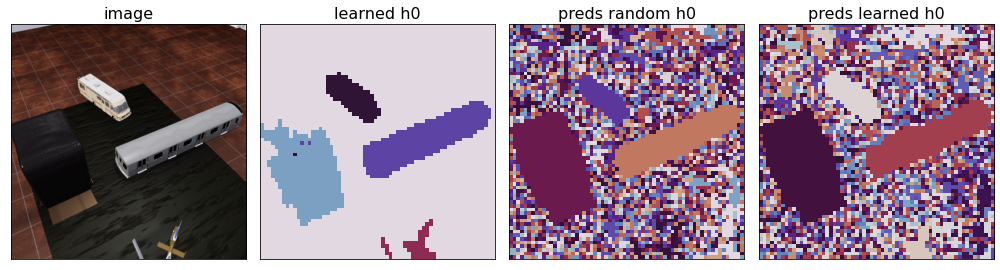

In [116]:
fig, axes = plt.subplots(1,4,figsize=(14,4))
axes[0].imshow(data['image'].permute(1,2,0).cpu().numpy())
# axes[1].imshow(final_hs[-1].argmax(-1).detach().cpu()[0,0], cmap='YlGnBu')
axes[1].imshow(preds.argmax(-1).detach().cpu()[0], cmap='twilight', vmax=preds.shape[-1]+int(rand_background))
axes[2].imshow(comp_masks[0].argmax(-1).detach().cpu().numpy()[0], cmap='twilight')
axes[3].imshow(comp_masks[1].argmax(-1).detach().cpu().numpy()[0], cmap='twilight')

# axes[3].imshow(torch.cat([1-things_mask[:,0,...,None], masks], -1).argmax(-1).detach().cpu().numpy()[0], 
#                cmap='twilight', vmax=masks.shape[-1] + 1)

titles = ['image', 'learned h0', 'preds random h0', 'preds learned h0']
for i, ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=16)
plt.tight_layout()
plt.show()

In [71]:
get_iou(pred, gt)

(array([0.74426471]),
 [array([0.78689706, 0.82793051, 0.47925609, 0.88297516])])

In [72]:
get_iou(comp_masks[0].argmax(-1), gt)

(array([0.39302985]),
 [array([0.91624594, 0.00499386, 0.12992224, 0.52095735])])

In [73]:
get_iou(comp_masks[1].argmax(-1), gt)

(array([0.66744053]),
 [array([0.80323154, 0.76128787, 0.27937248, 0.82587022])])

In [74]:
get_iou(torch.cat([1-things_mask[:,0,...,None], comp_masks[0]], -1).argmax(-1), gt)

(array([0.47430503]),
 [array([0.7914387 , 0.01000323, 0.4374468 , 0.65833139])])

In [75]:
get_iou(torch.cat([1-things_mask[:,0,...,None], comp_masks[1]], -1).argmax(-1), gt)

(array([0.7492867]), [array([0.79324502, 0.83372396, 0.49658653, 0.8735913 ])])

In [102]:
import dorsalventral.models.segmentation.connected_component as cc
cc_masks = cc.label_connected_component(comp_masks[-1].argmax(-1)[0], min_area=10)
cc_masks = cc.reorder_int_labels(cc_masks)
cc_masks.shape

torch.Size([64, 64])

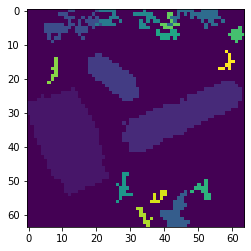

In [103]:
viz(cc_masks[None])

In [178]:
# val_result, val_per_example, val_best_ious = get_ious(
#     val_dataset, None, kpnet, act_net, comp
# )

In [66]:
val_result, val_per_example[:10]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.6559045403050233,
 array([[0.56390242],
        [0.70521843],
        [0.71922982],
        [0.69148245],
        [0.674486  ],
        [0.61928309],
        [0.53161622],
        [0.71787196],
        [0.60640213],
        [0.69849178]]))

In [76]:
# trainval_result, trainval_per_example, trainval_best_ious = get_ious(
#     val_dataset, None, kpnet, act_net, comp
# )

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 490/490 [03:41<00:00,  2.21it/s]


In [77]:
trainval_result

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.6143716833231574

In [91]:
## crossvalidate thingness thresh
threshs = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]
t_results = dict()
for t in threshs:
    t_trainval_result, trainval_per_example, trainval_best_ious = get_ious(
        val_dataset, None, kpnet, act_net, comp, thresh=t
    )
    t_results[t] = t_trainval_result
    print("thresh: %.3f" % t, t_trainval_result)
for t in threshs:
    print(t, t_results[t])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/490 [00:00<?, ?it/s]

thresh: 0.010 0.5619349818167043


  0%|          | 0/490 [00:00<?, ?it/s]

thresh: 0.050 0.6162255179201357


  0%|          | 0/490 [00:00<?, ?it/s]

thresh: 0.100 0.6136601587130216


  0%|          | 0/490 [00:00<?, ?it/s]

thresh: 0.150 0.5556069436033607


  0%|          | 0/490 [00:00<?, ?it/s]

thresh: 0.200 0.42587540607213326


100%|██████████| 490/490 [03:42<00:00,  2.20it/s]

thresh: 0.250 0.30343433720913765
0.01 0.5619349818167043
0.05 0.6162255179201357
0.1 0.6136601587130216
0.15 0.5556069436033607
0.2 0.42587540607213326
0.25 0.30343433720913765


In [31]:
from tqdm import tqdm
DEFAULT_CMAP = plt.cm.twilight
DEFAULT_ERRMAP_COLORS = {k:float(v)/DEFAULT_CMAP.N for k,v in {'tp': 250, 'tn': 0, 'fp': 420, 'fn': 80}.items()}

def plot_errormap(model, dataset, ex=None, iters=24, thresh=4, 
                  cmap=DEFAULT_CMAP,
                  colors=DEFAULT_ERRMAP_COLORS,
                  do_plot=True,
                  return_errormap=True,
                  return_images=False,
                  thingness=False
                 ):
    if ex is None:
        ex = np.random.randint(len(dataset))
        
    blob = dataset[ex]
    try:
        img1, img2, flow = blob[:3]
    except:
        img1, img2 = blob[:2]
        flow = torch.zeros_like(img1[:2])
    _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=iters, test_mode=True)
    
    if thingness:
        _seg = lambda x, t: (torch.sigmoid(x) > t).cpu().numpy()[0,0]
    else:
        _seg = lambda x, t: (x.square().sum(-3).sqrt() > t).cpu().numpy()[0]
    pred_seg = _seg(pred, thresh)
    gt_seg = (flow.square().sum(-3).sqrt() > 0.5).cpu().numpy()
#     gt_seg = _seg(flow[None], 0.5)
    
    tp = pred_seg & gt_seg
    tn = ~pred_seg & ~gt_seg
    fp = pred_seg & ~gt_seg
    fn = ~pred_seg & gt_seg
    n = (pred_seg | gt_seg).sum() + 0.
    
    metrics = {
        'iou': tp.sum() / n,
        'precision': (tp.sum() + 0.) / (tp.sum() + fp.sum()),
        'recall': (tp.sum() + 0.) / (tp.sum() + fn.sum())
    }

    errmap = np.zeros(list(gt_seg.shape) + [3])
    errmap[pred_seg & gt_seg] = list(cmap(colors['tp']))[:3]
    errmap[~pred_seg & ~gt_seg] = list(cmap(colors['tn']))[:3]
    errmap[pred_seg & ~gt_seg] = list(cmap(colors['fp']))[:3]
    errmap[~pred_seg & gt_seg] = list(cmap(colors['fn']))[:3]
    
    if do_plot:
        plt.imshow(errmap)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    elif return_errormap:
        metrics['error_map'] = errmap
        
    if return_images:
        metrics.update({
            'image1': img1.permute(1, 2, 0).cpu().numpy() / 255.,
            'image2': img2.permute(1, 2, 0).cpu().numpy() / 255.,
            'pred': flow_viz.flow_to_image(tensor_to_arr(pred[0])) if not thingness else tensor_to_arr(torch.sigmoid(pred[0])),
            'gt': flow_viz.flow_to_image(tensor_to_arr(flow)) if not thingness else gt_seg
        })
    
    return metrics

def visualize_error_maps(model, dataset, examples=[0], iters=24, thresh=4, max_examples=5, thingness=False):
    
    def val_fn(ex):
        metrics = plot_errormap(model, dataset, ex=ex, iters=iters, thresh=thresh, 
                                do_plot=False, return_errormap=True, return_images=True, thingness=thingness)
        return metrics
    
    if examples is None:
        examples = [np.random.randint(len(dataset)) for _ in range(max_examples)]
    elif isinstance(examples, int):
        examples = [examples]
    else:
        examples = examples[:max_examples]
        
    titles = ['img1', 'img2', 'gt', 'pred @ %d iters' % iters, 'iou = ']
    n_rows = min(len(examples), max_examples)
    n_cols = len(titles)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    if n_rows == 1:
        axes = [axes]
    
    for row, ex in enumerate(examples):
        return_vals = val_fn(ex)
        ax = axes[row]
        ax[0].imshow(return_vals['image1'])
        ax[1].imshow(return_vals['image2'])
        ax[2].imshow(return_vals['gt'])
        ax[3].imshow(return_vals['pred'])
        ax[4].imshow(return_vals['error_map'])
        
        iou = return_vals['iou']
        ts = titles[:-1] + [titles[-1] + ("%.3f" % iou)]
        for col, title in enumerate(ts):
            if col == 4:
                ax[col].set_title(ts[col], fontsize=18, y=0.92)
            ax[col].set_xticks([])
            ax[col].set_yticks([])
        
    plt.tight_layout()
    plt.show()


def validate_examples(model, dataset, examples=[0], iters=24, thresh=4, thingness=False):
    
    def val_fn(ex):
        return plot_errormap(model, dataset, ex=ex, iters=iters, thresh=thresh, do_plot=False, 
                             return_errormap=False, thingness=thingness)
    
    if examples is None:
        examples = range(len(dataset))
    elif isinstance(examples, int):
        examples = [examples]
    
    metrics = {'iou': [], 'precision': [], 'recall': []}
    for ex in tqdm(examples):
        m = val_fn(ex)
        for k,v in m.items():
            metrics[k].append(v)
    return metrics

def agg_metrics(metrics):
    agg = {k:np.nanmean(np.array(v)) for k,v in metrics.items()}
    nans = {k+'_isnan':np.isnan(np.array(v)).mean() for k,v in metrics.items()}
    return (agg, nans)
    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars


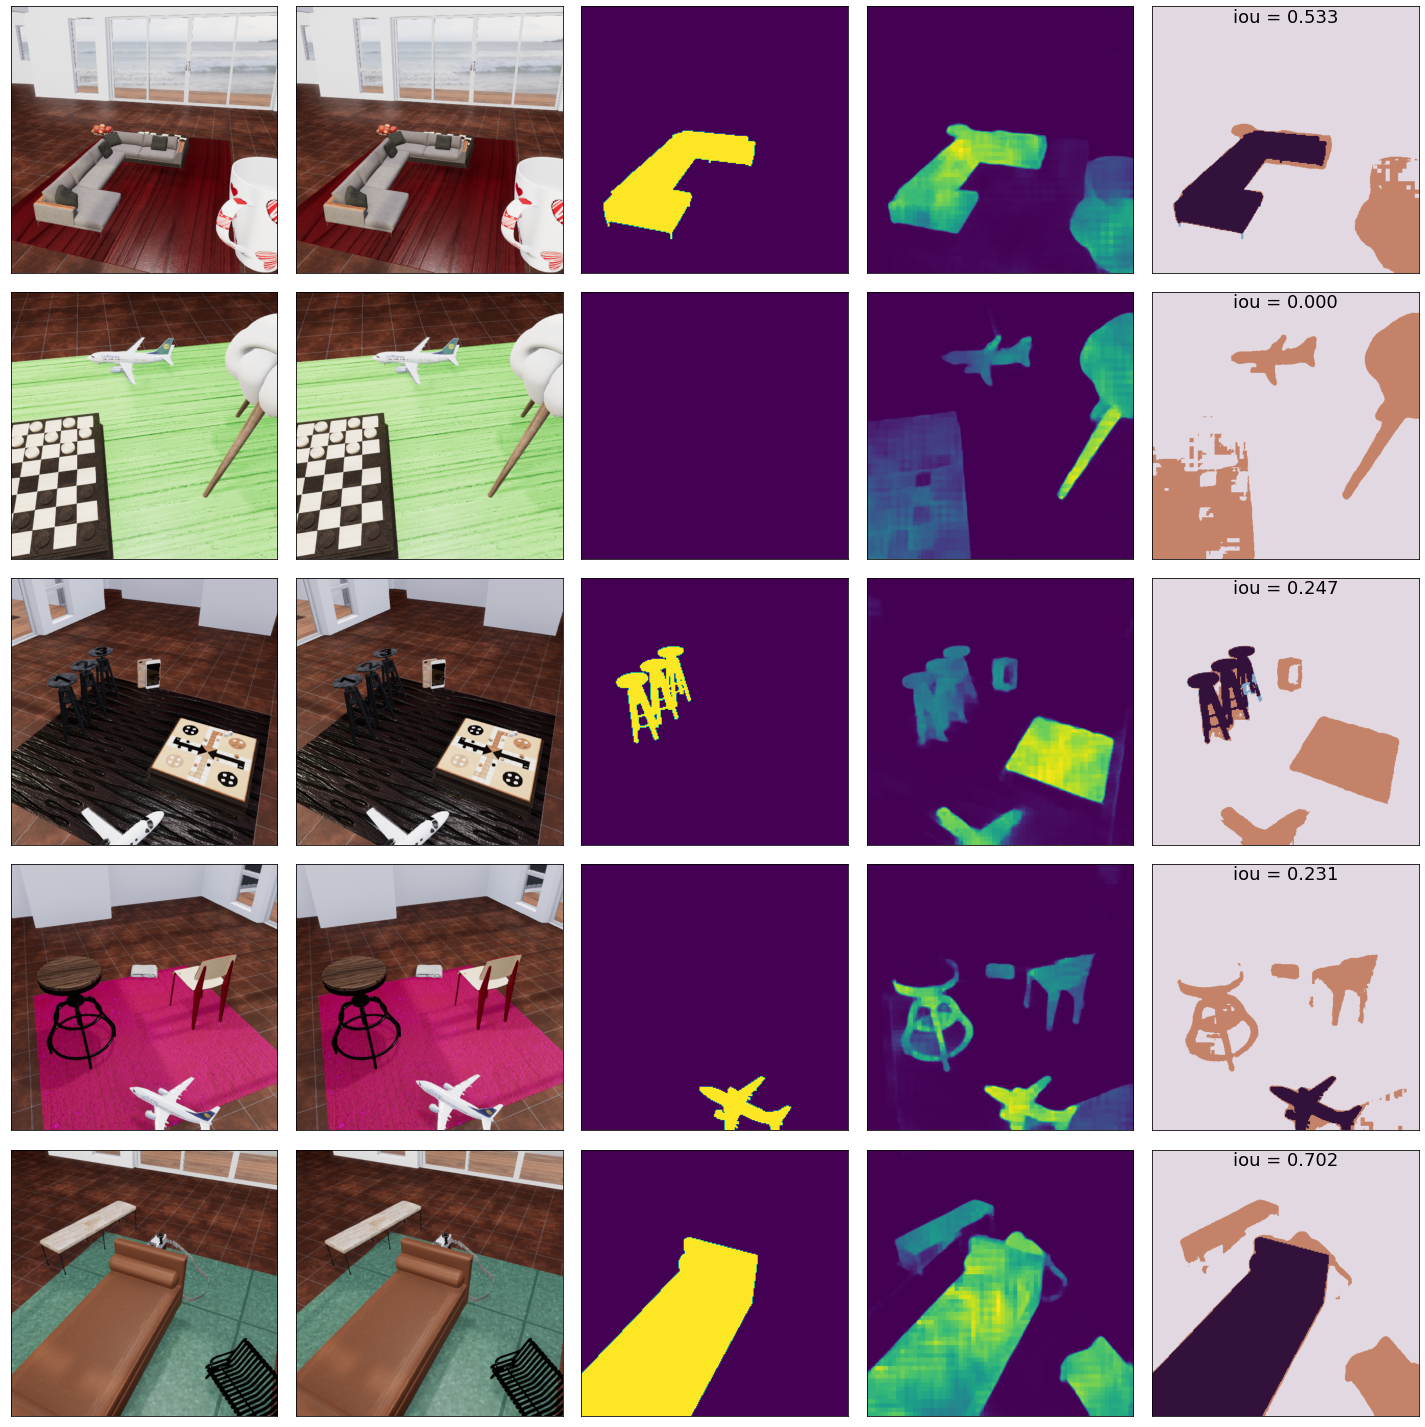

In [32]:
tdw_dataset.is_test = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
visualize_error_maps(act_net, tdw_dataset, examples=range(5), thresh=0.1, thingness=True)

In [39]:
tdw_dataset.files[0]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/model_split_0/0009.hdf5'

In [40]:
val_dataset.file_list[0]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'/mnt/fs6/honglinc/dataset/tdw_playroom_small/images/model_split_0/0009'

In [325]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-allframes.pth


 11%|█▏        | 57/500 [00:15<01:55,  3.84it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:15<00:00,  3.68it/s]


({'iou': 0.7764962111216519,
  'precision': 0.8384561253722288,
  'recall': 0.9122151587805122},
 {'iou_isnan': 0.042, 'precision_isnan': 0.068, 'recall_isnan': 0.048})

In [326]:
print(load_path)
tdw_dataset.max_start_frame = None
tdw_dataset.is_test = True
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-allframes.pth


 11%|█▏        | 57/500 [00:14<02:07,  3.48it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:11<00:00,  3.82it/s]


({'iou': 0.6240724749082448,
  'precision': 0.8703083461953551,
  'recall': 0.7079785642796534},
 {'iou_isnan': 0.028, 'precision_isnan': 0.182, 'recall_isnan': 0.034})

In [153]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn.pth


 11%|█▏        | 57/500 [00:15<02:06,  3.50it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:14<00:00,  3.72it/s]


({'iou': 0.8258794803290415,
  'precision': 0.9140077864749222,
  'recall': 0.8990444173111047},
 {'iou_isnan': 0.046, 'precision_isnan': 0.088, 'recall_isnan': 0.048})

In [154]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = None
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn.pth


 11%|█▏        | 57/500 [00:15<02:16,  3.24it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:16<00:00,  3.66it/s]


({'iou': 0.5279725941740948,
  'precision': 0.9000479561979515,
  'recall': 0.5769562252348509},
 {'iou_isnan': 0.03, 'precision_isnan': 0.308, 'recall_isnan': 0.032})

In [161]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../models/raft-sintel.pth


 11%|█▏        | 57/500 [00:15<02:10,  3.38it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:15<00:00,  3.70it/s]


({'iou': 0.7969608048584764,
  'precision': 0.9451550029757846,
  'recall': 0.8369056144481988},
 {'iou_isnan': 0.046, 'precision_isnan': 0.088, 'recall_isnan': 0.048})

In [162]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = None
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../models/raft-sintel.pth


 11%|█▏        | 57/500 [00:15<02:06,  3.49it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:27<00:00,  3.39it/s]


({'iou': 0.5751281585458882,
  'precision': 0.9517182482523737,
  'recall': 0.5998352226939102},
 {'iou_isnan': 0.026, 'precision_isnan': 0.214, 'recall_isnan': 0.028})

In [69]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-fullplay.pth


 11%|█▏        | 57/500 [00:13<01:55,  3.83it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:04<00:00,  4.00it/s]


({'iou': 0.8434272244586196,
  'precision': 0.9281359996793522,
  'recall': 0.9046012481700816},
 {'iou_isnan': 0.048, 'precision_isnan': 0.086, 'recall_isnan': 0.048})

In [70]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = None
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-fullplay.pth


 11%|█▏        | 57/500 [00:13<01:49,  4.04it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:04<00:00,  4.01it/s]


({'iou': 0.5981904560853916,
  'precision': 0.9346249676908188,
  'recall': 0.6332787538043337},
 {'iou_isnan': 0.03, 'precision_isnan': 0.26, 'recall_isnan': 0.03})

In [71]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=4, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-fullplay.pth


 11%|█▏        | 57/500 [00:14<01:54,  3.86it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:04<00:00,  4.01it/s]


({'iou': 0.8315872222955202,
  'precision': 0.9656698780014051,
  'recall': 0.8579017929928859},
 {'iou_isnan': 0.048, 'precision_isnan': 0.092, 'recall_isnan': 0.048})

In [16]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = 5
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-amaxtotalenergyframes.pth


 11%|█▏        | 57/500 [00:16<02:10,  3.40it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:25<00:00,  3.45it/s]


({'iou': 0.8303785279437017,
  'precision': 0.9182744638935051,
  'recall': 0.8974846304309999},
 {'iou_isnan': 0.048, 'precision_isnan': 0.084, 'recall_isnan': 0.048})

In [17]:
print(load_path)
tdw_dataset.is_test = True
tdw_dataset.max_start_frame = None
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/raft-tdw-bn-amaxtotalenergyframes.pth


 11%|█▏        | 57/500 [00:16<02:09,  3.42it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [02:25<00:00,  3.45it/s]


({'iou': 0.581308515985887,
  'precision': 0.9267800688274951,
  'recall': 0.623141531366377},
 {'iou_isnan': 0.032, 'precision_isnan': 0.274, 'recall_isnan': 0.032})

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


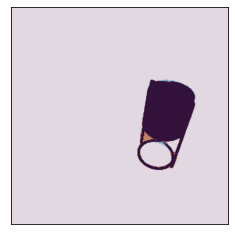

In [77]:
tdw_dataset.is_test = False
metrics = plot_errormap(net, tdw_dataset, ex=41, thresh=4, iters=24)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


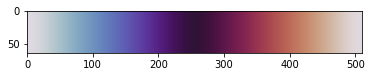

In [275]:
cmap = plt.cm.twilight(range(510))
cmap = np.stack([cmap]*64, 0)
plt.imshow(cmap)

In [67]:
bootraft.layers.num_parameters(net.module.update_block)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3120960

In [68]:
print(net.module.update_block)

BasicUpdateBlock(
  (encoder): BasicMotionEncoder(
    (convc1): Conv2d(324, 256, kernel_size=(1, 1), stride=(1, 1))
    (convc2): Conv2d(256, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (convf1): Conv2d(2, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (convf2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (gru): SepConvGRU(
    (convz1): Conv2d(384, 128, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (convr1): Conv2d(384, 128, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (convq1): Conv2d(384, 128, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (convz2): Conv2d(384, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (convr2): Conv2d(384, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (convq2): Conv2d(384, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
  )
  (flow_head): FlowHead(
    (conv1): C

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [120]:
tdw_dataset = raft_datasets.TdwFlowDataset(
    root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
    dataset_names=['model_split_4'],    
    split='training',
    filepattern="*",
    test_filepattern="0*[0-4]",
    min_start_frame=0,
    max_start_frame=None,
    scale_to_pixels=True,
    get_gt_flow=True,
    training_frames='../datasets/supervision_frames/model_split_4_threshargmax.json',
    testing_frames='../datasets/supervision_frames/model_split_4_threshargmax.json'
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

1250
False


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
list(tdw_dataset.training_frames.values())[:10]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[4], [9], [14], [21], [11], [4], [48], [15], [11], [52]]

In [112]:
list(tdw_dataset.testing_frames.values())[:10]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[4], [9], [14], [21], [11], [44], [7], [14], [119], [6]]

In [122]:
data_blob = tdw_dataset[5]

selected frame 4


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [184]:
torch.randint?

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [191]:
x = torch.rand([4, 8, 64]).transpose(1,2)
inds = torch.randint(low=0, high=64, size=[4,6], dtype=torch.long)
b_inds = torch.arange(4, dtype=torch.long)[:,None].repeat(1,6)
inds = torch.stack([b_inds, inds])
x[list(inds)].shape

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([4, 6, 8])

In [227]:
import kmeans
Knet = kmeans.KMeans(num_clusters=32, num_iters=50, append_coordinates=True).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [228]:
img1, img2, flow, _ = tdw_dataset[3]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [229]:
img = img1[None].to(torch.uint8).cuda()
labels = Knet(img)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


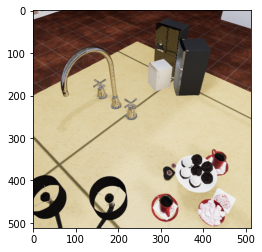

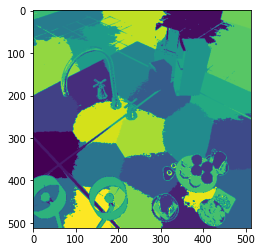

In [230]:
viz(img)
plt.show()
viz(labels)
plt.show()

In [18]:
import compute_training_frames as filtering
knet = torch.nn.DataParallel(filtering.KMeans(16, 50, True)).cuda()
seg_net = filtering.VideoSegmentationModel(model=knet, num_input_frames=1).cuda()
motion_net = net
explain_net = filtering.ExplainedAwayMotion(motion_net, seg_net)

def viz_segments(net, dataset, ex=0, iters=12, test_mode=True):
    img1, img2 = dataset[ex][:2]
    score = net(img1[None].cuda(), img2[None].cuda(), iters=iters, test_mode=True)
    
    fig, axes = plt.subplots(1,4, figsize=(12,4))
    
    axes[0].imshow((img1 / 255.).permute(1,2,0).numpy())
    axes[1].imshow(net.motion_segments[0].detach().cpu().numpy(), cmap='magma')
    axes[2].imshow(net.static_segments[0].detach().cpu().numpy(), cmap='plasma')
    axes[3].imshow(net.out_segments[0].detach().cpu().numpy(), cmap='YlGnBu')
    
    titles = ['Image1', 'MotionSeg', 'StaticSegs', 'FinalSegs']
    for i,ax in enumerate(axes):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i], fontsize=20)
        
    plt.tight_layout()
    plt.show()
    
    return score


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


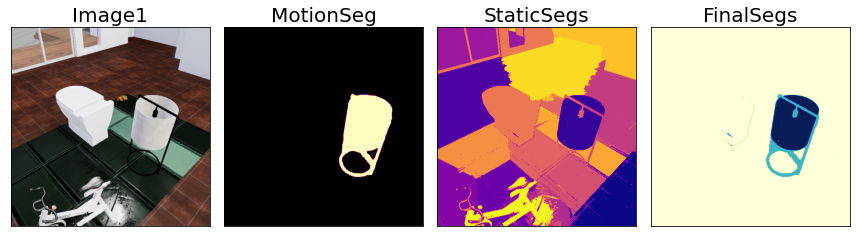

0.020595550537109375

In [19]:
viz_segments(explain_net, tdw_dataset, ex=41)

# read in robonet

In [20]:
import dorsalventral.data.robonet as robonet
import dorsalventral.vis_utils as vis_utils

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
robonet.get_robot_names()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['berkeley_sawyer',
 'berkeley_widowx',
 'google',
 'meta_data.pkl',
 'penn_baxter_left',
 'penn_baxter_right',
 'penn_kuka',
 'stanford_fetch',
 'stanford_franka',
 'stanford_franka_corr_noise']

In [339]:
robonet_dataset = robonet.RobonetDataset(sequence_length=2)

Using 700 files from robots with names ['berkeley_sawyer', 'berkeley_widowx', 'google', 'penn_baxter_left', 'penn_baxter_right', 'penn_kuka', 'stanford_fetch', 'stanford_franka', 'stanford_franka_corr_noise']


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [342]:
rmov = robonet_dataset[0]

filename: /data5/dbear/robonet_sampler/hdf5/berkeley_sawyer_traj11308.hdf5
num_states --> 31
arr shape (2, 240, 320, 3)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


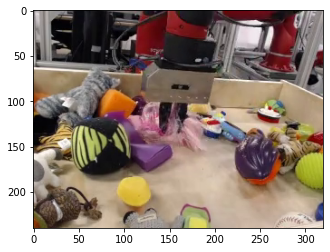

In [352]:
vis_utils.imshow(rmov['images'], None, 1)

In [50]:
robonet_dataset = raft_datasets.RobonetFlowDataset(sequence_length=2, 
                                                   dataset_names=["berk*"],
                                                   train=False
                                                  )
print(robonet_dataset.all_robots)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using 200 files from robots with names ['berk*']
['berkeley_sawyer', 'berkeley_widowx', 'google', 'meta_data.pkl', 'penn_baxter_left', 'penn_baxter_right', 'penn_kuka', 'stanford_fetch', 'stanford_franka', 'stanford_franka_corr_noise']


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


filename: /data5/dbear/robonet_sampler/hdf5/berkeley_sawyer_traj19970.hdf5
num_states --> 31
arr shape (2, 240, 320, 3)


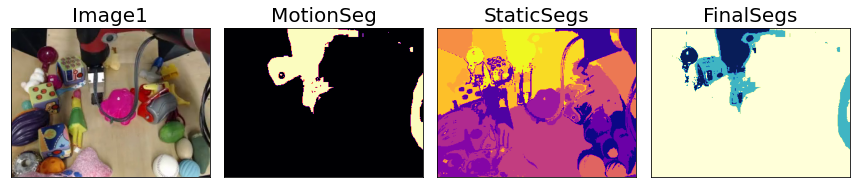

0.07240885496139526

In [23]:
viz_segments(explain_net, robonet_dataset, 15)

In [ ]:
net = nn.DataParallel()

In [51]:
load_path = '../models/raft-sintel.pth'
# load_path = '../checkpoints/raft-tdw-bn-fullplay.pth'
net.load_state_dict(torch.load(load_path), strict=False)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully>

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


../models/raft-sintel.pth
arr shape (2, 240, 320, 3)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


arr shape (2, 240, 320, 3)
arr shape (2, 240, 320, 3)
arr shape (2, 240, 320, 3)
arr shape (2, 240, 320, 3)


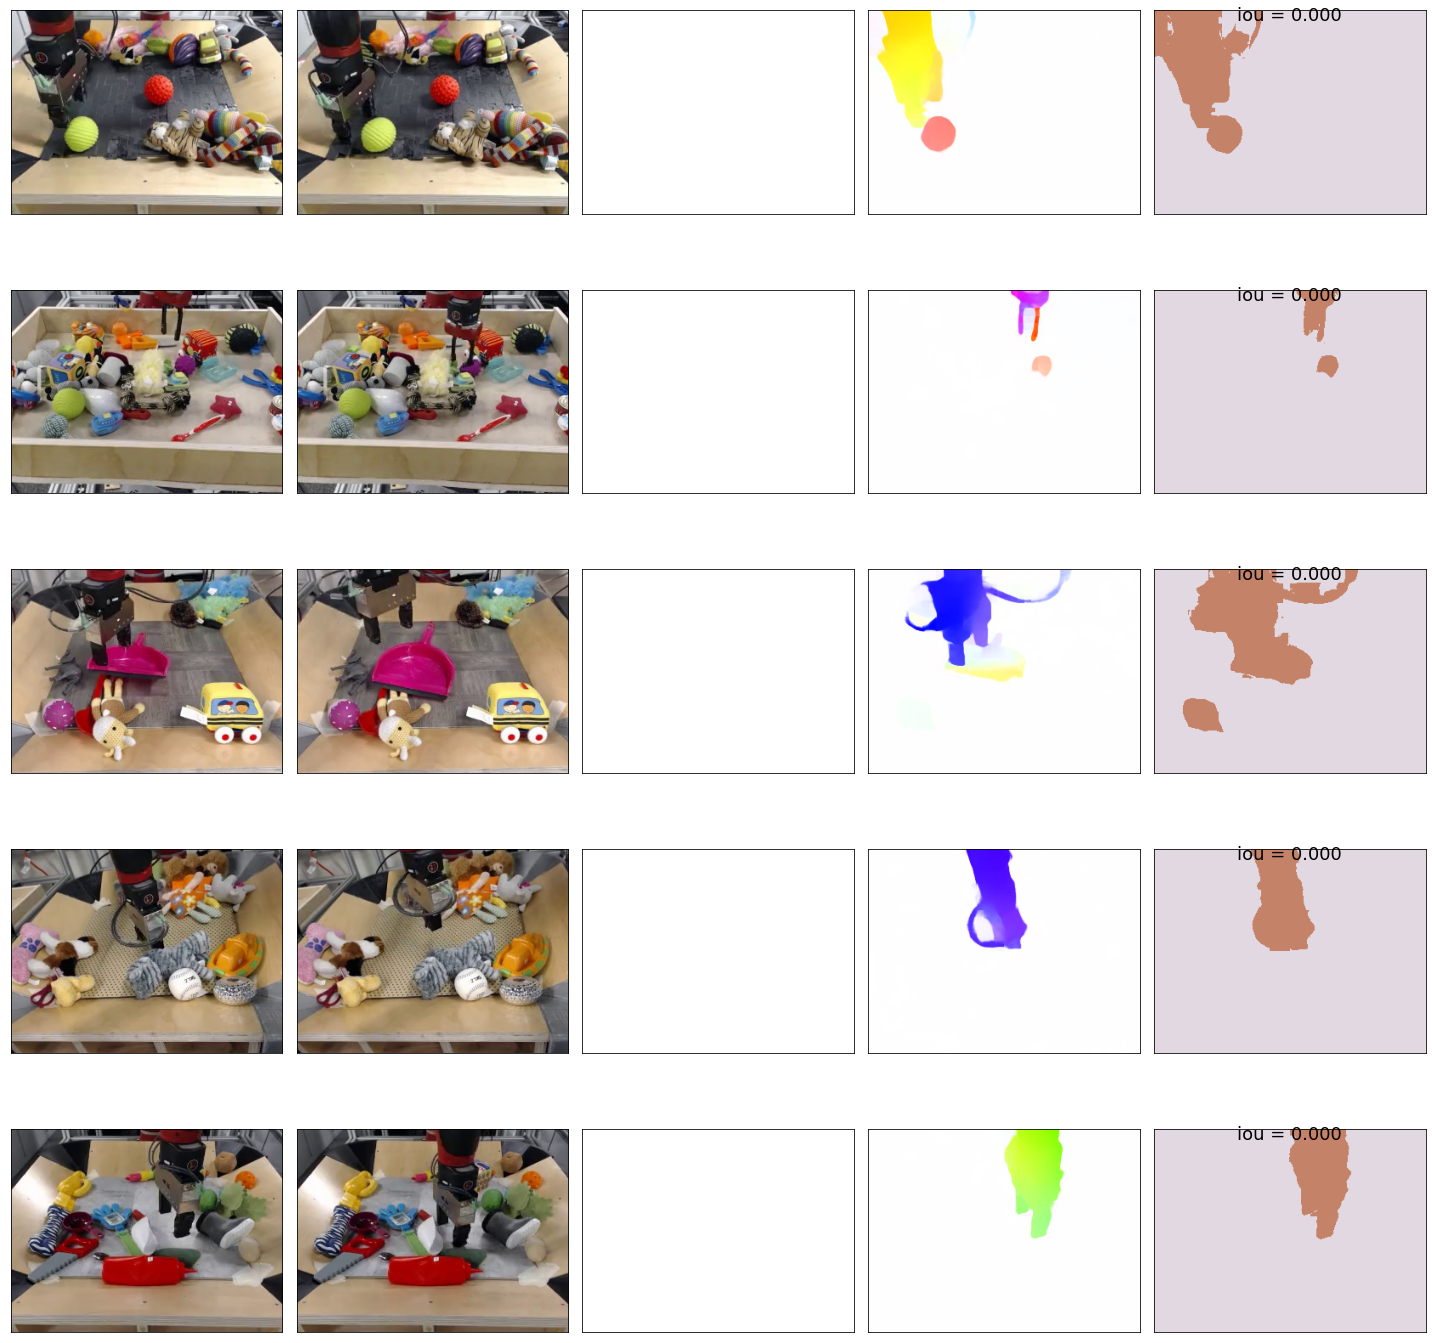

In [52]:
print(load_path)
visualize_error_maps(net, robonet_dataset, examples=range(5,10), thresh=0.5)